conda install -y numpy pandas matplotlib seaborn scikit-learn joblib opencv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, jaccard_score, multilabel_confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import ast 

# Balance the movies to genre


In [90]:
N = 3000

In [91]:
import pandas as pd

# Load dataset
data = pd.read_csv("tmdb_5000_movies.csv")

# Convert the 'genres' column from JSON-like strings to actual lists
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract all unique genre names
all_genres = sorted(set(genre["name"] for sublist in data["genres"] for genre in sublist))

# Create binary columns for each genre (multi-label format)
for genre in all_genres:
    data[genre] = data["genres"].apply(lambda x: 1 if any(d["name"] == genre for d in x) else 0)

# Select a balanced subset
movies_per_genre = N // len(all_genres)  # Divide evenly among genres

# Collect movies for each genre
balanced_movies = pd.DataFrame()
for genre in all_genres:
    genre_movies = data[data[genre] == 1].sample(min(movies_per_genre, len(data[data[genre] == 1])), random_state=42)
    balanced_movies = pd.concat([balanced_movies, genre_movies])

# Remove duplicates (movies with multiple genres may have been selected more than once)
balanced_movies = balanced_movies.drop_duplicates(subset=["id"])

# Ensure we have at most N movies
balanced_movies = balanced_movies.head(N)

# Save the processed dataset (optional)
balanced_movies.to_csv("balanced_tmdb_500_movies.csv", index=False)

# Print dataset info
print(f"✅ Selected {len(balanced_movies)} balanced movies")
print(balanced_movies["genres"].head())

✅ Selected 2112 balanced movies
2129    [{'id': 12, 'name': 'Adventure'}, {'id': 10751...
994     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
2203    [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...
1428    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
782     [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
Name: genres, dtype: object


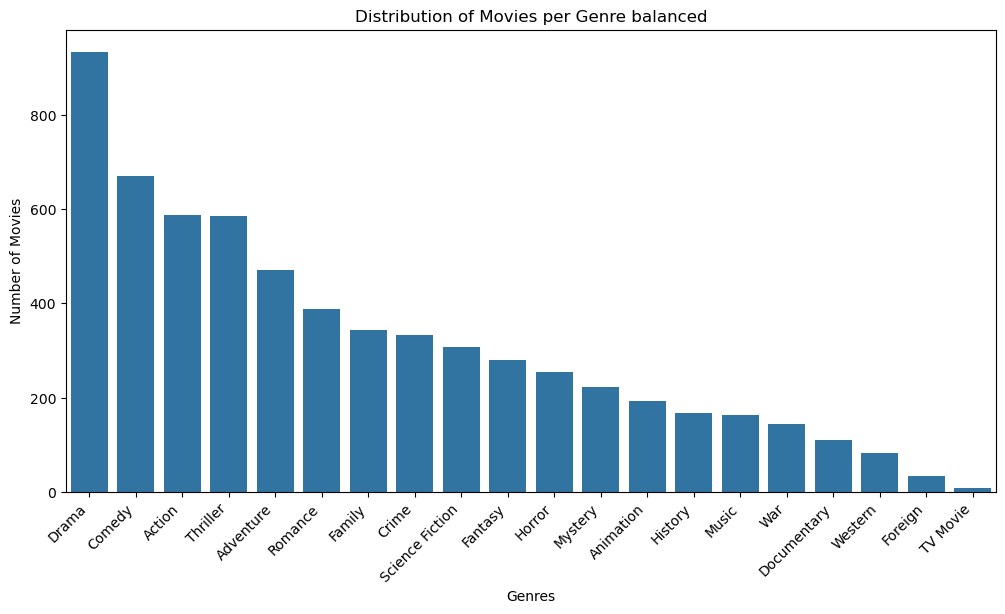

In [92]:
data = pd.read_csv("balanced_tmdb_500_movies.csv")

# Count the number of movies per genre
genre_counts = data[all_genres].sum().sort_values(ascending=False)

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movies per Genre balanced")
plt.show()


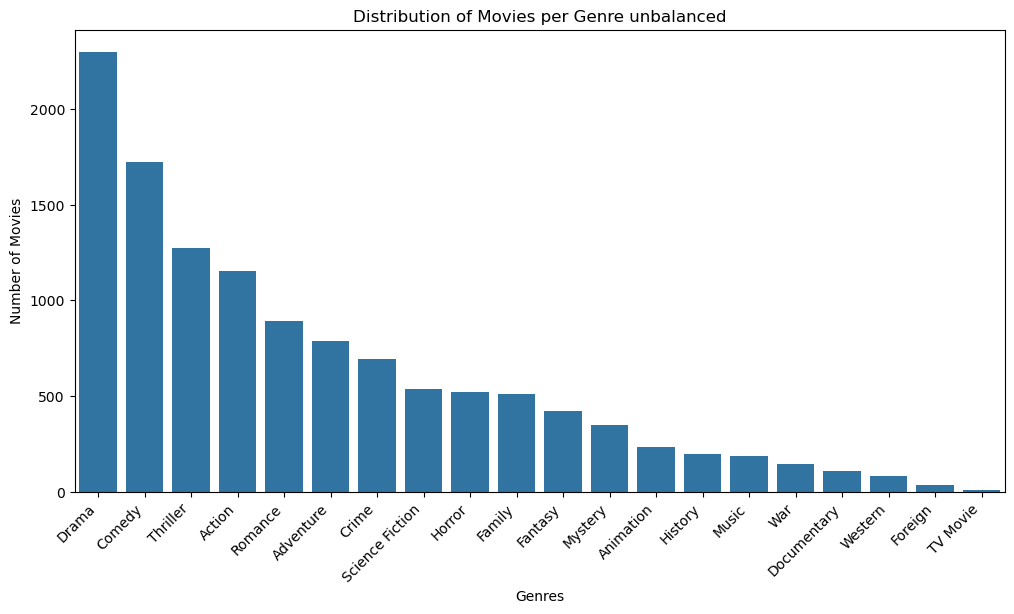

In [93]:
import pandas as pd
import ast

# Load dataset
data = pd.read_csv("tmdb_5000_movies.csv")

# Convert the 'genres' column from JSON-like strings to actual lists
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract all unique genre names
all_genres = sorted(set(genre["name"] for sublist in data["genres"] for genre in sublist))

# Create binary columns for each genre (multi-label format)
for genre in all_genres:
    data[genre] = data["genres"].apply(lambda x: 1 if any(d["name"] == genre for d in x) else 0)

# Count the number of movies per genre
genre_counts = data[all_genres].sum().sort_values(ascending=False)

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movies per Genre unbalanced")
plt.show()

In [94]:
# -------------------- Step 1: Load Data -------------------- #
data = pd.read_csv("balanced_tmdb_500_movies.csv")  # Load dataset

# Convert 'genres' column from string to a list of dictionaries
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract unique genre names
all_genres = sorted(set(genre["name"] for sublist in data["genres"] for genre in sublist))

# Create binary columns for each genre
for genre in all_genres:
    data[genre] = data["genres"].apply(lambda x: 1 if any(d["name"] == genre for d in x) else 0)

# Keep only relevant columns
columns_to_keep = ["id", "title", "overview"] + all_genres
data = data[columns_to_keep]

# Drop rows with missing overviews
data = data.dropna(subset=["overview"])

# Now, limit to N movies
data = data.head(N)

# Print final dataset info
print(f"✅ Final dataset contains {len(data)} movies")
print(data.head())

✅ Final dataset contains 2110 movies
      id               title  \
0   9570      The Black Hole   
1  18501               Gamer   
2   8198  The Quiet American   
3  11918     Superhero Movie   
4   8285          The Spirit   

                                            overview  Action  Adventure  \
0  The explorer craft U.S.S. Palomino is returnin...       1          1   
1  Mind-control technology has taken society by a...       1          0   
2  A stylish political thriller where love and wa...       1          0   
3  The team behind Scary Movie takes on the comic...       1          0   
4  Down these mean streets a man must come. A her...       1          0   

   Animation  Comedy  Crime  Documentary  Drama  ...  History  Horror  Music  \
0          0       0      0            0      0  ...        0       0      0   
1          0       0      0            0      0  ...        0       0      0   
2          0       0      0            0      1  ...        0       0      0   

In [95]:
# -------------------- Step 2: Text Feature Extraction -------------------- #
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = vectorizer.fit_transform(data['overview']).toarray()
print(f"✅ X_text shape: {X_text.shape}")

✅ X_text shape: (2110, 5000)


In [96]:
# -------------------- Step 3: Image Feature Extraction -------------------- #
# Load ResNet50 once (not in function to avoid reloading every time)
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_image_features(img_path):
    """Extracts deep image features using ResNet50"""
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Load image
        img_array = image.img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match ResNet input
        img_array = preprocess_input(img_array)  # Apply ResNet preprocessing

        features = resnet.predict(img_array)  # Get ResNet features
        return features.flatten()  # Flatten to 1D array
    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")
        return np.zeros(2048)  # Return zero vector if error occurs

# Test with an **actual** existing image path
sample_img_path = "posters/5.jpg"  # Make sure this image exists!
print(f"✅ Image features for '{sample_img_path}': {extract_image_features(sample_img_path).shape}")

# Load image features (assuming images are stored in 'posters/' folder)
image_paths = [f"posters/{id}.jpg" for id in data['id']]
X_image = np.array([extract_image_features(img) if os.path.exists(img) else np.zeros(2048) for img in image_paths])

print("✅ Final image feature shape:", X_image.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Image features for 'posters/5.jpg': (2048,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━

In [97]:
# -------------------- Step 4: Train Individual Models -------------------- #
y = data[all_genres].values

X_train_text, X_test_text, X_train_image, X_test_image, y_train, y_test = train_test_split(
    X_text, X_image, y, test_size=0.2, random_state=42
)

text_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
text_model.fit(X_train_text, y_train)

image_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
image_model.fit(X_train_image, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [99]:
# -------------------- Step 5: Late Fusion -------------------- #
# Get predictions from both models
preds_text = text_model.predict_proba(X_test_text)
preds_image = image_model.predict_proba(X_test_image)

# Print raw predictions (list format)
print(f"🔍 Raw preds_text type: {type(preds_text)}, length: {len(preds_text)}")
print(f"🔍 Raw preds_image type: {type(preds_image)}, length: {len(preds_image)}")
print(f"🔍 Example preds_text[0] shape: {np.array(preds_text[0]).shape}")
print(f"🔍 Example preds_image[0] shape: {np.array(preds_image[0]).shape}")

# Convert list of arrays into a (num_samples, num_genres) NumPy array
def extract_class_probabilities(preds):
    processed_preds = []
    for p in preds:
        p = np.array(p)  # Convert to NumPy array if it's a list
        if p.ndim == 2 and p.shape[1] > 1:  
            processed_preds.append(p[:, 1])  # Extract class 1 probabilities if available
        else:
            processed_preds.append(p.flatten())  # Use as is if only one column

    return np.array(processed_preds).T  # Transpose to match expected shape

# Apply function to both models' predictions
preds_text = extract_class_probabilities(preds_text)
preds_image = extract_class_probabilities(preds_image)

# Debug final shapes
print("✅ Processed preds_text shape:", preds_text.shape)  # Expected: (40, 20)
print("✅ Processed preds_image shape:", preds_image.shape)  # Expected: (40, 20)

# Convert probability outputs to binary (0/1) using a threshold (e.g., 0.5)
preds_text_bin = preds_text >= 0.3
preds_image_bin = preds_image >= 0.3

# Weighted fusion (equal weight given to both models)
fused_preds = (preds_text_bin * 0.5) + (preds_image_bin * 0.5)
fused_preds = (fused_preds >= 0.5).astype(int)  # Convert to binary

🔍 Raw preds_text type: <class 'list'>, length: 20
🔍 Raw preds_image type: <class 'list'>, length: 20
🔍 Example preds_text[0] shape: (422, 2)
🔍 Example preds_image[0] shape: (422, 2)
✅ Processed preds_text shape: (422, 20)
✅ Processed preds_image shape: (422, 20)


In [101]:
from sklearn.metrics import f1_score, jaccard_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- Step 6: Evaluation -------------------- #
print("✅ y_test shape:", y_test.shape)
print("✅ Text-Only Predictions shape:", preds_text.shape)
print("✅ Fused Predictions shape:", fused_preds.shape)

# Evaluate Text-Only Model
print("\n📊 **Text-Only Model Evaluation**")
print("F1 Score (Macro):", f1_score(y_test, preds_text_bin, average='macro'))
print("Jaccard Score (Macro):", jaccard_score(y_test, preds_text_bin, average='macro'))

# Evaluate Image-Only Model
print("\n📊 **Image-Only Model Evaluation**")
print("F1 Score (Macro):", f1_score(y_test, preds_image_bin, average='macro'))
print("Jaccard Score (Macro):", jaccard_score(y_test, preds_image_bin, average='macro'))

# Evaluate Text + Image Model
print("\n📊 **Text + Image (Fused) Model Evaluation**")
print("F1 Score (Macro):", f1_score(y_test, fused_preds, average='macro'))
print("Jaccard Score (Macro):", jaccard_score(y_test, fused_preds, average='macro'))

✅ y_test shape: (422, 20)
✅ Text-Only Predictions shape: (422, 20)
✅ Fused Predictions shape: (422, 20)

📊 **Text-Only Model Evaluation**
F1 Score (Macro): 0.3883711159850177
Jaccard Score (Macro): 0.2551644429222135

📊 **Image-Only Model Evaluation**
F1 Score (Macro): 0.2958307330042387
Jaccard Score (Macro): 0.20129279730538965

📊 **Text + Image (Fused) Model Evaluation**
F1 Score (Macro): 0.4316173423137356
Jaccard Score (Macro): 0.2921691868213145


In [102]:
# Compute confusion matrices
conf_matrix_img = multilabel_confusion_matrix(y_test, preds_image_bin)
conf_matrix_text = multilabel_confusion_matrix(y_test, preds_text_bin)
conf_matrix_fused = multilabel_confusion_matrix(y_test, fused_preds)

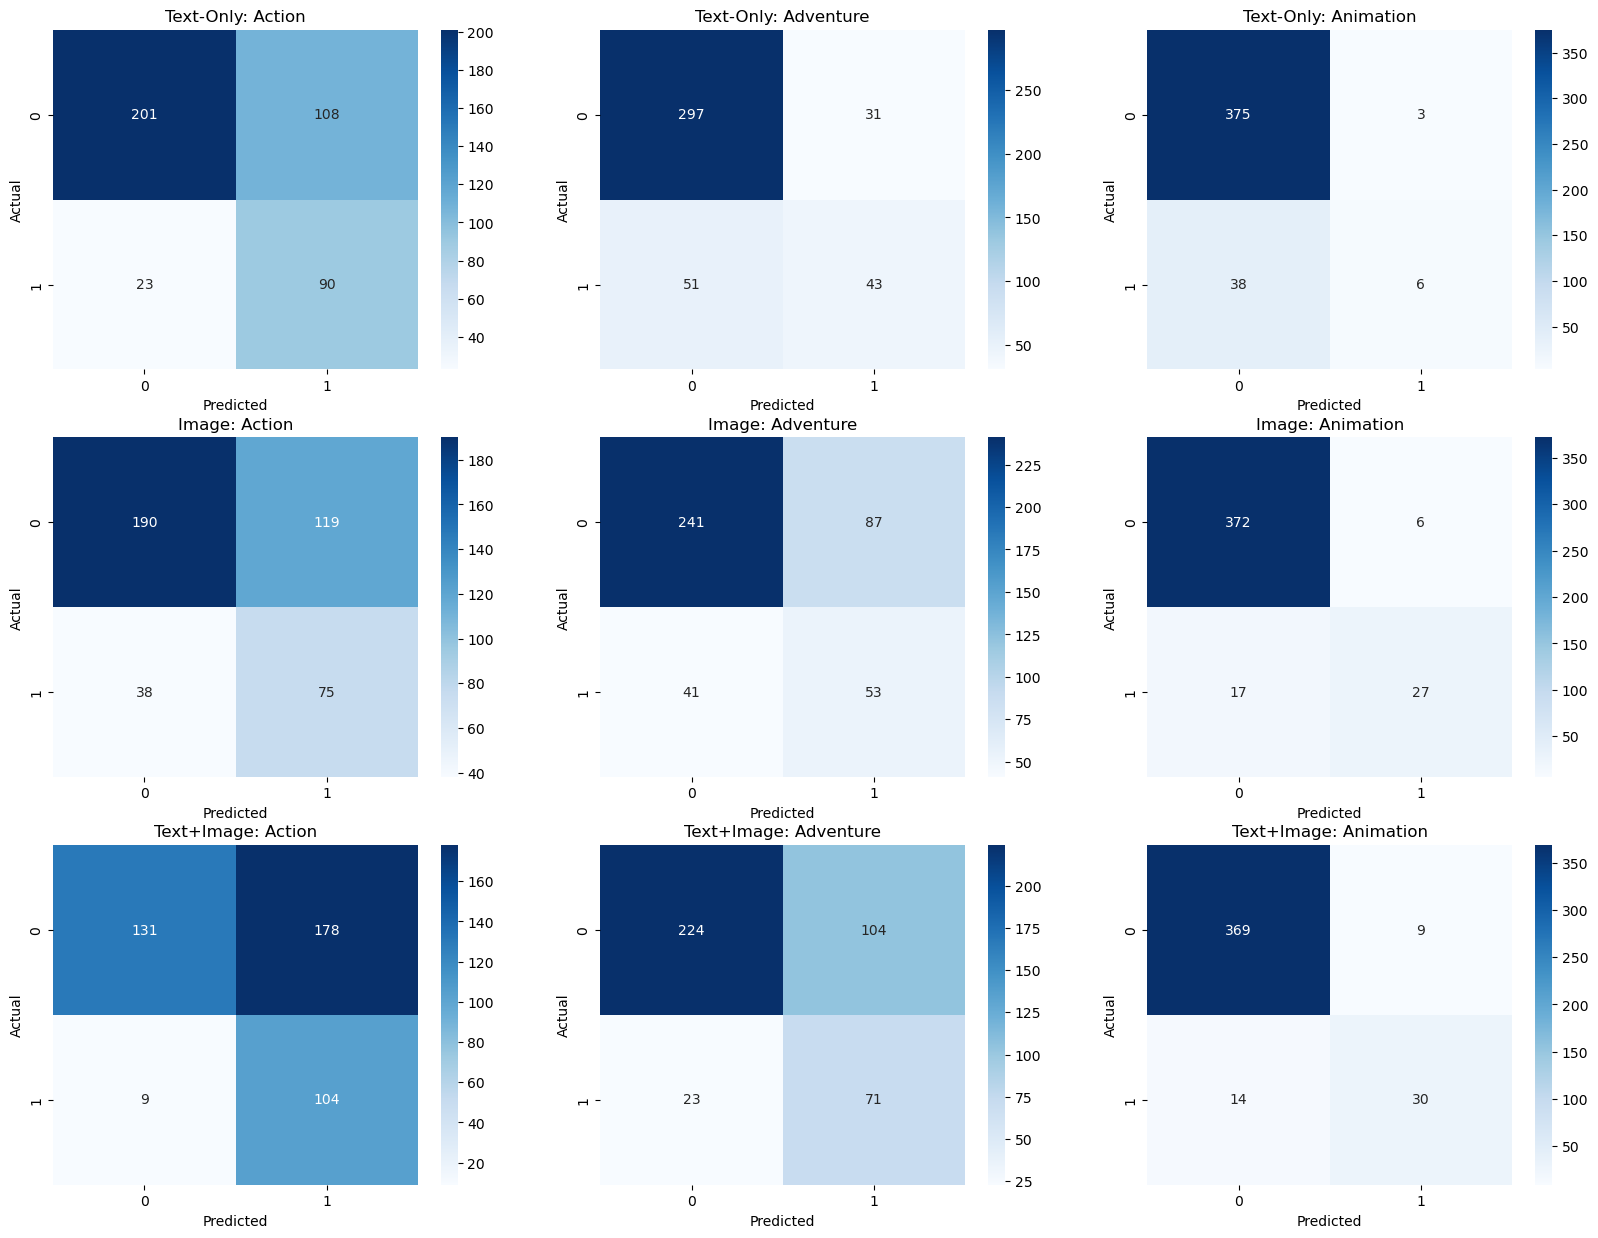

In [105]:
# Create subplots (2 rows: Text-Only vs Text+Image, Columns = genres)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Plot Text-Only Confusion Matrices
for i, (ax, genre) in enumerate(zip(axes[0], all_genres)):
    sns.heatmap(conf_matrix_text[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f"Text-Only: {genre}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Plot Image Confusion Matrices
for i, (ax, genre) in enumerate(zip(axes[1], all_genres)):
    sns.heatmap(conf_matrix_img[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f"Image: {genre}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Plot Text+Image Confusion Matrices
for i, (ax, genre) in enumerate(zip(axes[2], all_genres)):
    sns.heatmap(conf_matrix_fused[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f"Text+Image: {genre}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.show()

y_test shape: (422, 20)
fused_preds shape: (422, 20)
F1 Score (Macro): 0.4316173423137356
Jaccard Score (Macro): 0.2921691868213145


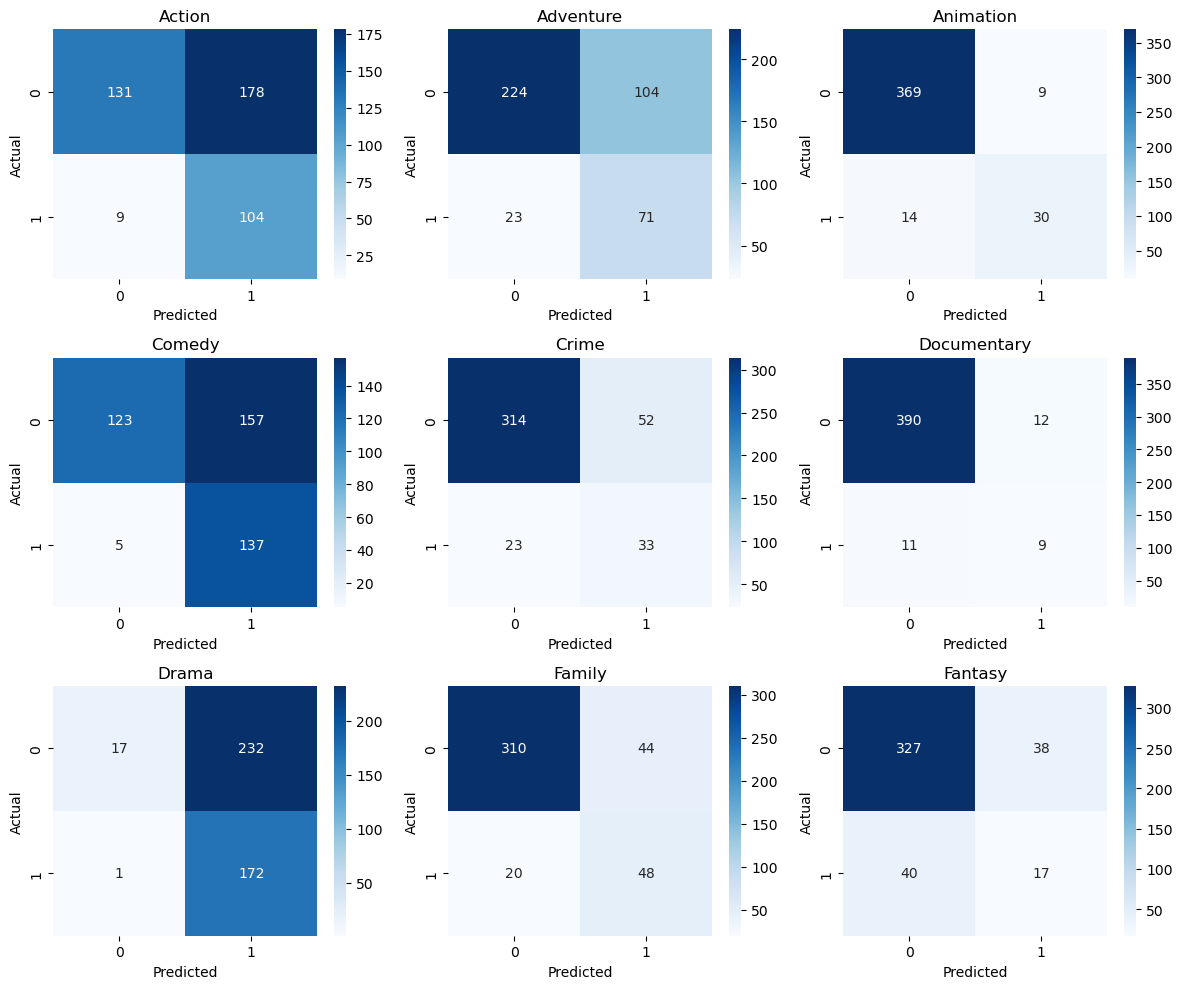

['tfidf_vectorizer.pkl']

In [106]:
# -------------------- Step 6: Evaluation -------------------- #
print("y_test shape:", y_test.shape)
print("fused_preds shape:", fused_preds.shape)

print("F1 Score (Macro):", f1_score(y_test, fused_preds, average='macro'))
print("Jaccard Score (Macro):", jaccard_score(y_test, fused_preds, average='macro'))

# Plot Confusion Matrix
conf_matrix = multilabel_confusion_matrix(y_test, fused_preds)
fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # Adjust grid size for genres
for i, (ax, genre) in enumerate(zip(axes.ravel(), all_genres)):
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(genre)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

# Save models
joblib.dump(text_model, "text_model.pkl")
joblib.dump(image_model, "image_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


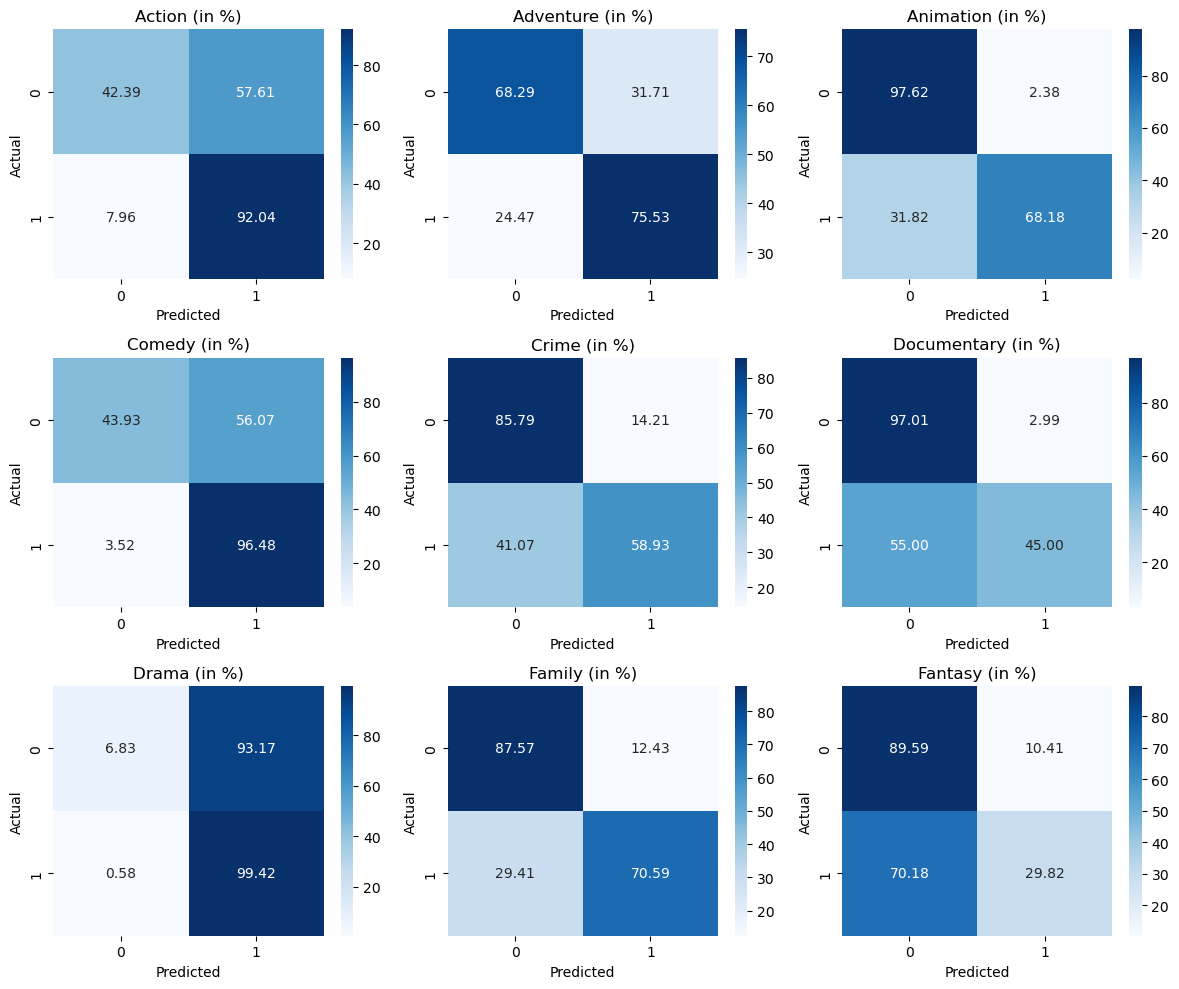

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrix
conf_matrix = multilabel_confusion_matrix(y_test, fused_preds)

# Convert values to percentages (normalize per row)
conf_matrix_percent = np.array([
    cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100 for cm in conf_matrix
])
conf_matrix_percent = np.nan_to_num(conf_matrix_percent)  # Replace NaN with 0

# Plot Confusion Matrix in Percentage Form
fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # Adjust grid size for genres
for i, (ax, genre) in enumerate(zip(axes.ravel(), all_genres)):
    sns.heatmap(conf_matrix_percent[i], annot=True, fmt='.2f', ax=ax, cmap='Blues')
    ax.set_title(f"{genre} (in %)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Script to download Posters


In [9]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from PIL import Image
from io import BytesIO

# 🔹 Replace with your actual TMDb API key
TMDB_API_KEY = "76709f6c4b16101da7ce2bee6be5b74c"

# 🔹 Read the movie dataset (ensure it contains a 'title' column)
data = pd.read_csv("tmdb_5000_movies.csv")

# 🔹 Directory to save posters
POSTER_DIR = "posters"
os.makedirs(POSTER_DIR, exist_ok=True)

# 🔹 Function to get the poster URL from TMDb
def get_poster_url(movie_title):
    url = f"https://api.themoviedb.org/3/search/movie?api_key={TMDB_API_KEY}&query={movie_title}"
    response = requests.get(url).json()
    
    if response["results"]:
        poster_path = response["results"][0].get("poster_path", None)
        if poster_path:
            return f"https://image.tmdb.org/t/p/w500{poster_path}"  # w500 = medium resolution
    return None  # No poster found

# 🔹 Function to download and save the poster
def download_poster(movie_id, movie_title):
    poster_url = get_poster_url(movie_title)
    if poster_url:
        response = requests.get(poster_url)
        image = Image.open(BytesIO(response.content))
        image_path = os.path.join(POSTER_DIR, f"{movie_id}.jpg")  # Save as movie_id.jpg
        image.save(image_path)
        return True
    return False

# 🔹 Loop through the dataset and download posters
for _, row in tqdm(data.iterrows(), total=len(data)):
    movie_id, title = row["id"], row["title"]
    success = download_poster(movie_id, title)
    if success:
        print(f"✅ Downloaded: {title}")
    else:
        print(f"❌ No poster found: {title}")

print("🎬 All posters downloaded successfully!")

  0%|          | 1/4803 [00:00<56:54,  1.41it/s]

✅ Downloaded: Avatar


  0%|          | 2/4803 [00:01<39:52,  2.01it/s]

✅ Downloaded: Pirates of the Caribbean: At World's End


  0%|          | 3/4803 [00:01<34:33,  2.31it/s]

✅ Downloaded: Spectre


  0%|          | 4/4803 [00:01<33:39,  2.38it/s]

✅ Downloaded: The Dark Knight Rises


  0%|          | 5/4803 [00:02<30:18,  2.64it/s]

✅ Downloaded: John Carter


  0%|          | 6/4803 [00:02<29:34,  2.70it/s]

✅ Downloaded: Spider-Man 3


  0%|          | 7/4803 [00:02<28:39,  2.79it/s]

✅ Downloaded: Tangled


  0%|          | 8/4803 [00:03<27:57,  2.86it/s]

✅ Downloaded: Avengers: Age of Ultron


  0%|          | 9/4803 [00:03<28:00,  2.85it/s]

✅ Downloaded: Harry Potter and the Half-Blood Prince


  0%|          | 10/4803 [00:03<27:39,  2.89it/s]

✅ Downloaded: Batman v Superman: Dawn of Justice


  0%|          | 11/4803 [00:04<27:22,  2.92it/s]

✅ Downloaded: Superman Returns


  0%|          | 12/4803 [00:04<29:02,  2.75it/s]

✅ Downloaded: Quantum of Solace


  0%|          | 13/4803 [00:04<28:31,  2.80it/s]

✅ Downloaded: Pirates of the Caribbean: Dead Man's Chest


  0%|          | 14/4803 [00:05<28:08,  2.84it/s]

✅ Downloaded: The Lone Ranger


  0%|          | 15/4803 [00:05<27:23,  2.91it/s]

✅ Downloaded: Man of Steel


  0%|          | 16/4803 [00:05<27:07,  2.94it/s]

✅ Downloaded: The Chronicles of Narnia: Prince Caspian


  0%|          | 17/4803 [00:06<27:14,  2.93it/s]

✅ Downloaded: The Avengers


  0%|          | 18/4803 [00:06<27:28,  2.90it/s]

✅ Downloaded: Pirates of the Caribbean: On Stranger Tides


  0%|          | 19/4803 [00:06<27:09,  2.94it/s]

✅ Downloaded: Men in Black 3


  0%|          | 20/4803 [00:07<27:12,  2.93it/s]

✅ Downloaded: The Hobbit: The Battle of the Five Armies


  0%|          | 21/4803 [00:07<27:07,  2.94it/s]

✅ Downloaded: The Amazing Spider-Man


  0%|          | 22/4803 [00:07<27:01,  2.95it/s]

✅ Downloaded: Robin Hood


  0%|          | 23/4803 [00:08<26:51,  2.97it/s]

✅ Downloaded: The Hobbit: The Desolation of Smaug


  0%|          | 24/4803 [00:08<27:03,  2.94it/s]

✅ Downloaded: The Golden Compass


  1%|          | 25/4803 [00:08<27:25,  2.90it/s]

✅ Downloaded: King Kong


  1%|          | 26/4803 [00:09<27:24,  2.91it/s]

✅ Downloaded: Titanic


  1%|          | 27/4803 [00:09<28:07,  2.83it/s]

✅ Downloaded: Captain America: Civil War


  1%|          | 28/4803 [00:10<28:29,  2.79it/s]

✅ Downloaded: Battleship


  1%|          | 29/4803 [00:10<27:53,  2.85it/s]

✅ Downloaded: Jurassic World


  1%|          | 30/4803 [00:10<26:51,  2.96it/s]

✅ Downloaded: Skyfall


  1%|          | 31/4803 [00:11<26:44,  2.97it/s]

✅ Downloaded: Spider-Man 2


  1%|          | 32/4803 [00:11<26:54,  2.95it/s]

✅ Downloaded: Iron Man 3


  1%|          | 33/4803 [00:11<27:42,  2.87it/s]

✅ Downloaded: Alice in Wonderland


  1%|          | 34/4803 [00:12<26:53,  2.96it/s]

✅ Downloaded: X-Men: The Last Stand


  1%|          | 35/4803 [00:12<26:40,  2.98it/s]

✅ Downloaded: Monsters University


  1%|          | 36/4803 [00:12<26:44,  2.97it/s]

✅ Downloaded: Transformers: Revenge of the Fallen


  1%|          | 37/4803 [00:13<27:03,  2.94it/s]

✅ Downloaded: Transformers: Age of Extinction


  1%|          | 38/4803 [00:13<27:43,  2.86it/s]

✅ Downloaded: Oz: The Great and Powerful


  1%|          | 39/4803 [00:13<28:13,  2.81it/s]

✅ Downloaded: The Amazing Spider-Man 2


  1%|          | 40/4803 [00:14<28:11,  2.82it/s]

✅ Downloaded: TRON: Legacy


  1%|          | 41/4803 [00:14<27:45,  2.86it/s]

✅ Downloaded: Cars 2


  1%|          | 42/4803 [00:14<27:12,  2.92it/s]

✅ Downloaded: Green Lantern


  1%|          | 43/4803 [00:15<27:02,  2.93it/s]

✅ Downloaded: Toy Story 3


  1%|          | 44/4803 [00:15<26:50,  2.96it/s]

✅ Downloaded: Terminator Salvation


  1%|          | 45/4803 [00:15<26:17,  3.02it/s]

✅ Downloaded: Furious 7


  1%|          | 46/4803 [00:16<27:38,  2.87it/s]

✅ Downloaded: World War Z


  1%|          | 47/4803 [00:16<28:00,  2.83it/s]

✅ Downloaded: X-Men: Days of Future Past


  1%|          | 48/4803 [00:16<28:38,  2.77it/s]

✅ Downloaded: Star Trek Into Darkness


  1%|          | 49/4803 [00:17<27:50,  2.85it/s]

✅ Downloaded: Jack the Giant Slayer


  1%|          | 50/4803 [00:17<27:25,  2.89it/s]

✅ Downloaded: The Great Gatsby


  1%|          | 51/4803 [00:17<27:14,  2.91it/s]

✅ Downloaded: Prince of Persia: The Sands of Time


  1%|          | 52/4803 [00:18<26:53,  2.94it/s]

✅ Downloaded: Pacific Rim


  1%|          | 53/4803 [00:18<26:35,  2.98it/s]

✅ Downloaded: Transformers: Dark of the Moon


  1%|          | 54/4803 [00:18<26:54,  2.94it/s]

✅ Downloaded: Indiana Jones and the Kingdom of the Crystal Skull


  1%|          | 55/4803 [00:19<26:46,  2.96it/s]

✅ Downloaded: The Good Dinosaur


  1%|          | 56/4803 [00:19<27:19,  2.89it/s]

✅ Downloaded: Brave


  1%|          | 57/4803 [00:20<27:28,  2.88it/s]

✅ Downloaded: Star Trek Beyond


  1%|          | 58/4803 [00:27<3:18:43,  2.51s/it]

✅ Downloaded: WALL·E


  1%|          | 59/4803 [00:27<2:27:29,  1.87s/it]

✅ Downloaded: Rush Hour 3


  1%|          | 60/4803 [00:28<1:51:25,  1.41s/it]

✅ Downloaded: 2012


  1%|▏         | 61/4803 [00:28<1:31:59,  1.16s/it]

✅ Downloaded: A Christmas Carol


  1%|▏         | 62/4803 [00:29<1:11:51,  1.10it/s]

✅ Downloaded: Jupiter Ascending


  1%|▏         | 63/4803 [00:29<58:00,  1.36it/s]  

✅ Downloaded: The Legend of Tarzan


  1%|▏         | 64/4803 [00:29<48:41,  1.62it/s]

✅ Downloaded: The Chronicles of Narnia: The Lion, the Witch and the Wardrobe


  1%|▏         | 65/4803 [00:30<41:53,  1.89it/s]

✅ Downloaded: X-Men: Apocalypse


  1%|▏         | 66/4803 [00:30<37:38,  2.10it/s]

✅ Downloaded: The Dark Knight


  1%|▏         | 67/4803 [00:30<33:34,  2.35it/s]

✅ Downloaded: Up


  1%|▏         | 68/4803 [00:31<31:18,  2.52it/s]

✅ Downloaded: Monsters vs Aliens


  1%|▏         | 69/4803 [00:31<29:13,  2.70it/s]

✅ Downloaded: Iron Man


  1%|▏         | 70/4803 [00:31<28:43,  2.75it/s]

✅ Downloaded: Hugo


  1%|▏         | 71/4803 [00:32<28:42,  2.75it/s]

✅ Downloaded: Wild Wild West


  1%|▏         | 72/4803 [00:32<28:23,  2.78it/s]

✅ Downloaded: The Mummy: Tomb of the Dragon Emperor


  2%|▏         | 73/4803 [00:32<28:15,  2.79it/s]

✅ Downloaded: Suicide Squad


  2%|▏         | 74/4803 [00:33<28:06,  2.80it/s]

✅ Downloaded: Evan Almighty


  2%|▏         | 75/4803 [00:33<27:57,  2.82it/s]

✅ Downloaded: Edge of Tomorrow


  2%|▏         | 76/4803 [00:33<27:38,  2.85it/s]

✅ Downloaded: Waterworld


  2%|▏         | 77/4803 [00:34<27:52,  2.83it/s]

✅ Downloaded: G.I. Joe: The Rise of Cobra


  2%|▏         | 78/4803 [00:34<27:20,  2.88it/s]

✅ Downloaded: Inside Out


  2%|▏         | 79/4803 [00:35<27:33,  2.86it/s]

✅ Downloaded: The Jungle Book


  2%|▏         | 80/4803 [00:35<27:03,  2.91it/s]

✅ Downloaded: Iron Man 2


  2%|▏         | 81/4803 [00:35<29:09,  2.70it/s]

✅ Downloaded: Snow White and the Huntsman


  2%|▏         | 82/4803 [00:36<27:53,  2.82it/s]

✅ Downloaded: Maleficent


  2%|▏         | 83/4803 [00:36<27:10,  2.90it/s]

✅ Downloaded: Dawn of the Planet of the Apes


  2%|▏         | 84/4803 [00:36<26:59,  2.91it/s]

✅ Downloaded: The Lovers


  2%|▏         | 85/4803 [00:37<26:40,  2.95it/s]

✅ Downloaded: 47 Ronin


  2%|▏         | 86/4803 [00:37<26:03,  3.02it/s]

✅ Downloaded: Captain America: The Winter Soldier


  2%|▏         | 87/4803 [00:37<26:32,  2.96it/s]

✅ Downloaded: Shrek Forever After


  2%|▏         | 88/4803 [00:38<26:09,  3.00it/s]

✅ Downloaded: Tomorrowland


  2%|▏         | 89/4803 [00:38<26:18,  2.99it/s]

✅ Downloaded: Big Hero 6


  2%|▏         | 90/4803 [00:38<26:23,  2.98it/s]

✅ Downloaded: Wreck-It Ralph


  2%|▏         | 91/4803 [00:39<27:07,  2.90it/s]

✅ Downloaded: The Polar Express


  2%|▏         | 92/4803 [00:39<26:43,  2.94it/s]

✅ Downloaded: Independence Day: Resurgence


  2%|▏         | 93/4803 [00:39<26:50,  2.92it/s]

✅ Downloaded: How to Train Your Dragon


  2%|▏         | 94/4803 [00:40<27:03,  2.90it/s]

✅ Downloaded: Terminator 3: Rise of the Machines


  2%|▏         | 95/4803 [00:40<28:21,  2.77it/s]

✅ Downloaded: Guardians of the Galaxy


  2%|▏         | 96/4803 [00:40<28:17,  2.77it/s]

✅ Downloaded: Interstellar


  2%|▏         | 97/4803 [00:41<27:44,  2.83it/s]

✅ Downloaded: Inception


  2%|▏         | 98/4803 [00:41<27:08,  2.89it/s]

✅ Downloaded: Shin Godzilla


  2%|▏         | 99/4803 [00:41<27:38,  2.84it/s]

✅ Downloaded: The Hobbit: An Unexpected Journey


  2%|▏         | 100/4803 [00:42<27:59,  2.80it/s]

✅ Downloaded: The Fast and the Furious


  2%|▏         | 101/4803 [00:42<27:41,  2.83it/s]

✅ Downloaded: The Curious Case of Benjamin Button


  2%|▏         | 102/4803 [00:42<26:37,  2.94it/s]

✅ Downloaded: X-Men: First Class


  2%|▏         | 103/4803 [00:43<26:59,  2.90it/s]

✅ Downloaded: The Hunger Games: Mockingjay - Part 2


  2%|▏         | 104/4803 [00:43<29:42,  2.64it/s]

✅ Downloaded: The Sorcerer's Apprentice


  2%|▏         | 105/4803 [00:44<29:22,  2.67it/s]

✅ Downloaded: Poseidon


  2%|▏         | 106/4803 [00:44<29:27,  2.66it/s]

✅ Downloaded: Alice Through the Looking Glass


  2%|▏         | 107/4803 [00:44<31:17,  2.50it/s]

✅ Downloaded: Shrek the Third


  2%|▏         | 108/4803 [00:45<30:15,  2.59it/s]

✅ Downloaded: Warcraft


  2%|▏         | 109/4803 [00:45<29:14,  2.68it/s]

✅ Downloaded: Terminator Genisys


  2%|▏         | 110/4803 [00:46<28:50,  2.71it/s]

✅ Downloaded: The Chronicles of Narnia: The Voyage of the Dawn Treader


  2%|▏         | 111/4803 [00:46<29:56,  2.61it/s]

✅ Downloaded: Pearl Harbor


  2%|▏         | 112/4803 [00:46<28:33,  2.74it/s]

✅ Downloaded: Transformers


  2%|▏         | 113/4803 [00:47<27:57,  2.80it/s]

✅ Downloaded: Alexander


  2%|▏         | 114/4803 [00:47<27:25,  2.85it/s]

✅ Downloaded: Harry Potter and the Order of the Phoenix


  2%|▏         | 115/4803 [00:47<26:53,  2.91it/s]

✅ Downloaded: Harry Potter and the Goblet of Fire


  2%|▏         | 116/4803 [00:48<26:36,  2.94it/s]

✅ Downloaded: Hancock


  2%|▏         | 117/4803 [00:48<28:29,  2.74it/s]

✅ Downloaded: I Am Legend


  2%|▏         | 118/4803 [00:48<28:06,  2.78it/s]

✅ Downloaded: Charlie and the Chocolate Factory


  2%|▏         | 119/4803 [00:49<27:43,  2.82it/s]

✅ Downloaded: Ratatouille


  2%|▏         | 120/4803 [00:49<28:03,  2.78it/s]

✅ Downloaded: Batman Begins


  3%|▎         | 121/4803 [00:49<28:05,  2.78it/s]

✅ Downloaded: Madagascar: Escape 2 Africa


  3%|▎         | 122/4803 [00:50<28:22,  2.75it/s]

✅ Downloaded: Night at the Museum: Battle of the Smithsonian


  3%|▎         | 123/4803 [00:50<28:24,  2.75it/s]

✅ Downloaded: X-Men Origins: Wolverine


  3%|▎         | 124/4803 [00:51<27:53,  2.80it/s]

✅ Downloaded: The Matrix Revolutions


  3%|▎         | 125/4803 [00:51<27:24,  2.84it/s]

✅ Downloaded: Frozen


  3%|▎         | 126/4803 [00:51<26:52,  2.90it/s]

✅ Downloaded: The Matrix Reloaded


  3%|▎         | 127/4803 [00:52<27:18,  2.85it/s]

✅ Downloaded: Thor: The Dark World


  3%|▎         | 128/4803 [00:52<29:45,  2.62it/s]

✅ Downloaded: Mad Max: Fury Road


  3%|▎         | 129/4803 [00:52<29:35,  2.63it/s]

✅ Downloaded: Angels & Demons


  3%|▎         | 130/4803 [00:53<28:27,  2.74it/s]

✅ Downloaded: Thor


  3%|▎         | 131/4803 [00:53<29:03,  2.68it/s]

✅ Downloaded: Bolt


  3%|▎         | 132/4803 [00:53<28:15,  2.75it/s]

✅ Downloaded: G-Force


  3%|▎         | 133/4803 [00:54<28:25,  2.74it/s]

✅ Downloaded: Wrath of the Titans


  3%|▎         | 134/4803 [00:54<28:38,  2.72it/s]

✅ Downloaded: Dark Shadows


  3%|▎         | 135/4803 [00:55<29:37,  2.63it/s]

✅ Downloaded: Mission: Impossible - Rogue Nation


  3%|▎         | 136/4803 [00:55<28:05,  2.77it/s]

✅ Downloaded: The Wolfman


  3%|▎         | 137/4803 [00:55<27:28,  2.83it/s]

✅ Downloaded: Bee Movie


  3%|▎         | 138/4803 [00:56<27:25,  2.84it/s]

✅ Downloaded: Kung Fu Panda 2


  3%|▎         | 139/4803 [00:56<27:04,  2.87it/s]

✅ Downloaded: The Last Airbender


  3%|▎         | 140/4803 [00:56<27:05,  2.87it/s]

✅ Downloaded: Mission: Impossible III


  3%|▎         | 141/4803 [00:57<26:29,  2.93it/s]

✅ Downloaded: White House Down


  3%|▎         | 142/4803 [00:57<26:15,  2.96it/s]

✅ Downloaded: Mars Needs Moms


  3%|▎         | 143/4803 [00:57<26:45,  2.90it/s]

✅ Downloaded: Flushed Away


  3%|▎         | 144/4803 [00:58<26:53,  2.89it/s]

✅ Downloaded: Pan


  3%|▎         | 145/4803 [00:58<27:02,  2.87it/s]

✅ Downloaded: Mr. Peabody & Sherman


  3%|▎         | 146/4803 [00:58<28:05,  2.76it/s]

✅ Downloaded: Troy


  3%|▎         | 147/4803 [00:59<27:22,  2.83it/s]

✅ Downloaded: Madagascar 3: Europe's Most Wanted


  3%|▎         | 148/4803 [00:59<27:51,  2.78it/s]

✅ Downloaded: Die Another Day


  3%|▎         | 149/4803 [00:59<27:38,  2.81it/s]

✅ Downloaded: Ghostbusters


  3%|▎         | 150/4803 [01:00<26:57,  2.88it/s]

✅ Downloaded: Armageddon


  3%|▎         | 151/4803 [01:00<26:15,  2.95it/s]

✅ Downloaded: Men in Black II


  3%|▎         | 152/4803 [01:00<26:36,  2.91it/s]

✅ Downloaded: Beowulf


  3%|▎         | 153/4803 [01:01<28:32,  2.72it/s]

✅ Downloaded: Kung Fu Panda 3


  3%|▎         | 154/4803 [01:01<28:12,  2.75it/s]

✅ Downloaded: Mission: Impossible - Ghost Protocol


  3%|▎         | 155/4803 [01:02<27:32,  2.81it/s]

✅ Downloaded: Rise of the Guardians


  3%|▎         | 156/4803 [01:02<26:51,  2.88it/s]

✅ Downloaded: Fun with Dick and Jane


  3%|▎         | 157/4803 [01:02<26:27,  2.93it/s]

✅ Downloaded: The Last Samurai


  3%|▎         | 158/4803 [01:03<26:18,  2.94it/s]

✅ Downloaded: Exodus: Gods and Kings


  3%|▎         | 159/4803 [01:03<26:01,  2.97it/s]

✅ Downloaded: Star Trek


  3%|▎         | 160/4803 [01:03<26:35,  2.91it/s]

✅ Downloaded: Spider-Man


  3%|▎         | 161/4803 [01:04<26:03,  2.97it/s]

✅ Downloaded: How to Train Your Dragon 2


  3%|▎         | 162/4803 [01:04<26:58,  2.87it/s]

✅ Downloaded: Gods of Egypt


  3%|▎         | 163/4803 [01:04<26:16,  2.94it/s]

✅ Downloaded: Stealth


  3%|▎         | 164/4803 [01:05<26:14,  2.95it/s]

✅ Downloaded: Watchmen


  3%|▎         | 165/4803 [01:05<25:54,  2.98it/s]

✅ Downloaded: Lethal Weapon 4


  3%|▎         | 166/4803 [01:05<25:48,  2.99it/s]

✅ Downloaded: Hulk


  3%|▎         | 167/4803 [01:06<25:19,  3.05it/s]

✅ Downloaded: G.I. Joe: Retaliation


  3%|▎         | 168/4803 [01:06<25:53,  2.98it/s]

✅ Downloaded: Sahara


  4%|▎         | 169/4803 [01:06<26:01,  2.97it/s]

✅ Downloaded: Final Fantasy: The Spirits Within


  4%|▎         | 170/4803 [01:07<26:12,  2.95it/s]

✅ Downloaded: Captain America: The First Avenger


  4%|▎         | 171/4803 [01:07<27:09,  2.84it/s]

✅ Downloaded: The World Is Not Enough


  4%|▎         | 172/4803 [01:07<28:02,  2.75it/s]

✅ Downloaded: Master and Commander: The Far Side of the World


  4%|▎         | 173/4803 [01:08<27:13,  2.83it/s]

✅ Downloaded: The Twilight Saga: Breaking Dawn - Part 2


  4%|▎         | 174/4803 [01:08<28:01,  2.75it/s]

✅ Downloaded: Happy Feet Two


  4%|▎         | 175/4803 [01:08<27:23,  2.82it/s]

✅ Downloaded: The Incredible Hulk


  4%|▎         | 176/4803 [01:09<26:56,  2.86it/s]

✅ Downloaded: The BFG


  4%|▎         | 177/4803 [01:09<26:59,  2.86it/s]

✅ Downloaded: The Revenant


  4%|▎         | 178/4803 [01:09<26:37,  2.90it/s]

✅ Downloaded: Turbo


  4%|▎         | 179/4803 [01:10<26:20,  2.92it/s]

✅ Downloaded: Rango


  4%|▎         | 180/4803 [01:10<27:56,  2.76it/s]

✅ Downloaded: Penguins of Madagascar


  4%|▍         | 181/4803 [01:11<27:24,  2.81it/s]

✅ Downloaded: The Bourne Ultimatum


  4%|▍         | 182/4803 [01:11<26:49,  2.87it/s]

✅ Downloaded: Kung Fu Panda


  4%|▍         | 183/4803 [01:11<26:18,  2.93it/s]

✅ Downloaded: Ant-Man


  4%|▍         | 184/4803 [01:12<26:06,  2.95it/s]

✅ Downloaded: The Hunger Games: Catching Fire


  4%|▍         | 185/4803 [01:12<25:54,  2.97it/s]

✅ Downloaded: Home


  4%|▍         | 186/4803 [01:12<26:32,  2.90it/s]

✅ Downloaded: War of the Worlds


  4%|▍         | 187/4803 [01:13<26:12,  2.93it/s]

✅ Downloaded: Bad Boys II


  4%|▍         | 188/4803 [01:13<25:46,  2.98it/s]

✅ Downloaded: Puss in Boots


  4%|▍         | 189/4803 [01:13<25:40,  2.99it/s]

✅ Downloaded: Salt


  4%|▍         | 190/4803 [01:14<25:59,  2.96it/s]

✅ Downloaded: Noah


  4%|▍         | 191/4803 [01:14<26:29,  2.90it/s]

✅ Downloaded: The Adventures of Tintin


  4%|▍         | 192/4803 [01:14<26:30,  2.90it/s]

✅ Downloaded: Harry Potter and the Prisoner of Azkaban


  4%|▍         | 193/4803 [01:15<26:51,  2.86it/s]

✅ Downloaded: Australia


  4%|▍         | 194/4803 [01:15<27:17,  2.81it/s]

✅ Downloaded: After Earth


  4%|▍         | 195/4803 [01:15<28:45,  2.67it/s]

✅ Downloaded: Dinosaur


  4%|▍         | 196/4803 [01:16<27:58,  2.74it/s]

✅ Downloaded: Night at the Museum: Secret of the Tomb


  4%|▍         | 197/4803 [01:16<27:05,  2.83it/s]

✅ Downloaded: Megamind


  4%|▍         | 198/4803 [01:16<26:53,  2.85it/s]

✅ Downloaded: Harry Potter and the Philosopher's Stone


  4%|▍         | 199/4803 [01:17<26:16,  2.92it/s]

✅ Downloaded: R.I.P.D.


  4%|▍         | 200/4803 [01:17<26:15,  2.92it/s]

✅ Downloaded: Pirates of the Caribbean: The Curse of the Black Pearl


  4%|▍         | 201/4803 [01:17<26:21,  2.91it/s]

✅ Downloaded: The Hunger Games: Mockingjay - Part 1


  4%|▍         | 202/4803 [01:18<26:21,  2.91it/s]

✅ Downloaded: The Da Vinci Code


  4%|▍         | 203/4803 [01:18<25:51,  2.97it/s]

✅ Downloaded: Rio 2


  4%|▍         | 204/4803 [01:18<26:19,  2.91it/s]

✅ Downloaded: X2


  4%|▍         | 205/4803 [01:19<25:51,  2.96it/s]

✅ Downloaded: Fast Five


  4%|▍         | 206/4803 [01:19<26:07,  2.93it/s]

✅ Downloaded: Sherlock Holmes: A Game of Shadows


  4%|▍         | 207/4803 [01:19<25:51,  2.96it/s]

✅ Downloaded: Clash of the Titans


  4%|▍         | 208/4803 [01:20<25:43,  2.98it/s]

✅ Downloaded: Total Recall


  4%|▍         | 209/4803 [01:20<26:52,  2.85it/s]

✅ Downloaded: The 13th Warrior


  4%|▍         | 210/4803 [01:20<25:47,  2.97it/s]

✅ Downloaded: The Bourne Legacy


  4%|▍         | 211/4803 [01:21<25:37,  2.99it/s]

✅ Downloaded: Batman & Robin


  4%|▍         | 212/4803 [01:21<26:22,  2.90it/s]

✅ Downloaded: How the Grinch Stole Christmas


  4%|▍         | 213/4803 [01:22<27:18,  2.80it/s]

✅ Downloaded: The Day After Tomorrow


  4%|▍         | 214/4803 [01:22<26:32,  2.88it/s]

✅ Downloaded: Mission: Impossible II


  4%|▍         | 215/4803 [01:22<26:35,  2.88it/s]

✅ Downloaded: The Perfect Storm


  4%|▍         | 216/4803 [01:23<26:18,  2.91it/s]

✅ Downloaded: Fantastic 4: Rise of the Silver Surfer


  5%|▍         | 217/4803 [01:23<26:35,  2.87it/s]

✅ Downloaded: Life of Pi


  5%|▍         | 218/4803 [01:23<27:51,  2.74it/s]

✅ Downloaded: Ghost Rider


  5%|▍         | 219/4803 [01:24<28:37,  2.67it/s]

✅ Downloaded: Jason Bourne


  5%|▍         | 220/4803 [01:24<27:08,  2.81it/s]

✅ Downloaded: Charlie's Angels: Full Throttle


  5%|▍         | 221/4803 [01:24<26:50,  2.84it/s]

✅ Downloaded: Prometheus


  5%|▍         | 222/4803 [01:25<26:30,  2.88it/s]

✅ Downloaded: Stuart Little 2


  5%|▍         | 223/4803 [01:25<26:10,  2.92it/s]

✅ Downloaded: Elysium


  5%|▍         | 224/4803 [01:25<25:59,  2.94it/s]

✅ Downloaded: The Chronicles of Riddick


  5%|▍         | 225/4803 [01:26<25:24,  3.00it/s]

✅ Downloaded: RoboCop


  5%|▍         | 226/4803 [01:26<25:39,  2.97it/s]

✅ Downloaded: Speed Racer


  5%|▍         | 227/4803 [01:26<26:12,  2.91it/s]

✅ Downloaded: How Do You Know


  5%|▍         | 228/4803 [01:27<25:46,  2.96it/s]

✅ Downloaded: Knight and Day


  5%|▍         | 229/4803 [01:27<25:23,  3.00it/s]

✅ Downloaded: Oblivion


  5%|▍         | 230/4803 [01:27<25:33,  2.98it/s]

✅ Downloaded: Star Wars: Episode III - Revenge of the Sith


  5%|▍         | 231/4803 [01:28<25:29,  2.99it/s]

✅ Downloaded: Star Wars: Episode II - Attack of the Clones


  5%|▍         | 232/4803 [01:28<25:56,  2.94it/s]

✅ Downloaded: Monsters, Inc.


  5%|▍         | 233/4803 [01:29<27:53,  2.73it/s]

✅ Downloaded: The Wolverine


  5%|▍         | 234/4803 [01:29<26:52,  2.83it/s]

✅ Downloaded: Star Wars: Episode I - The Phantom Menace


  5%|▍         | 235/4803 [01:30<35:13,  2.16it/s]

✅ Downloaded: The Croods


  5%|▍         | 236/4803 [01:30<35:28,  2.15it/s]

✅ Downloaded: Asterix at the Olympic Games


  5%|▍         | 237/4803 [01:30<32:30,  2.34it/s]

✅ Downloaded: Windtalkers


  5%|▍         | 238/4803 [01:31<30:44,  2.47it/s]

✅ Downloaded: The Huntsman: Winter's War


  5%|▍         | 239/4803 [01:31<29:18,  2.60it/s]

✅ Downloaded: Teenage Mutant Ninja Turtles


  5%|▍         | 240/4803 [01:31<27:28,  2.77it/s]

✅ Downloaded: Gravity


  5%|▌         | 241/4803 [01:32<27:04,  2.81it/s]

✅ Downloaded: Dante's Peak


  5%|▌         | 242/4803 [01:32<31:50,  2.39it/s]

✅ Downloaded: Teenage Mutant Ninja Turtles: Out of the Shadows


  5%|▌         | 243/4803 [01:33<30:51,  2.46it/s]

✅ Downloaded: Fantastic Four


  5%|▌         | 244/4803 [01:33<31:18,  2.43it/s]

✅ Downloaded: Night at the Museum


  5%|▌         | 245/4803 [01:33<30:01,  2.53it/s]

✅ Downloaded: San Andreas


  5%|▌         | 246/4803 [01:34<29:16,  2.60it/s]

✅ Downloaded: Tomorrow Never Dies


  5%|▌         | 247/4803 [01:34<29:47,  2.55it/s]

✅ Downloaded: The Patriot


  5%|▌         | 248/4803 [01:35<28:12,  2.69it/s]

✅ Downloaded: Ocean's Twelve


  5%|▌         | 249/4803 [01:35<27:01,  2.81it/s]

✅ Downloaded: Mr. & Mrs. Smith


  5%|▌         | 250/4803 [01:35<27:11,  2.79it/s]

✅ Downloaded: Insurgent


  5%|▌         | 251/4803 [01:36<27:11,  2.79it/s]

✅ Downloaded: The Aviator


  5%|▌         | 252/4803 [01:36<27:07,  2.80it/s]

✅ Downloaded: Gulliver's Travels


  5%|▌         | 253/4803 [01:36<26:44,  2.84it/s]

✅ Downloaded: The Green Hornet


  5%|▌         | 254/4803 [01:37<26:05,  2.91it/s]

✅ Downloaded: 300: Rise of an Empire


  5%|▌         | 255/4803 [01:37<25:46,  2.94it/s]

✅ Downloaded: The Smurfs


  5%|▌         | 256/4803 [01:37<25:31,  2.97it/s]

✅ Downloaded: Home on the Range


  5%|▌         | 257/4803 [01:38<25:23,  2.98it/s]

✅ Downloaded: Allegiant


  5%|▌         | 258/4803 [01:38<25:47,  2.94it/s]

✅ Downloaded: Real Steel


  5%|▌         | 259/4803 [01:38<25:51,  2.93it/s]

✅ Downloaded: The Smurfs 2


  5%|▌         | 260/4803 [01:39<25:43,  2.94it/s]

✅ Downloaded: Speed 2: Cruise Control


  5%|▌         | 261/4803 [01:39<26:04,  2.90it/s]

✅ Downloaded: Ender's Game


  5%|▌         | 262/4803 [01:39<25:40,  2.95it/s]

✅ Downloaded: Live Free or Die Hard


  5%|▌         | 263/4803 [01:40<25:57,  2.91it/s]

✅ Downloaded: The Lord of the Rings: The Fellowship of the Ring


  5%|▌         | 264/4803 [01:40<25:56,  2.92it/s]

✅ Downloaded: Around the World in 80 Days


  6%|▌         | 265/4803 [01:40<25:29,  2.97it/s]

✅ Downloaded: Ali


  6%|▌         | 266/4803 [01:41<22:28,  3.36it/s]

❌ No poster found: The Cat in the Hat


  6%|▌         | 267/4803 [01:41<23:05,  3.28it/s]

✅ Downloaded: I, Robot


  6%|▌         | 268/4803 [01:41<23:49,  3.17it/s]

✅ Downloaded: Kingdom of Heaven


  6%|▌         | 269/4803 [01:42<28:56,  2.61it/s]

✅ Downloaded: Stuart Little


  6%|▌         | 270/4803 [01:42<29:06,  2.60it/s]

✅ Downloaded: The Princess and the Frog


  6%|▌         | 271/4803 [01:42<28:48,  2.62it/s]

✅ Downloaded: The Martian


  6%|▌         | 272/4803 [01:43<31:00,  2.44it/s]

✅ Downloaded: The Island


  6%|▌         | 273/4803 [01:43<31:40,  2.38it/s]

✅ Downloaded: Town & Country


  6%|▌         | 274/4803 [01:44<31:30,  2.40it/s]

✅ Downloaded: Gone in Sixty Seconds


  6%|▌         | 275/4803 [01:44<29:39,  2.55it/s]

✅ Downloaded: Gladiator


  6%|▌         | 276/4803 [01:45<28:37,  2.64it/s]

✅ Downloaded: Minority Report


  6%|▌         | 277/4803 [01:45<27:51,  2.71it/s]

✅ Downloaded: Harry Potter and the Chamber of Secrets


  6%|▌         | 278/4803 [01:45<26:59,  2.79it/s]

✅ Downloaded: Casino Royale


  6%|▌         | 279/4803 [01:46<27:09,  2.78it/s]

✅ Downloaded: Planet of the Apes


  6%|▌         | 280/4803 [01:46<26:52,  2.81it/s]

✅ Downloaded: Terminator 2: Judgment Day


  6%|▌         | 281/4803 [01:46<26:25,  2.85it/s]

✅ Downloaded: Public Enemies


  6%|▌         | 282/4803 [01:47<25:44,  2.93it/s]

✅ Downloaded: American Gangster


  6%|▌         | 283/4803 [01:47<25:19,  2.97it/s]

✅ Downloaded: True Lies


  6%|▌         | 284/4803 [01:47<25:51,  2.91it/s]

✅ Downloaded: The Taking of Pelham 1 2 3


  6%|▌         | 285/4803 [01:48<26:10,  2.88it/s]

✅ Downloaded: Little Fockers


  6%|▌         | 286/4803 [01:48<25:27,  2.96it/s]

✅ Downloaded: The Other Guys


  6%|▌         | 287/4803 [01:48<25:09,  2.99it/s]

✅ Downloaded: Eraser


  6%|▌         | 288/4803 [01:49<25:44,  2.92it/s]

✅ Downloaded: Django Unchained


  6%|▌         | 289/4803 [01:49<26:28,  2.84it/s]

✅ Downloaded: The Hunchback of Notre Dame


  6%|▌         | 290/4803 [01:49<26:41,  2.82it/s]

✅ Downloaded: The Emperor's New Groove


  6%|▌         | 291/4803 [01:50<26:01,  2.89it/s]

✅ Downloaded: The Expendables 2


  6%|▌         | 292/4803 [01:50<25:48,  2.91it/s]

✅ Downloaded: National Treasure


  6%|▌         | 293/4803 [01:50<25:22,  2.96it/s]

✅ Downloaded: Eragon


  6%|▌         | 294/4803 [01:51<25:36,  2.93it/s]

✅ Downloaded: Where the Wild Things Are


  6%|▌         | 295/4803 [01:51<24:41,  3.04it/s]

✅ Downloaded: Epic


  6%|▌         | 296/4803 [01:51<24:40,  3.04it/s]

✅ Downloaded: The Tourist


  6%|▌         | 297/4803 [01:52<25:07,  2.99it/s]

✅ Downloaded: End of Days


  6%|▌         | 298/4803 [01:52<26:23,  2.85it/s]

✅ Downloaded: Blood Diamond


  6%|▌         | 299/4803 [01:52<26:47,  2.80it/s]

✅ Downloaded: The Wolf of Wall Street


  6%|▌         | 300/4803 [01:53<26:09,  2.87it/s]

✅ Downloaded: Batman Forever


  6%|▋         | 301/4803 [01:53<28:50,  2.60it/s]

✅ Downloaded: Starship Troopers


  6%|▋         | 302/4803 [01:54<27:50,  2.69it/s]

✅ Downloaded: Cloud Atlas


  6%|▋         | 303/4803 [01:54<27:09,  2.76it/s]

✅ Downloaded: Legend of the Guardians: The Owls of Ga'Hoole


  6%|▋         | 304/4803 [01:54<26:37,  2.82it/s]

✅ Downloaded: Catwoman


  6%|▋         | 305/4803 [01:55<25:57,  2.89it/s]

✅ Downloaded: Hercules


  6%|▋         | 306/4803 [01:55<26:12,  2.86it/s]

✅ Downloaded: Treasure Planet


  6%|▋         | 307/4803 [01:55<26:18,  2.85it/s]

✅ Downloaded: Land of the Lost


  6%|▋         | 308/4803 [01:56<26:01,  2.88it/s]

✅ Downloaded: The Expendables 3


  6%|▋         | 309/4803 [01:56<27:12,  2.75it/s]

✅ Downloaded: Point Break


  6%|▋         | 310/4803 [01:56<26:49,  2.79it/s]

✅ Downloaded: Son of the Mask


  6%|▋         | 311/4803 [01:57<26:19,  2.84it/s]

✅ Downloaded: In the Heart of the Sea


  6%|▋         | 312/4803 [01:57<26:12,  2.86it/s]

✅ Downloaded: The Adventures of Pluto Nash


  7%|▋         | 313/4803 [01:57<26:11,  2.86it/s]

✅ Downloaded: Green Zone


  7%|▋         | 314/4803 [01:58<25:45,  2.90it/s]

✅ Downloaded: The Peanuts Movie


  7%|▋         | 315/4803 [01:58<25:14,  2.96it/s]

✅ Downloaded: The Spanish Prisoner


  7%|▋         | 316/4803 [01:58<24:42,  3.03it/s]

✅ Downloaded: The Mummy Returns


  7%|▋         | 317/4803 [01:59<24:31,  3.05it/s]

✅ Downloaded: Gangs of New York


  7%|▋         | 318/4803 [01:59<24:01,  3.11it/s]

✅ Downloaded: The Flowers of War


  7%|▋         | 319/4803 [01:59<26:56,  2.77it/s]

✅ Downloaded: Surf's Up


  7%|▋         | 320/4803 [02:00<26:40,  2.80it/s]

✅ Downloaded: The Stepford Wives


  7%|▋         | 321/4803 [02:00<25:55,  2.88it/s]

✅ Downloaded: Black Hawk Down


  7%|▋         | 322/4803 [02:00<25:51,  2.89it/s]

✅ Downloaded: The Campaign


  7%|▋         | 323/4803 [02:01<26:12,  2.85it/s]

✅ Downloaded: The Fifth Element


  7%|▋         | 324/4803 [02:01<26:56,  2.77it/s]

✅ Downloaded: Sex and the City 2


  7%|▋         | 325/4803 [02:02<27:50,  2.68it/s]

✅ Downloaded: The Road to El Dorado


  7%|▋         | 326/4803 [02:02<27:15,  2.74it/s]

✅ Downloaded: Ice Age: Continental Drift


  7%|▋         | 327/4803 [02:02<26:13,  2.84it/s]

✅ Downloaded: Cinderella


  7%|▋         | 328/4803 [02:03<25:56,  2.87it/s]

✅ Downloaded: The Lovely Bones


  7%|▋         | 329/4803 [02:03<25:44,  2.90it/s]

✅ Downloaded: Finding Nemo


  7%|▋         | 330/4803 [02:03<25:35,  2.91it/s]

✅ Downloaded: The Lord of the Rings: The Return of the King


  7%|▋         | 331/4803 [02:04<25:41,  2.90it/s]

✅ Downloaded: The Lord of the Rings: The Two Towers


  7%|▋         | 332/4803 [02:04<25:50,  2.88it/s]

✅ Downloaded: Seventh Son


  7%|▋         | 333/4803 [02:04<27:11,  2.74it/s]

✅ Downloaded: Lara Croft: Tomb Raider


  7%|▋         | 334/4803 [02:05<27:08,  2.74it/s]

✅ Downloaded: Transcendence


  7%|▋         | 335/4803 [02:05<26:07,  2.85it/s]

✅ Downloaded: Jurassic Park III


  7%|▋         | 336/4803 [02:05<25:25,  2.93it/s]

✅ Downloaded: Rise of the Planet of the Apes


  7%|▋         | 337/4803 [02:06<25:11,  2.95it/s]

✅ Downloaded: The Spiderwick Chronicles


  7%|▋         | 338/4803 [02:06<24:59,  2.98it/s]

✅ Downloaded: A Good Day to Die Hard


  7%|▋         | 339/4803 [02:06<25:19,  2.94it/s]

✅ Downloaded: The Alamo


  7%|▋         | 340/4803 [02:07<25:23,  2.93it/s]

✅ Downloaded: The Incredibles


  7%|▋         | 341/4803 [02:07<25:49,  2.88it/s]

✅ Downloaded: Cutthroat Island


  7%|▋         | 342/4803 [02:07<26:11,  2.84it/s]

✅ Downloaded: Percy Jackson & the Olympians: The Lightning Thief


  7%|▋         | 343/4803 [02:08<25:58,  2.86it/s]

✅ Downloaded: Men in Black


  7%|▋         | 344/4803 [02:08<26:25,  2.81it/s]

✅ Downloaded: Toy Story 2


  7%|▋         | 345/4803 [02:09<25:52,  2.87it/s]

✅ Downloaded: Unstoppable


  7%|▋         | 346/4803 [02:09<25:27,  2.92it/s]

✅ Downloaded: Rush Hour 2


  7%|▋         | 347/4803 [02:09<24:36,  3.02it/s]

✅ Downloaded: What Lies Beneath


  7%|▋         | 348/4803 [02:10<29:25,  2.52it/s]

✅ Downloaded: Cloudy with a Chance of Meatballs


  7%|▋         | 349/4803 [02:10<28:07,  2.64it/s]

✅ Downloaded: Ice Age: Dawn of the Dinosaurs


  7%|▋         | 350/4803 [02:10<27:12,  2.73it/s]

✅ Downloaded: The Secret Life of Walter Mitty


  7%|▋         | 351/4803 [02:11<26:52,  2.76it/s]

✅ Downloaded: Charlie's Angels


  7%|▋         | 352/4803 [02:11<27:51,  2.66it/s]

✅ Downloaded: The Departed


  7%|▋         | 353/4803 [02:11<27:04,  2.74it/s]

✅ Downloaded: Mulan


  7%|▋         | 354/4803 [02:12<26:47,  2.77it/s]

✅ Downloaded: Tropic Thunder


  7%|▋         | 355/4803 [02:12<25:24,  2.92it/s]

✅ Downloaded: The Girl with the Dragon Tattoo


  7%|▋         | 356/4803 [02:12<24:46,  2.99it/s]

✅ Downloaded: Die Hard: With a Vengeance


  7%|▋         | 357/4803 [02:13<24:56,  2.97it/s]

✅ Downloaded: Sherlock Holmes


  7%|▋         | 358/4803 [02:13<25:02,  2.96it/s]

✅ Downloaded: Ben-Hur


  7%|▋         | 359/4803 [02:13<25:09,  2.94it/s]

✅ Downloaded: Atlantis: The Lost Empire


  7%|▋         | 360/4803 [02:14<25:19,  2.92it/s]

✅ Downloaded: Alvin and the Chipmunks: The Road Chip


  8%|▊         | 361/4803 [02:14<25:01,  2.96it/s]

✅ Downloaded: Valkyrie


  8%|▊         | 362/4803 [02:15<26:00,  2.85it/s]

✅ Downloaded: You Don't Mess with the Zohan


  8%|▊         | 363/4803 [02:15<25:49,  2.87it/s]

✅ Downloaded: Pixels


  8%|▊         | 364/4803 [02:15<24:37,  3.00it/s]

✅ Downloaded: A.I. Artificial Intelligence


  8%|▊         | 365/4803 [02:15<24:08,  3.06it/s]

✅ Downloaded: The Haunted Mansion


  8%|▊         | 366/4803 [02:16<23:46,  3.11it/s]

✅ Downloaded: Contact


  8%|▊         | 367/4803 [02:16<23:28,  3.15it/s]

✅ Downloaded: Hollow Man


  8%|▊         | 368/4803 [02:16<23:50,  3.10it/s]

✅ Downloaded: The Interpreter


  8%|▊         | 369/4803 [02:17<25:05,  2.94it/s]

✅ Downloaded: Percy Jackson: Sea of Monsters


  8%|▊         | 370/4803 [02:17<25:37,  2.88it/s]

✅ Downloaded: Lara Croft Tomb Raider: The Cradle of Life


  8%|▊         | 371/4803 [02:18<25:52,  2.85it/s]

✅ Downloaded: Now You See Me 2


  8%|▊         | 372/4803 [02:18<26:02,  2.84it/s]

✅ Downloaded: The Saint


  8%|▊         | 373/4803 [02:18<25:51,  2.85it/s]

✅ Downloaded: Spy Game


  8%|▊         | 374/4803 [02:19<25:31,  2.89it/s]

✅ Downloaded: Mission to Mars


  8%|▊         | 375/4803 [02:19<25:03,  2.95it/s]

✅ Downloaded: Rio


  8%|▊         | 376/4803 [02:19<24:34,  3.00it/s]

✅ Downloaded: Bicentennial Man


  8%|▊         | 377/4803 [02:20<24:43,  2.98it/s]

✅ Downloaded: Volcano


  8%|▊         | 378/4803 [02:20<24:46,  2.98it/s]

✅ Downloaded: The Devil's Own


  8%|▊         | 379/4803 [02:20<24:15,  3.04it/s]

✅ Downloaded: K-19: The Widowmaker


  8%|▊         | 380/4803 [02:21<23:57,  3.08it/s]

✅ Downloaded: Conan the Barbarian


  8%|▊         | 381/4803 [02:21<24:13,  3.04it/s]

✅ Downloaded: Cinderella Man


  8%|▊         | 382/4803 [02:21<24:43,  2.98it/s]

✅ Downloaded: The Nutcracker: The Untold Story


  8%|▊         | 383/4803 [02:22<24:40,  2.99it/s]

✅ Downloaded: Seabiscuit


  8%|▊         | 384/4803 [02:22<25:23,  2.90it/s]

✅ Downloaded: Twister


  8%|▊         | 385/4803 [02:22<24:58,  2.95it/s]

✅ Downloaded: Cast Away


  8%|▊         | 386/4803 [02:23<24:45,  2.97it/s]

✅ Downloaded: Happy Feet


  8%|▊         | 387/4803 [02:23<24:03,  3.06it/s]

✅ Downloaded: The Bourne Supremacy


  8%|▊         | 388/4803 [02:23<24:37,  2.99it/s]

✅ Downloaded: Air Force One


  8%|▊         | 389/4803 [02:24<26:24,  2.79it/s]

✅ Downloaded: Ocean's Eleven


  8%|▊         | 390/4803 [02:24<26:52,  2.74it/s]

✅ Downloaded: The Three Musketeers


  8%|▊         | 391/4803 [02:24<26:38,  2.76it/s]

✅ Downloaded: Hotel Transylvania


  8%|▊         | 392/4803 [02:25<26:14,  2.80it/s]

✅ Downloaded: Enchanted


  8%|▊         | 393/4803 [02:25<26:35,  2.76it/s]

✅ Downloaded: Safe House


  8%|▊         | 394/4803 [02:25<25:42,  2.86it/s]

✅ Downloaded: 102 Dalmatians


  8%|▊         | 395/4803 [02:26<24:52,  2.95it/s]

✅ Downloaded: Tower Heist


  8%|▊         | 396/4803 [02:26<26:52,  2.73it/s]

✅ Downloaded: The Holiday


  8%|▊         | 397/4803 [02:26<26:17,  2.79it/s]

✅ Downloaded: Enemy of the State


  8%|▊         | 398/4803 [02:27<26:02,  2.82it/s]

✅ Downloaded: It's Complicated


  8%|▊         | 399/4803 [02:27<25:06,  2.92it/s]

✅ Downloaded: Ocean's Thirteen


  8%|▊         | 400/4803 [02:27<25:10,  2.91it/s]

✅ Downloaded: Open Season


  8%|▊         | 401/4803 [02:28<24:41,  2.97it/s]

✅ Downloaded: Divergent


  8%|▊         | 402/4803 [02:28<24:07,  3.04it/s]

✅ Downloaded: Enemy at the Gates


  8%|▊         | 403/4803 [02:28<23:55,  3.06it/s]

✅ Downloaded: The Rundown


  8%|▊         | 404/4803 [02:29<24:32,  2.99it/s]

✅ Downloaded: Last Action Hero


  8%|▊         | 405/4803 [02:29<26:16,  2.79it/s]

✅ Downloaded: Memoirs of a Geisha


  8%|▊         | 406/4803 [02:30<25:30,  2.87it/s]

✅ Downloaded: The Fast and the Furious: Tokyo Drift


  8%|▊         | 407/4803 [02:30<25:43,  2.85it/s]

✅ Downloaded: Arthur Christmas


  8%|▊         | 408/4803 [02:30<26:16,  2.79it/s]

✅ Downloaded: Meet Joe Black


  9%|▊         | 409/4803 [02:31<27:39,  2.65it/s]

✅ Downloaded: Collateral Damage


  9%|▊         | 410/4803 [02:31<25:52,  2.83it/s]

✅ Downloaded: All That Jazz


  9%|▊         | 411/4803 [02:31<25:07,  2.91it/s]

✅ Downloaded: Mirror Mirror


  9%|▊         | 412/4803 [02:32<24:40,  2.97it/s]

✅ Downloaded: Scott Pilgrim vs. the World


  9%|▊         | 413/4803 [02:32<25:08,  2.91it/s]

✅ Downloaded: The Core


  9%|▊         | 414/4803 [02:32<24:46,  2.95it/s]

✅ Downloaded: Nutty Professor II: The Klumps


  9%|▊         | 415/4803 [02:33<24:28,  2.99it/s]

✅ Downloaded: Scooby-Doo


  9%|▊         | 416/4803 [02:33<24:36,  2.97it/s]

✅ Downloaded: Dredd


  9%|▊         | 417/4803 [02:33<25:57,  2.82it/s]

✅ Downloaded: Click


  9%|▊         | 418/4803 [02:34<26:58,  2.71it/s]

✅ Downloaded: Creepshow


  9%|▊         | 419/4803 [02:34<25:47,  2.83it/s]

✅ Downloaded: Cats & Dogs 2 : The Revenge of Kitty Galore


  9%|▊         | 420/4803 [02:34<25:10,  2.90it/s]

✅ Downloaded: Jumper


  9%|▉         | 421/4803 [02:35<25:00,  2.92it/s]

✅ Downloaded: Hellboy II: The Golden Army


  9%|▉         | 422/4803 [02:35<25:04,  2.91it/s]

✅ Downloaded: Zodiac


  9%|▉         | 423/4803 [02:35<24:45,  2.95it/s]

✅ Downloaded: The 6th Day


  9%|▉         | 424/4803 [02:36<24:24,  2.99it/s]

✅ Downloaded: Bruce Almighty


  9%|▉         | 425/4803 [02:36<24:42,  2.95it/s]

✅ Downloaded: The Expendables


  9%|▉         | 426/4803 [02:36<25:55,  2.81it/s]

✅ Downloaded: Mission: Impossible


  9%|▉         | 427/4803 [02:37<26:00,  2.80it/s]

✅ Downloaded: The Hunger Games


  9%|▉         | 428/4803 [02:37<25:43,  2.84it/s]

✅ Downloaded: The Hangover Part II


  9%|▉         | 429/4803 [02:38<25:00,  2.91it/s]

✅ Downloaded: Batman Returns


  9%|▉         | 430/4803 [02:38<24:23,  2.99it/s]

✅ Downloaded: Over the Hedge


  9%|▉         | 431/4803 [02:38<23:51,  3.05it/s]

✅ Downloaded: Lilo & Stitch


  9%|▉         | 432/4803 [02:38<24:06,  3.02it/s]

✅ Downloaded: Charlotte's Web


  9%|▉         | 433/4803 [02:39<24:46,  2.94it/s]

✅ Downloaded: Deep Impact


  9%|▉         | 434/4803 [02:39<24:51,  2.93it/s]

✅ Downloaded: RED 2


  9%|▉         | 435/4803 [02:40<25:21,  2.87it/s]

✅ Downloaded: The Longest Yard


  9%|▉         | 436/4803 [02:40<26:27,  2.75it/s]

✅ Downloaded: Alvin and the Chipmunks: Chipwrecked


  9%|▉         | 437/4803 [02:40<26:03,  2.79it/s]

✅ Downloaded: Grown Ups 2


  9%|▉         | 438/4803 [02:41<25:56,  2.80it/s]

✅ Downloaded: Get Smart


  9%|▉         | 439/4803 [02:41<25:30,  2.85it/s]

✅ Downloaded: Something's Gotta Give


  9%|▉         | 440/4803 [02:41<24:46,  2.94it/s]

✅ Downloaded: Shutter Island


  9%|▉         | 441/4803 [02:42<24:52,  2.92it/s]

✅ Downloaded: Four Christmases


  9%|▉         | 442/4803 [02:42<25:07,  2.89it/s]

✅ Downloaded: Robots


  9%|▉         | 443/4803 [02:42<24:09,  3.01it/s]

✅ Downloaded: Face/Off


  9%|▉         | 444/4803 [02:43<23:49,  3.05it/s]

✅ Downloaded: Bedtime Stories


  9%|▉         | 445/4803 [02:43<24:06,  3.01it/s]

✅ Downloaded: Road to Perdition


  9%|▉         | 446/4803 [02:43<24:07,  3.01it/s]

✅ Downloaded: Just Go with It


  9%|▉         | 447/4803 [02:44<24:20,  2.98it/s]

✅ Downloaded: Con Air


  9%|▉         | 448/4803 [02:44<24:29,  2.96it/s]

✅ Downloaded: Eagle Eye


  9%|▉         | 449/4803 [02:44<24:19,  2.98it/s]

✅ Downloaded: Cold Mountain


  9%|▉         | 450/4803 [02:45<24:13,  3.00it/s]

✅ Downloaded: The Book of Eli


  9%|▉         | 451/4803 [02:45<24:19,  2.98it/s]

✅ Downloaded: Flubber


  9%|▉         | 452/4803 [02:45<23:55,  3.03it/s]

✅ Downloaded: The Haunting


  9%|▉         | 453/4803 [02:46<24:05,  3.01it/s]

✅ Downloaded: Space Jam


  9%|▉         | 454/4803 [02:46<23:42,  3.06it/s]

✅ Downloaded: The Pink Panther


  9%|▉         | 455/4803 [02:46<24:40,  2.94it/s]

✅ Downloaded: The Day the Earth Stood Still


  9%|▉         | 456/4803 [02:47<26:27,  2.74it/s]

✅ Downloaded: Conspiracy Theory


 10%|▉         | 457/4803 [02:47<26:05,  2.78it/s]

✅ Downloaded: Fury


 10%|▉         | 458/4803 [02:48<26:59,  2.68it/s]

✅ Downloaded: Six Days Seven Nights


 10%|▉         | 459/4803 [02:48<26:27,  2.74it/s]

✅ Downloaded: Yogi Bear


 10%|▉         | 460/4803 [02:48<25:20,  2.86it/s]

✅ Downloaded: Spirit: Stallion of the Cimarron


 10%|▉         | 461/4803 [02:48<24:52,  2.91it/s]

✅ Downloaded: Zookeeper


 10%|▉         | 462/4803 [02:49<24:16,  2.98it/s]

✅ Downloaded: Lost in Space


 10%|▉         | 463/4803 [02:49<24:43,  2.93it/s]

✅ Downloaded: The Manchurian Candidate


 10%|▉         | 464/4803 [02:50<25:56,  2.79it/s]

✅ Downloaded: Déjà Vu


 10%|▉         | 465/4803 [02:50<25:22,  2.85it/s]

✅ Downloaded: Hotel Transylvania 2


 10%|▉         | 466/4803 [02:50<25:08,  2.88it/s]

✅ Downloaded: Fantasia 2000


 10%|▉         | 467/4803 [02:51<24:56,  2.90it/s]

✅ Downloaded: The Time Machine


 10%|▉         | 468/4803 [02:51<24:09,  2.99it/s]

✅ Downloaded: Mighty Joe Young


 10%|▉         | 469/4803 [02:51<25:03,  2.88it/s]

✅ Downloaded: Swordfish


 10%|▉         | 470/4803 [02:52<24:36,  2.93it/s]

✅ Downloaded: The Legend of Zorro


 10%|▉         | 471/4803 [02:52<24:23,  2.96it/s]

✅ Downloaded: What Dreams May Come


 10%|▉         | 472/4803 [02:52<24:18,  2.97it/s]

✅ Downloaded: Little Nicky


 10%|▉         | 473/4803 [02:53<25:24,  2.84it/s]

✅ Downloaded: The Brothers Grimm


 10%|▉         | 474/4803 [02:53<25:41,  2.81it/s]

✅ Downloaded: Mars Attacks!


 10%|▉         | 475/4803 [02:53<26:46,  2.69it/s]

✅ Downloaded: Evolution


 10%|▉         | 476/4803 [02:54<27:06,  2.66it/s]

✅ Downloaded: The Edge


 10%|▉         | 477/4803 [02:54<28:08,  2.56it/s]

✅ Downloaded: Surrogates


 10%|▉         | 478/4803 [02:55<26:15,  2.75it/s]

✅ Downloaded: Thirteen Days


 10%|▉         | 479/4803 [02:55<25:27,  2.83it/s]

✅ Downloaded: Daylight


 10%|▉         | 480/4803 [02:55<25:29,  2.83it/s]

✅ Downloaded: Walking With Dinosaurs


 10%|█         | 481/4803 [02:56<25:33,  2.82it/s]

✅ Downloaded: Battlefield Earth


 10%|█         | 482/4803 [02:56<25:53,  2.78it/s]

✅ Downloaded: Looney Tunes: Back in Action


 10%|█         | 483/4803 [02:56<25:05,  2.87it/s]

✅ Downloaded: Nine


 10%|█         | 484/4803 [02:57<25:06,  2.87it/s]

✅ Downloaded: Timeline


 10%|█         | 485/4803 [02:57<25:05,  2.87it/s]

✅ Downloaded: The Postman


 10%|█         | 486/4803 [02:57<26:37,  2.70it/s]

✅ Downloaded: Babe: Pig in the City


 10%|█         | 487/4803 [02:58<26:56,  2.67it/s]

✅ Downloaded: The Last Witch Hunter


 10%|█         | 488/4803 [02:58<25:56,  2.77it/s]

✅ Downloaded: Red Planet


 10%|█         | 489/4803 [02:58<26:07,  2.75it/s]

✅ Downloaded: Arthur and the Invisibles


 10%|█         | 490/4803 [02:59<25:30,  2.82it/s]

✅ Downloaded: Oceans


 10%|█         | 491/4803 [02:59<25:22,  2.83it/s]

✅ Downloaded: A Sound of Thunder


 10%|█         | 492/4803 [03:00<25:58,  2.77it/s]

✅ Downloaded: Pompeii


 10%|█         | 493/4803 [03:00<25:02,  2.87it/s]

✅ Downloaded: Top Cat Begins


 10%|█         | 494/4803 [03:00<25:02,  2.87it/s]

✅ Downloaded: A Beautiful Mind


 10%|█         | 495/4803 [03:01<24:31,  2.93it/s]

✅ Downloaded: The Lion King


 10%|█         | 496/4803 [03:01<24:55,  2.88it/s]

✅ Downloaded: Journey 2: The Mysterious Island


 10%|█         | 497/4803 [03:01<24:38,  2.91it/s]

✅ Downloaded: Cloudy with a Chance of Meatballs 2


 10%|█         | 498/4803 [03:02<23:58,  2.99it/s]

✅ Downloaded: Red Dragon


 10%|█         | 499/4803 [03:02<24:09,  2.97it/s]

✅ Downloaded: Hidalgo


 10%|█         | 500/4803 [03:02<24:03,  2.98it/s]

✅ Downloaded: Jack and Jill


 10%|█         | 501/4803 [03:03<24:18,  2.95it/s]

✅ Downloaded: 2 Fast 2 Furious


 10%|█         | 502/4803 [03:03<23:47,  3.01it/s]

✅ Downloaded: The Little Prince


 10%|█         | 503/4803 [03:03<23:39,  3.03it/s]

✅ Downloaded: The Invasion


 10%|█         | 504/4803 [03:04<23:23,  3.06it/s]

✅ Downloaded: The Adventures of Rocky & Bullwinkle


 11%|█         | 505/4803 [03:04<22:49,  3.14it/s]

✅ Downloaded: The Secret Life of Pets


 11%|█         | 506/4803 [03:04<22:53,  3.13it/s]

✅ Downloaded: The League of Extraordinary Gentlemen


 11%|█         | 507/4803 [03:04<23:19,  3.07it/s]

✅ Downloaded: Despicable Me 2


 11%|█         | 508/4803 [03:05<23:22,  3.06it/s]

✅ Downloaded: Independence Day


 11%|█         | 509/4803 [03:05<24:54,  2.87it/s]

✅ Downloaded: The Lost World: Jurassic Park


 11%|█         | 510/4803 [03:06<24:15,  2.95it/s]

✅ Downloaded: Madagascar


 11%|█         | 511/4803 [03:06<24:30,  2.92it/s]

✅ Downloaded: Children of Men


 11%|█         | 512/4803 [03:06<23:54,  2.99it/s]

✅ Downloaded: X-Men


 11%|█         | 513/4803 [03:06<23:27,  3.05it/s]

✅ Downloaded: Wanted


 11%|█         | 514/4803 [03:07<23:33,  3.03it/s]

✅ Downloaded: The Rock


 11%|█         | 515/4803 [03:07<27:16,  2.62it/s]

✅ Downloaded: Ice Age: The Meltdown


 11%|█         | 516/4803 [03:08<26:27,  2.70it/s]

✅ Downloaded: 50 First Dates


 11%|█         | 517/4803 [03:08<26:17,  2.72it/s]

✅ Downloaded: Hairspray


 11%|█         | 518/4803 [03:08<25:36,  2.79it/s]

✅ Downloaded: Exorcist: The Beginning


 11%|█         | 519/4803 [03:09<25:08,  2.84it/s]

✅ Downloaded: Inspector Gadget


 11%|█         | 520/4803 [03:09<24:42,  2.89it/s]

✅ Downloaded: Now You See Me


 11%|█         | 521/4803 [03:09<24:24,  2.92it/s]

✅ Downloaded: Grown Ups


 11%|█         | 522/4803 [03:10<24:40,  2.89it/s]

✅ Downloaded: The Terminal


 11%|█         | 523/4803 [03:10<24:00,  2.97it/s]

✅ Downloaded: Hotel for Dogs


 11%|█         | 524/4803 [03:10<23:48,  2.99it/s]

✅ Downloaded: Vertical Limit


 11%|█         | 525/4803 [03:11<23:14,  3.07it/s]

✅ Downloaded: Charlie Wilson's War


 11%|█         | 526/4803 [03:11<23:31,  3.03it/s]

✅ Downloaded: Shark Tale


 11%|█         | 527/4803 [03:11<23:23,  3.05it/s]

✅ Downloaded: Dreamgirls


 11%|█         | 528/4803 [03:12<23:29,  3.03it/s]

✅ Downloaded: Be Cool


 11%|█         | 529/4803 [03:12<23:53,  2.98it/s]

✅ Downloaded: Munich


 11%|█         | 530/4803 [03:12<24:09,  2.95it/s]

✅ Downloaded: Tears of the Sun


 11%|█         | 531/4803 [03:13<23:48,  2.99it/s]

✅ Downloaded: Killers


 11%|█         | 532/4803 [03:13<23:16,  3.06it/s]

✅ Downloaded: The Man from U.N.C.L.E.


 11%|█         | 533/4803 [03:13<23:10,  3.07it/s]

✅ Downloaded: Spanglish


 11%|█         | 534/4803 [03:14<23:06,  3.08it/s]

✅ Downloaded: Monster House


 11%|█         | 535/4803 [03:14<23:08,  3.07it/s]

✅ Downloaded: Bandits


 11%|█         | 536/4803 [03:14<23:39,  3.01it/s]

✅ Downloaded: First Knight


 11%|█         | 537/4803 [03:15<23:40,  3.00it/s]

✅ Downloaded: Anna and the King


 11%|█         | 538/4803 [03:15<26:01,  2.73it/s]

✅ Downloaded: Immortals


 11%|█         | 539/4803 [03:15<25:32,  2.78it/s]

✅ Downloaded: Hostage


 11%|█         | 540/4803 [03:16<25:55,  2.74it/s]

✅ Downloaded: Titan A.E.


 11%|█▏        | 541/4803 [03:16<25:03,  2.83it/s]

✅ Downloaded: Hollywood Homicide


 11%|█▏        | 542/4803 [03:17<25:48,  2.75it/s]

✅ Downloaded: Soldier


 11%|█▏        | 543/4803 [03:17<25:15,  2.81it/s]

✅ Downloaded: Carriers


 11%|█▏        | 544/4803 [03:17<24:47,  2.86it/s]

✅ Downloaded: Monkeybone


 11%|█▏        | 545/4803 [03:18<24:21,  2.91it/s]

✅ Downloaded: Flight of the Phoenix


 11%|█▏        | 546/4803 [03:18<23:53,  2.97it/s]

✅ Downloaded: Unbreakable


 11%|█▏        | 547/4803 [03:18<24:44,  2.87it/s]

✅ Downloaded: Minions


 11%|█▏        | 548/4803 [03:19<28:32,  2.48it/s]

✅ Downloaded: Sucker Punch


 11%|█▏        | 549/4803 [03:19<27:46,  2.55it/s]

✅ Downloaded: Snake Eyes


 11%|█▏        | 550/4803 [03:19<26:25,  2.68it/s]

✅ Downloaded: Sphere


 11%|█▏        | 551/4803 [03:20<25:30,  2.78it/s]

✅ Downloaded: The Angry Birds Movie


 11%|█▏        | 552/4803 [03:20<24:46,  2.86it/s]

✅ Downloaded: Fool's Gold


 12%|█▏        | 553/4803 [03:20<24:23,  2.90it/s]

✅ Downloaded: Funny People


 12%|█▏        | 554/4803 [03:21<24:07,  2.94it/s]

✅ Downloaded: The Kingdom


 12%|█▏        | 555/4803 [03:21<23:48,  2.97it/s]

✅ Downloaded: Talladega Nights: The Ballad of Ricky Bobby


 12%|█▏        | 556/4803 [03:21<23:28,  3.01it/s]

✅ Downloaded: Dr. Dolittle 2


 12%|█▏        | 557/4803 [03:22<24:48,  2.85it/s]

✅ Downloaded: Braveheart


 12%|█▏        | 558/4803 [03:22<24:34,  2.88it/s]

✅ Downloaded: Jarhead


 12%|█▏        | 559/4803 [03:22<24:13,  2.92it/s]

✅ Downloaded: The Simpsons Movie


 12%|█▏        | 560/4803 [03:23<24:37,  2.87it/s]

✅ Downloaded: The Majestic


 12%|█▏        | 561/4803 [03:23<23:58,  2.95it/s]

✅ Downloaded: Driven


 12%|█▏        | 562/4803 [03:24<23:58,  2.95it/s]

✅ Downloaded: Two Brothers


 12%|█▏        | 563/4803 [03:24<24:29,  2.89it/s]

✅ Downloaded: The Village


 12%|█▏        | 564/4803 [03:24<25:19,  2.79it/s]

✅ Downloaded: Doctor Dolittle


 12%|█▏        | 565/4803 [03:25<26:08,  2.70it/s]

✅ Downloaded: Signs


 12%|█▏        | 566/4803 [03:25<25:38,  2.75it/s]

✅ Downloaded: Shrek 2


 12%|█▏        | 567/4803 [03:25<26:28,  2.67it/s]

✅ Downloaded: Cars


 12%|█▏        | 568/4803 [03:26<25:39,  2.75it/s]

✅ Downloaded: Runaway Bride


 12%|█▏        | 569/4803 [03:26<24:34,  2.87it/s]

✅ Downloaded: xXx


 12%|█▏        | 570/4803 [03:26<24:47,  2.85it/s]

✅ Downloaded: The SpongeBob Movie: Sponge Out of Water


 12%|█▏        | 571/4803 [03:27<24:30,  2.88it/s]

✅ Downloaded: Ransom


 12%|█▏        | 572/4803 [03:27<24:19,  2.90it/s]

✅ Downloaded: Inglourious Basterds


 12%|█▏        | 573/4803 [03:27<23:58,  2.94it/s]

✅ Downloaded: Hook


 12%|█▏        | 574/4803 [03:28<24:31,  2.87it/s]

✅ Downloaded: Die Hard 2


 12%|█▏        | 575/4803 [03:28<25:31,  2.76it/s]

✅ Downloaded: S.W.A.T.


 12%|█▏        | 576/4803 [03:29<25:06,  2.81it/s]

✅ Downloaded: Vanilla Sky


 12%|█▏        | 577/4803 [03:29<25:36,  2.75it/s]

✅ Downloaded: Lady in the Water


 12%|█▏        | 578/4803 [03:29<25:22,  2.77it/s]

✅ Downloaded: AVP: Alien vs. Predator


 12%|█▏        | 579/4803 [03:30<25:15,  2.79it/s]

✅ Downloaded: Alvin and the Chipmunks: The Squeakquel


 12%|█▏        | 580/4803 [03:30<24:18,  2.89it/s]

✅ Downloaded: We Were Soldiers


 12%|█▏        | 581/4803 [03:30<23:43,  2.97it/s]

✅ Downloaded: Olympus Has Fallen


 12%|█▏        | 582/4803 [03:31<23:53,  2.94it/s]

✅ Downloaded: Star Trek: Insurrection


 12%|█▏        | 583/4803 [03:31<24:59,  2.81it/s]

✅ Downloaded: Battle: Los Angeles


 12%|█▏        | 584/4803 [03:31<25:47,  2.73it/s]

✅ Downloaded: Big Fish


 12%|█▏        | 585/4803 [03:32<24:48,  2.83it/s]

✅ Downloaded: Wolf


 12%|█▏        | 586/4803 [03:32<24:03,  2.92it/s]

✅ Downloaded: War Horse


 12%|█▏        | 587/4803 [03:32<23:49,  2.95it/s]

✅ Downloaded: The Monuments Men


 12%|█▏        | 588/4803 [03:33<28:49,  2.44it/s]

✅ Downloaded: The Abyss


 12%|█▏        | 589/4803 [03:33<27:01,  2.60it/s]

✅ Downloaded: Wall Street: Money Never Sleeps


 12%|█▏        | 590/4803 [03:34<25:09,  2.79it/s]

✅ Downloaded: Dracula Untold


 12%|█▏        | 591/4803 [03:34<24:24,  2.88it/s]

✅ Downloaded: The Siege


 12%|█▏        | 592/4803 [03:34<23:47,  2.95it/s]

✅ Downloaded: Stardust


 12%|█▏        | 593/4803 [03:35<23:46,  2.95it/s]

✅ Downloaded: Seven Years in Tibet


 12%|█▏        | 594/4803 [03:35<23:36,  2.97it/s]

✅ Downloaded: The Dilemma


 12%|█▏        | 595/4803 [03:35<23:40,  2.96it/s]

✅ Downloaded: Bad Company


 12%|█▏        | 596/4803 [03:36<25:14,  2.78it/s]

✅ Downloaded: Doom


 12%|█▏        | 597/4803 [03:36<24:32,  2.86it/s]

✅ Downloaded: I Spy


 12%|█▏        | 598/4803 [03:36<24:38,  2.85it/s]

✅ Downloaded: Underworld: Awakening


 12%|█▏        | 599/4803 [03:37<24:30,  2.86it/s]

✅ Downloaded: Rock of Ages


 12%|█▏        | 600/4803 [03:37<23:56,  2.93it/s]

✅ Downloaded: Hart's War


 13%|█▎        | 601/4803 [03:37<24:15,  2.89it/s]

✅ Downloaded: Killer Elite


 13%|█▎        | 602/4803 [03:38<25:00,  2.80it/s]

✅ Downloaded: Rollerball


 13%|█▎        | 603/4803 [03:38<24:39,  2.84it/s]

✅ Downloaded: Ballistic: Ecks vs. Sever


 13%|█▎        | 604/4803 [03:38<23:58,  2.92it/s]

✅ Downloaded: Hard Rain


 13%|█▎        | 605/4803 [03:39<23:57,  2.92it/s]

✅ Downloaded: Osmosis Jones


 13%|█▎        | 606/4803 [03:39<24:13,  2.89it/s]

✅ Downloaded: Legends of Oz: Dorothy's Return


 13%|█▎        | 607/4803 [03:39<23:40,  2.95it/s]

✅ Downloaded: Blackhat


 13%|█▎        | 608/4803 [03:40<23:32,  2.97it/s]

✅ Downloaded: Sky Captain and the World of Tomorrow


 13%|█▎        | 609/4803 [03:40<23:08,  3.02it/s]

✅ Downloaded: Basic Instinct 2


 13%|█▎        | 610/4803 [03:40<23:26,  2.98it/s]

✅ Downloaded: Escape Plan


 13%|█▎        | 611/4803 [03:41<24:17,  2.88it/s]

✅ Downloaded: The Legend of Hercules


 13%|█▎        | 612/4803 [03:41<23:51,  2.93it/s]

✅ Downloaded: The Sum of All Fears


 13%|█▎        | 613/4803 [03:41<23:15,  3.00it/s]

✅ Downloaded: The Twilight Saga: Eclipse


 13%|█▎        | 614/4803 [03:42<23:17,  3.00it/s]

✅ Downloaded: The Score


 13%|█▎        | 615/4803 [03:42<22:55,  3.04it/s]

✅ Downloaded: Despicable Me


 13%|█▎        | 616/4803 [03:42<23:09,  3.01it/s]

✅ Downloaded: Money Train


 13%|█▎        | 617/4803 [03:43<23:33,  2.96it/s]

✅ Downloaded: Ted 2


 13%|█▎        | 618/4803 [03:43<24:03,  2.90it/s]

✅ Downloaded: Agora


 13%|█▎        | 619/4803 [03:43<23:40,  2.94it/s]

✅ Downloaded: Mystery Men


 13%|█▎        | 620/4803 [03:44<24:32,  2.84it/s]

✅ Downloaded: Hall Pass


 13%|█▎        | 621/4803 [03:44<23:32,  2.96it/s]

✅ Downloaded: The Insider


 13%|█▎        | 622/4803 [03:44<24:17,  2.87it/s]

✅ Downloaded: The Finest Hours


 13%|█▎        | 623/4803 [03:45<23:53,  2.92it/s]

✅ Downloaded: Body of Lies


 13%|█▎        | 624/4803 [03:45<22:57,  3.03it/s]

✅ Downloaded: Dinner for Schmucks


 13%|█▎        | 625/4803 [03:45<22:42,  3.07it/s]

✅ Downloaded: Abraham Lincoln: Vampire Hunter


 13%|█▎        | 626/4803 [03:46<24:51,  2.80it/s]

✅ Downloaded: Entrapment


 13%|█▎        | 627/4803 [03:46<24:17,  2.87it/s]

✅ Downloaded: The X Files


 13%|█▎        | 628/4803 [03:47<24:58,  2.79it/s]

✅ Downloaded: The Last Legion


 13%|█▎        | 629/4803 [03:47<24:07,  2.88it/s]

✅ Downloaded: Saving Private Ryan


 13%|█▎        | 630/4803 [03:47<24:12,  2.87it/s]

✅ Downloaded: Need for Speed


 13%|█▎        | 631/4803 [03:48<23:52,  2.91it/s]

✅ Downloaded: What Women Want


 13%|█▎        | 632/4803 [03:48<24:05,  2.88it/s]

✅ Downloaded: Ice Age


 13%|█▎        | 633/4803 [03:48<25:08,  2.76it/s]

✅ Downloaded: Dreamcatcher


 13%|█▎        | 634/4803 [03:49<25:04,  2.77it/s]

✅ Downloaded: Lincoln


 13%|█▎        | 635/4803 [03:49<25:04,  2.77it/s]

✅ Downloaded: The Matrix


 13%|█▎        | 636/4803 [03:49<24:28,  2.84it/s]

✅ Downloaded: Apollo 13


 13%|█▎        | 637/4803 [03:50<24:46,  2.80it/s]

✅ Downloaded: The Santa Clause 2


 13%|█▎        | 638/4803 [03:50<24:56,  2.78it/s]

✅ Downloaded: Les Misérables


 13%|█▎        | 639/4803 [03:50<24:20,  2.85it/s]

✅ Downloaded: You've Got Mail


 13%|█▎        | 640/4803 [03:51<24:34,  2.82it/s]

✅ Downloaded: Step Brothers


 13%|█▎        | 641/4803 [03:51<23:48,  2.91it/s]

✅ Downloaded: The Mask of Zorro


 13%|█▎        | 642/4803 [03:51<23:44,  2.92it/s]

✅ Downloaded: Due Date


 13%|█▎        | 643/4803 [03:52<23:25,  2.96it/s]

✅ Downloaded: Unbroken


 13%|█▎        | 644/4803 [03:52<23:18,  2.97it/s]

✅ Downloaded: Space Cowboys


 13%|█▎        | 645/4803 [03:52<23:15,  2.98it/s]

✅ Downloaded: Cliffhanger


 13%|█▎        | 646/4803 [03:53<23:23,  2.96it/s]

✅ Downloaded: Broken Arrow


 13%|█▎        | 647/4803 [03:53<26:08,  2.65it/s]

✅ Downloaded: The Kid


 13%|█▎        | 648/4803 [03:54<25:06,  2.76it/s]

✅ Downloaded: World Trade Center


 14%|█▎        | 649/4803 [03:54<24:10,  2.86it/s]

✅ Downloaded: Mona Lisa Smile


 14%|█▎        | 650/4803 [03:54<23:36,  2.93it/s]

✅ Downloaded: The Dictator


 14%|█▎        | 651/4803 [03:55<22:59,  3.01it/s]

✅ Downloaded: Eyes Wide Shut


 14%|█▎        | 652/4803 [03:55<22:52,  3.03it/s]

✅ Downloaded: Annie


 14%|█▎        | 653/4803 [03:55<23:32,  2.94it/s]

✅ Downloaded: Focus


 14%|█▎        | 654/4803 [03:56<23:08,  2.99it/s]

✅ Downloaded: This Means War


 14%|█▎        | 655/4803 [03:56<23:06,  2.99it/s]

✅ Downloaded: Blade: Trinity


 14%|█▎        | 656/4803 [03:56<23:00,  3.00it/s]

✅ Downloaded: Red Dawn


 14%|█▎        | 657/4803 [03:57<23:56,  2.89it/s]

✅ Downloaded: Primary Colors


 14%|█▎        | 658/4803 [03:57<24:04,  2.87it/s]

✅ Downloaded: Resident Evil: Retribution


 14%|█▎        | 659/4803 [03:57<23:33,  2.93it/s]

✅ Downloaded: Death Race


 14%|█▎        | 660/4803 [03:58<23:00,  3.00it/s]

✅ Downloaded: The Long Kiss Goodnight


 14%|█▍        | 661/4803 [03:58<22:42,  3.04it/s]

✅ Downloaded: Proof of Life


 14%|█▍        | 662/4803 [03:58<22:28,  3.07it/s]

✅ Downloaded: Zathura: A Space Adventure


 14%|█▍        | 663/4803 [03:59<22:30,  3.07it/s]

✅ Downloaded: Fight Club


 14%|█▍        | 664/4803 [03:59<22:29,  3.07it/s]

✅ Downloaded: We Are Marshall


 14%|█▍        | 665/4803 [03:59<22:49,  3.02it/s]

✅ Downloaded: Hudson Hawk


 14%|█▍        | 666/4803 [04:00<23:27,  2.94it/s]

✅ Downloaded: Lucky Numbers


 14%|█▍        | 667/4803 [04:00<23:23,  2.95it/s]

✅ Downloaded: I, Frankenstein


 14%|█▍        | 668/4803 [04:00<23:53,  2.89it/s]

✅ Downloaded: Oliver Twist


 14%|█▍        | 669/4803 [04:01<23:10,  2.97it/s]

✅ Downloaded: Elektra


 14%|█▍        | 670/4803 [04:01<23:12,  2.97it/s]

✅ Downloaded: Sin City: A Dame to Kill For


 14%|█▍        | 671/4803 [04:01<22:55,  3.00it/s]

✅ Downloaded: Random Hearts


 14%|█▍        | 672/4803 [04:02<22:43,  3.03it/s]

✅ Downloaded: Everest


 14%|█▍        | 673/4803 [04:02<22:57,  3.00it/s]

✅ Downloaded: Perfume: The Story of a Murderer


 14%|█▍        | 674/4803 [04:02<23:44,  2.90it/s]

✅ Downloaded: Austin Powers in Goldmember


 14%|█▍        | 675/4803 [04:03<23:39,  2.91it/s]

✅ Downloaded: Astro Boy


 14%|█▍        | 676/4803 [04:03<23:19,  2.95it/s]

✅ Downloaded: Jurassic Park


 14%|█▍        | 677/4803 [04:03<24:23,  2.82it/s]

✅ Downloaded: Wyatt Earp


 14%|█▍        | 678/4803 [04:04<23:43,  2.90it/s]

✅ Downloaded: Clear and Present Danger


 14%|█▍        | 679/4803 [04:04<24:29,  2.81it/s]

✅ Downloaded: Dragon Blade


 14%|█▍        | 680/4803 [04:04<24:20,  2.82it/s]

✅ Downloaded: Little Man


 14%|█▍        | 681/4803 [04:05<24:12,  2.84it/s]

✅ Downloaded: U-571


 14%|█▍        | 682/4803 [04:05<23:25,  2.93it/s]

✅ Downloaded: The American President


 14%|█▍        | 683/4803 [04:05<23:34,  2.91it/s]

✅ Downloaded: The Love Guru


 14%|█▍        | 684/4803 [04:06<23:28,  2.92it/s]

✅ Downloaded: 3000 Miles to Graceland


 14%|█▍        | 685/4803 [04:06<23:23,  2.93it/s]

✅ Downloaded: The Hateful Eight


 14%|█▍        | 686/4803 [04:06<23:24,  2.93it/s]

✅ Downloaded: Blades of Glory


 14%|█▍        | 687/4803 [04:07<23:10,  2.96it/s]

✅ Downloaded: Hop


 14%|█▍        | 688/4803 [04:07<23:02,  2.98it/s]

✅ Downloaded: 300


 14%|█▍        | 689/4803 [04:07<22:24,  3.06it/s]

✅ Downloaded: Meet the Fockers


 14%|█▍        | 690/4803 [04:08<22:00,  3.12it/s]

✅ Downloaded: Marley & Me


 14%|█▍        | 691/4803 [04:08<23:18,  2.94it/s]

✅ Downloaded: The Green Mile


 14%|█▍        | 692/4803 [04:08<23:19,  2.94it/s]

✅ Downloaded: Wild Hogs


 14%|█▍        | 693/4803 [04:09<23:47,  2.88it/s]

✅ Downloaded: Chicken Little


 14%|█▍        | 694/4803 [04:09<23:37,  2.90it/s]

✅ Downloaded: Gone Girl


 14%|█▍        | 695/4803 [04:10<27:03,  2.53it/s]

✅ Downloaded: The Bourne Identity


 14%|█▍        | 696/4803 [04:10<25:57,  2.64it/s]

✅ Downloaded: GoldenEye


 15%|█▍        | 697/4803 [04:10<24:35,  2.78it/s]

✅ Downloaded: The General's Daughter


 15%|█▍        | 698/4803 [04:11<23:57,  2.85it/s]

✅ Downloaded: The Truman Show


 15%|█▍        | 699/4803 [04:11<23:08,  2.96it/s]

✅ Downloaded: The Prince of Egypt


 15%|█▍        | 700/4803 [04:11<22:35,  3.03it/s]

✅ Downloaded: Daddy Day Care


 15%|█▍        | 701/4803 [04:12<22:37,  3.02it/s]

✅ Downloaded: 2 Guns


 15%|█▍        | 702/4803 [04:12<23:32,  2.90it/s]

✅ Downloaded: Cats & Dogs


 15%|█▍        | 703/4803 [04:12<22:58,  2.97it/s]

✅ Downloaded: The Italian Job


 15%|█▍        | 704/4803 [04:13<23:16,  2.94it/s]

✅ Downloaded: Two Weeks Notice


 15%|█▍        | 705/4803 [04:13<23:46,  2.87it/s]

✅ Downloaded: Antz


 15%|█▍        | 706/4803 [04:13<23:09,  2.95it/s]

✅ Downloaded: Couples Retreat


 15%|█▍        | 707/4803 [04:14<22:38,  3.02it/s]

✅ Downloaded: Days of Thunder


 15%|█▍        | 708/4803 [04:14<22:49,  2.99it/s]

✅ Downloaded: Cheaper by the Dozen 2


 15%|█▍        | 709/4803 [04:15<28:11,  2.42it/s]

✅ Downloaded: Maze Runner: The Scorch Trials


 15%|█▍        | 710/4803 [04:15<26:29,  2.57it/s]

✅ Downloaded: Eat Pray Love


 15%|█▍        | 711/4803 [04:15<26:18,  2.59it/s]

✅ Downloaded: The Family Man


 15%|█▍        | 712/4803 [04:16<25:05,  2.72it/s]

✅ Downloaded: RED


 15%|█▍        | 713/4803 [04:16<24:06,  2.83it/s]

✅ Downloaded: Any Given Sunday


 15%|█▍        | 714/4803 [04:16<23:27,  2.90it/s]

✅ Downloaded: The Horse Whisperer


 15%|█▍        | 715/4803 [04:17<22:55,  2.97it/s]

✅ Downloaded: Collateral


 15%|█▍        | 716/4803 [04:17<22:39,  3.01it/s]

✅ Downloaded: The Scorpion King


 15%|█▍        | 717/4803 [04:17<22:44,  2.99it/s]

✅ Downloaded: Ladder 49


 15%|█▍        | 718/4803 [04:18<22:16,  3.06it/s]

✅ Downloaded: Jack Reacher


 15%|█▍        | 719/4803 [04:18<22:37,  3.01it/s]

✅ Downloaded: Deep Blue Sea


 15%|█▍        | 720/4803 [04:18<22:21,  3.04it/s]

✅ Downloaded: This Is It


 15%|█▌        | 721/4803 [04:19<22:55,  2.97it/s]

✅ Downloaded: Contagion


 15%|█▌        | 722/4803 [04:19<23:22,  2.91it/s]

✅ Downloaded: Kangaroo Jack


 15%|█▌        | 723/4803 [04:19<23:13,  2.93it/s]

✅ Downloaded: Coraline


 15%|█▌        | 724/4803 [04:20<23:02,  2.95it/s]

✅ Downloaded: The Happening


 15%|█▌        | 725/4803 [04:20<23:02,  2.95it/s]

✅ Downloaded: Man on Fire


 15%|█▌        | 726/4803 [04:20<23:04,  2.95it/s]

✅ Downloaded: The Shaggy Dog


 15%|█▌        | 727/4803 [04:21<23:04,  2.94it/s]

✅ Downloaded: Starsky & Hutch


 15%|█▌        | 728/4803 [04:21<22:50,  2.97it/s]

✅ Downloaded: Jingle All the Way


 15%|█▌        | 729/4803 [04:21<22:49,  2.97it/s]

✅ Downloaded: Hellboy


 15%|█▌        | 730/4803 [04:22<22:36,  3.00it/s]

✅ Downloaded: A Civil Action


 15%|█▌        | 731/4803 [04:22<23:21,  2.90it/s]

✅ Downloaded: ParaNorman


 15%|█▌        | 732/4803 [04:22<22:58,  2.95it/s]

✅ Downloaded: The Jackal


 15%|█▌        | 733/4803 [04:23<23:33,  2.88it/s]

✅ Downloaded: Paycheck


 15%|█▌        | 734/4803 [04:23<23:47,  2.85it/s]

✅ Downloaded: Up Close & Personal


 15%|█▌        | 735/4803 [04:23<23:07,  2.93it/s]

✅ Downloaded: The Tale of Despereaux


 15%|█▌        | 736/4803 [04:24<22:58,  2.95it/s]

✅ Downloaded: The Tuxedo


 15%|█▌        | 737/4803 [04:24<22:56,  2.95it/s]

✅ Downloaded: Under Siege 2: Dark Territory


 15%|█▌        | 738/4803 [04:24<22:58,  2.95it/s]

✅ Downloaded: Jack Ryan: Shadow Recruit


 15%|█▌        | 739/4803 [04:25<22:21,  3.03it/s]

✅ Downloaded: Joy


 15%|█▌        | 740/4803 [04:25<23:06,  2.93it/s]

✅ Downloaded: London Has Fallen


 15%|█▌        | 741/4803 [04:25<23:42,  2.86it/s]

✅ Downloaded: Alien: Resurrection


 15%|█▌        | 742/4803 [04:26<23:45,  2.85it/s]

✅ Downloaded: Shooter


 15%|█▌        | 743/4803 [04:26<23:38,  2.86it/s]

✅ Downloaded: The Boxtrolls


 15%|█▌        | 744/4803 [04:26<22:42,  2.98it/s]

✅ Downloaded: Practical Magic


 16%|█▌        | 745/4803 [04:27<22:39,  2.99it/s]

✅ Downloaded: The Lego Movie


 16%|█▌        | 746/4803 [04:27<22:07,  3.06it/s]

✅ Downloaded: Miss Congeniality 2: Armed and Fabulous


 16%|█▌        | 747/4803 [04:27<22:13,  3.04it/s]

✅ Downloaded: Reign of Fire


 16%|█▌        | 748/4803 [04:28<22:02,  3.07it/s]

✅ Downloaded: Gangster Squad


 16%|█▌        | 749/4803 [04:28<22:25,  3.01it/s]

✅ Downloaded: Year One


 16%|█▌        | 750/4803 [04:28<22:08,  3.05it/s]

✅ Downloaded: Invictus


 16%|█▌        | 751/4803 [04:29<24:32,  2.75it/s]

✅ Downloaded: State of Play


 16%|█▌        | 752/4803 [04:29<24:03,  2.81it/s]

✅ Downloaded: Duplicity


 16%|█▌        | 753/4803 [04:29<23:22,  2.89it/s]

✅ Downloaded: My Favorite Martian


 16%|█▌        | 754/4803 [04:30<22:33,  2.99it/s]

✅ Downloaded: The Sentinel


 16%|█▌        | 755/4803 [04:30<23:24,  2.88it/s]

✅ Downloaded: Planet 51


 16%|█▌        | 756/4803 [04:31<23:49,  2.83it/s]

✅ Downloaded: Star Trek: Nemesis


 16%|█▌        | 757/4803 [04:31<24:38,  2.74it/s]

✅ Downloaded: Intolerable Cruelty


 16%|█▌        | 758/4803 [04:31<24:01,  2.81it/s]

✅ Downloaded: Trouble with the Curve


 16%|█▌        | 759/4803 [04:32<25:16,  2.67it/s]

✅ Downloaded: Edge of Darkness


 16%|█▌        | 760/4803 [04:32<24:38,  2.73it/s]

✅ Downloaded: The Relic


 16%|█▌        | 761/4803 [04:32<24:09,  2.79it/s]

✅ Downloaded: Analyze That


 16%|█▌        | 762/4803 [04:33<23:46,  2.83it/s]

✅ Downloaded: Righteous Kill


 16%|█▌        | 763/4803 [04:33<22:46,  2.96it/s]

✅ Downloaded: Mercury Rising


 16%|█▌        | 764/4803 [04:33<22:41,  2.97it/s]

✅ Downloaded: The Soloist


 16%|█▌        | 765/4803 [04:34<23:22,  2.88it/s]

✅ Downloaded: The Legend of Bagger Vance


 16%|█▌        | 766/4803 [04:34<22:15,  3.02it/s]

✅ Downloaded: Almost Famous


 16%|█▌        | 767/4803 [04:34<22:12,  3.03it/s]

✅ Downloaded: Garfield: A Tail of Two Kitties


 16%|█▌        | 768/4803 [04:35<22:03,  3.05it/s]

✅ Downloaded: xXx: State of the Union


 16%|█▌        | 769/4803 [04:35<22:51,  2.94it/s]

✅ Downloaded: Priest


 16%|█▌        | 770/4803 [04:35<22:54,  2.93it/s]

✅ Downloaded: Sinbad: Legend of the Seven Seas


 16%|█▌        | 771/4803 [04:36<23:17,  2.89it/s]

✅ Downloaded: Event Horizon


 16%|█▌        | 772/4803 [04:36<23:11,  2.90it/s]

✅ Downloaded: Dragonfly


 16%|█▌        | 773/4803 [04:36<22:04,  3.04it/s]

✅ Downloaded: The Black Dahlia


 16%|█▌        | 774/4803 [04:37<22:08,  3.03it/s]

✅ Downloaded: Flyboys


 16%|█▌        | 775/4803 [04:37<22:29,  2.98it/s]

✅ Downloaded: The Last Castle


 16%|█▌        | 776/4803 [04:37<22:40,  2.96it/s]

✅ Downloaded: Supernova


 16%|█▌        | 777/4803 [04:38<23:29,  2.86it/s]

✅ Downloaded: Winter's Tale


 16%|█▌        | 778/4803 [04:38<25:32,  2.63it/s]

✅ Downloaded: The Mortal Instruments: City of Bones


 16%|█▌        | 779/4803 [04:39<28:45,  2.33it/s]

✅ Downloaded: Meet Dave


 16%|█▌        | 780/4803 [04:39<26:38,  2.52it/s]

✅ Downloaded: Dark Water


 16%|█▋        | 781/4803 [04:39<25:57,  2.58it/s]

✅ Downloaded: Edtv


 16%|█▋        | 782/4803 [04:40<24:32,  2.73it/s]

✅ Downloaded: Inkheart


 16%|█▋        | 783/4803 [04:40<23:50,  2.81it/s]

✅ Downloaded: The Spirit


 16%|█▋        | 784/4803 [04:40<23:36,  2.84it/s]

✅ Downloaded: Mortdecai


 16%|█▋        | 785/4803 [04:41<23:06,  2.90it/s]

✅ Downloaded: In the Name of the King: A Dungeon Siege Tale


 16%|█▋        | 786/4803 [04:41<23:31,  2.85it/s]

✅ Downloaded: Beyond Borders


 16%|█▋        | 787/4803 [04:41<23:30,  2.85it/s]

✅ Downloaded: The Monkey King 2


 16%|█▋        | 788/4803 [04:42<24:36,  2.72it/s]

✅ Downloaded: The Great Raid


 16%|█▋        | 789/4803 [04:42<24:02,  2.78it/s]

✅ Downloaded: Deadpool


 16%|█▋        | 790/4803 [04:43<27:08,  2.46it/s]

✅ Downloaded: Holy Man


 16%|█▋        | 791/4803 [04:43<26:09,  2.56it/s]

✅ Downloaded: American Sniper


 16%|█▋        | 792/4803 [04:43<24:53,  2.69it/s]

✅ Downloaded: Goosebumps


 17%|█▋        | 793/4803 [04:44<23:38,  2.83it/s]

✅ Downloaded: Just Like Heaven


 17%|█▋        | 794/4803 [04:44<23:03,  2.90it/s]

✅ Downloaded: The Flintstones in Viva Rock Vegas


 17%|█▋        | 795/4803 [04:44<23:35,  2.83it/s]

✅ Downloaded: Rambo III


 17%|█▋        | 796/4803 [04:45<24:19,  2.75it/s]

✅ Downloaded: Leatherheads


 17%|█▋        | 797/4803 [04:45<23:28,  2.84it/s]

✅ Downloaded: The Ridiculous 6


 17%|█▋        | 798/4803 [04:45<22:46,  2.93it/s]

✅ Downloaded: Did You Hear About the Morgans?


 17%|█▋        | 799/4803 [04:46<22:21,  2.98it/s]

✅ Downloaded: The Internship


 17%|█▋        | 800/4803 [04:46<22:37,  2.95it/s]

✅ Downloaded: Resident Evil: Afterlife


 17%|█▋        | 801/4803 [04:46<22:34,  2.96it/s]

✅ Downloaded: Red Tails


 17%|█▋        | 802/4803 [04:47<21:49,  3.06it/s]

✅ Downloaded: The Devil's Advocate


 17%|█▋        | 803/4803 [04:47<21:49,  3.05it/s]

✅ Downloaded: That's My Boy


 17%|█▋        | 804/4803 [04:47<22:37,  2.95it/s]

✅ Downloaded: DragonHeart


 17%|█▋        | 805/4803 [04:48<22:43,  2.93it/s]

✅ Downloaded: After the Sunset


 17%|█▋        | 806/4803 [04:48<23:06,  2.88it/s]

✅ Downloaded: Ghost Rider: Spirit of Vengeance


 17%|█▋        | 807/4803 [04:49<23:36,  2.82it/s]

✅ Downloaded: Captain Corelli's Mandolin


 17%|█▋        | 808/4803 [04:49<23:39,  2.81it/s]

✅ Downloaded: The Pacifier


 17%|█▋        | 809/4803 [04:49<23:43,  2.81it/s]

✅ Downloaded: Walking Tall


 17%|█▋        | 810/4803 [04:50<22:58,  2.90it/s]

✅ Downloaded: Forrest Gump


 17%|█▋        | 811/4803 [04:50<22:40,  2.93it/s]

✅ Downloaded: Alvin and the Chipmunks


 17%|█▋        | 812/4803 [04:50<22:55,  2.90it/s]

✅ Downloaded: Meet the Parents


 17%|█▋        | 813/4803 [04:51<26:01,  2.55it/s]

✅ Downloaded: Pocahontas


 17%|█▋        | 814/4803 [04:51<25:07,  2.65it/s]

✅ Downloaded: Superman


 17%|█▋        | 815/4803 [04:51<24:51,  2.67it/s]

✅ Downloaded: The Nutty Professor


 17%|█▋        | 816/4803 [04:52<23:30,  2.83it/s]

✅ Downloaded: Hitch


 17%|█▋        | 817/4803 [04:52<23:45,  2.80it/s]

✅ Downloaded: George of the Jungle


 17%|█▋        | 818/4803 [04:52<22:45,  2.92it/s]

✅ Downloaded: American Wedding


 17%|█▋        | 819/4803 [04:53<22:03,  3.01it/s]

✅ Downloaded: Captain Phillips


 17%|█▋        | 820/4803 [04:53<22:41,  2.93it/s]

✅ Downloaded: Date Night


 17%|█▋        | 821/4803 [04:53<21:49,  3.04it/s]

✅ Downloaded: Casper


 17%|█▋        | 822/4803 [04:54<22:04,  3.01it/s]

✅ Downloaded: The Equalizer


 17%|█▋        | 823/4803 [04:54<21:55,  3.03it/s]

✅ Downloaded: Maid in Manhattan


 17%|█▋        | 824/4803 [04:54<22:45,  2.91it/s]

✅ Downloaded: Crimson Tide


 17%|█▋        | 825/4803 [04:55<22:01,  3.01it/s]

✅ Downloaded: The Pursuit of Happyness


 17%|█▋        | 826/4803 [04:55<22:04,  3.00it/s]

✅ Downloaded: Flightplan


 17%|█▋        | 827/4803 [04:55<21:47,  3.04it/s]

✅ Downloaded: Disclosure


 17%|█▋        | 828/4803 [04:56<21:22,  3.10it/s]

✅ Downloaded: City of Angels


 17%|█▋        | 829/4803 [04:56<21:21,  3.10it/s]

✅ Downloaded: Kill Bill: Vol. 1


 17%|█▋        | 830/4803 [04:56<21:34,  3.07it/s]

✅ Downloaded: Bowfinger


 17%|█▋        | 831/4803 [04:57<21:34,  3.07it/s]

✅ Downloaded: Kill Bill: Vol. 2


 17%|█▋        | 832/4803 [04:57<21:36,  3.06it/s]

✅ Downloaded: Tango & Cash


 17%|█▋        | 833/4803 [04:57<22:39,  2.92it/s]

✅ Downloaded: Death Becomes Her


 17%|█▋        | 834/4803 [04:58<23:40,  2.79it/s]

✅ Downloaded: Shanghai Noon


 17%|█▋        | 835/4803 [04:58<22:48,  2.90it/s]

✅ Downloaded: Executive Decision


 17%|█▋        | 836/4803 [04:58<22:32,  2.93it/s]

✅ Downloaded: Mr. Popper's Penguins


 17%|█▋        | 837/4803 [04:59<22:10,  2.98it/s]

✅ Downloaded: The Forbidden Kingdom


 17%|█▋        | 838/4803 [04:59<21:57,  3.01it/s]

✅ Downloaded: Free Birds


 17%|█▋        | 839/4803 [04:59<21:26,  3.08it/s]

✅ Downloaded: Alien³


 17%|█▋        | 840/4803 [05:00<21:04,  3.13it/s]

✅ Downloaded: Evita


 18%|█▊        | 841/4803 [05:00<21:05,  3.13it/s]

✅ Downloaded: Ronin


 18%|█▊        | 842/4803 [05:00<22:21,  2.95it/s]

✅ Downloaded: The Ghost and the Darkness


 18%|█▊        | 843/4803 [05:01<21:58,  3.00it/s]

✅ Downloaded: Paddington


 18%|█▊        | 844/4803 [05:01<22:04,  2.99it/s]

✅ Downloaded: The Watch


 18%|█▊        | 845/4803 [05:01<21:48,  3.02it/s]

✅ Downloaded: The Hunted


 18%|█▊        | 846/4803 [05:02<21:35,  3.06it/s]

✅ Downloaded: Instinct


 18%|█▊        | 847/4803 [05:02<21:57,  3.00it/s]

✅ Downloaded: Stuck on You


 18%|█▊        | 848/4803 [05:02<22:15,  2.96it/s]

✅ Downloaded: Semi-Pro


 18%|█▊        | 849/4803 [05:03<22:01,  2.99it/s]

✅ Downloaded: The Pirates! In an Adventure with Scientists!


 18%|█▊        | 850/4803 [05:03<21:35,  3.05it/s]

✅ Downloaded: Changeling


 18%|█▊        | 851/4803 [05:03<21:34,  3.05it/s]

✅ Downloaded: Chain Reaction


 18%|█▊        | 852/4803 [05:04<21:13,  3.10it/s]

✅ Downloaded: The Fan


 18%|█▊        | 853/4803 [05:04<21:33,  3.05it/s]

✅ Downloaded: The Phantom of the Opera


 18%|█▊        | 854/4803 [05:04<22:17,  2.95it/s]

✅ Downloaded: Elizabeth: The Golden Age


 18%|█▊        | 855/4803 [05:05<21:55,  3.00it/s]

✅ Downloaded: Æon Flux


 18%|█▊        | 856/4803 [05:05<21:13,  3.10it/s]

✅ Downloaded: Gods and Generals


 18%|█▊        | 857/4803 [05:05<21:16,  3.09it/s]

✅ Downloaded: Turbulence


 18%|█▊        | 858/4803 [05:06<21:31,  3.06it/s]

✅ Downloaded: Imagine That


 18%|█▊        | 859/4803 [05:06<21:37,  3.04it/s]

✅ Downloaded: Muppets Most Wanted


 18%|█▊        | 860/4803 [05:06<21:35,  3.04it/s]

✅ Downloaded: Thunderbirds


 18%|█▊        | 861/4803 [05:07<21:27,  3.06it/s]

✅ Downloaded: Burlesque


 18%|█▊        | 862/4803 [05:07<21:43,  3.02it/s]

✅ Downloaded: A Very Long Engagement


 18%|█▊        | 863/4803 [05:07<22:52,  2.87it/s]

✅ Downloaded: Lolita


 18%|█▊        | 864/4803 [05:08<22:32,  2.91it/s]

✅ Downloaded: D-Tox


 18%|█▊        | 865/4803 [05:08<22:21,  2.94it/s]

✅ Downloaded: Blade II


 18%|█▊        | 866/4803 [05:08<21:46,  3.01it/s]

✅ Downloaded: Seven Pounds


 18%|█▊        | 867/4803 [05:09<21:43,  3.02it/s]

✅ Downloaded: Bullet to the Head


 18%|█▊        | 868/4803 [05:09<21:29,  3.05it/s]

✅ Downloaded: The Godfather: Part III


 18%|█▊        | 869/4803 [05:09<21:58,  2.98it/s]

✅ Downloaded: Elizabethtown


 18%|█▊        | 870/4803 [05:10<22:08,  2.96it/s]

✅ Downloaded: You, Me and Dupree


 18%|█▊        | 871/4803 [05:10<22:14,  2.95it/s]

✅ Downloaded: Superman II


 18%|█▊        | 872/4803 [05:10<23:01,  2.84it/s]

✅ Downloaded: Gigli


 18%|█▊        | 873/4803 [05:11<22:36,  2.90it/s]

✅ Downloaded: All the King's Men


 18%|█▊        | 874/4803 [05:11<22:13,  2.95it/s]

✅ Downloaded: Shaft


 18%|█▊        | 875/4803 [05:11<22:08,  2.96it/s]

✅ Downloaded: Anastasia


 18%|█▊        | 876/4803 [05:12<21:22,  3.06it/s]

✅ Downloaded: Moulin Rouge!


 18%|█▊        | 877/4803 [05:12<23:34,  2.78it/s]

✅ Downloaded: Domestic Disturbance


 18%|█▊        | 878/4803 [05:12<22:30,  2.91it/s]

✅ Downloaded: Black Mass


 18%|█▊        | 879/4803 [05:13<21:44,  3.01it/s]

✅ Downloaded: Flags of Our Fathers


 18%|█▊        | 880/4803 [05:13<22:31,  2.90it/s]

✅ Downloaded: Law Abiding Citizen


 18%|█▊        | 881/4803 [05:14<22:46,  2.87it/s]

✅ Downloaded: Grindhouse


 18%|█▊        | 882/4803 [05:14<22:29,  2.91it/s]

✅ Downloaded: Beloved


 18%|█▊        | 883/4803 [05:14<22:18,  2.93it/s]

✅ Downloaded: Lucky You


 18%|█▊        | 884/4803 [05:14<21:36,  3.02it/s]

✅ Downloaded: Catch Me If You Can


 18%|█▊        | 885/4803 [05:15<21:34,  3.03it/s]

✅ Downloaded: Zero Dark Thirty


 18%|█▊        | 886/4803 [05:15<21:35,  3.02it/s]

✅ Downloaded: The Break-Up


 18%|█▊        | 887/4803 [05:16<22:42,  2.87it/s]

✅ Downloaded: Mamma Mia!


 18%|█▊        | 888/4803 [05:16<22:43,  2.87it/s]

✅ Downloaded: Valentine's Day


 19%|█▊        | 889/4803 [05:16<22:04,  2.96it/s]

✅ Downloaded: The Dukes of Hazzard


 19%|█▊        | 890/4803 [05:17<22:19,  2.92it/s]

✅ Downloaded: The Thin Red Line


 19%|█▊        | 891/4803 [05:17<22:33,  2.89it/s]

✅ Downloaded: The Change-Up


 19%|█▊        | 892/4803 [05:17<22:17,  2.92it/s]

✅ Downloaded: Man on the Moon


 19%|█▊        | 893/4803 [05:18<23:09,  2.81it/s]

✅ Downloaded: Casino


 19%|█▊        | 894/4803 [05:18<22:23,  2.91it/s]

✅ Downloaded: From Paris with Love


 19%|█▊        | 895/4803 [05:18<22:40,  2.87it/s]

✅ Downloaded: Bulletproof Monk


 19%|█▊        | 896/4803 [05:19<22:35,  2.88it/s]

✅ Downloaded: Me, Myself & Irene


 19%|█▊        | 897/4803 [05:19<22:03,  2.95it/s]

✅ Downloaded: Barnyard


 19%|█▊        | 898/4803 [05:19<21:46,  2.99it/s]

✅ Downloaded: Deck the Halls


 19%|█▊        | 899/4803 [05:20<21:50,  2.98it/s]

✅ Downloaded: The Twilight Saga: New Moon


 19%|█▊        | 900/4803 [05:20<21:50,  2.98it/s]

✅ Downloaded: Shrek


 19%|█▉        | 901/4803 [05:20<21:55,  2.97it/s]

✅ Downloaded: The Adjustment Bureau


 19%|█▉        | 902/4803 [05:21<21:29,  3.02it/s]

✅ Downloaded: Robin Hood: Prince of Thieves


 19%|█▉        | 903/4803 [05:21<21:00,  3.09it/s]

✅ Downloaded: Jerry Maguire


 19%|█▉        | 904/4803 [05:21<21:14,  3.06it/s]

✅ Downloaded: Ted


 19%|█▉        | 905/4803 [05:22<21:13,  3.06it/s]

✅ Downloaded: As Good as It Gets


 19%|█▉        | 906/4803 [05:22<21:22,  3.04it/s]

✅ Downloaded: Patch Adams


 19%|█▉        | 907/4803 [05:22<21:11,  3.06it/s]

✅ Downloaded: Anchorman 2: The Legend Continues


 19%|█▉        | 908/4803 [05:23<21:22,  3.04it/s]

✅ Downloaded: Mr. Deeds


 19%|█▉        | 909/4803 [05:23<23:11,  2.80it/s]

✅ Downloaded: Super 8


 19%|█▉        | 910/4803 [05:23<22:53,  2.83it/s]

✅ Downloaded: Erin Brockovich


 19%|█▉        | 911/4803 [05:24<22:39,  2.86it/s]

✅ Downloaded: How to Lose a Guy in 10 Days


 19%|█▉        | 912/4803 [05:24<22:11,  2.92it/s]

✅ Downloaded: 22 Jump Street


 19%|█▉        | 913/4803 [05:24<21:52,  2.96it/s]

✅ Downloaded: Interview with the Vampire


 19%|█▉        | 914/4803 [05:25<21:55,  2.96it/s]

✅ Downloaded: Yes Man


 19%|█▉        | 915/4803 [05:25<21:32,  3.01it/s]

✅ Downloaded: Central Intelligence


 19%|█▉        | 916/4803 [05:25<21:47,  2.97it/s]

✅ Downloaded: Stepmom


 19%|█▉        | 917/4803 [05:26<21:32,  3.01it/s]

✅ Downloaded: Daddy's Home


 19%|█▉        | 918/4803 [05:26<22:41,  2.85it/s]

✅ Downloaded: Into the Woods


 19%|█▉        | 919/4803 [05:27<25:27,  2.54it/s]

✅ Downloaded: Inside Man


 19%|█▉        | 920/4803 [05:27<29:02,  2.23it/s]

✅ Downloaded: Payback


 19%|█▉        | 921/4803 [05:27<26:49,  2.41it/s]

✅ Downloaded: Congo


 19%|█▉        | 922/4803 [05:28<26:03,  2.48it/s]

✅ Downloaded: We Bought a Zoo


 19%|█▉        | 923/4803 [05:28<24:55,  2.59it/s]

✅ Downloaded: Knowing


 19%|█▉        | 924/4803 [05:28<23:30,  2.75it/s]

✅ Downloaded: Failure to Launch


 19%|█▉        | 925/4803 [05:29<22:49,  2.83it/s]

✅ Downloaded: The Ring Two


 19%|█▉        | 926/4803 [05:29<23:08,  2.79it/s]

✅ Downloaded: Crazy, Stupid, Love.


 19%|█▉        | 927/4803 [05:30<24:27,  2.64it/s]

✅ Downloaded: Garfield


 19%|█▉        | 928/4803 [05:30<23:31,  2.74it/s]

✅ Downloaded: Christmas with the Kranks


 19%|█▉        | 929/4803 [05:30<23:45,  2.72it/s]

✅ Downloaded: Moneyball


 19%|█▉        | 930/4803 [05:31<22:41,  2.84it/s]

✅ Downloaded: Outbreak


 19%|█▉        | 931/4803 [05:31<21:58,  2.94it/s]

✅ Downloaded: Non-Stop


 19%|█▉        | 932/4803 [05:31<21:42,  2.97it/s]

✅ Downloaded: Race to Witch Mountain


 19%|█▉        | 933/4803 [05:32<21:23,  3.01it/s]

✅ Downloaded: V for Vendetta


 19%|█▉        | 934/4803 [05:32<21:29,  3.00it/s]

✅ Downloaded: Shanghai Knights


 19%|█▉        | 935/4803 [05:32<21:13,  3.04it/s]

✅ Downloaded: Curious George


 19%|█▉        | 936/4803 [05:33<21:35,  2.98it/s]

✅ Downloaded: Herbie Fully Loaded


 20%|█▉        | 937/4803 [05:33<22:19,  2.89it/s]

✅ Downloaded: Don't Say a Word


 20%|█▉        | 938/4803 [05:33<22:55,  2.81it/s]

✅ Downloaded: Hansel & Gretel: Witch Hunters


 20%|█▉        | 939/4803 [05:34<22:02,  2.92it/s]

✅ Downloaded: Unfaithful


 20%|█▉        | 940/4803 [05:34<21:36,  2.98it/s]

✅ Downloaded: I Am Number Four


 20%|█▉        | 941/4803 [05:34<21:09,  3.04it/s]

✅ Downloaded: Syriana


 20%|█▉        | 942/4803 [05:35<21:19,  3.02it/s]

✅ Downloaded: 13 Hours: The Secret Soldiers of Benghazi


 20%|█▉        | 943/4803 [05:35<22:17,  2.89it/s]

✅ Downloaded: The Book of Life


 20%|█▉        | 944/4803 [05:35<22:02,  2.92it/s]

✅ Downloaded: Firewall


 20%|█▉        | 945/4803 [05:36<21:28,  3.00it/s]

✅ Downloaded: Absolute Power


 20%|█▉        | 946/4803 [05:36<21:38,  2.97it/s]

✅ Downloaded: G.I. Jane


 20%|█▉        | 947/4803 [05:36<21:19,  3.01it/s]

✅ Downloaded: The Game


 20%|█▉        | 948/4803 [05:37<20:43,  3.10it/s]

✅ Downloaded: Silent Hill


 20%|█▉        | 949/4803 [05:37<20:48,  3.09it/s]

✅ Downloaded: The Replacements


 20%|█▉        | 950/4803 [05:37<21:16,  3.02it/s]

✅ Downloaded: American Reunion


 20%|█▉        | 951/4803 [05:38<20:48,  3.09it/s]

✅ Downloaded: The Negotiator


 20%|█▉        | 952/4803 [05:38<21:06,  3.04it/s]

✅ Downloaded: Into the Storm


 20%|█▉        | 953/4803 [05:38<21:17,  3.01it/s]

✅ Downloaded: Beverly Hills Cop III


 20%|█▉        | 954/4803 [05:39<20:54,  3.07it/s]

✅ Downloaded: Gremlins 2: The New Batch


 20%|█▉        | 955/4803 [05:39<21:39,  2.96it/s]

✅ Downloaded: The Judge


 20%|█▉        | 956/4803 [05:39<23:52,  2.69it/s]

✅ Downloaded: The Peacemaker


 20%|█▉        | 957/4803 [05:40<23:09,  2.77it/s]

✅ Downloaded: Resident Evil: Apocalypse


 20%|█▉        | 958/4803 [05:40<22:07,  2.90it/s]

✅ Downloaded: Bridget Jones: The Edge of Reason


 20%|█▉        | 959/4803 [05:40<22:10,  2.89it/s]

✅ Downloaded: Out of Time


 20%|█▉        | 960/4803 [05:41<21:21,  3.00it/s]

✅ Downloaded: On Deadly Ground


 20%|██        | 961/4803 [05:41<21:35,  2.96it/s]

✅ Downloaded: The Adventures of Sharkboy and Lavagirl


 20%|██        | 962/4803 [05:41<21:52,  2.93it/s]

✅ Downloaded: The Beach


 20%|██        | 963/4803 [05:42<21:44,  2.94it/s]

✅ Downloaded: Raising Helen


 20%|██        | 964/4803 [05:42<21:08,  3.03it/s]

✅ Downloaded: Ninja Assassin


 20%|██        | 965/4803 [05:42<21:28,  2.98it/s]

✅ Downloaded: For Love of the Game


 20%|██        | 966/4803 [05:43<21:35,  2.96it/s]

✅ Downloaded: Striptease


 20%|██        | 967/4803 [05:43<21:07,  3.03it/s]

✅ Downloaded: Marmaduke


 20%|██        | 968/4803 [05:43<20:53,  3.06it/s]

✅ Downloaded: Hereafter


 20%|██        | 969/4803 [05:44<20:20,  3.14it/s]

✅ Downloaded: Murder by Numbers


 20%|██        | 970/4803 [05:44<20:27,  3.12it/s]

✅ Downloaded: Assassins


 20%|██        | 971/4803 [05:44<20:01,  3.19it/s]

✅ Downloaded: Hannibal Rising


 20%|██        | 972/4803 [05:45<20:06,  3.17it/s]

✅ Downloaded: The Story of Us


 20%|██        | 973/4803 [05:45<20:34,  3.10it/s]

✅ Downloaded: The Host


 20%|██        | 974/4803 [05:45<21:33,  2.96it/s]

✅ Downloaded: Basic


 20%|██        | 975/4803 [05:46<21:52,  2.92it/s]

✅ Downloaded: Blood Work


 20%|██        | 976/4803 [05:46<22:01,  2.90it/s]

✅ Downloaded: The International


 20%|██        | 977/4803 [05:46<22:06,  2.88it/s]

✅ Downloaded: Escape from L.A.


 20%|██        | 978/4803 [05:47<21:18,  2.99it/s]

✅ Downloaded: The Iron Giant


 20%|██        | 979/4803 [05:47<24:51,  2.56it/s]

✅ Downloaded: The Life Aquatic with Steve Zissou


 20%|██        | 980/4803 [05:48<24:19,  2.62it/s]

✅ Downloaded: Free State of Jones


 20%|██        | 981/4803 [05:48<23:07,  2.76it/s]

✅ Downloaded: The Life of David Gale


 20%|██        | 982/4803 [05:48<22:32,  2.82it/s]

✅ Downloaded: Man of the House


 20%|██        | 983/4803 [05:49<22:43,  2.80it/s]

✅ Downloaded: Run All Night


 20%|██        | 984/4803 [05:49<22:59,  2.77it/s]

✅ Downloaded: Eastern Promises


 21%|██        | 985/4803 [05:49<22:18,  2.85it/s]

✅ Downloaded: Into the Blue


 21%|██        | 986/4803 [05:50<22:08,  2.87it/s]

✅ Downloaded: The Messenger: The Story of Joan of Arc


 21%|██        | 987/4803 [05:50<21:46,  2.92it/s]

✅ Downloaded: Your Highness


 21%|██        | 988/4803 [05:50<20:56,  3.04it/s]

✅ Downloaded: Dream House


 21%|██        | 989/4803 [05:51<20:52,  3.05it/s]

✅ Downloaded: Mad City


 21%|██        | 990/4803 [05:51<20:58,  3.03it/s]

✅ Downloaded: Baby's Day Out


 21%|██        | 991/4803 [05:51<21:31,  2.95it/s]

✅ Downloaded: The Scarlet Letter


 21%|██        | 992/4803 [05:52<22:20,  2.84it/s]

✅ Downloaded: Fair Game


 21%|██        | 993/4803 [05:52<22:12,  2.86it/s]

✅ Downloaded: Domino


 21%|██        | 994/4803 [05:52<22:46,  2.79it/s]

✅ Downloaded: Jade


 21%|██        | 995/4803 [05:53<23:31,  2.70it/s]

✅ Downloaded: Gamer


 21%|██        | 996/4803 [05:53<22:55,  2.77it/s]

✅ Downloaded: Beautiful Creatures


 21%|██        | 997/4803 [05:53<21:52,  2.90it/s]

✅ Downloaded: Death to Smoochy


 21%|██        | 998/4803 [05:54<21:26,  2.96it/s]

✅ Downloaded: Zoolander 2


 21%|██        | 999/4803 [05:54<21:22,  2.97it/s]

✅ Downloaded: The Big Bounce


 21%|██        | 1000/4803 [05:54<21:59,  2.88it/s]

✅ Downloaded: What Planet Are You From?


 21%|██        | 1001/4803 [05:55<22:01,  2.88it/s]

✅ Downloaded: Drive Angry


 21%|██        | 1002/4803 [05:55<21:53,  2.89it/s]

✅ Downloaded: Street Fighter: The Legend of Chun-Li


 21%|██        | 1003/4803 [05:55<21:47,  2.91it/s]

✅ Downloaded: The One


 21%|██        | 1004/4803 [05:56<22:11,  2.85it/s]

✅ Downloaded: The Adventures of Ford Fairlane


 21%|██        | 1005/4803 [05:56<21:49,  2.90it/s]

✅ Downloaded: The Boat That Rocked


 21%|██        | 1006/4803 [05:57<21:32,  2.94it/s]

✅ Downloaded: Traffic


 21%|██        | 1007/4803 [05:57<21:32,  2.94it/s]

✅ Downloaded: Indiana Jones and the Last Crusade


 21%|██        | 1008/4803 [05:57<21:59,  2.88it/s]

✅ Downloaded: Anna Karenina


 21%|██        | 1009/4803 [05:58<21:30,  2.94it/s]

✅ Downloaded: Chappie


 21%|██        | 1010/4803 [05:58<21:16,  2.97it/s]

✅ Downloaded: The Bone Collector


 21%|██        | 1011/4803 [05:58<20:45,  3.04it/s]

✅ Downloaded: Panic Room


 21%|██        | 1012/4803 [05:59<22:45,  2.78it/s]

✅ Downloaded: The Tooth Fairy


 21%|██        | 1013/4803 [05:59<22:01,  2.87it/s]

✅ Downloaded: Three Kings


 21%|██        | 1014/4803 [05:59<21:39,  2.92it/s]

✅ Downloaded: Child 44


 21%|██        | 1015/4803 [06:00<21:14,  2.97it/s]

✅ Downloaded: Rat Race


 21%|██        | 1016/4803 [06:00<21:22,  2.95it/s]

✅ Downloaded: K-PAX


 21%|██        | 1017/4803 [06:00<21:15,  2.97it/s]

✅ Downloaded: Kate & Leopold


 21%|██        | 1018/4803 [06:01<20:44,  3.04it/s]

✅ Downloaded: Bedazzled


 21%|██        | 1019/4803 [06:01<20:28,  3.08it/s]

✅ Downloaded: The Cotton Club


 21%|██        | 1020/4803 [06:01<20:37,  3.06it/s]

✅ Downloaded: 3:10 to Yuma


 21%|██▏       | 1021/4803 [06:02<20:58,  3.01it/s]

✅ Downloaded: Taken 3


 21%|██▏       | 1022/4803 [06:02<21:04,  2.99it/s]

✅ Downloaded: Out of Sight


 21%|██▏       | 1023/4803 [06:02<21:23,  2.95it/s]

✅ Downloaded: The Cable Guy


 21%|██▏       | 1024/4803 [06:03<20:38,  3.05it/s]

✅ Downloaded: Earth


 21%|██▏       | 1025/4803 [06:03<20:22,  3.09it/s]

✅ Downloaded: Dick Tracy


 21%|██▏       | 1026/4803 [06:03<20:32,  3.06it/s]

✅ Downloaded: The Thomas Crown Affair


 21%|██▏       | 1027/4803 [06:04<20:41,  3.04it/s]

✅ Downloaded: Riding in Cars with Boys


 21%|██▏       | 1028/4803 [06:04<20:58,  3.00it/s]

✅ Downloaded: First Blood


 21%|██▏       | 1029/4803 [06:04<20:30,  3.07it/s]

✅ Downloaded: Solaris


 21%|██▏       | 1030/4803 [06:05<20:30,  3.07it/s]

✅ Downloaded: Happily N'Ever After


 21%|██▏       | 1031/4803 [06:05<20:51,  3.01it/s]

✅ Downloaded: Mary Reilly


 21%|██▏       | 1032/4803 [06:05<20:25,  3.08it/s]

✅ Downloaded: My Best Friend's Wedding


 22%|██▏       | 1033/4803 [06:06<20:43,  3.03it/s]

✅ Downloaded: America's Sweethearts


 22%|██▏       | 1034/4803 [06:06<20:09,  3.12it/s]

✅ Downloaded: Insomnia


 22%|██▏       | 1035/4803 [06:06<20:25,  3.07it/s]

✅ Downloaded: Star Trek: First Contact


 22%|██▏       | 1036/4803 [06:06<20:45,  3.03it/s]

✅ Downloaded: Jonah Hex


 22%|██▏       | 1037/4803 [06:07<20:51,  3.01it/s]

✅ Downloaded: Courage Under Fire


 22%|██▏       | 1038/4803 [06:07<21:06,  2.97it/s]

✅ Downloaded: Liar Liar


 22%|██▏       | 1039/4803 [06:08<21:06,  2.97it/s]

✅ Downloaded: The Infiltrator


 22%|██▏       | 1040/4803 [06:08<22:05,  2.84it/s]

✅ Downloaded: Inchon


 22%|██▏       | 1041/4803 [06:08<22:04,  2.84it/s]

✅ Downloaded: The Flintstones


 22%|██▏       | 1042/4803 [06:09<21:44,  2.88it/s]

✅ Downloaded: Taken 2


 22%|██▏       | 1043/4803 [06:09<21:37,  2.90it/s]

✅ Downloaded: Scary Movie 3


 22%|██▏       | 1044/4803 [06:09<20:46,  3.02it/s]

✅ Downloaded: Miss Congeniality


 22%|██▏       | 1045/4803 [06:10<20:44,  3.02it/s]

✅ Downloaded: Journey to the Center of the Earth


 22%|██▏       | 1046/4803 [06:10<20:39,  3.03it/s]

✅ Downloaded: The Princess Diaries 2: Royal Engagement


 22%|██▏       | 1047/4803 [06:10<21:30,  2.91it/s]

✅ Downloaded: The Pelican Brief


 22%|██▏       | 1048/4803 [06:11<20:52,  3.00it/s]

✅ Downloaded: The Client


 22%|██▏       | 1049/4803 [06:11<20:40,  3.03it/s]

✅ Downloaded: The Bucket List


 22%|██▏       | 1050/4803 [06:11<20:53,  2.99it/s]

✅ Downloaded: Patriot Games


 22%|██▏       | 1051/4803 [06:12<20:32,  3.04it/s]

✅ Downloaded: Monster-in-Law


 22%|██▏       | 1052/4803 [06:12<20:36,  3.03it/s]

✅ Downloaded: Prisoners


 22%|██▏       | 1053/4803 [06:12<20:31,  3.04it/s]

✅ Downloaded: Training Day


 22%|██▏       | 1054/4803 [06:13<20:33,  3.04it/s]

✅ Downloaded: Galaxy Quest


 22%|██▏       | 1055/4803 [06:13<20:59,  2.98it/s]

✅ Downloaded: Scary Movie 2


 22%|██▏       | 1056/4803 [06:13<23:08,  2.70it/s]

✅ Downloaded: The Muppets


 22%|██▏       | 1057/4803 [06:14<22:25,  2.79it/s]

✅ Downloaded: Blade


 22%|██▏       | 1058/4803 [06:14<22:42,  2.75it/s]

✅ Downloaded: Coach Carter


 22%|██▏       | 1059/4803 [06:14<22:13,  2.81it/s]

✅ Downloaded: Changing Lanes


 22%|██▏       | 1060/4803 [06:15<21:56,  2.84it/s]

✅ Downloaded: Anaconda


 22%|██▏       | 1061/4803 [06:15<22:29,  2.77it/s]

✅ Downloaded: Coyote Ugly


 22%|██▏       | 1062/4803 [06:15<21:55,  2.84it/s]

✅ Downloaded: Love Actually


 22%|██▏       | 1063/4803 [06:16<21:31,  2.90it/s]

✅ Downloaded: A Bug's Life


 22%|██▏       | 1064/4803 [06:16<23:01,  2.71it/s]

✅ Downloaded: From Hell


 22%|██▏       | 1065/4803 [06:17<21:55,  2.84it/s]

✅ Downloaded: The Specialist


 22%|██▏       | 1066/4803 [06:17<21:01,  2.96it/s]

✅ Downloaded: Tin Cup


 22%|██▏       | 1067/4803 [06:17<21:11,  2.94it/s]

✅ Downloaded: Yours, Mine and Ours


 22%|██▏       | 1068/4803 [06:18<21:20,  2.92it/s]

✅ Downloaded: Kicking & Screaming


 22%|██▏       | 1069/4803 [06:18<21:21,  2.91it/s]

✅ Downloaded: The Hitchhiker's Guide to the Galaxy


 22%|██▏       | 1070/4803 [06:18<21:24,  2.91it/s]

✅ Downloaded: Fat Albert


 22%|██▏       | 1071/4803 [06:19<21:08,  2.94it/s]

✅ Downloaded: Resident Evil: Extinction


 22%|██▏       | 1072/4803 [06:19<20:52,  2.98it/s]

✅ Downloaded: Blended


 22%|██▏       | 1073/4803 [06:19<20:22,  3.05it/s]

✅ Downloaded: Last Holiday


 22%|██▏       | 1074/4803 [06:19<19:53,  3.12it/s]

✅ Downloaded: The River Wild


 22%|██▏       | 1075/4803 [06:20<19:36,  3.17it/s]

✅ Downloaded: The Indian in the Cupboard


 22%|██▏       | 1076/4803 [06:20<19:55,  3.12it/s]

✅ Downloaded: Savages


 22%|██▏       | 1077/4803 [06:20<20:16,  3.06it/s]

✅ Downloaded: Cellular


 22%|██▏       | 1078/4803 [06:21<20:31,  3.02it/s]

✅ Downloaded: Johnny English


 22%|██▏       | 1079/4803 [06:21<20:58,  2.96it/s]

✅ Downloaded: The Ant Bully


 22%|██▏       | 1080/4803 [06:21<20:44,  2.99it/s]

✅ Downloaded: Dune


 23%|██▎       | 1081/4803 [06:22<20:38,  3.00it/s]

✅ Downloaded: Across the Universe


 23%|██▎       | 1082/4803 [06:22<20:18,  3.05it/s]

✅ Downloaded: Revolutionary Road


 23%|██▎       | 1083/4803 [06:22<20:24,  3.04it/s]

✅ Downloaded: 16 Blocks


 23%|██▎       | 1084/4803 [06:23<20:28,  3.03it/s]

✅ Downloaded: Babylon A.D.


 23%|██▎       | 1085/4803 [06:23<20:11,  3.07it/s]

✅ Downloaded: The Glimmer Man


 23%|██▎       | 1086/4803 [06:23<20:22,  3.04it/s]

✅ Downloaded: Multiplicity


 23%|██▎       | 1087/4803 [06:24<20:54,  2.96it/s]

✅ Downloaded: Aliens in the Attic


 23%|██▎       | 1088/4803 [06:24<21:24,  2.89it/s]

✅ Downloaded: The Pledge


 23%|██▎       | 1089/4803 [06:24<20:49,  2.97it/s]

✅ Downloaded: The Producers


 23%|██▎       | 1090/4803 [06:25<20:31,  3.01it/s]

✅ Downloaded: The Phantom


 23%|██▎       | 1091/4803 [06:25<20:30,  3.02it/s]

✅ Downloaded: All the Pretty Horses


 23%|██▎       | 1092/4803 [06:25<19:55,  3.10it/s]

✅ Downloaded: Nixon


 23%|██▎       | 1093/4803 [06:26<19:48,  3.12it/s]

✅ Downloaded: The Ghost Writer


 23%|██▎       | 1094/4803 [06:26<21:20,  2.90it/s]

✅ Downloaded: Deep Rising


 23%|██▎       | 1095/4803 [06:26<20:37,  3.00it/s]

✅ Downloaded: Miracle at St. Anna


 23%|██▎       | 1096/4803 [06:27<21:04,  2.93it/s]

✅ Downloaded: Curse of the Golden Flower


 23%|██▎       | 1097/4803 [06:27<21:16,  2.90it/s]

✅ Downloaded: Bangkok Dangerous


 23%|██▎       | 1098/4803 [06:27<20:49,  2.96it/s]

✅ Downloaded: Big Trouble


 23%|██▎       | 1099/4803 [06:28<20:12,  3.06it/s]

✅ Downloaded: Love in the Time of Cholera


 23%|██▎       | 1100/4803 [06:28<19:56,  3.10it/s]

✅ Downloaded: Shadow Conspiracy


 23%|██▎       | 1101/4803 [06:29<27:00,  2.29it/s]

✅ Downloaded: Johnny English Reborn


 23%|██▎       | 1102/4803 [06:29<25:20,  2.43it/s]

✅ Downloaded: Foodfight!


 23%|██▎       | 1103/4803 [06:29<23:42,  2.60it/s]

✅ Downloaded: Argo


 23%|██▎       | 1104/4803 [06:30<22:36,  2.73it/s]

✅ Downloaded: The Fugitive


 23%|██▎       | 1105/4803 [06:30<21:54,  2.81it/s]

✅ Downloaded: The Bounty Hunter


 23%|██▎       | 1106/4803 [06:30<21:06,  2.92it/s]

✅ Downloaded: Sleepers


 23%|██▎       | 1107/4803 [06:31<20:55,  2.94it/s]

✅ Downloaded: Rambo: First Blood Part II


 23%|██▎       | 1108/4803 [06:31<20:12,  3.05it/s]

✅ Downloaded: The Juror


 23%|██▎       | 1109/4803 [06:31<20:20,  3.03it/s]

✅ Downloaded: Pinocchio


 23%|██▎       | 1110/4803 [06:32<20:09,  3.05it/s]

✅ Downloaded: Heaven's Gate


 23%|██▎       | 1111/4803 [06:32<20:46,  2.96it/s]

✅ Downloaded: Underworld: Evolution


 23%|██▎       | 1112/4803 [06:32<21:22,  2.88it/s]

✅ Downloaded: Victor Frankenstein


 23%|██▎       | 1113/4803 [06:33<21:39,  2.84it/s]

✅ Downloaded: Finding Forrester


 23%|██▎       | 1114/4803 [06:33<21:17,  2.89it/s]

✅ Downloaded: 28 Days


 23%|██▎       | 1115/4803 [06:34<21:13,  2.90it/s]

✅ Downloaded: Unleashed


 23%|██▎       | 1116/4803 [06:34<20:41,  2.97it/s]

✅ Downloaded: The Sweetest Thing


 23%|██▎       | 1117/4803 [06:34<20:05,  3.06it/s]

✅ Downloaded: The Firm


 23%|██▎       | 1118/4803 [06:34<20:14,  3.03it/s]

✅ Downloaded: Charlie St. Cloud


 23%|██▎       | 1119/4803 [06:35<20:32,  2.99it/s]

✅ Downloaded: The Mechanic


 23%|██▎       | 1120/4803 [06:35<20:35,  2.98it/s]

✅ Downloaded: 21 Jump Street


 23%|██▎       | 1121/4803 [06:35<20:51,  2.94it/s]

✅ Downloaded: Notting Hill


 23%|██▎       | 1122/4803 [06:36<21:15,  2.89it/s]

✅ Downloaded: Chicken Run


 23%|██▎       | 1123/4803 [06:36<21:05,  2.91it/s]

✅ Downloaded: Along Came Polly


 23%|██▎       | 1124/4803 [06:37<21:01,  2.92it/s]

✅ Downloaded: Boomerang


 23%|██▎       | 1125/4803 [06:37<21:12,  2.89it/s]

✅ Downloaded: The Heat


 23%|██▎       | 1126/4803 [06:37<21:09,  2.90it/s]

✅ Downloaded: Cleopatra


 23%|██▎       | 1127/4803 [06:38<21:13,  2.89it/s]

✅ Downloaded: Here Comes the Boom


 23%|██▎       | 1128/4803 [06:38<20:16,  3.02it/s]

✅ Downloaded: High Crimes


 24%|██▎       | 1129/4803 [06:38<20:12,  3.03it/s]

✅ Downloaded: The Mirror Has Two Faces


 24%|██▎       | 1130/4803 [06:39<20:39,  2.96it/s]

✅ Downloaded: The Mothman Prophecies


 24%|██▎       | 1131/4803 [06:39<20:20,  3.01it/s]

✅ Downloaded: Brüno


 24%|██▎       | 1132/4803 [06:39<21:25,  2.86it/s]

✅ Downloaded: Licence to Kill


 24%|██▎       | 1133/4803 [06:40<22:23,  2.73it/s]

✅ Downloaded: Red Riding Hood


 24%|██▎       | 1134/4803 [06:40<22:19,  2.74it/s]

✅ Downloaded: 15 Minutes


 24%|██▎       | 1135/4803 [06:40<21:33,  2.84it/s]

✅ Downloaded: Super Mario Bros.


 24%|██▎       | 1136/4803 [06:41<21:10,  2.89it/s]

✅ Downloaded: Lord of War


 24%|██▎       | 1137/4803 [06:41<20:42,  2.95it/s]

✅ Downloaded: Hero


 24%|██▎       | 1138/4803 [06:41<20:14,  3.02it/s]

✅ Downloaded: One for the Money


 24%|██▎       | 1139/4803 [06:42<20:45,  2.94it/s]

✅ Downloaded: The Interview


 24%|██▎       | 1140/4803 [06:42<20:40,  2.95it/s]

✅ Downloaded: The Warrior's Way


 24%|██▍       | 1141/4803 [06:42<21:07,  2.89it/s]

✅ Downloaded: Micmacs


 24%|██▍       | 1142/4803 [06:43<20:20,  3.00it/s]

✅ Downloaded: 8 Mile


 24%|██▍       | 1143/4803 [06:43<25:40,  2.38it/s]

✅ Downloaded: Why I Did (Not) Eat My Father


 24%|██▍       | 1144/4803 [06:44<23:56,  2.55it/s]

✅ Downloaded: A Knight's Tale


 24%|██▍       | 1145/4803 [06:44<23:28,  2.60it/s]

✅ Downloaded: The Medallion


 24%|██▍       | 1146/4803 [06:44<22:19,  2.73it/s]

✅ Downloaded: The Sixth Sense


 24%|██▍       | 1147/4803 [06:45<21:24,  2.85it/s]

✅ Downloaded: Man on a Ledge


 24%|██▍       | 1148/4803 [06:45<20:54,  2.91it/s]

✅ Downloaded: The Big Year


 24%|██▍       | 1149/4803 [06:45<20:46,  2.93it/s]

✅ Downloaded: The Karate Kid


 24%|██▍       | 1150/4803 [06:46<20:35,  2.96it/s]

✅ Downloaded: American Hustle


 24%|██▍       | 1151/4803 [06:46<22:12,  2.74it/s]

✅ Downloaded: The Proposal


 24%|██▍       | 1152/4803 [06:46<23:22,  2.60it/s]

✅ Downloaded: Double Jeopardy


 24%|██▍       | 1153/4803 [06:47<22:44,  2.67it/s]

✅ Downloaded: Back to the Future Part II


 24%|██▍       | 1154/4803 [06:47<22:42,  2.68it/s]

✅ Downloaded: Lucy


 24%|██▍       | 1155/4803 [06:48<21:59,  2.76it/s]

✅ Downloaded: Fifty Shades of Grey


 24%|██▍       | 1156/4803 [06:48<21:28,  2.83it/s]

✅ Downloaded: Spy Kids 3-D: Game Over


 24%|██▍       | 1157/4803 [06:48<21:19,  2.85it/s]

✅ Downloaded: A Time to Kill


 24%|██▍       | 1158/4803 [06:49<20:59,  2.89it/s]

✅ Downloaded: Cheaper by the Dozen


 24%|██▍       | 1159/4803 [06:49<20:40,  2.94it/s]

✅ Downloaded: Lone Survivor


 24%|██▍       | 1160/4803 [06:49<20:59,  2.89it/s]

✅ Downloaded: A League of Their Own


 24%|██▍       | 1161/4803 [06:50<21:30,  2.82it/s]

✅ Downloaded: The Conjuring 2


 24%|██▍       | 1162/4803 [06:50<20:58,  2.89it/s]

✅ Downloaded: The Social Network


 24%|██▍       | 1163/4803 [06:50<20:29,  2.96it/s]

✅ Downloaded: He's Just Not That Into You


 24%|██▍       | 1164/4803 [06:51<20:17,  2.99it/s]

✅ Downloaded: Scary Movie 4


 24%|██▍       | 1165/4803 [06:51<19:45,  3.07it/s]

✅ Downloaded: Scream 3


 24%|██▍       | 1166/4803 [06:51<20:05,  3.02it/s]

✅ Downloaded: Back to the Future Part III


 24%|██▍       | 1167/4803 [06:52<19:34,  3.10it/s]

✅ Downloaded: Get Hard


 24%|██▍       | 1168/4803 [06:52<19:34,  3.10it/s]

✅ Downloaded: Dracula


 24%|██▍       | 1169/4803 [06:52<20:03,  3.02it/s]

✅ Downloaded: Julie & Julia


 24%|██▍       | 1170/4803 [06:53<19:41,  3.08it/s]

✅ Downloaded: 42


 24%|██▍       | 1171/4803 [06:53<19:43,  3.07it/s]

✅ Downloaded: The Talented Mr. Ripley


 24%|██▍       | 1172/4803 [06:53<19:43,  3.07it/s]

✅ Downloaded: Dumb and Dumber To


 24%|██▍       | 1173/4803 [06:54<19:37,  3.08it/s]

✅ Downloaded: Eight Below


 24%|██▍       | 1174/4803 [06:54<19:22,  3.12it/s]

✅ Downloaded: The Intern


 24%|██▍       | 1175/4803 [06:54<19:25,  3.11it/s]

✅ Downloaded: Ride Along 2


 24%|██▍       | 1176/4803 [06:55<20:37,  2.93it/s]

✅ Downloaded: The Last of the Mohicans


 25%|██▍       | 1177/4803 [06:55<20:01,  3.02it/s]

✅ Downloaded: Ray


 25%|██▍       | 1178/4803 [06:55<20:28,  2.95it/s]

✅ Downloaded: Sin City


 25%|██▍       | 1179/4803 [06:56<20:28,  2.95it/s]

✅ Downloaded: Vantage Point


 25%|██▍       | 1180/4803 [06:56<20:37,  2.93it/s]

✅ Downloaded: I Love You, Man


 25%|██▍       | 1181/4803 [06:56<20:28,  2.95it/s]

✅ Downloaded: Shallow Hal


 25%|██▍       | 1182/4803 [06:57<20:24,  2.96it/s]

✅ Downloaded: JFK


 25%|██▍       | 1183/4803 [06:57<20:36,  2.93it/s]

✅ Downloaded: Big Momma's House 2


 25%|██▍       | 1184/4803 [06:57<20:30,  2.94it/s]

✅ Downloaded: The Mexican


 25%|██▍       | 1185/4803 [06:58<19:58,  3.02it/s]

✅ Downloaded: 17 Again


 25%|██▍       | 1186/4803 [06:58<19:52,  3.03it/s]

✅ Downloaded: The Other Woman


 25%|██▍       | 1187/4803 [06:58<20:03,  3.00it/s]

✅ Downloaded: The Final Destination


 25%|██▍       | 1188/4803 [06:59<19:58,  3.02it/s]

✅ Downloaded: Bridge of Spies


 25%|██▍       | 1189/4803 [06:59<20:21,  2.96it/s]

✅ Downloaded: Behind Enemy Lines


 25%|██▍       | 1190/4803 [06:59<20:24,  2.95it/s]

✅ Downloaded: Get Him to the Greek


 25%|██▍       | 1191/4803 [07:00<20:14,  2.98it/s]

✅ Downloaded: Shall We Dance?


 25%|██▍       | 1192/4803 [07:00<20:30,  2.94it/s]

✅ Downloaded: Small Soldiers


 25%|██▍       | 1193/4803 [07:00<19:55,  3.02it/s]

✅ Downloaded: Spawn


 25%|██▍       | 1194/4803 [07:01<19:55,  3.02it/s]

✅ Downloaded: The Count of Monte Cristo


 25%|██▍       | 1195/4803 [07:01<19:43,  3.05it/s]

✅ Downloaded: The Lincoln Lawyer


 25%|██▍       | 1196/4803 [07:01<19:30,  3.08it/s]

✅ Downloaded: Unknown


 25%|██▍       | 1197/4803 [07:01<19:04,  3.15it/s]

✅ Downloaded: The Prestige


 25%|██▍       | 1198/4803 [07:02<19:41,  3.05it/s]

✅ Downloaded: Horrible Bosses 2


 25%|██▍       | 1199/4803 [07:02<21:05,  2.85it/s]

✅ Downloaded: Escape from Planet Earth


 25%|██▍       | 1200/4803 [07:03<21:36,  2.78it/s]

✅ Downloaded: Apocalypto


 25%|██▌       | 1201/4803 [07:03<21:08,  2.84it/s]

✅ Downloaded: The Living Daylights


 25%|██▌       | 1202/4803 [07:03<20:55,  2.87it/s]

✅ Downloaded: Predators


 25%|██▌       | 1203/4803 [07:04<20:20,  2.95it/s]

✅ Downloaded: Legal Eagles


 25%|██▌       | 1204/4803 [07:04<19:47,  3.03it/s]

✅ Downloaded: Secret Window


 25%|██▌       | 1205/4803 [07:04<19:23,  3.09it/s]

✅ Downloaded: The Lake House


 25%|██▌       | 1206/4803 [07:05<19:34,  3.06it/s]

✅ Downloaded: The Skeleton Key


 25%|██▌       | 1207/4803 [07:05<19:29,  3.08it/s]

✅ Downloaded: The Odd Life of Timothy Green


 25%|██▌       | 1208/4803 [07:05<20:02,  2.99it/s]

✅ Downloaded: Made of Honor


 25%|██▌       | 1209/4803 [07:06<20:34,  2.91it/s]

✅ Downloaded: Jersey Boys


 25%|██▌       | 1210/4803 [07:06<19:57,  3.00it/s]

✅ Downloaded: The Rainmaker


 25%|██▌       | 1211/4803 [07:06<20:02,  2.99it/s]

✅ Downloaded: Gothika


 25%|██▌       | 1212/4803 [07:07<19:57,  3.00it/s]

✅ Downloaded: Amistad


 25%|██▌       | 1213/4803 [07:07<20:01,  2.99it/s]

✅ Downloaded: Medicine Man


 25%|██▌       | 1214/4803 [07:07<20:52,  2.87it/s]

✅ Downloaded: Aliens vs Predator: Requiem


 25%|██▌       | 1215/4803 [07:08<20:38,  2.90it/s]

✅ Downloaded: Ri¢hie Ri¢h


 25%|██▌       | 1216/4803 [07:08<19:57,  2.99it/s]

✅ Downloaded: Autumn in New York


 25%|██▌       | 1217/4803 [07:08<20:07,  2.97it/s]

✅ Downloaded: Music and Lyrics


 25%|██▌       | 1218/4803 [07:09<22:29,  2.66it/s]

✅ Downloaded: Paul


 25%|██▌       | 1219/4803 [07:09<24:30,  2.44it/s]

✅ Downloaded: The Guilt Trip


 25%|██▌       | 1220/4803 [07:10<26:43,  2.23it/s]

✅ Downloaded: Scream 4


 25%|██▌       | 1221/4803 [07:10<24:24,  2.45it/s]

✅ Downloaded: 8MM


 25%|██▌       | 1222/4803 [07:11<24:11,  2.47it/s]

✅ Downloaded: The Doors


 25%|██▌       | 1223/4803 [07:11<22:34,  2.64it/s]

✅ Downloaded: Sex Tape


 25%|██▌       | 1224/4803 [07:11<21:42,  2.75it/s]

✅ Downloaded: Hanging Up


 26%|██▌       | 1225/4803 [07:11<21:13,  2.81it/s]

✅ Downloaded: Final Destination 5


 26%|██▌       | 1226/4803 [07:12<24:59,  2.39it/s]

✅ Downloaded: Mickey Blue Eyes


 26%|██▌       | 1227/4803 [07:12<24:12,  2.46it/s]

✅ Downloaded: Pay It Forward


 26%|██▌       | 1228/4803 [07:13<22:52,  2.60it/s]

✅ Downloaded: Fever Pitch


 26%|██▌       | 1229/4803 [07:13<21:55,  2.72it/s]

✅ Downloaded: Drillbit Taylor


 26%|██▌       | 1230/4803 [07:13<21:04,  2.83it/s]

✅ Downloaded: A Million Ways to Die in the West


 26%|██▌       | 1231/4803 [07:14<21:01,  2.83it/s]

✅ Downloaded: The Shadow


 26%|██▌       | 1232/4803 [07:14<20:35,  2.89it/s]

✅ Downloaded: Extremely Loud & Incredibly Close


 26%|██▌       | 1233/4803 [07:14<20:16,  2.93it/s]

✅ Downloaded: Morning Glory


 26%|██▌       | 1234/4803 [07:15<19:42,  3.02it/s]

✅ Downloaded: Get Rich or Die Tryin'


 26%|██▌       | 1235/4803 [07:15<21:35,  2.75it/s]

✅ Downloaded: The Art of War


 26%|██▌       | 1236/4803 [07:16<22:50,  2.60it/s]

✅ Downloaded: Rent


 26%|██▌       | 1237/4803 [07:16<21:59,  2.70it/s]

✅ Downloaded: Bless the Child


 26%|██▌       | 1238/4803 [07:16<21:11,  2.80it/s]

✅ Downloaded: The Out-of-Towners


 26%|██▌       | 1239/4803 [07:17<20:43,  2.87it/s]

✅ Downloaded: The Island of Dr. Moreau


 26%|██▌       | 1240/4803 [07:17<20:16,  2.93it/s]

✅ Downloaded: The Musketeer


 26%|██▌       | 1241/4803 [07:17<19:53,  2.98it/s]

✅ Downloaded: The Other Boleyn Girl


 26%|██▌       | 1242/4803 [07:18<20:03,  2.96it/s]

✅ Downloaded: Sweet November


 26%|██▌       | 1243/4803 [07:18<20:33,  2.89it/s]

✅ Downloaded: The Reaping


 26%|██▌       | 1244/4803 [07:18<20:51,  2.84it/s]

✅ Downloaded: Mean Streets


 26%|██▌       | 1245/4803 [07:19<21:00,  2.82it/s]

✅ Downloaded: Renaissance Man


 26%|██▌       | 1246/4803 [07:19<20:13,  2.93it/s]

✅ Downloaded: Colombiana


 26%|██▌       | 1247/4803 [07:19<19:50,  2.99it/s]

✅ Downloaded: Quest for Camelot


 26%|██▌       | 1248/4803 [07:20<19:22,  3.06it/s]

✅ Downloaded: City By The Sea


 26%|██▌       | 1249/4803 [07:20<19:03,  3.11it/s]

✅ Downloaded: At First Sight


 26%|██▌       | 1250/4803 [07:20<19:07,  3.10it/s]

✅ Downloaded: Torque


 26%|██▌       | 1251/4803 [07:21<19:16,  3.07it/s]

✅ Downloaded: City Hall


 26%|██▌       | 1252/4803 [07:21<18:55,  3.13it/s]

✅ Downloaded: Showgirls


 26%|██▌       | 1253/4803 [07:21<19:56,  2.97it/s]

✅ Downloaded: Marie Antoinette


 26%|██▌       | 1254/4803 [07:22<20:29,  2.89it/s]

✅ Downloaded: Kiss of Death


 26%|██▌       | 1255/4803 [07:22<20:17,  2.91it/s]

✅ Downloaded: Get Carter


 26%|██▌       | 1256/4803 [07:22<20:18,  2.91it/s]

✅ Downloaded: The Impossible


 26%|██▌       | 1257/4803 [07:23<19:49,  2.98it/s]

✅ Downloaded: Ishtar


 26%|██▌       | 1258/4803 [07:23<19:44,  2.99it/s]

✅ Downloaded: Fantastic Mr. Fox


 26%|██▌       | 1259/4803 [07:23<19:20,  3.05it/s]

✅ Downloaded: Life or Something Like It


 26%|██▌       | 1260/4803 [07:24<19:15,  3.07it/s]

✅ Downloaded: Memoirs of an Invisible Man


 26%|██▋       | 1261/4803 [07:24<20:03,  2.94it/s]

✅ Downloaded: Amélie


 26%|██▋       | 1262/4803 [07:24<19:43,  2.99it/s]

✅ Downloaded: New York Minute


 26%|██▋       | 1263/4803 [07:25<19:35,  3.01it/s]

✅ Downloaded: Alfie


 26%|██▋       | 1264/4803 [07:25<19:34,  3.01it/s]

✅ Downloaded: Big Miracle


 26%|██▋       | 1265/4803 [07:25<19:32,  3.02it/s]

✅ Downloaded: The Deep End of the Ocean


 26%|██▋       | 1266/4803 [07:26<19:39,  3.00it/s]

✅ Downloaded: FearDotCom


 26%|██▋       | 1267/4803 [07:26<20:26,  2.88it/s]

✅ Downloaded: Cirque du Freak: The Vampire's Assistant


 26%|██▋       | 1268/4803 [07:26<20:04,  2.94it/s]

✅ Downloaded: Duplex


 26%|██▋       | 1269/4803 [07:27<20:48,  2.83it/s]

✅ Downloaded: Soul Men


 26%|██▋       | 1270/4803 [07:27<20:25,  2.88it/s]

✅ Downloaded: Raise the Titanic


 26%|██▋       | 1271/4803 [07:27<20:26,  2.88it/s]

✅ Downloaded: Universal Soldier: The Return


 26%|██▋       | 1272/4803 [07:28<20:36,  2.86it/s]

✅ Downloaded: Pandorum


 27%|██▋       | 1273/4803 [07:28<20:46,  2.83it/s]

✅ Downloaded: Impostor


 27%|██▋       | 1274/4803 [07:28<20:17,  2.90it/s]

✅ Downloaded: Extreme Ops


 27%|██▋       | 1275/4803 [07:29<19:58,  2.94it/s]

✅ Downloaded: Just Visiting


 27%|██▋       | 1276/4803 [07:29<19:27,  3.02it/s]

✅ Downloaded: Sunshine


 27%|██▋       | 1277/4803 [07:29<19:54,  2.95it/s]

✅ Downloaded: A Thousand Words


 27%|██▋       | 1278/4803 [07:30<19:24,  3.03it/s]

✅ Downloaded: Delgo


 27%|██▋       | 1279/4803 [07:30<19:30,  3.01it/s]

✅ Downloaded: The Gunman


 27%|██▋       | 1280/4803 [07:30<19:50,  2.96it/s]

✅ Downloaded: Stormbreaker


 27%|██▋       | 1281/4803 [07:31<19:32,  3.00it/s]

✅ Downloaded: Disturbia


 27%|██▋       | 1282/4803 [07:31<20:10,  2.91it/s]

✅ Downloaded: Hackers


 27%|██▋       | 1283/4803 [07:31<19:57,  2.94it/s]

✅ Downloaded: The Hunting Party


 27%|██▋       | 1284/4803 [07:32<20:18,  2.89it/s]

✅ Downloaded: The Hudsucker Proxy


 27%|██▋       | 1285/4803 [07:32<19:48,  2.96it/s]

✅ Downloaded: The Warlords


 27%|██▋       | 1286/4803 [07:32<19:59,  2.93it/s]

✅ Downloaded: Nomad: The Warrior


 27%|██▋       | 1287/4803 [07:33<19:56,  2.94it/s]

✅ Downloaded: Snowpiercer


 27%|██▋       | 1288/4803 [07:33<20:18,  2.88it/s]

✅ Downloaded: A Monster in Paris


 27%|██▋       | 1289/4803 [07:33<19:35,  2.99it/s]

✅ Downloaded: The Last Shot


 27%|██▋       | 1290/4803 [07:34<19:09,  3.06it/s]

✅ Downloaded: The Crow


 27%|██▋       | 1291/4803 [07:34<19:23,  3.02it/s]

✅ Downloaded: Baahubali: The Beginning


 27%|██▋       | 1292/4803 [07:35<20:22,  2.87it/s]

✅ Downloaded: The Time Traveler's Wife


 27%|██▋       | 1293/4803 [07:35<20:46,  2.82it/s]

✅ Downloaded: Because I Said So


 27%|██▋       | 1294/4803 [07:35<20:08,  2.90it/s]

✅ Downloaded: Frankenweenie


 27%|██▋       | 1295/4803 [07:36<19:57,  2.93it/s]

✅ Downloaded: Serenity


 27%|██▋       | 1296/4803 [07:36<20:05,  2.91it/s]

✅ Downloaded: Against the Ropes


 27%|██▋       | 1297/4803 [07:36<19:58,  2.92it/s]

✅ Downloaded: Superman III


 27%|██▋       | 1298/4803 [07:37<19:52,  2.94it/s]

✅ Downloaded: Grudge Match


 27%|██▋       | 1299/4803 [07:37<20:29,  2.85it/s]

✅ Downloaded: Red Cliff


 27%|██▋       | 1300/4803 [07:37<19:44,  2.96it/s]

✅ Downloaded: Sweet Home Alabama


 27%|██▋       | 1301/4803 [07:38<19:10,  3.04it/s]

✅ Downloaded: The Ugly Truth


 27%|██▋       | 1302/4803 [07:38<19:02,  3.07it/s]

✅ Downloaded: Sgt. Bilko


 27%|██▋       | 1303/4803 [07:38<19:26,  3.00it/s]

✅ Downloaded: Spy Kids 2: The Island of Lost Dreams


 27%|██▋       | 1304/4803 [07:39<19:30,  2.99it/s]

✅ Downloaded: Star Trek: Generations


 27%|██▋       | 1305/4803 [07:39<19:18,  3.02it/s]

✅ Downloaded: The Grandmaster


 27%|██▋       | 1306/4803 [07:39<18:51,  3.09it/s]

✅ Downloaded: Water for Elephants


 27%|██▋       | 1307/4803 [07:40<19:52,  2.93it/s]

✅ Downloaded: Dragon Nest: Warriors' Dawn


 27%|██▋       | 1308/4803 [07:40<19:05,  3.05it/s]

✅ Downloaded: The Hurricane


 27%|██▋       | 1309/4803 [07:40<19:05,  3.05it/s]

✅ Downloaded: Enough


 27%|██▋       | 1310/4803 [07:41<19:55,  2.92it/s]

✅ Downloaded: Heartbreakers


 27%|██▋       | 1311/4803 [07:41<20:13,  2.88it/s]

✅ Downloaded: Paul Blart: Mall Cop 2


 27%|██▋       | 1312/4803 [07:41<19:21,  3.01it/s]

✅ Downloaded: Angel Eyes


 27%|██▋       | 1313/4803 [07:42<19:38,  2.96it/s]

✅ Downloaded: Joe Somebody


 27%|██▋       | 1314/4803 [07:42<19:10,  3.03it/s]

✅ Downloaded: The Ninth Gate


 27%|██▋       | 1315/4803 [07:42<18:57,  3.07it/s]

✅ Downloaded: Extreme Measures


 27%|██▋       | 1316/4803 [07:43<18:53,  3.08it/s]

✅ Downloaded: Rock Star


 27%|██▋       | 1317/4803 [07:43<18:20,  3.17it/s]

✅ Downloaded: Precious


 27%|██▋       | 1318/4803 [07:43<18:36,  3.12it/s]

✅ Downloaded: White Squall


 27%|██▋       | 1319/4803 [07:44<19:49,  2.93it/s]

✅ Downloaded: The Thing


 27%|██▋       | 1320/4803 [07:44<20:26,  2.84it/s]

✅ Downloaded: Riddick


 28%|██▊       | 1321/4803 [07:44<20:06,  2.89it/s]

✅ Downloaded: Switchback


 28%|██▊       | 1322/4803 [07:45<19:20,  3.00it/s]

✅ Downloaded: Texas Rangers


 28%|██▊       | 1323/4803 [07:45<18:51,  3.08it/s]

✅ Downloaded: City of Ember


 28%|██▊       | 1324/4803 [07:45<18:57,  3.06it/s]

✅ Downloaded: The Master


 28%|██▊       | 1325/4803 [07:46<19:18,  3.00it/s]

✅ Downloaded: Virgin Territory


 28%|██▊       | 1326/4803 [07:46<19:39,  2.95it/s]

✅ Downloaded: The Express


 28%|██▊       | 1327/4803 [07:46<20:18,  2.85it/s]

✅ Downloaded: The 5th Wave


 28%|██▊       | 1328/4803 [07:47<19:55,  2.91it/s]

✅ Downloaded: Creed


 28%|██▊       | 1329/4803 [07:47<20:34,  2.82it/s]

✅ Downloaded: The Town


 28%|██▊       | 1330/4803 [07:47<20:20,  2.85it/s]

✅ Downloaded: What to Expect When You're Expecting


 28%|██▊       | 1331/4803 [07:48<20:04,  2.88it/s]

✅ Downloaded: Burn After Reading


 28%|██▊       | 1332/4803 [07:48<20:56,  2.76it/s]

✅ Downloaded: Nim's Island


 28%|██▊       | 1333/4803 [07:49<22:17,  2.59it/s]

✅ Downloaded: Rush


 28%|██▊       | 1334/4803 [07:49<21:02,  2.75it/s]

✅ Downloaded: Magnolia


 28%|██▊       | 1335/4803 [07:49<21:15,  2.72it/s]

✅ Downloaded: Cop Out


 28%|██▊       | 1336/4803 [07:50<21:01,  2.75it/s]

✅ Downloaded: How to Be Single


 28%|██▊       | 1337/4803 [07:50<20:32,  2.81it/s]

✅ Downloaded: Dolphin Tale


 28%|██▊       | 1338/4803 [07:50<21:50,  2.64it/s]

✅ Downloaded: Twilight


 28%|██▊       | 1339/4803 [07:51<21:08,  2.73it/s]

✅ Downloaded: John Q


 28%|██▊       | 1340/4803 [07:51<20:49,  2.77it/s]

✅ Downloaded: Blue Streak


 28%|██▊       | 1341/4803 [07:51<20:06,  2.87it/s]

✅ Downloaded: We're the Millers


 28%|██▊       | 1342/4803 [07:52<19:53,  2.90it/s]

✅ Downloaded: The Inhabited Island


 28%|██▊       | 1343/4803 [07:52<22:24,  2.57it/s]

✅ Downloaded: Breakdown


 28%|██▊       | 1344/4803 [07:53<21:42,  2.66it/s]

✅ Downloaded: Never Say Never Again


 28%|██▊       | 1345/4803 [07:53<21:14,  2.71it/s]

✅ Downloaded: Hot Tub Time Machine


 28%|██▊       | 1346/4803 [07:53<20:30,  2.81it/s]

✅ Downloaded: Dolphin Tale 2


 28%|██▊       | 1347/4803 [07:54<20:21,  2.83it/s]

✅ Downloaded: Reindeer Games


 28%|██▊       | 1348/4803 [07:54<19:49,  2.90it/s]

✅ Downloaded: A Man Apart


 28%|██▊       | 1349/4803 [07:54<19:14,  2.99it/s]

✅ Downloaded: Aloha


 28%|██▊       | 1350/4803 [07:54<18:52,  3.05it/s]

✅ Downloaded: Ghosts of Mississippi


 28%|██▊       | 1351/4803 [07:55<18:52,  3.05it/s]

✅ Downloaded: Snow Falling on Cedars


 28%|██▊       | 1352/4803 [07:55<22:08,  2.60it/s]

✅ Downloaded: The Rite


 28%|██▊       | 1353/4803 [07:56<21:02,  2.73it/s]

✅ Downloaded: Gattaca


 28%|██▊       | 1354/4803 [07:56<20:51,  2.76it/s]

✅ Downloaded: Isn't She Great


 28%|██▊       | 1355/4803 [07:56<22:40,  2.53it/s]

✅ Downloaded: Space Chimps


 28%|██▊       | 1356/4803 [07:57<21:52,  2.63it/s]

✅ Downloaded: Head of State


 28%|██▊       | 1357/4803 [07:57<21:46,  2.64it/s]

✅ Downloaded: The Hangover


 28%|██▊       | 1358/4803 [07:58<21:18,  2.69it/s]

✅ Downloaded: Ip Man 3


 28%|██▊       | 1359/4803 [07:58<20:29,  2.80it/s]

✅ Downloaded: Austin Powers: The Spy Who Shagged Me


 28%|██▊       | 1360/4803 [07:58<20:37,  2.78it/s]

✅ Downloaded: Batman


 28%|██▊       | 1361/4803 [07:59<19:34,  2.93it/s]

✅ Downloaded: There Be Dragons


 28%|██▊       | 1362/4803 [07:59<19:15,  2.98it/s]

✅ Downloaded: Lethal Weapon 3


 28%|██▊       | 1363/4803 [07:59<18:48,  3.05it/s]

✅ Downloaded: The Blind Side


 28%|██▊       | 1364/4803 [08:00<20:11,  2.84it/s]

✅ Downloaded: Spy Kids


 28%|██▊       | 1365/4803 [08:00<20:01,  2.86it/s]

✅ Downloaded: Horrible Bosses


 28%|██▊       | 1366/4803 [08:00<20:04,  2.85it/s]

✅ Downloaded: True Grit


 28%|██▊       | 1367/4803 [08:01<20:24,  2.81it/s]

✅ Downloaded: The Devil Wears Prada


 28%|██▊       | 1368/4803 [08:01<20:27,  2.80it/s]

✅ Downloaded: Star Trek: The Motion Picture


 29%|██▊       | 1369/4803 [08:01<19:35,  2.92it/s]

✅ Downloaded: Identity Thief


 29%|██▊       | 1370/4803 [08:02<19:55,  2.87it/s]

✅ Downloaded: Cape Fear


 29%|██▊       | 1371/4803 [08:02<19:20,  2.96it/s]

✅ Downloaded: 21


 29%|██▊       | 1372/4803 [08:02<18:56,  3.02it/s]

✅ Downloaded: Trainwreck


 29%|██▊       | 1373/4803 [08:03<19:11,  2.98it/s]

✅ Downloaded: Guess Who


 29%|██▊       | 1374/4803 [08:03<18:57,  3.01it/s]

✅ Downloaded: The English Patient


 29%|██▊       | 1375/4803 [08:03<18:43,  3.05it/s]

✅ Downloaded: L.A. Confidential


 29%|██▊       | 1376/4803 [08:04<18:52,  3.03it/s]

✅ Downloaded: Sky High


 29%|██▊       | 1377/4803 [08:04<19:09,  2.98it/s]

✅ Downloaded: In & Out


 29%|██▊       | 1378/4803 [08:04<19:04,  2.99it/s]

✅ Downloaded: Species


 29%|██▊       | 1379/4803 [08:05<19:15,  2.96it/s]

✅ Downloaded: A Nightmare on Elm Street


 29%|██▊       | 1380/4803 [08:05<19:17,  2.96it/s]

✅ Downloaded: The Cell


 29%|██▉       | 1381/4803 [08:05<19:00,  3.00it/s]

✅ Downloaded: The Man in the Iron Mask


 29%|██▉       | 1382/4803 [08:06<18:34,  3.07it/s]

✅ Downloaded: Secretariat


 29%|██▉       | 1383/4803 [08:06<18:57,  3.01it/s]

✅ Downloaded: TMNT


 29%|██▉       | 1384/4803 [08:06<20:02,  2.84it/s]

✅ Downloaded: Radio


 29%|██▉       | 1385/4803 [08:07<20:00,  2.85it/s]

✅ Downloaded: Friends with Benefits


 29%|██▉       | 1386/4803 [08:07<19:50,  2.87it/s]

✅ Downloaded: Neighbors 2: Sorority Rising


 29%|██▉       | 1387/4803 [08:07<19:30,  2.92it/s]

✅ Downloaded: Saving Mr. Banks


 29%|██▉       | 1388/4803 [08:08<19:15,  2.95it/s]

✅ Downloaded: Malcolm X


 29%|██▉       | 1389/4803 [08:08<18:44,  3.03it/s]

✅ Downloaded: This Is 40


 29%|██▉       | 1390/4803 [08:08<18:42,  3.04it/s]

✅ Downloaded: Old Dogs


 29%|██▉       | 1391/4803 [08:09<18:43,  3.04it/s]

✅ Downloaded: Underworld: Rise of the Lycans


 29%|██▉       | 1392/4803 [08:09<18:50,  3.02it/s]

✅ Downloaded: License to Wed


 29%|██▉       | 1393/4803 [08:09<19:17,  2.95it/s]

✅ Downloaded: The Benchwarmers


 29%|██▉       | 1394/4803 [08:10<18:50,  3.02it/s]

✅ Downloaded: Must Love Dogs


 29%|██▉       | 1395/4803 [08:10<19:08,  2.97it/s]

✅ Downloaded: Donnie Brasco


 29%|██▉       | 1396/4803 [08:10<18:52,  3.01it/s]

✅ Downloaded: Resident Evil


 29%|██▉       | 1397/4803 [08:11<18:35,  3.05it/s]

✅ Downloaded: Poltergeist


 29%|██▉       | 1398/4803 [08:11<18:59,  2.99it/s]

✅ Downloaded: The Ladykillers


 29%|██▉       | 1399/4803 [08:11<18:54,  3.00it/s]

✅ Downloaded: Max Payne


 29%|██▉       | 1400/4803 [08:12<18:36,  3.05it/s]

✅ Downloaded: In Time


 29%|██▉       | 1401/4803 [08:12<18:22,  3.08it/s]

✅ Downloaded: The Back-Up Plan


 29%|██▉       | 1402/4803 [08:12<18:01,  3.15it/s]

✅ Downloaded: Something Borrowed


 29%|██▉       | 1403/4803 [08:13<19:55,  2.84it/s]

✅ Downloaded: Black Knight


 29%|██▉       | 1404/4803 [08:13<19:56,  2.84it/s]

✅ Downloaded: The Bad News Bears


 29%|██▉       | 1405/4803 [08:13<19:21,  2.93it/s]

✅ Downloaded: Street Fighter


 29%|██▉       | 1406/4803 [08:14<18:42,  3.03it/s]

✅ Downloaded: The Pianist


 29%|██▉       | 1407/4803 [08:14<18:36,  3.04it/s]

✅ Downloaded: The Nativity Story


 29%|██▉       | 1408/4803 [08:14<18:05,  3.13it/s]

✅ Downloaded: House of Wax


 29%|██▉       | 1409/4803 [08:15<17:56,  3.15it/s]

✅ Downloaded: Closer


 29%|██▉       | 1410/4803 [08:15<17:55,  3.15it/s]

✅ Downloaded: J. Edgar


 29%|██▉       | 1411/4803 [08:15<17:59,  3.14it/s]

✅ Downloaded: Mirrors


 29%|██▉       | 1412/4803 [08:16<17:53,  3.16it/s]

✅ Downloaded: Queen of the Damned


 29%|██▉       | 1413/4803 [08:16<18:43,  3.02it/s]

✅ Downloaded: Predator 2


 29%|██▉       | 1414/4803 [08:16<18:15,  3.09it/s]

✅ Downloaded: Untraceable


 29%|██▉       | 1415/4803 [08:17<18:17,  3.09it/s]

✅ Downloaded: Blast from the Past


 29%|██▉       | 1416/4803 [08:17<18:27,  3.06it/s]

✅ Downloaded: Flash Gordon


 30%|██▉       | 1417/4803 [08:17<18:34,  3.04it/s]

✅ Downloaded: Jersey Girl


 30%|██▉       | 1418/4803 [08:18<20:19,  2.77it/s]

✅ Downloaded: Alex Cross


 30%|██▉       | 1419/4803 [08:18<20:13,  2.79it/s]

✅ Downloaded: Midnight in the Garden of Good and Evil


 30%|██▉       | 1420/4803 [08:18<19:45,  2.85it/s]

✅ Downloaded: Heist


 30%|██▉       | 1421/4803 [08:19<19:07,  2.95it/s]

✅ Downloaded: Nanny McPhee and the Big Bang


 30%|██▉       | 1422/4803 [08:19<19:21,  2.91it/s]

✅ Downloaded: Hoffa


 30%|██▉       | 1423/4803 [08:19<18:45,  3.00it/s]

✅ Downloaded: The X Files: I Want to Believe


 30%|██▉       | 1424/4803 [08:20<18:36,  3.03it/s]

✅ Downloaded: Ella Enchanted


 30%|██▉       | 1425/4803 [08:20<18:11,  3.09it/s]

✅ Downloaded: Concussion


 30%|██▉       | 1426/4803 [08:20<18:13,  3.09it/s]

✅ Downloaded: Abduction


 30%|██▉       | 1427/4803 [08:21<18:02,  3.12it/s]

✅ Downloaded: Valiant


 30%|██▉       | 1428/4803 [08:21<17:43,  3.17it/s]

✅ Downloaded: Wonder Boys


 30%|██▉       | 1429/4803 [08:21<18:46,  3.00it/s]

✅ Downloaded: Superhero Movie


 30%|██▉       | 1430/4803 [08:22<18:30,  3.04it/s]

✅ Downloaded: Broken City


 30%|██▉       | 1431/4803 [08:22<18:32,  3.03it/s]

✅ Downloaded: Cursed


 30%|██▉       | 1432/4803 [08:22<19:26,  2.89it/s]

✅ Downloaded: Premium Rush


 30%|██▉       | 1433/4803 [08:23<19:06,  2.94it/s]

✅ Downloaded: Hot Pursuit


 30%|██▉       | 1434/4803 [08:23<18:51,  2.98it/s]

✅ Downloaded: The Four Feathers


 30%|██▉       | 1435/4803 [08:23<19:00,  2.95it/s]

✅ Downloaded: Parker


 30%|██▉       | 1436/4803 [08:24<18:21,  3.06it/s]

✅ Downloaded: Wimbledon


 30%|██▉       | 1437/4803 [08:24<18:23,  3.05it/s]

✅ Downloaded: Furry Vengeance


 30%|██▉       | 1438/4803 [08:24<18:32,  3.03it/s]

✅ Downloaded: Bait


 30%|██▉       | 1439/4803 [08:25<18:18,  3.06it/s]

✅ Downloaded: Krull


 30%|██▉       | 1440/4803 [08:25<18:29,  3.03it/s]

✅ Downloaded: Lions for Lambs


 30%|███       | 1441/4803 [08:25<19:11,  2.92it/s]

✅ Downloaded: Flight of the Intruder


 30%|███       | 1442/4803 [08:26<19:12,  2.92it/s]

✅ Downloaded: Walk Hard: The Dewey Cox Story


 30%|███       | 1443/4803 [08:26<19:46,  2.83it/s]

✅ Downloaded: The Shipping News


 30%|███       | 1444/4803 [08:27<23:41,  2.36it/s]

✅ Downloaded: American Outlaws


 30%|███       | 1445/4803 [08:27<21:47,  2.57it/s]

✅ Downloaded: The Young Victoria


 30%|███       | 1446/4803 [08:27<20:56,  2.67it/s]

✅ Downloaded: Whiteout


 30%|███       | 1447/4803 [08:28<19:44,  2.83it/s]

✅ Downloaded: The Tree of Life


 30%|███       | 1448/4803 [08:28<19:28,  2.87it/s]

✅ Downloaded: Knock Off


 30%|███       | 1449/4803 [08:28<19:27,  2.87it/s]

✅ Downloaded: Sabotage


 30%|███       | 1450/4803 [08:29<19:32,  2.86it/s]

✅ Downloaded: The Order


 30%|███       | 1451/4803 [08:29<19:17,  2.89it/s]

✅ Downloaded: Punisher: War Zone


 30%|███       | 1452/4803 [08:29<18:44,  2.98it/s]

✅ Downloaded: Zoom


 30%|███       | 1453/4803 [08:30<18:51,  2.96it/s]

✅ Downloaded: The Walk


 30%|███       | 1454/4803 [08:30<18:19,  3.05it/s]

✅ Downloaded: Warriors of Virtue


 30%|███       | 1455/4803 [08:30<18:24,  3.03it/s]

✅ Downloaded: A Good Year


 30%|███       | 1456/4803 [08:31<17:57,  3.11it/s]

✅ Downloaded: Radio Flyer


 30%|███       | 1457/4803 [08:31<18:27,  3.02it/s]

✅ Downloaded: Bound by Honor


 30%|███       | 1458/4803 [08:31<17:56,  3.11it/s]

✅ Downloaded: Smilla's Sense of Snow


 30%|███       | 1459/4803 [08:32<17:56,  3.11it/s]

✅ Downloaded: Femme Fatale


 30%|███       | 1460/4803 [08:32<18:49,  2.96it/s]

✅ Downloaded: Lion of the Desert


 30%|███       | 1461/4803 [08:32<18:44,  2.97it/s]

✅ Downloaded: The Horseman on the Roof


 30%|███       | 1462/4803 [08:33<18:44,  2.97it/s]

✅ Downloaded: Ride with the Devil


 30%|███       | 1463/4803 [08:33<18:38,  2.99it/s]

✅ Downloaded: Biutiful


 30%|███       | 1464/4803 [08:33<18:47,  2.96it/s]

✅ Downloaded: Bandidas


 31%|███       | 1465/4803 [08:33<16:46,  3.32it/s]

❌ No poster found: Black Water Transit


 31%|███       | 1466/4803 [08:34<16:47,  3.31it/s]

✅ Downloaded: The Maze Runner


 31%|███       | 1467/4803 [08:34<17:12,  3.23it/s]

✅ Downloaded: Unfinished Business


 31%|███       | 1468/4803 [08:34<17:37,  3.15it/s]

✅ Downloaded: The Age of Innocence


 31%|███       | 1469/4803 [08:35<17:56,  3.10it/s]

✅ Downloaded: The Fountain


 31%|███       | 1470/4803 [08:35<18:11,  3.05it/s]

✅ Downloaded: Chill Factor


 31%|███       | 1471/4803 [08:35<18:12,  3.05it/s]

✅ Downloaded: Stolen


 31%|███       | 1472/4803 [08:36<17:44,  3.13it/s]

✅ Downloaded: Ponyo


 31%|███       | 1473/4803 [08:36<17:51,  3.11it/s]

✅ Downloaded: The Longest Ride


 31%|███       | 1474/4803 [08:36<18:18,  3.03it/s]

✅ Downloaded: The Astronaut's Wife


 31%|███       | 1475/4803 [08:37<18:13,  3.04it/s]

✅ Downloaded: I Dreamed of Africa


 31%|███       | 1476/4803 [08:37<18:15,  3.04it/s]

✅ Downloaded: Playing for Keeps


 31%|███       | 1477/4803 [08:38<22:09,  2.50it/s]

✅ Downloaded: Mandela: Long Walk to Freedom


 31%|███       | 1478/4803 [08:38<20:55,  2.65it/s]

✅ Downloaded: Reds


 31%|███       | 1479/4803 [08:38<20:15,  2.73it/s]

✅ Downloaded: A Few Good Men


 31%|███       | 1480/4803 [08:39<20:06,  2.75it/s]

✅ Downloaded: Exit Wounds


 31%|███       | 1481/4803 [08:39<19:46,  2.80it/s]

✅ Downloaded: Big Momma's House


 31%|███       | 1482/4803 [08:39<19:43,  2.81it/s]

✅ Downloaded: Thunder and the House of Magic


 31%|███       | 1483/4803 [08:40<19:22,  2.85it/s]

✅ Downloaded: The Darkest Hour


 31%|███       | 1484/4803 [08:40<19:28,  2.84it/s]

✅ Downloaded: Step Up Revolution


 31%|███       | 1485/4803 [08:40<18:34,  2.98it/s]

✅ Downloaded: Snakes on a Plane


 31%|███       | 1486/4803 [08:41<18:49,  2.94it/s]

✅ Downloaded: The Watcher


 31%|███       | 1487/4803 [08:41<18:34,  2.98it/s]

✅ Downloaded: The Punisher


 31%|███       | 1488/4803 [08:41<19:06,  2.89it/s]

✅ Downloaded: Goal!: The Dream Begins


 31%|███       | 1489/4803 [08:42<19:23,  2.85it/s]

✅ Downloaded: Safe


 31%|███       | 1490/4803 [08:42<18:54,  2.92it/s]

✅ Downloaded: Pushing Tin


 31%|███       | 1491/4803 [08:42<18:49,  2.93it/s]

✅ Downloaded: Return of the Jedi


 31%|███       | 1492/4803 [08:43<18:37,  2.96it/s]

✅ Downloaded: Doomsday


 31%|███       | 1493/4803 [08:43<18:11,  3.03it/s]

✅ Downloaded: The Reader


 31%|███       | 1494/4803 [08:43<18:12,  3.03it/s]

✅ Downloaded: Wanderlust


 31%|███       | 1495/4803 [08:44<20:01,  2.75it/s]

✅ Downloaded: Elf


 31%|███       | 1496/4803 [08:44<19:36,  2.81it/s]

✅ Downloaded: Phenomenon


 31%|███       | 1497/4803 [08:45<19:38,  2.80it/s]

✅ Downloaded: Snow Dogs


 31%|███       | 1498/4803 [08:45<19:22,  2.84it/s]

✅ Downloaded: Scrooged


 31%|███       | 1499/4803 [08:45<19:18,  2.85it/s]

✅ Downloaded: Nacho Libre


 31%|███       | 1500/4803 [08:46<18:47,  2.93it/s]

✅ Downloaded: Bridesmaids


 31%|███▏      | 1501/4803 [08:46<18:53,  2.91it/s]

✅ Downloaded: This Is the End


 31%|███▏      | 1502/4803 [08:46<18:36,  2.96it/s]

✅ Downloaded: Stigmata


 31%|███▏      | 1503/4803 [08:47<18:28,  2.98it/s]

✅ Downloaded: Men of Honor


 31%|███▏      | 1504/4803 [08:47<18:35,  2.96it/s]

✅ Downloaded: Takers


 31%|███▏      | 1505/4803 [08:47<18:25,  2.98it/s]

✅ Downloaded: The Big Wedding


 31%|███▏      | 1506/4803 [08:48<18:47,  2.93it/s]

✅ Downloaded: Big Mommas: Like Father, Like Son


 31%|███▏      | 1507/4803 [08:48<19:47,  2.78it/s]

✅ Downloaded: Source Code


 31%|███▏      | 1508/4803 [08:48<19:43,  2.78it/s]

✅ Downloaded: Alive


 31%|███▏      | 1509/4803 [08:49<18:52,  2.91it/s]

✅ Downloaded: The Number 23


 31%|███▏      | 1510/4803 [08:49<18:51,  2.91it/s]

✅ Downloaded: The Young and Prodigious T.S. Spivet


 31%|███▏      | 1511/4803 [08:49<18:34,  2.95it/s]

✅ Downloaded: 1941


 31%|███▏      | 1512/4803 [08:50<18:06,  3.03it/s]

✅ Downloaded: Dreamer: Inspired By a True Story


 32%|███▏      | 1513/4803 [08:50<17:38,  3.11it/s]

✅ Downloaded: A History of Violence


 32%|███▏      | 1514/4803 [08:50<18:16,  3.00it/s]

✅ Downloaded: Transporter 2


 32%|███▏      | 1515/4803 [08:51<18:21,  2.99it/s]

✅ Downloaded: The Quick and the Dead


 32%|███▏      | 1516/4803 [08:51<18:04,  3.03it/s]

✅ Downloaded: Laws of Attraction


 32%|███▏      | 1517/4803 [08:51<17:35,  3.11it/s]

✅ Downloaded: Bringing Out the Dead


 32%|███▏      | 1518/4803 [08:52<17:45,  3.08it/s]

✅ Downloaded: Repo Men


 32%|███▏      | 1519/4803 [08:52<18:04,  3.03it/s]

✅ Downloaded: Dragon Wars: D-War


 32%|███▏      | 1520/4803 [08:52<17:41,  3.09it/s]

✅ Downloaded: Bogus


 32%|███▏      | 1521/4803 [08:53<18:03,  3.03it/s]

✅ Downloaded: The Incredible Burt Wonderstone


 32%|███▏      | 1522/4803 [08:53<18:20,  2.98it/s]

✅ Downloaded: Cats Don't Dance


 32%|███▏      | 1523/4803 [08:53<18:08,  3.01it/s]

✅ Downloaded: Cradle Will Rock


 32%|███▏      | 1524/4803 [08:54<18:01,  3.03it/s]

✅ Downloaded: The Good German


 32%|███▏      | 1525/4803 [08:54<18:03,  3.02it/s]

✅ Downloaded: George and the Dragon


 32%|███▏      | 1526/4803 [08:54<18:40,  2.92it/s]

✅ Downloaded: Apocalypse Now


 32%|███▏      | 1527/4803 [08:55<19:32,  2.80it/s]

✅ Downloaded: Going the Distance


 32%|███▏      | 1528/4803 [08:55<19:17,  2.83it/s]

✅ Downloaded: Mr. Holland's Opus


 32%|███▏      | 1529/4803 [08:55<19:29,  2.80it/s]

✅ Downloaded: Criminal


 32%|███▏      | 1530/4803 [08:56<19:07,  2.85it/s]

✅ Downloaded: Out of Africa


 32%|███▏      | 1531/4803 [08:56<18:42,  2.91it/s]

✅ Downloaded: Flight


 32%|███▏      | 1532/4803 [08:56<18:46,  2.90it/s]

✅ Downloaded: Moonraker


 32%|███▏      | 1533/4803 [08:57<18:32,  2.94it/s]

✅ Downloaded: The Grand Budapest Hotel


 32%|███▏      | 1534/4803 [08:57<18:48,  2.90it/s]

✅ Downloaded: Hearts in Atlantis


 32%|███▏      | 1535/4803 [08:57<19:34,  2.78it/s]

✅ Downloaded: Arachnophobia


 32%|███▏      | 1536/4803 [08:58<19:17,  2.82it/s]

✅ Downloaded: Frequency


 32%|███▏      | 1537/4803 [08:58<18:58,  2.87it/s]

✅ Downloaded: Vacation


 32%|███▏      | 1538/4803 [08:58<18:40,  2.91it/s]

✅ Downloaded: Get Shorty


 32%|███▏      | 1539/4803 [08:59<18:01,  3.02it/s]

✅ Downloaded: Chicago


 32%|███▏      | 1540/4803 [08:59<17:44,  3.06it/s]

✅ Downloaded: Big Daddy


 32%|███▏      | 1541/4803 [08:59<17:38,  3.08it/s]

✅ Downloaded: American Pie 2


 32%|███▏      | 1542/4803 [09:00<18:06,  3.00it/s]

✅ Downloaded: Toy Story


 32%|███▏      | 1543/4803 [09:00<18:18,  2.97it/s]

✅ Downloaded: Speed


 32%|███▏      | 1544/4803 [09:00<18:57,  2.87it/s]

✅ Downloaded: The Vow


 32%|███▏      | 1545/4803 [09:01<19:00,  2.86it/s]

✅ Downloaded: Extraordinary Measures


 32%|███▏      | 1546/4803 [09:01<18:49,  2.88it/s]

✅ Downloaded: Remember the Titans


 32%|███▏      | 1547/4803 [09:01<18:34,  2.92it/s]

✅ Downloaded: The Hunt for Red October


 32%|███▏      | 1548/4803 [09:02<18:07,  2.99it/s]

✅ Downloaded: The Butler


 32%|███▏      | 1549/4803 [09:02<17:49,  3.04it/s]

✅ Downloaded: DodgeBall: A True Underdog Story


 32%|███▏      | 1550/4803 [09:02<17:44,  3.06it/s]

✅ Downloaded: The Addams Family


 32%|███▏      | 1551/4803 [09:03<18:06,  2.99it/s]

✅ Downloaded: Ace Ventura: When Nature Calls


 32%|███▏      | 1552/4803 [09:03<18:01,  3.01it/s]

✅ Downloaded: The Princess Diaries


 32%|███▏      | 1553/4803 [09:03<17:47,  3.04it/s]

✅ Downloaded: The First Wives Club


 32%|███▏      | 1554/4803 [09:04<18:14,  2.97it/s]

✅ Downloaded: Se7en


 32%|███▏      | 1555/4803 [09:04<18:22,  2.95it/s]

✅ Downloaded: District 9


 32%|███▏      | 1556/4803 [09:04<18:08,  2.98it/s]

✅ Downloaded: The SpongeBob SquarePants Movie


 32%|███▏      | 1557/4803 [09:05<17:36,  3.07it/s]

✅ Downloaded: Mystic River


 32%|███▏      | 1558/4803 [09:05<17:20,  3.12it/s]

✅ Downloaded: Million Dollar Baby


 32%|███▏      | 1559/4803 [09:05<17:30,  3.09it/s]

✅ Downloaded: Analyze This


 32%|███▏      | 1560/4803 [09:06<17:39,  3.06it/s]

✅ Downloaded: The Notebook


 33%|███▎      | 1561/4803 [09:06<17:58,  3.01it/s]

✅ Downloaded: 27 Dresses


 33%|███▎      | 1562/4803 [09:07<20:11,  2.68it/s]

✅ Downloaded: Hannah Montana: The Movie


 33%|███▎      | 1563/4803 [09:07<19:38,  2.75it/s]

✅ Downloaded: Rugrats in Paris: The Movie


 33%|███▎      | 1564/4803 [09:07<19:08,  2.82it/s]

✅ Downloaded: The Prince of Tides


 33%|███▎      | 1565/4803 [09:08<19:27,  2.77it/s]

✅ Downloaded: Legends of the Fall


 33%|███▎      | 1566/4803 [09:08<19:15,  2.80it/s]

✅ Downloaded: Up in the Air


 33%|███▎      | 1567/4803 [09:08<19:02,  2.83it/s]

✅ Downloaded: About Schmidt


 33%|███▎      | 1568/4803 [09:09<20:05,  2.68it/s]

✅ Downloaded: Warm Bodies


 33%|███▎      | 1569/4803 [09:09<19:13,  2.80it/s]

✅ Downloaded: Looper


 33%|███▎      | 1570/4803 [09:09<19:04,  2.83it/s]

✅ Downloaded: Down to Earth


 33%|███▎      | 1571/4803 [09:10<18:39,  2.89it/s]

✅ Downloaded: Babe


 33%|███▎      | 1572/4803 [09:10<19:53,  2.71it/s]

✅ Downloaded: Hope Springs


 33%|███▎      | 1573/4803 [09:11<19:53,  2.71it/s]

✅ Downloaded: Forgetting Sarah Marshall


 33%|███▎      | 1574/4803 [09:11<19:19,  2.78it/s]

✅ Downloaded: Four Brothers


 33%|███▎      | 1575/4803 [09:11<18:46,  2.86it/s]

✅ Downloaded: Baby Mama


 33%|███▎      | 1576/4803 [09:12<18:45,  2.87it/s]

✅ Downloaded: Hope Floats


 33%|███▎      | 1577/4803 [09:12<18:09,  2.96it/s]

✅ Downloaded: Bride Wars


 33%|███▎      | 1578/4803 [09:12<18:46,  2.86it/s]

✅ Downloaded: Without a Paddle


 33%|███▎      | 1579/4803 [09:13<18:30,  2.90it/s]

✅ Downloaded: 13 Going on 30


 33%|███▎      | 1580/4803 [09:13<18:32,  2.90it/s]

✅ Downloaded: Midnight in Paris


 33%|███▎      | 1581/4803 [09:13<20:06,  2.67it/s]

✅ Downloaded: The Nut Job


 33%|███▎      | 1582/4803 [09:14<19:30,  2.75it/s]

✅ Downloaded: Blow


 33%|███▎      | 1583/4803 [09:14<18:58,  2.83it/s]

✅ Downloaded: Message in a Bottle


 33%|███▎      | 1584/4803 [09:14<18:45,  2.86it/s]

✅ Downloaded: Star Trek V: The Final Frontier


 33%|███▎      | 1585/4803 [09:15<18:26,  2.91it/s]

✅ Downloaded: Like Mike


 33%|███▎      | 1586/4803 [09:15<18:14,  2.94it/s]

✅ Downloaded: The Naked Gun 33⅓: The Final Insult


 33%|███▎      | 1587/4803 [09:15<18:34,  2.89it/s]

✅ Downloaded: A View to a Kill


 33%|███▎      | 1588/4803 [09:16<19:01,  2.82it/s]

✅ Downloaded: The Curse of the Were-Rabbit


 33%|███▎      | 1589/4803 [09:16<18:33,  2.89it/s]

✅ Downloaded: P.S. I Love You


 33%|███▎      | 1590/4803 [09:16<17:49,  3.00it/s]

✅ Downloaded: Racing Stripes


 33%|███▎      | 1591/4803 [09:17<17:40,  3.03it/s]

✅ Downloaded: Atonement


 33%|███▎      | 1592/4803 [09:17<17:39,  3.03it/s]

✅ Downloaded: Letters to Juliet


 33%|███▎      | 1593/4803 [09:17<17:58,  2.98it/s]

✅ Downloaded: Black Rain


 33%|███▎      | 1594/4803 [09:18<17:53,  2.99it/s]

✅ Downloaded: The Three Stooges


 33%|███▎      | 1595/4803 [09:18<17:53,  2.99it/s]

✅ Downloaded: Corpse Bride


 33%|███▎      | 1596/4803 [09:18<19:33,  2.73it/s]

✅ Downloaded: Glory Road


 33%|███▎      | 1597/4803 [09:19<18:51,  2.83it/s]

✅ Downloaded: Sicario


 33%|███▎      | 1598/4803 [09:19<18:14,  2.93it/s]

✅ Downloaded: Southpaw


 33%|███▎      | 1599/4803 [09:19<18:13,  2.93it/s]

✅ Downloaded: Drag Me to Hell


 33%|███▎      | 1600/4803 [09:20<18:40,  2.86it/s]

✅ Downloaded: The Age of Adaline


 33%|███▎      | 1601/4803 [09:20<18:38,  2.86it/s]

✅ Downloaded: Secondhand Lions


 33%|███▎      | 1602/4803 [09:20<18:22,  2.90it/s]

✅ Downloaded: Step Up 3D


 33%|███▎      | 1603/4803 [09:21<19:08,  2.79it/s]

✅ Downloaded: Blue Crush


 33%|███▎      | 1604/4803 [09:21<18:20,  2.91it/s]

✅ Downloaded: Stranger Than Fiction


 33%|███▎      | 1605/4803 [09:22<18:16,  2.92it/s]

✅ Downloaded: 30 Days of Night


 33%|███▎      | 1606/4803 [09:22<17:49,  2.99it/s]

✅ Downloaded: The Cabin in the Woods


 33%|███▎      | 1607/4803 [09:22<18:00,  2.96it/s]

✅ Downloaded: Meet the Spartans


 33%|███▎      | 1608/4803 [09:23<17:54,  2.97it/s]

✅ Downloaded: Midnight Run


 33%|███▎      | 1609/4803 [09:23<18:04,  2.95it/s]

✅ Downloaded: The Running Man


 34%|███▎      | 1610/4803 [09:23<19:03,  2.79it/s]

✅ Downloaded: Little Shop of Horrors


 34%|███▎      | 1611/4803 [09:24<18:58,  2.80it/s]

✅ Downloaded: Hanna


 34%|███▎      | 1612/4803 [09:24<18:12,  2.92it/s]

✅ Downloaded: Mortal Kombat: Annihilation


 34%|███▎      | 1613/4803 [09:24<17:53,  2.97it/s]

✅ Downloaded: Larry Crowne


 34%|███▎      | 1614/4803 [09:25<17:57,  2.96it/s]

✅ Downloaded: Carrie


 34%|███▎      | 1615/4803 [09:25<17:44,  2.99it/s]

✅ Downloaded: Take the Lead


 34%|███▎      | 1616/4803 [09:25<17:21,  3.06it/s]

✅ Downloaded: Gridiron Gang


 34%|███▎      | 1617/4803 [09:26<17:15,  3.08it/s]

✅ Downloaded: What's the Worst That Could Happen?


 34%|███▎      | 1618/4803 [09:26<18:02,  2.94it/s]

✅ Downloaded: 9


 34%|███▎      | 1619/4803 [09:26<18:14,  2.91it/s]

✅ Downloaded: Side Effects


 34%|███▎      | 1620/4803 [09:27<18:08,  2.92it/s]

✅ Downloaded: The Prince & Me


 34%|███▎      | 1621/4803 [09:27<17:42,  2.99it/s]

✅ Downloaded: Winnie the Pooh


 34%|███▍      | 1622/4803 [09:27<18:20,  2.89it/s]

✅ Downloaded: Dumb and Dumberer: When Harry Met Lloyd


 34%|███▍      | 1623/4803 [09:28<17:36,  3.01it/s]

✅ Downloaded: Bulworth


 34%|███▍      | 1624/4803 [09:28<17:18,  3.06it/s]

✅ Downloaded: Get on Up


 34%|███▍      | 1625/4803 [09:28<17:01,  3.11it/s]

✅ Downloaded: One True Thing


 34%|███▍      | 1626/4803 [09:29<16:47,  3.15it/s]

✅ Downloaded: Virtuosity


 34%|███▍      | 1627/4803 [09:29<16:50,  3.14it/s]

✅ Downloaded: My Super Ex-Girlfriend


 34%|███▍      | 1628/4803 [09:29<17:00,  3.11it/s]

✅ Downloaded: Deliver Us from Evil


 34%|███▍      | 1629/4803 [09:30<16:56,  3.12it/s]

✅ Downloaded: Sanctum


 34%|███▍      | 1630/4803 [09:30<17:01,  3.11it/s]

✅ Downloaded: Little Black Book


 34%|███▍      | 1631/4803 [09:30<17:23,  3.04it/s]

✅ Downloaded: The Five-Year Engagement


 34%|███▍      | 1632/4803 [09:31<17:59,  2.94it/s]

✅ Downloaded: Mr. 3000


 34%|███▍      | 1633/4803 [09:31<17:55,  2.95it/s]

✅ Downloaded: The Next Three Days


 34%|███▍      | 1634/4803 [09:31<17:51,  2.96it/s]

✅ Downloaded: Ultraviolet


 34%|███▍      | 1635/4803 [09:32<18:05,  2.92it/s]

✅ Downloaded: Assault on Precinct 13


 34%|███▍      | 1636/4803 [09:32<17:28,  3.02it/s]

✅ Downloaded: The Replacement Killers


 34%|███▍      | 1637/4803 [09:32<17:34,  3.00it/s]

✅ Downloaded: Fled


 34%|███▍      | 1638/4803 [09:33<18:01,  2.93it/s]

✅ Downloaded: Eight Legged Freaks


 34%|███▍      | 1639/4803 [09:33<18:03,  2.92it/s]

✅ Downloaded: Love & Other Drugs


 34%|███▍      | 1640/4803 [09:33<18:04,  2.92it/s]

✅ Downloaded: 88 Minutes


 34%|███▍      | 1641/4803 [09:34<17:40,  2.98it/s]

✅ Downloaded: North Country


 34%|███▍      | 1642/4803 [09:34<22:54,  2.30it/s]

✅ Downloaded: The Whole Ten Yards


 34%|███▍      | 1643/4803 [09:35<20:44,  2.54it/s]

✅ Downloaded: Splice


 34%|███▍      | 1644/4803 [09:35<19:18,  2.73it/s]

✅ Downloaded: Howard the Duck


 34%|███▍      | 1645/4803 [09:35<18:43,  2.81it/s]

✅ Downloaded: Pride and Glory


 34%|███▍      | 1646/4803 [09:35<17:59,  2.92it/s]

✅ Downloaded: The Cave


 34%|███▍      | 1647/4803 [09:36<17:44,  2.96it/s]

✅ Downloaded: Alex & Emma


 34%|███▍      | 1648/4803 [09:36<18:13,  2.89it/s]

✅ Downloaded: Wicker Park


 34%|███▍      | 1649/4803 [09:37<17:46,  2.96it/s]

✅ Downloaded: Fright Night


 34%|███▍      | 1650/4803 [09:37<17:15,  3.04it/s]

✅ Downloaded: The New World


 34%|███▍      | 1651/4803 [09:37<17:10,  3.06it/s]

✅ Downloaded: Wing Commander


 34%|███▍      | 1652/4803 [09:37<17:04,  3.08it/s]

✅ Downloaded: In Dreams


 34%|███▍      | 1653/4803 [09:38<16:50,  3.12it/s]

✅ Downloaded: Dragonball Evolution


 34%|███▍      | 1654/4803 [09:38<17:44,  2.96it/s]

✅ Downloaded: The Last Stand


 34%|███▍      | 1655/4803 [09:38<17:13,  3.05it/s]

✅ Downloaded: Godsend


 34%|███▍      | 1656/4803 [09:39<17:16,  3.04it/s]

✅ Downloaded: Chasing Liberty


 34%|███▍      | 1657/4803 [09:39<18:09,  2.89it/s]

✅ Downloaded: Hoodwinked Too! Hood VS. Evil


 35%|███▍      | 1658/4803 [09:40<18:50,  2.78it/s]

✅ Downloaded: An Unfinished Life


 35%|███▍      | 1659/4803 [09:40<18:01,  2.91it/s]

✅ Downloaded: The Imaginarium of Doctor Parnassus


 35%|███▍      | 1660/4803 [09:40<17:23,  3.01it/s]

✅ Downloaded: Barney's Version


 35%|███▍      | 1661/4803 [09:40<17:07,  3.06it/s]

✅ Downloaded: Runner Runner


 35%|███▍      | 1662/4803 [09:41<17:27,  3.00it/s]

✅ Downloaded: Antitrust


 35%|███▍      | 1663/4803 [09:41<17:37,  2.97it/s]

✅ Downloaded: Glory


 35%|███▍      | 1664/4803 [09:42<17:36,  2.97it/s]

✅ Downloaded: Once Upon a Time in America


 35%|███▍      | 1665/4803 [09:42<17:38,  2.96it/s]

✅ Downloaded: Dead Man Down


 35%|███▍      | 1666/4803 [09:42<17:30,  2.99it/s]

✅ Downloaded: The Merchant of Venice


 35%|███▍      | 1667/4803 [09:43<17:14,  3.03it/s]

✅ Downloaded: The Good Thief


 35%|███▍      | 1668/4803 [09:43<17:14,  3.03it/s]

✅ Downloaded: Supercross


 35%|███▍      | 1669/4803 [09:43<17:12,  3.04it/s]

✅ Downloaded: Miss Potter


 35%|███▍      | 1670/4803 [09:43<16:56,  3.08it/s]

✅ Downloaded: The Promise


 35%|███▍      | 1671/4803 [09:44<16:57,  3.08it/s]

✅ Downloaded: DOA: Dead or Alive


 35%|███▍      | 1672/4803 [09:44<17:23,  3.00it/s]

✅ Downloaded: The Assassination of Jesse James by the Coward Robert Ford


 35%|███▍      | 1673/4803 [09:44<16:49,  3.10it/s]

✅ Downloaded: 1911


 35%|███▍      | 1674/4803 [09:45<17:42,  2.94it/s]

✅ Downloaded: Little Nicholas


 35%|███▍      | 1675/4803 [09:45<17:37,  2.96it/s]

✅ Downloaded: Wild Card


 35%|███▍      | 1676/4803 [09:46<22:56,  2.27it/s]

✅ Downloaded: Machine Gun Preacher


 35%|███▍      | 1677/4803 [09:46<21:49,  2.39it/s]

✅ Downloaded: Animals United


 35%|███▍      | 1678/4803 [09:47<20:21,  2.56it/s]

✅ Downloaded: Goodbye Bafana


 35%|███▍      | 1679/4803 [09:47<19:18,  2.70it/s]

✅ Downloaded: United Passions


 35%|███▍      | 1680/4803 [09:47<18:42,  2.78it/s]

✅ Downloaded: Grace of Monaco


 35%|███▍      | 1681/4803 [09:48<18:10,  2.86it/s]

✅ Downloaded: Savva. Heart of the Warrior


 35%|███▌      | 1682/4803 [09:48<17:58,  2.89it/s]

✅ Downloaded: Ripley's Game


 35%|███▌      | 1683/4803 [09:48<18:15,  2.85it/s]

✅ Downloaded: Sausage Party


 35%|███▌      | 1684/4803 [09:49<18:14,  2.85it/s]

✅ Downloaded: Pitch Perfect 2


 35%|███▌      | 1685/4803 [09:49<18:19,  2.83it/s]

✅ Downloaded: Walk the Line


 35%|███▌      | 1686/4803 [09:49<18:23,  2.82it/s]

✅ Downloaded: Keeping the Faith


 35%|███▌      | 1687/4803 [09:50<18:45,  2.77it/s]

✅ Downloaded: The Borrowers


 35%|███▌      | 1688/4803 [09:50<18:06,  2.87it/s]

✅ Downloaded: Frost/Nixon


 35%|███▌      | 1689/4803 [09:50<17:19,  3.00it/s]

✅ Downloaded: Confessions of a Dangerous Mind


 35%|███▌      | 1690/4803 [09:51<17:11,  3.02it/s]

✅ Downloaded: Serving Sara


 35%|███▌      | 1691/4803 [09:51<16:57,  3.06it/s]

✅ Downloaded: The Boss


 35%|███▌      | 1692/4803 [09:51<17:30,  2.96it/s]

✅ Downloaded: Cry Freedom


 35%|███▌      | 1693/4803 [09:52<17:57,  2.89it/s]

✅ Downloaded: Mumford


 35%|███▌      | 1694/4803 [09:52<17:41,  2.93it/s]

✅ Downloaded: Seed of Chucky


 35%|███▌      | 1695/4803 [09:52<17:48,  2.91it/s]

✅ Downloaded: The Jacket


 35%|███▌      | 1696/4803 [09:53<17:32,  2.95it/s]

✅ Downloaded: Aladdin


 35%|███▌      | 1697/4803 [09:53<19:56,  2.59it/s]

✅ Downloaded: Straight Outta Compton


 35%|███▌      | 1698/4803 [09:53<18:49,  2.75it/s]

✅ Downloaded: Indiana Jones and the Temple of Doom


 35%|███▌      | 1699/4803 [09:54<18:13,  2.84it/s]

✅ Downloaded: The Rugrats Movie


 35%|███▌      | 1700/4803 [09:54<17:41,  2.92it/s]

✅ Downloaded: Along Came a Spider


 35%|███▌      | 1701/4803 [09:54<17:29,  2.96it/s]

✅ Downloaded: Florence Foster Jenkins


 35%|███▌      | 1702/4803 [09:55<17:40,  2.92it/s]

✅ Downloaded: Once Upon a Time in Mexico


 35%|███▌      | 1703/4803 [09:55<17:34,  2.94it/s]

✅ Downloaded: Die Hard


 35%|███▌      | 1704/4803 [09:55<17:32,  2.94it/s]

✅ Downloaded: Role Models


 35%|███▌      | 1705/4803 [09:56<17:13,  3.00it/s]

✅ Downloaded: The Big Short


 36%|███▌      | 1706/4803 [09:56<17:07,  3.02it/s]

✅ Downloaded: Taking Woodstock


 36%|███▌      | 1707/4803 [09:56<16:53,  3.06it/s]

✅ Downloaded: Miracle


 36%|███▌      | 1708/4803 [09:57<16:43,  3.08it/s]

✅ Downloaded: Dawn of the Dead


 36%|███▌      | 1709/4803 [09:57<16:52,  3.06it/s]

✅ Downloaded: The Wedding Planner


 36%|███▌      | 1710/4803 [09:57<16:56,  3.04it/s]

✅ Downloaded: Space Pirate Captain Harlock


 36%|███▌      | 1711/4803 [09:58<16:45,  3.07it/s]

✅ Downloaded: The Royal Tenenbaums


 36%|███▌      | 1712/4803 [09:58<16:58,  3.03it/s]

✅ Downloaded: Identity


 36%|███▌      | 1713/4803 [09:58<17:24,  2.96it/s]

✅ Downloaded: Last Vegas


 36%|███▌      | 1714/4803 [09:59<17:25,  2.96it/s]

✅ Downloaded: For Your Eyes Only


 36%|███▌      | 1715/4803 [09:59<17:30,  2.94it/s]

✅ Downloaded: Serendipity


 36%|███▌      | 1716/4803 [09:59<17:18,  2.97it/s]

✅ Downloaded: Timecop


 36%|███▌      | 1717/4803 [10:00<17:15,  2.98it/s]

✅ Downloaded: Zoolander


 36%|███▌      | 1718/4803 [10:00<17:01,  3.02it/s]

✅ Downloaded: Safe Haven


 36%|███▌      | 1719/4803 [10:00<17:00,  3.02it/s]

✅ Downloaded: Hocus Pocus


 36%|███▌      | 1720/4803 [10:01<16:31,  3.11it/s]

✅ Downloaded: No Reservations


 36%|███▌      | 1721/4803 [10:01<16:33,  3.10it/s]

✅ Downloaded: Kick-Ass


 36%|███▌      | 1722/4803 [10:01<17:12,  2.98it/s]

✅ Downloaded: 30 Minutes or Less


 36%|███▌      | 1723/4803 [10:02<17:26,  2.94it/s]

✅ Downloaded: Dracula 2000


 36%|███▌      | 1724/4803 [10:02<17:18,  2.97it/s]

✅ Downloaded: Alexander and the Terrible, Horrible, No Good, Very Bad Day


 36%|███▌      | 1725/4803 [10:02<17:05,  3.00it/s]

✅ Downloaded: Pride & Prejudice


 36%|███▌      | 1726/4803 [10:03<17:26,  2.94it/s]

✅ Downloaded: Blade Runner


 36%|███▌      | 1727/4803 [10:03<17:38,  2.91it/s]

✅ Downloaded: Rob Roy


 36%|███▌      | 1728/4803 [10:03<17:27,  2.93it/s]

✅ Downloaded: 3 Days to Kill


 36%|███▌      | 1729/4803 [10:04<16:55,  3.03it/s]

✅ Downloaded: We Own the Night


 36%|███▌      | 1730/4803 [10:04<16:29,  3.11it/s]

✅ Downloaded: Lost Souls


 36%|███▌      | 1731/4803 [10:04<16:54,  3.03it/s]

✅ Downloaded: Winged Migration


 36%|███▌      | 1732/4803 [10:05<17:11,  2.98it/s]

✅ Downloaded: Just My Luck


 36%|███▌      | 1733/4803 [10:05<17:07,  2.99it/s]

✅ Downloaded: Mystery, Alaska


 36%|███▌      | 1734/4803 [10:05<17:29,  2.92it/s]

✅ Downloaded: The Spy Next Door


 36%|███▌      | 1735/4803 [10:06<17:40,  2.89it/s]

✅ Downloaded: A Simple Wish


 36%|███▌      | 1736/4803 [10:06<17:07,  2.99it/s]

✅ Downloaded: Ghosts of Mars


 36%|███▌      | 1737/4803 [10:06<17:01,  3.00it/s]

✅ Downloaded: Our Brand Is Crisis


 36%|███▌      | 1738/4803 [10:07<16:42,  3.06it/s]

✅ Downloaded: Pride and Prejudice and Zombies


 36%|███▌      | 1739/4803 [10:07<16:40,  3.06it/s]

✅ Downloaded: Kundun


 36%|███▌      | 1740/4803 [10:07<16:26,  3.11it/s]

✅ Downloaded: How to Lose Friends & Alienate People


 36%|███▌      | 1741/4803 [10:08<17:11,  2.97it/s]

✅ Downloaded: Kick-Ass 2


 36%|███▋      | 1742/4803 [10:08<17:53,  2.85it/s]

✅ Downloaded: Alatriste


 36%|███▋      | 1743/4803 [10:08<17:36,  2.90it/s]

✅ Downloaded: Brick Mansions


 36%|███▋      | 1744/4803 [10:09<17:14,  2.96it/s]

✅ Downloaded: Octopussy


 36%|███▋      | 1745/4803 [10:09<17:04,  2.99it/s]

✅ Downloaded: Knocked Up


 36%|███▋      | 1746/4803 [10:09<16:44,  3.04it/s]

✅ Downloaded: My Sister's Keeper


 36%|███▋      | 1747/4803 [10:10<16:35,  3.07it/s]

✅ Downloaded: Welcome Home Roscoe Jenkins


 36%|███▋      | 1748/4803 [10:10<16:44,  3.04it/s]

✅ Downloaded: A Passage to India


 36%|███▋      | 1749/4803 [10:10<16:35,  3.07it/s]

✅ Downloaded: Notes on a Scandal


 36%|███▋      | 1750/4803 [10:11<17:04,  2.98it/s]

✅ Downloaded: Rendition


 36%|███▋      | 1751/4803 [10:11<17:25,  2.92it/s]

✅ Downloaded: Star Trek VI: The Undiscovered Country


 36%|███▋      | 1752/4803 [10:11<17:10,  2.96it/s]

✅ Downloaded: Divine Secrets of the Ya-Ya Sisterhood


 36%|███▋      | 1753/4803 [10:12<16:49,  3.02it/s]

✅ Downloaded: Kiss the Girls


 37%|███▋      | 1754/4803 [10:12<16:10,  3.14it/s]

✅ Downloaded: The Blues Brothers


 37%|███▋      | 1755/4803 [10:12<16:11,  3.14it/s]

✅ Downloaded: The Sisterhood of the Traveling Pants 2


 37%|███▋      | 1756/4803 [10:13<16:34,  3.07it/s]

✅ Downloaded: Joyful Noise


 37%|███▋      | 1757/4803 [10:13<16:02,  3.17it/s]

✅ Downloaded: About a Boy


 37%|███▋      | 1758/4803 [10:13<16:01,  3.17it/s]

✅ Downloaded: Lake Placid


 37%|███▋      | 1759/4803 [10:14<16:29,  3.08it/s]

✅ Downloaded: Lucky Number Slevin


 37%|███▋      | 1760/4803 [10:14<17:05,  2.97it/s]

✅ Downloaded: The Right Stuff


 37%|███▋      | 1761/4803 [10:14<17:24,  2.91it/s]

✅ Downloaded: Anonymous


 37%|███▋      | 1762/4803 [10:15<17:06,  2.96it/s]

✅ Downloaded: The NeverEnding Story


 37%|███▋      | 1763/4803 [10:15<16:31,  3.07it/s]

✅ Downloaded: Dark City


 37%|███▋      | 1764/4803 [10:15<16:31,  3.06it/s]

✅ Downloaded: The Duchess


 37%|███▋      | 1765/4803 [10:16<17:00,  2.98it/s]

✅ Downloaded: Return to Oz


 37%|███▋      | 1766/4803 [10:16<18:21,  2.76it/s]

✅ Downloaded: The Newton Boys


 37%|███▋      | 1767/4803 [10:16<17:42,  2.86it/s]

✅ Downloaded: Case 39


 37%|███▋      | 1768/4803 [10:17<16:46,  3.02it/s]

✅ Downloaded: Suspect Zero


 37%|███▋      | 1769/4803 [10:17<16:19,  3.10it/s]

✅ Downloaded: Martian Child


 37%|███▋      | 1770/4803 [10:17<16:50,  3.00it/s]

✅ Downloaded: Spy Kids: All the Time in the World


 37%|███▋      | 1771/4803 [10:18<16:49,  3.00it/s]

✅ Downloaded: Money Monster


 37%|███▋      | 1772/4803 [10:18<17:02,  2.97it/s]

✅ Downloaded: The 51st State


 37%|███▋      | 1773/4803 [10:18<16:54,  2.99it/s]

✅ Downloaded: Flawless


 37%|███▋      | 1774/4803 [10:19<17:00,  2.97it/s]

✅ Downloaded: Mindhunters


 37%|███▋      | 1775/4803 [10:19<17:04,  2.96it/s]

✅ Downloaded: What Just Happened


 37%|███▋      | 1776/4803 [10:19<17:09,  2.94it/s]

✅ Downloaded: The Statement


 37%|███▋      | 1777/4803 [10:20<17:03,  2.96it/s]

✅ Downloaded: The Magic Flute


 37%|███▋      | 1778/4803 [10:20<17:06,  2.95it/s]

✅ Downloaded: Paul Blart: Mall Cop


 37%|███▋      | 1779/4803 [10:20<16:59,  2.96it/s]

✅ Downloaded: Freaky Friday


 37%|███▋      | 1780/4803 [10:21<16:32,  3.05it/s]

✅ Downloaded: The 40 Year Old Virgin


 37%|███▋      | 1781/4803 [10:21<18:06,  2.78it/s]

✅ Downloaded: Shakespeare in Love


 37%|███▋      | 1782/4803 [10:22<17:28,  2.88it/s]

✅ Downloaded: A Walk Among the Tombstones


 37%|███▋      | 1783/4803 [10:22<16:45,  3.00it/s]

✅ Downloaded: Kindergarten Cop


 37%|███▋      | 1784/4803 [10:22<16:28,  3.05it/s]

✅ Downloaded: Pineapple Express


 37%|███▋      | 1785/4803 [10:22<16:36,  3.03it/s]

✅ Downloaded: Ever After: A Cinderella Story


 37%|███▋      | 1786/4803 [10:23<16:23,  3.07it/s]

✅ Downloaded: Open Range


 37%|███▋      | 1787/4803 [10:23<16:04,  3.13it/s]

✅ Downloaded: Flatliners


 37%|███▋      | 1788/4803 [10:23<16:11,  3.10it/s]

✅ Downloaded: A Bridge Too Far


 37%|███▋      | 1789/4803 [10:24<15:54,  3.16it/s]

✅ Downloaded: Red Eye


 37%|███▋      | 1790/4803 [10:24<16:47,  2.99it/s]

✅ Downloaded: Final Destination 2


 37%|███▋      | 1791/4803 [10:24<16:41,  3.01it/s]

✅ Downloaded: O Brother, Where Art Thou?


 37%|███▋      | 1792/4803 [10:25<16:26,  3.05it/s]

✅ Downloaded: Legion


 37%|███▋      | 1793/4803 [10:25<16:16,  3.08it/s]

✅ Downloaded: Pain & Gain


 37%|███▋      | 1794/4803 [10:25<17:02,  2.94it/s]

✅ Downloaded: In Good Company


 37%|███▋      | 1795/4803 [10:26<16:47,  2.98it/s]

✅ Downloaded: Clockstoppers


 37%|███▋      | 1796/4803 [10:26<16:25,  3.05it/s]

✅ Downloaded: Silverado


 37%|███▋      | 1797/4803 [10:26<16:14,  3.09it/s]

✅ Downloaded: Brothers


 37%|███▋      | 1798/4803 [10:27<16:31,  3.03it/s]

✅ Downloaded: Agent Cody Banks 2: Destination London


 37%|███▋      | 1799/4803 [10:27<16:58,  2.95it/s]

✅ Downloaded: New Year's Eve


 37%|███▋      | 1800/4803 [10:27<16:40,  3.00it/s]

✅ Downloaded: Original Sin


 37%|███▋      | 1801/4803 [10:28<16:20,  3.06it/s]

✅ Downloaded: The Raven


 38%|███▊      | 1802/4803 [10:28<17:09,  2.91it/s]

✅ Downloaded: Welcome to Mooseport


 38%|███▊      | 1803/4803 [10:28<17:00,  2.94it/s]

✅ Downloaded: Highlander: The Final Dimension


 38%|███▊      | 1804/4803 [10:29<16:41,  3.00it/s]

✅ Downloaded: Blood and Wine


 38%|███▊      | 1805/4803 [10:29<16:31,  3.02it/s]

✅ Downloaded: Snow White: A Tale of Terror


 38%|███▊      | 1806/4803 [10:29<15:54,  3.14it/s]

✅ Downloaded: The Curse of the Jade Scorpion


 38%|███▊      | 1807/4803 [10:30<15:45,  3.17it/s]

✅ Downloaded: Accidental Love


 38%|███▊      | 1808/4803 [10:30<16:04,  3.10it/s]

✅ Downloaded: Flipper


 38%|███▊      | 1809/4803 [10:30<16:18,  3.06it/s]

✅ Downloaded: Self/less


 38%|███▊      | 1810/4803 [10:31<16:36,  3.00it/s]

✅ Downloaded: The Constant Gardener


 38%|███▊      | 1811/4803 [10:31<16:42,  2.98it/s]

✅ Downloaded: The Passion of the Christ


 38%|███▊      | 1812/4803 [10:31<16:21,  3.05it/s]

✅ Downloaded: Mrs. Doubtfire


 38%|███▊      | 1813/4803 [10:32<16:01,  3.11it/s]

✅ Downloaded: Rain Man


 38%|███▊      | 1814/4803 [10:32<15:26,  3.23it/s]

✅ Downloaded: Gran Torino


 38%|███▊      | 1815/4803 [10:32<15:48,  3.15it/s]

✅ Downloaded: W.


 38%|███▊      | 1816/4803 [10:33<15:47,  3.15it/s]

✅ Downloaded: Taken


 38%|███▊      | 1817/4803 [10:33<16:16,  3.06it/s]

✅ Downloaded: The Best of Me


 38%|███▊      | 1818/4803 [10:33<16:50,  2.95it/s]

✅ Downloaded: The Bodyguard


 38%|███▊      | 1819/4803 [10:34<16:32,  3.01it/s]

✅ Downloaded: Schindler's List


 38%|███▊      | 1820/4803 [10:34<16:33,  3.00it/s]

✅ Downloaded: The Help


 38%|███▊      | 1821/4803 [10:34<16:11,  3.07it/s]

✅ Downloaded: The Fifth Estate


 38%|███▊      | 1822/4803 [10:35<16:37,  2.99it/s]

✅ Downloaded: Scooby-Doo 2: Monsters Unleashed


 38%|███▊      | 1823/4803 [10:35<16:44,  2.97it/s]

✅ Downloaded: Forbidden Kingdom


 38%|███▊      | 1824/4803 [10:35<16:16,  3.05it/s]

✅ Downloaded: Freddy vs. Jason


 38%|███▊      | 1825/4803 [10:36<16:20,  3.04it/s]

✅ Downloaded: The Face of an Angel


 38%|███▊      | 1826/4803 [10:36<16:23,  3.03it/s]

✅ Downloaded: Jimmy Neutron: Boy Genius


 38%|███▊      | 1827/4803 [10:36<16:00,  3.10it/s]

✅ Downloaded: Cloverfield


 38%|███▊      | 1828/4803 [10:37<16:09,  3.07it/s]

✅ Downloaded: Teenage Mutant Ninja Turtles II: The Secret of the Ooze


 38%|███▊      | 1829/4803 [10:37<16:02,  3.09it/s]

✅ Downloaded: The Untouchables


 38%|███▊      | 1830/4803 [10:37<16:00,  3.10it/s]

✅ Downloaded: No Country for Old Men


 38%|███▊      | 1831/4803 [10:38<15:50,  3.13it/s]

✅ Downloaded: Ride Along


 38%|███▊      | 1832/4803 [10:38<15:45,  3.14it/s]

✅ Downloaded: Bridget Jones's Diary


 38%|███▊      | 1833/4803 [10:38<15:48,  3.13it/s]

✅ Downloaded: Chocolat


 38%|███▊      | 1834/4803 [10:38<15:42,  3.15it/s]

✅ Downloaded: Legally Blonde 2: Red, White & Blonde


 38%|███▊      | 1835/4803 [10:39<15:38,  3.16it/s]

✅ Downloaded: Parental Guidance


 38%|███▊      | 1836/4803 [10:39<15:35,  3.17it/s]

✅ Downloaded: No Strings Attached


 38%|███▊      | 1837/4803 [10:39<15:35,  3.17it/s]

✅ Downloaded: Tombstone


 38%|███▊      | 1838/4803 [10:40<16:01,  3.08it/s]

✅ Downloaded: Romeo Must Die


 38%|███▊      | 1839/4803 [10:40<16:02,  3.08it/s]

✅ Downloaded: The Omen


 38%|███▊      | 1840/4803 [10:40<16:12,  3.05it/s]

✅ Downloaded: Final Destination 3


 38%|███▊      | 1841/4803 [10:41<16:03,  3.07it/s]

✅ Downloaded: The Lucky One


 38%|███▊      | 1842/4803 [10:41<16:08,  3.06it/s]

✅ Downloaded: Bridge to Terabithia


 38%|███▊      | 1843/4803 [10:41<16:19,  3.02it/s]

✅ Downloaded: Finding Neverland


 38%|███▊      | 1844/4803 [10:42<16:16,  3.03it/s]

✅ Downloaded: A Madea Christmas


 38%|███▊      | 1845/4803 [10:42<16:19,  3.02it/s]

✅ Downloaded: The Grey


 38%|███▊      | 1846/4803 [10:42<16:10,  3.05it/s]

✅ Downloaded: Hide and Seek


 38%|███▊      | 1847/4803 [10:43<16:24,  3.00it/s]

✅ Downloaded: Anchorman: The Legend of Ron Burgundy


 38%|███▊      | 1848/4803 [10:43<17:06,  2.88it/s]

✅ Downloaded: GoodFellas


 38%|███▊      | 1849/4803 [10:43<17:04,  2.88it/s]

✅ Downloaded: Agent Cody Banks


 39%|███▊      | 1850/4803 [10:44<17:07,  2.87it/s]

✅ Downloaded: Nanny McPhee


 39%|███▊      | 1851/4803 [10:44<16:55,  2.91it/s]

✅ Downloaded: Scarface


 39%|███▊      | 1852/4803 [10:44<16:35,  2.96it/s]

✅ Downloaded: Nothing to Lose


 39%|███▊      | 1853/4803 [10:45<16:29,  2.98it/s]

✅ Downloaded: The Last Emperor


 39%|███▊      | 1854/4803 [10:45<16:27,  2.99it/s]

✅ Downloaded: Contraband


 39%|███▊      | 1855/4803 [10:45<16:07,  3.05it/s]

✅ Downloaded: Money Talks


 39%|███▊      | 1856/4803 [10:46<15:39,  3.14it/s]

✅ Downloaded: There Will Be Blood


 39%|███▊      | 1857/4803 [10:46<15:54,  3.09it/s]

✅ Downloaded: The Wild Thornberrys Movie


 39%|███▊      | 1858/4803 [10:46<16:44,  2.93it/s]

✅ Downloaded: Rugrats Go Wild


 39%|███▊      | 1859/4803 [10:47<16:38,  2.95it/s]

✅ Downloaded: Undercover Brother


 39%|███▊      | 1860/4803 [10:47<17:23,  2.82it/s]

✅ Downloaded: The Sisterhood of the Traveling Pants


 39%|███▊      | 1861/4803 [10:48<17:18,  2.83it/s]

✅ Downloaded: Kiss of the Dragon


 39%|███▉      | 1862/4803 [10:48<17:02,  2.88it/s]

✅ Downloaded: The House Bunny


 39%|███▉      | 1863/4803 [10:48<16:29,  2.97it/s]

✅ Downloaded: Beauty Shop


 39%|███▉      | 1864/4803 [10:49<16:27,  2.98it/s]

✅ Downloaded: Million Dollar Arm


 39%|███▉      | 1865/4803 [10:49<16:22,  2.99it/s]

✅ Downloaded: The Giver


 39%|███▉      | 1866/4803 [10:49<16:21,  2.99it/s]

✅ Downloaded: What a Girl Wants


 39%|███▉      | 1867/4803 [10:50<16:47,  2.92it/s]

✅ Downloaded: Jeepers Creepers 2


 39%|███▉      | 1868/4803 [10:50<17:18,  2.83it/s]

✅ Downloaded: Good Luck Chuck


 39%|███▉      | 1869/4803 [10:50<16:48,  2.91it/s]

✅ Downloaded: Cradle 2 the Grave


 39%|███▉      | 1870/4803 [10:51<16:25,  2.98it/s]

✅ Downloaded: The Hours


 39%|███▉      | 1871/4803 [10:51<15:59,  3.06it/s]

✅ Downloaded: She's the Man


 39%|███▉      | 1872/4803 [10:51<15:41,  3.11it/s]

✅ Downloaded: Mr. Bean's Holiday


 39%|███▉      | 1873/4803 [10:51<15:30,  3.15it/s]

✅ Downloaded: Anacondas: The Hunt for the Blood Orchid


 39%|███▉      | 1874/4803 [10:52<16:18,  2.99it/s]

✅ Downloaded: Blood Ties


 39%|███▉      | 1875/4803 [10:52<16:23,  2.98it/s]

✅ Downloaded: August Rush


 39%|███▉      | 1876/4803 [10:53<16:24,  2.97it/s]

✅ Downloaded: Elizabeth


 39%|███▉      | 1877/4803 [10:53<16:34,  2.94it/s]

✅ Downloaded: Bride of Chucky


 39%|███▉      | 1878/4803 [10:53<17:33,  2.78it/s]

✅ Downloaded: Tora! Tora! Tora!


 39%|███▉      | 1879/4803 [10:54<17:08,  2.84it/s]

✅ Downloaded: Spice World


 39%|███▉      | 1880/4803 [10:54<17:06,  2.85it/s]

✅ Downloaded: The Sitter


 39%|███▉      | 1881/4803 [10:54<17:28,  2.79it/s]

✅ Downloaded: Dance Flick


 39%|███▉      | 1882/4803 [10:55<16:49,  2.89it/s]

✅ Downloaded: The Shawshank Redemption


 39%|███▉      | 1883/4803 [10:55<16:21,  2.98it/s]

✅ Downloaded: Crocodile Dundee in Los Angeles


 39%|███▉      | 1884/4803 [10:55<16:08,  3.02it/s]

✅ Downloaded: Kingpin


 39%|███▉      | 1885/4803 [10:56<15:49,  3.07it/s]

✅ Downloaded: The Gambler


 39%|███▉      | 1886/4803 [10:56<16:27,  2.96it/s]

✅ Downloaded: August: Osage County


 39%|███▉      | 1887/4803 [10:56<17:09,  2.83it/s]

✅ Downloaded: Ice Princess


 39%|███▉      | 1888/4803 [10:57<16:26,  2.96it/s]

✅ Downloaded: A Lot Like Love


 39%|███▉      | 1889/4803 [10:57<15:58,  3.04it/s]

✅ Downloaded: Eddie the Eagle


 39%|███▉      | 1890/4803 [10:57<16:31,  2.94it/s]

✅ Downloaded: He Got Game


 39%|███▉      | 1891/4803 [10:58<16:17,  2.98it/s]

✅ Downloaded: Don Juan DeMarco


 39%|███▉      | 1892/4803 [10:58<16:05,  3.02it/s]

✅ Downloaded: Dear John


 39%|███▉      | 1893/4803 [10:58<16:05,  3.02it/s]

✅ Downloaded: The Losers


 39%|███▉      | 1894/4803 [10:59<16:10,  3.00it/s]

✅ Downloaded: Don't Be Afraid of the Dark


 39%|███▉      | 1895/4803 [10:59<16:40,  2.91it/s]

✅ Downloaded: War


 39%|███▉      | 1896/4803 [10:59<16:23,  2.96it/s]

✅ Downloaded: Punch-Drunk Love


 39%|███▉      | 1897/4803 [11:00<16:12,  2.99it/s]

✅ Downloaded: EuroTrip


 40%|███▉      | 1898/4803 [11:00<15:46,  3.07it/s]

✅ Downloaded: Half Past Dead


 40%|███▉      | 1899/4803 [11:00<16:01,  3.02it/s]

✅ Downloaded: Unaccompanied Minors


 40%|███▉      | 1900/4803 [11:01<15:57,  3.03it/s]

✅ Downloaded: Bright Lights, Big City


 40%|███▉      | 1901/4803 [11:01<16:14,  2.98it/s]

✅ Downloaded: The Adventures of Pinocchio


 40%|███▉      | 1902/4803 [11:01<15:46,  3.06it/s]

✅ Downloaded: The Greatest Game Ever Played


 40%|███▉      | 1903/4803 [11:02<16:40,  2.90it/s]

✅ Downloaded: The Box


 40%|███▉      | 1904/4803 [11:02<16:27,  2.93it/s]

✅ Downloaded: The Ruins


 40%|███▉      | 1905/4803 [11:02<16:21,  2.95it/s]

✅ Downloaded: The Next Best Thing


 40%|███▉      | 1906/4803 [11:03<16:26,  2.94it/s]

✅ Downloaded: My Soul to Take


 40%|███▉      | 1907/4803 [11:03<16:08,  2.99it/s]

✅ Downloaded: The Girl Next Door


 40%|███▉      | 1908/4803 [11:03<16:27,  2.93it/s]

✅ Downloaded: Maximum Risk


 40%|███▉      | 1909/4803 [11:04<16:46,  2.88it/s]

✅ Downloaded: Stealing Harvard


 40%|███▉      | 1910/4803 [11:04<16:08,  2.99it/s]

✅ Downloaded: Legend


 40%|███▉      | 1911/4803 [11:04<16:09,  2.98it/s]

✅ Downloaded: Hot Rod


 40%|███▉      | 1912/4803 [11:05<15:53,  3.03it/s]

✅ Downloaded: Shark Night


 40%|███▉      | 1913/4803 [11:05<15:39,  3.07it/s]

✅ Downloaded: Angela's Ashes


 40%|███▉      | 1914/4803 [11:05<15:56,  3.02it/s]

✅ Downloaded: Draft Day


 40%|███▉      | 1915/4803 [11:06<16:15,  2.96it/s]

✅ Downloaded: Lifeforce


 40%|███▉      | 1916/4803 [11:06<15:33,  3.09it/s]

✅ Downloaded: The Conspirator


 40%|███▉      | 1917/4803 [11:06<15:46,  3.05it/s]

✅ Downloaded: Lords of Dogtown


 40%|███▉      | 1918/4803 [11:07<15:26,  3.11it/s]

✅ Downloaded: The 33


 40%|███▉      | 1919/4803 [11:07<16:06,  2.98it/s]

✅ Downloaded: Big Trouble in Little China


 40%|███▉      | 1920/4803 [11:07<15:44,  3.05it/s]

✅ Downloaded: Fly Me to the Moon


 40%|███▉      | 1921/4803 [11:08<15:23,  3.12it/s]

✅ Downloaded: Warrior


 40%|████      | 1922/4803 [11:08<15:12,  3.16it/s]

✅ Downloaded: Michael Collins


 40%|████      | 1923/4803 [11:08<15:03,  3.19it/s]

✅ Downloaded: Gettysburg


 40%|████      | 1924/4803 [11:09<15:36,  3.08it/s]

✅ Downloaded: Stop-Loss


 40%|████      | 1925/4803 [11:09<15:40,  3.06it/s]

✅ Downloaded: Abandon


 40%|████      | 1926/4803 [11:09<15:51,  3.02it/s]

✅ Downloaded: Brokedown Palace


 40%|████      | 1927/4803 [11:10<15:46,  3.04it/s]

✅ Downloaded: The Possession


 40%|████      | 1928/4803 [11:10<16:25,  2.92it/s]

✅ Downloaded: Mrs. Winterbourne


 40%|████      | 1929/4803 [11:10<16:36,  2.88it/s]

✅ Downloaded: Straw Dogs


 40%|████      | 1930/4803 [11:12<31:38,  1.51it/s]

✅ Downloaded: The Hoax


 40%|████      | 1931/4803 [11:12<27:32,  1.74it/s]

✅ Downloaded: Stone Cold


 40%|████      | 1932/4803 [11:12<23:51,  2.01it/s]

✅ Downloaded: The Road


 40%|████      | 1933/4803 [11:13<21:50,  2.19it/s]

✅ Downloaded: Sheena


 40%|████      | 1934/4803 [11:13<20:02,  2.39it/s]

✅ Downloaded: Underclassman


 40%|████      | 1935/4803 [11:13<18:50,  2.54it/s]

✅ Downloaded: Say It Isn't So


 40%|████      | 1936/4803 [11:14<17:40,  2.70it/s]

✅ Downloaded: The World's Fastest Indian


 40%|████      | 1937/4803 [11:14<16:53,  2.83it/s]

✅ Downloaded: Tank Girl


 40%|████      | 1938/4803 [11:14<16:17,  2.93it/s]

✅ Downloaded: King's Ransom


 40%|████      | 1939/4803 [11:15<15:59,  2.99it/s]

✅ Downloaded: Blindness


 40%|████      | 1940/4803 [11:15<15:52,  3.01it/s]

✅ Downloaded: BloodRayne


 40%|████      | 1941/4803 [11:15<16:06,  2.96it/s]

✅ Downloaded: Carnage


 40%|████      | 1942/4803 [11:16<15:53,  3.00it/s]

✅ Downloaded: Where the Truth Lies


 40%|████      | 1943/4803 [11:16<15:38,  3.05it/s]

✅ Downloaded: Cirque du Soleil: Worlds Away


 40%|████      | 1944/4803 [11:16<15:30,  3.07it/s]

✅ Downloaded: Without Limits


 40%|████      | 1945/4803 [11:17<15:42,  3.03it/s]

✅ Downloaded: Me and Orson Welles


 41%|████      | 1946/4803 [11:17<15:35,  3.05it/s]

✅ Downloaded: The Best Offer


 41%|████      | 1947/4803 [11:17<15:35,  3.05it/s]

✅ Downloaded: The Bad Lieutenant: Port of Call - New Orleans


 41%|████      | 1948/4803 [11:18<15:39,  3.04it/s]

✅ Downloaded: A Turtle's Tale: Sammy's Adventures


 41%|████      | 1949/4803 [11:18<15:32,  3.06it/s]

✅ Downloaded: Little White Lies


 41%|████      | 1950/4803 [11:18<16:10,  2.94it/s]

✅ Downloaded: Love Ranch


 41%|████      | 1951/4803 [11:19<16:35,  2.86it/s]

✅ Downloaded: The True Story of Puss 'n Boots


 41%|████      | 1952/4803 [11:19<18:41,  2.54it/s]

✅ Downloaded: Space Dogs


 41%|████      | 1953/4803 [11:20<17:45,  2.68it/s]

✅ Downloaded: The Counselor


 41%|████      | 1954/4803 [11:20<17:05,  2.78it/s]

✅ Downloaded: Ironclad


 41%|████      | 1955/4803 [11:20<16:51,  2.82it/s]

✅ Downloaded: Waterloo


 41%|████      | 1956/4803 [11:21<16:26,  2.89it/s]

✅ Downloaded: Kung Fu Jungle


 41%|████      | 1957/4803 [11:21<16:05,  2.95it/s]

✅ Downloaded: Red Sky


 41%|████      | 1958/4803 [11:21<16:35,  2.86it/s]

✅ Downloaded: Dangerous Liaisons


 41%|████      | 1959/4803 [11:22<16:27,  2.88it/s]

✅ Downloaded: On the Road


 41%|████      | 1960/4803 [11:22<16:22,  2.89it/s]

✅ Downloaded: Star Trek IV: The Voyage Home


 41%|████      | 1961/4803 [11:22<15:50,  2.99it/s]

✅ Downloaded: Rocky Balboa


 41%|████      | 1962/4803 [11:23<15:16,  3.10it/s]

✅ Downloaded: Scream 2


 41%|████      | 1963/4803 [11:23<15:19,  3.09it/s]

✅ Downloaded: Jane Got a Gun


 41%|████      | 1964/4803 [11:23<15:18,  3.09it/s]

✅ Downloaded: Think Like a Man Too


 41%|████      | 1965/4803 [11:23<15:04,  3.14it/s]

✅ Downloaded: The Whole Nine Yards


 41%|████      | 1966/4803 [11:24<14:51,  3.18it/s]

✅ Downloaded: Footloose


 41%|████      | 1967/4803 [11:24<15:03,  3.14it/s]

✅ Downloaded: Old School


 41%|████      | 1968/4803 [11:24<15:22,  3.07it/s]

✅ Downloaded: The Fisher King


 41%|████      | 1969/4803 [11:25<15:42,  3.01it/s]

✅ Downloaded: I Still Know What You Did Last Summer


 41%|████      | 1970/4803 [11:25<15:30,  3.05it/s]

✅ Downloaded: Return to Me


 41%|████      | 1971/4803 [11:25<15:46,  2.99it/s]

✅ Downloaded: Zack and Miri Make a Porno


 41%|████      | 1972/4803 [11:26<16:20,  2.89it/s]

✅ Downloaded: Nurse Betty


 41%|████      | 1973/4803 [11:26<16:09,  2.92it/s]

✅ Downloaded: The Men Who Stare at Goats


 41%|████      | 1974/4803 [11:26<15:38,  3.01it/s]

✅ Downloaded: Double Take


 41%|████      | 1975/4803 [11:27<15:29,  3.04it/s]

✅ Downloaded: Girl, Interrupted


 41%|████      | 1976/4803 [11:27<15:19,  3.08it/s]

✅ Downloaded: Win a Date with Tad Hamilton!


 41%|████      | 1977/4803 [11:27<15:22,  3.06it/s]

✅ Downloaded: Muppets from Space


 41%|████      | 1978/4803 [11:28<16:46,  2.81it/s]

✅ Downloaded: The Wiz


 41%|████      | 1979/4803 [11:28<16:28,  2.86it/s]

✅ Downloaded: Ready to Rumble


 41%|████      | 1980/4803 [11:29<15:50,  2.97it/s]

✅ Downloaded: Play It to the Bone


 41%|████      | 1981/4803 [11:29<15:30,  3.03it/s]

✅ Downloaded: I Don't Know How She Does It


 41%|████▏     | 1982/4803 [11:29<15:34,  3.02it/s]

✅ Downloaded: Piranha 3D


 41%|████▏     | 1983/4803 [11:30<15:44,  2.99it/s]

✅ Downloaded: Beyond the Sea


 41%|████▏     | 1984/4803 [11:30<16:52,  2.78it/s]

✅ Downloaded: Meet the Deedles


 41%|████▏     | 1985/4803 [11:30<16:59,  2.76it/s]

✅ Downloaded: The Thief and the Cobbler


 41%|████▏     | 1986/4803 [11:31<16:15,  2.89it/s]

✅ Downloaded: The Bridge of San Luis Rey


 41%|████▏     | 1987/4803 [11:31<16:21,  2.87it/s]

✅ Downloaded: Faster


 41%|████▏     | 1988/4803 [11:31<16:48,  2.79it/s]

✅ Downloaded: Howl's Moving Castle


 41%|████▏     | 1989/4803 [11:32<16:28,  2.85it/s]

✅ Downloaded: Zombieland


 41%|████▏     | 1990/4803 [11:32<16:15,  2.88it/s]

✅ Downloaded: The Waterboy


 41%|████▏     | 1991/4803 [11:32<16:23,  2.86it/s]

✅ Downloaded: The Empire Strikes Back


 41%|████▏     | 1992/4803 [11:33<16:04,  2.91it/s]

✅ Downloaded: Bad Boys


 41%|████▏     | 1993/4803 [11:33<15:49,  2.96it/s]

✅ Downloaded: The Naked Gun 2½: The Smell of Fear


 42%|████▏     | 1994/4803 [11:33<15:23,  3.04it/s]

✅ Downloaded: Final Destination


 42%|████▏     | 1995/4803 [11:34<15:43,  2.97it/s]

✅ Downloaded: The Ides of March


 42%|████▏     | 1996/4803 [11:34<16:54,  2.77it/s]

✅ Downloaded: Pitch Black


 42%|████▏     | 1997/4803 [11:34<16:46,  2.79it/s]

✅ Downloaded: Someone Like You...


 42%|████▏     | 1998/4803 [11:35<18:30,  2.53it/s]

✅ Downloaded: Her


 42%|████▏     | 1999/4803 [11:35<18:48,  2.48it/s]

✅ Downloaded: Joy Ride


 42%|████▏     | 2000/4803 [11:36<18:23,  2.54it/s]

✅ Downloaded: The Adventurer: The Curse of the Midas Box


 42%|████▏     | 2001/4803 [11:36<18:06,  2.58it/s]

✅ Downloaded: Anywhere But Here


 42%|████▏     | 2002/4803 [11:36<17:54,  2.61it/s]

✅ Downloaded: The Crew


 42%|████▏     | 2003/4803 [11:37<17:39,  2.64it/s]

✅ Downloaded: Haywire


 42%|████▏     | 2004/4803 [11:37<18:14,  2.56it/s]

✅ Downloaded: Jaws: The Revenge


 42%|████▏     | 2005/4803 [11:38<18:33,  2.51it/s]

✅ Downloaded: Marvin's Room


 42%|████▏     | 2006/4803 [11:38<18:32,  2.52it/s]

✅ Downloaded: The Longshots


 42%|████▏     | 2007/4803 [11:38<18:09,  2.57it/s]

✅ Downloaded: The End of the Affair


 42%|████▏     | 2008/4803 [11:39<17:26,  2.67it/s]

✅ Downloaded: Harley Davidson and the Marlboro Man


 42%|████▏     | 2009/4803 [11:39<18:34,  2.51it/s]

✅ Downloaded: In the Valley of Elah


 42%|████▏     | 2010/4803 [11:40<17:11,  2.71it/s]

✅ Downloaded: Coco Before Chanel


 42%|████▏     | 2011/4803 [11:40<16:38,  2.80it/s]

✅ Downloaded: Forsaken


 42%|████▏     | 2012/4803 [11:40<16:01,  2.90it/s]

✅ Downloaded: Cheri


 42%|████▏     | 2013/4803 [11:41<17:10,  2.71it/s]

✅ Downloaded: Vanity Fair


 42%|████▏     | 2014/4803 [11:41<16:55,  2.75it/s]

✅ Downloaded: Bodyguards and Assassins


 42%|████▏     | 2015/4803 [11:41<16:41,  2.78it/s]

✅ Downloaded: 1408


 42%|████▏     | 2016/4803 [11:42<16:25,  2.83it/s]

✅ Downloaded: Spaceballs


 42%|████▏     | 2017/4803 [11:42<16:02,  2.89it/s]

✅ Downloaded: The Water Diviner


 42%|████▏     | 2018/4803 [11:42<15:26,  3.01it/s]

✅ Downloaded: Ghost


 42%|████▏     | 2019/4803 [11:43<16:23,  2.83it/s]

✅ Downloaded: There's Something About Mary


 42%|████▏     | 2020/4803 [11:43<15:50,  2.93it/s]

✅ Downloaded: The Santa Clause


 42%|████▏     | 2021/4803 [11:43<15:12,  3.05it/s]

✅ Downloaded: The Rookie


 42%|████▏     | 2022/4803 [11:44<15:00,  3.09it/s]

✅ Downloaded: The Game Plan


 42%|████▏     | 2023/4803 [11:44<15:31,  2.99it/s]

✅ Downloaded: The Bridges of Madison County


 42%|████▏     | 2024/4803 [11:44<15:33,  2.98it/s]

✅ Downloaded: The Animal


 42%|████▏     | 2025/4803 [11:45<15:21,  3.01it/s]

✅ Downloaded: Gandhi


 42%|████▏     | 2026/4803 [11:45<15:16,  3.03it/s]

✅ Downloaded: The Hundred-Foot Journey


 42%|████▏     | 2027/4803 [11:45<15:14,  3.04it/s]

✅ Downloaded: The Net


 42%|████▏     | 2028/4803 [11:46<14:50,  3.12it/s]

✅ Downloaded: I Am Sam


 42%|████▏     | 2029/4803 [11:46<14:47,  3.12it/s]

✅ Downloaded: Son of God


 42%|████▏     | 2030/4803 [11:46<14:47,  3.13it/s]

✅ Downloaded: Underworld


 42%|████▏     | 2031/4803 [11:47<14:41,  3.14it/s]

✅ Downloaded: Derailed


 42%|████▏     | 2032/4803 [11:47<14:46,  3.13it/s]

✅ Downloaded: The Informant!


 42%|████▏     | 2033/4803 [11:47<14:46,  3.13it/s]

✅ Downloaded: Shadowlands


 42%|████▏     | 2034/4803 [11:48<14:50,  3.11it/s]

✅ Downloaded: Deuce Bigalow: European Gigolo


 42%|████▏     | 2035/4803 [11:48<14:34,  3.17it/s]

✅ Downloaded: Delivery Man


 42%|████▏     | 2036/4803 [11:48<14:20,  3.22it/s]

✅ Downloaded: Our Kind of Traitor


 42%|████▏     | 2037/4803 [11:48<14:19,  3.22it/s]

✅ Downloaded: Saving Silverman


 42%|████▏     | 2038/4803 [11:49<15:38,  2.94it/s]

✅ Downloaded: Diary of a Wimpy Kid: Dog Days


 42%|████▏     | 2039/4803 [11:49<15:36,  2.95it/s]

✅ Downloaded: Summer of Sam


 42%|████▏     | 2040/4803 [11:49<15:20,  3.00it/s]

✅ Downloaded: Jay and Silent Bob Strike Back


 42%|████▏     | 2041/4803 [11:50<17:39,  2.61it/s]

✅ Downloaded: The Glass House


 43%|████▎     | 2042/4803 [11:50<17:15,  2.67it/s]

✅ Downloaded: Hail, Caesar!


 43%|████▎     | 2043/4803 [11:51<16:45,  2.75it/s]

✅ Downloaded: Josie and the Pussycats


 43%|████▎     | 2044/4803 [11:51<16:16,  2.82it/s]

✅ Downloaded: Homefront


 43%|████▎     | 2045/4803 [11:51<15:41,  2.93it/s]

✅ Downloaded: The Little Vampire


 43%|████▎     | 2046/4803 [11:52<15:18,  3.00it/s]

✅ Downloaded: I Heart Huckabees


 43%|████▎     | 2047/4803 [11:52<16:09,  2.84it/s]

✅ Downloaded: RoboCop 3


 43%|████▎     | 2048/4803 [11:52<15:32,  2.95it/s]

✅ Downloaded: Megiddo: The Omega Code 2


 43%|████▎     | 2049/4803 [11:53<15:54,  2.88it/s]

✅ Downloaded: Darling Lili


 43%|████▎     | 2050/4803 [11:53<15:41,  2.92it/s]

✅ Downloaded: Dudley Do-Right


 43%|████▎     | 2051/4803 [11:53<15:49,  2.90it/s]

✅ Downloaded: The Transporter Refueled


 43%|████▎     | 2052/4803 [11:54<16:06,  2.85it/s]

✅ Downloaded: The Libertine


 43%|████▎     | 2053/4803 [11:54<15:45,  2.91it/s]

✅ Downloaded: Black Book


 43%|████▎     | 2054/4803 [11:54<15:34,  2.94it/s]

✅ Downloaded: Joyeux Noël


 43%|████▎     | 2055/4803 [11:55<15:16,  3.00it/s]

✅ Downloaded: Hit & Run


 43%|████▎     | 2056/4803 [11:55<15:19,  2.99it/s]

✅ Downloaded: Mad Money


 43%|████▎     | 2057/4803 [11:55<15:09,  3.02it/s]

✅ Downloaded: Before I Go to Sleep


 43%|████▎     | 2058/4803 [11:56<15:19,  2.98it/s]

✅ Downloaded: Sorcerer


 43%|████▎     | 2059/4803 [11:56<14:44,  3.10it/s]

✅ Downloaded: Stone


 43%|████▎     | 2060/4803 [11:56<14:58,  3.05it/s]

✅ Downloaded: Moliere


 43%|████▎     | 2061/4803 [11:57<15:04,  3.03it/s]

✅ Downloaded: Out of the Furnace


 43%|████▎     | 2062/4803 [11:57<15:05,  3.03it/s]

✅ Downloaded: Michael Clayton


 43%|████▎     | 2063/4803 [11:57<16:03,  2.84it/s]

✅ Downloaded: My Fellow Americans


 43%|████▎     | 2064/4803 [11:58<15:47,  2.89it/s]

✅ Downloaded: Arlington Road


 43%|████▎     | 2065/4803 [11:58<15:30,  2.94it/s]

✅ Downloaded: Underdogs


 43%|████▎     | 2066/4803 [11:58<15:39,  2.91it/s]

✅ Downloaded: To Rome with Love


 43%|████▎     | 2067/4803 [11:59<15:21,  2.97it/s]

✅ Downloaded: Firefox


 43%|████▎     | 2068/4803 [11:59<15:35,  2.92it/s]

✅ Downloaded: South Park: Bigger, Longer & Uncut


 43%|████▎     | 2069/4803 [11:59<15:13,  2.99it/s]

✅ Downloaded: Death at a Funeral


 43%|████▎     | 2070/4803 [12:00<15:38,  2.91it/s]

✅ Downloaded: Teenage Mutant Ninja Turtles III


 43%|████▎     | 2071/4803 [12:00<15:47,  2.88it/s]

✅ Downloaded: Hardball


 43%|████▎     | 2072/4803 [12:01<15:46,  2.88it/s]

✅ Downloaded: Silver Linings Playbook


 43%|████▎     | 2073/4803 [12:01<15:46,  2.89it/s]

✅ Downloaded: Freedom Writers


 43%|████▎     | 2074/4803 [12:01<15:37,  2.91it/s]

✅ Downloaded: For Colored Girls


 43%|████▎     | 2075/4803 [12:02<15:30,  2.93it/s]

✅ Downloaded: The Transporter


 43%|████▎     | 2076/4803 [12:02<15:11,  2.99it/s]

✅ Downloaded: Never Back Down


 43%|████▎     | 2077/4803 [12:02<14:49,  3.06it/s]

✅ Downloaded: The Rage: Carrie 2


 43%|████▎     | 2078/4803 [12:03<15:10,  2.99it/s]

✅ Downloaded: Away We Go


 43%|████▎     | 2079/4803 [12:03<15:19,  2.96it/s]

✅ Downloaded: Swing Vote


 43%|████▎     | 2080/4803 [12:03<15:28,  2.93it/s]

✅ Downloaded: Moonlight Mile


 43%|████▎     | 2081/4803 [12:04<15:18,  2.96it/s]

✅ Downloaded: Tinker Tailor Soldier Spy


 43%|████▎     | 2082/4803 [12:04<15:11,  2.99it/s]

✅ Downloaded: Molly


 43%|████▎     | 2083/4803 [12:04<14:47,  3.06it/s]

✅ Downloaded: The Beaver


 43%|████▎     | 2084/4803 [12:05<15:20,  2.95it/s]

✅ Downloaded: The Best Little Whorehouse in Texas


 43%|████▎     | 2085/4803 [12:05<14:47,  3.06it/s]

✅ Downloaded: eXistenZ


 43%|████▎     | 2086/4803 [12:05<14:57,  3.03it/s]

✅ Downloaded: Raiders of the Lost Ark


 43%|████▎     | 2087/4803 [12:06<15:33,  2.91it/s]

✅ Downloaded: Home Alone 2: Lost in New York


 43%|████▎     | 2088/4803 [12:06<15:04,  3.00it/s]

✅ Downloaded: Close Encounters of the Third Kind


 43%|████▎     | 2089/4803 [12:06<15:05,  3.00it/s]

✅ Downloaded: Pulse


 44%|████▎     | 2090/4803 [12:07<15:48,  2.86it/s]

✅ Downloaded: Beverly Hills Cop II


 44%|████▎     | 2091/4803 [12:07<15:11,  2.98it/s]

✅ Downloaded: Bringing Down the House


 44%|████▎     | 2092/4803 [12:07<15:05,  2.99it/s]

✅ Downloaded: The Silence of the Lambs


 44%|████▎     | 2093/4803 [12:08<14:59,  3.01it/s]

✅ Downloaded: Wayne's World


 44%|████▎     | 2094/4803 [12:08<14:54,  3.03it/s]

✅ Downloaded: Jackass 3D


 44%|████▎     | 2095/4803 [12:08<14:39,  3.08it/s]

✅ Downloaded: Jaws 2


 44%|████▎     | 2096/4803 [12:09<15:07,  2.98it/s]

✅ Downloaded: Beverly Hills Chihuahua


 44%|████▎     | 2097/4803 [12:09<15:03,  3.00it/s]

✅ Downloaded: The Conjuring


 44%|████▎     | 2098/4803 [12:09<15:09,  2.97it/s]

✅ Downloaded: Are We There Yet?


 44%|████▎     | 2099/4803 [12:10<15:36,  2.89it/s]

✅ Downloaded: Tammy


 44%|████▎     | 2100/4803 [12:10<15:21,  2.93it/s]

✅ Downloaded: School of Rock


 44%|████▎     | 2101/4803 [12:10<15:33,  2.89it/s]

✅ Downloaded: Mortal Kombat


 44%|████▍     | 2102/4803 [12:11<15:12,  2.96it/s]

✅ Downloaded: White Chicks


 44%|████▍     | 2103/4803 [12:11<14:51,  3.03it/s]

✅ Downloaded: The Descendants


 44%|████▍     | 2104/4803 [12:11<14:38,  3.07it/s]

✅ Downloaded: Holes


 44%|████▍     | 2105/4803 [12:12<14:35,  3.08it/s]

✅ Downloaded: The Last Song


 44%|████▍     | 2106/4803 [12:12<14:17,  3.14it/s]

✅ Downloaded: 12 Years a Slave


 44%|████▍     | 2107/4803 [12:12<14:28,  3.11it/s]

✅ Downloaded: Drumline


 44%|████▍     | 2108/4803 [12:13<14:37,  3.07it/s]

✅ Downloaded: Why Did I Get Married Too?


 44%|████▍     | 2109/4803 [12:13<14:32,  3.09it/s]

✅ Downloaded: Edward Scissorhands


 44%|████▍     | 2110/4803 [12:13<14:38,  3.07it/s]

✅ Downloaded: Me Before You


 44%|████▍     | 2111/4803 [12:13<14:26,  3.11it/s]

✅ Downloaded: Madea's Witness Protection


 44%|████▍     | 2112/4803 [12:14<14:20,  3.13it/s]

✅ Downloaded: The French Connection


 44%|████▍     | 2113/4803 [12:14<14:08,  3.17it/s]

✅ Downloaded: Bad Moms


 44%|████▍     | 2114/4803 [12:14<14:23,  3.12it/s]

✅ Downloaded: Date Movie


 44%|████▍     | 2115/4803 [12:15<14:12,  3.15it/s]

✅ Downloaded: Return to Never Land


 44%|████▍     | 2116/4803 [12:15<14:21,  3.12it/s]

✅ Downloaded: Selma


 44%|████▍     | 2117/4803 [12:15<14:23,  3.11it/s]

✅ Downloaded: The Jungle Book 2


 44%|████▍     | 2118/4803 [12:16<14:20,  3.12it/s]

✅ Downloaded: Boogeyman


 44%|████▍     | 2119/4803 [12:16<14:52,  3.01it/s]

✅ Downloaded: Premonition


 44%|████▍     | 2120/4803 [12:16<15:04,  2.97it/s]

✅ Downloaded: The Tigger Movie


 44%|████▍     | 2121/4803 [12:17<14:54,  3.00it/s]

✅ Downloaded: Orphan


 44%|████▍     | 2122/4803 [12:17<14:25,  3.10it/s]

✅ Downloaded: Max


 44%|████▍     | 2123/4803 [12:17<14:24,  3.10it/s]

✅ Downloaded: Epic Movie


 44%|████▍     | 2124/4803 [12:18<14:27,  3.09it/s]

✅ Downloaded: Spotlight


 44%|████▍     | 2125/4803 [12:18<14:23,  3.10it/s]

✅ Downloaded: Lakeview Terrace


 44%|████▍     | 2126/4803 [12:18<14:23,  3.10it/s]

✅ Downloaded: The Grudge 2


 44%|████▍     | 2127/4803 [12:19<14:21,  3.11it/s]

✅ Downloaded: How Stella Got Her Groove Back


 44%|████▍     | 2128/4803 [12:19<14:46,  3.02it/s]

✅ Downloaded: Bill & Ted's Bogus Journey


 44%|████▍     | 2129/4803 [12:19<15:09,  2.94it/s]

✅ Downloaded: Man of the Year


 44%|████▍     | 2130/4803 [12:20<15:26,  2.88it/s]

✅ Downloaded: The Black Hole


 44%|████▍     | 2131/4803 [12:20<15:17,  2.91it/s]

✅ Downloaded: The American


 44%|████▍     | 2132/4803 [12:20<14:51,  2.99it/s]

✅ Downloaded: Selena


 44%|████▍     | 2133/4803 [12:21<14:31,  3.06it/s]

✅ Downloaded: Vampires Suck


 44%|████▍     | 2134/4803 [12:21<14:26,  3.08it/s]

✅ Downloaded: Babel


 44%|████▍     | 2135/4803 [12:21<14:26,  3.08it/s]

✅ Downloaded: This Is Where I Leave You


 44%|████▍     | 2136/4803 [12:22<14:08,  3.14it/s]

✅ Downloaded: Doubt


 44%|████▍     | 2137/4803 [12:22<14:32,  3.05it/s]

✅ Downloaded: Team America: World Police


 45%|████▍     | 2138/4803 [12:22<15:06,  2.94it/s]

✅ Downloaded: Texas Chainsaw 3D


 45%|████▍     | 2139/4803 [12:23<15:29,  2.87it/s]

✅ Downloaded: Copycat


 45%|████▍     | 2140/4803 [12:23<15:07,  2.93it/s]

✅ Downloaded: Scary Movie 5


 45%|████▍     | 2141/4803 [12:23<14:47,  3.00it/s]

✅ Downloaded: Paint Your Wagon


 45%|████▍     | 2142/4803 [12:24<14:38,  3.03it/s]

✅ Downloaded: Milk


 45%|████▍     | 2143/4803 [12:24<14:32,  3.05it/s]

✅ Downloaded: Risen


 45%|████▍     | 2144/4803 [12:24<14:23,  3.08it/s]

✅ Downloaded: Ghost Ship


 45%|████▍     | 2145/4803 [12:25<15:17,  2.90it/s]

✅ Downloaded: A Very Harold & Kumar Christmas


 45%|████▍     | 2146/4803 [12:25<15:07,  2.93it/s]

✅ Downloaded: Wild Things


 45%|████▍     | 2147/4803 [12:25<15:09,  2.92it/s]

✅ Downloaded: The Stepfather


 45%|████▍     | 2148/4803 [12:26<14:56,  2.96it/s]

✅ Downloaded: The Debt


 45%|████▍     | 2149/4803 [12:26<14:49,  2.98it/s]

✅ Downloaded: High Fidelity


 45%|████▍     | 2150/4803 [12:26<14:15,  3.10it/s]

✅ Downloaded: One Missed Call


 45%|████▍     | 2151/4803 [12:27<14:18,  3.09it/s]

✅ Downloaded: Eye for an Eye


 45%|████▍     | 2152/4803 [12:27<14:44,  3.00it/s]

✅ Downloaded: The Bank Job


 45%|████▍     | 2153/4803 [12:27<15:06,  2.92it/s]

✅ Downloaded: Eternal Sunshine of the Spotless Mind


 45%|████▍     | 2154/4803 [12:28<15:01,  2.94it/s]

✅ Downloaded: You Again


 45%|████▍     | 2155/4803 [12:28<15:03,  2.93it/s]

✅ Downloaded: Street Kings


 45%|████▍     | 2156/4803 [12:28<16:01,  2.75it/s]

✅ Downloaded: The World's End


 45%|████▍     | 2157/4803 [12:29<15:33,  2.83it/s]

✅ Downloaded: Nancy Drew


 45%|████▍     | 2158/4803 [12:29<15:29,  2.85it/s]

✅ Downloaded: Daybreakers


 45%|████▍     | 2159/4803 [12:30<15:35,  2.82it/s]

✅ Downloaded: She's Out of My League


 45%|████▍     | 2160/4803 [12:30<13:44,  3.21it/s]

❌ No poster found: Monte Carlo


 45%|████▍     | 2161/4803 [12:30<13:55,  3.16it/s]

✅ Downloaded: Stay Alive


 45%|████▌     | 2162/4803 [12:30<14:18,  3.08it/s]

✅ Downloaded: Quigley Down Under


 45%|████▌     | 2163/4803 [12:31<14:20,  3.07it/s]

✅ Downloaded: Alpha and Omega


 45%|████▌     | 2164/4803 [12:31<14:18,  3.08it/s]

✅ Downloaded: The Covenant


 45%|████▌     | 2165/4803 [12:37<1:24:32,  1.92s/it]

✅ Downloaded: Stick It


 45%|████▌     | 2166/4803 [12:37<1:03:37,  1.45s/it]

✅ Downloaded: Shorts


 45%|████▌     | 2167/4803 [12:37<48:50,  1.11s/it]  

✅ Downloaded: To Die For


 45%|████▌     | 2168/4803 [12:38<38:12,  1.15it/s]

✅ Downloaded: Nerve


 45%|████▌     | 2169/4803 [12:38<31:50,  1.38it/s]

✅ Downloaded: Appaloosa


 45%|████▌     | 2170/4803 [12:38<26:37,  1.65it/s]

✅ Downloaded: Vampires


 45%|████▌     | 2171/4803 [12:39<22:44,  1.93it/s]

✅ Downloaded: Psycho


 45%|████▌     | 2172/4803 [12:39<20:14,  2.17it/s]

✅ Downloaded: My Best Friend's Girl


 45%|████▌     | 2173/4803 [12:39<18:15,  2.40it/s]

✅ Downloaded: Endless Love


 45%|████▌     | 2174/4803 [12:40<16:56,  2.59it/s]

✅ Downloaded: Georgia Rule


 45%|████▌     | 2175/4803 [12:40<16:13,  2.70it/s]

✅ Downloaded: Under the Rainbow


 45%|████▌     | 2176/4803 [12:40<15:29,  2.83it/s]

✅ Downloaded: Ladyhawke


 45%|████▌     | 2177/4803 [12:41<15:03,  2.91it/s]

✅ Downloaded: Simon Birch


 45%|████▌     | 2178/4803 [12:41<14:55,  2.93it/s]

✅ Downloaded: Reign Over Me


 45%|████▌     | 2179/4803 [12:41<15:17,  2.86it/s]

✅ Downloaded: Into the Wild


 45%|████▌     | 2180/4803 [12:42<16:19,  2.68it/s]

✅ Downloaded: School for Scoundrels


 45%|████▌     | 2181/4803 [12:42<15:39,  2.79it/s]

✅ Downloaded: Silent Hill: Revelation 3D


 45%|████▌     | 2182/4803 [12:42<15:37,  2.80it/s]

✅ Downloaded: From Dusk Till Dawn


 45%|████▌     | 2183/4803 [12:43<15:10,  2.88it/s]

✅ Downloaded: Pooh's Heffalump Movie


 45%|████▌     | 2184/4803 [12:43<15:16,  2.86it/s]

✅ Downloaded: Home for the Holidays


 45%|████▌     | 2185/4803 [12:43<15:15,  2.86it/s]

✅ Downloaded: Kung Fu Hustle


 46%|████▌     | 2186/4803 [12:44<15:10,  2.87it/s]

✅ Downloaded: The Country Bears


 46%|████▌     | 2187/4803 [12:44<14:53,  2.93it/s]

✅ Downloaded: The Kite Runner


 46%|████▌     | 2188/4803 [12:44<14:41,  2.97it/s]

✅ Downloaded: 21 Grams


 46%|████▌     | 2189/4803 [12:45<14:45,  2.95it/s]

✅ Downloaded: Paparazzi


 46%|████▌     | 2190/4803 [12:45<14:18,  3.04it/s]

✅ Downloaded: A Guy Thing


 46%|████▌     | 2191/4803 [12:45<14:12,  3.06it/s]

✅ Downloaded: Loser


 46%|████▌     | 2192/4803 [12:46<14:14,  3.06it/s]

✅ Downloaded: Capitalism: A Love Story


 46%|████▌     | 2193/4803 [12:46<14:20,  3.03it/s]

✅ Downloaded: The Greatest Story Ever Told


 46%|████▌     | 2194/4803 [12:46<14:34,  2.98it/s]

✅ Downloaded: Secret in Their Eyes


 46%|████▌     | 2195/4803 [12:47<14:56,  2.91it/s]

✅ Downloaded: Disaster Movie


 46%|████▌     | 2196/4803 [12:47<14:50,  2.93it/s]

✅ Downloaded: Armored


 46%|████▌     | 2197/4803 [12:47<14:34,  2.98it/s]

✅ Downloaded: The Man Who Knew Too Little


 46%|████▌     | 2198/4803 [12:48<14:44,  2.94it/s]

✅ Downloaded: What's Your Number?


 46%|████▌     | 2199/4803 [12:48<15:00,  2.89it/s]

✅ Downloaded: Lockout


 46%|████▌     | 2200/4803 [12:49<14:55,  2.91it/s]

✅ Downloaded: Envy


 46%|████▌     | 2201/4803 [12:49<14:33,  2.98it/s]

✅ Downloaded: Crank: High Voltage


 46%|████▌     | 2202/4803 [12:49<14:46,  2.93it/s]

✅ Downloaded: Bullets Over Broadway


 46%|████▌     | 2203/4803 [12:49<14:27,  3.00it/s]

✅ Downloaded: One Night with the King


 46%|████▌     | 2204/4803 [12:50<14:32,  2.98it/s]

✅ Downloaded: The Quiet American


 46%|████▌     | 2205/4803 [12:50<14:33,  2.97it/s]

✅ Downloaded: The Weather Man


 46%|████▌     | 2206/4803 [12:50<14:18,  3.03it/s]

✅ Downloaded: Undisputed


 46%|████▌     | 2207/4803 [12:51<14:32,  2.97it/s]

✅ Downloaded: Ghost Town


 46%|████▌     | 2208/4803 [12:51<14:48,  2.92it/s]

✅ Downloaded: 12 Rounds


 46%|████▌     | 2209/4803 [12:52<14:57,  2.89it/s]

✅ Downloaded: Let Me In


 46%|████▌     | 2210/4803 [12:52<14:35,  2.96it/s]

✅ Downloaded: 3 Ninjas Kick Back


 46%|████▌     | 2211/4803 [12:52<14:19,  3.01it/s]

✅ Downloaded: Be Kind Rewind


 46%|████▌     | 2212/4803 [12:52<14:02,  3.07it/s]

✅ Downloaded: Mrs Henderson Presents


 46%|████▌     | 2213/4803 [12:53<14:10,  3.04it/s]

✅ Downloaded: Triple 9


 46%|████▌     | 2214/4803 [12:53<14:04,  3.07it/s]

✅ Downloaded: Deconstructing Harry


 46%|████▌     | 2215/4803 [12:53<13:50,  3.12it/s]

✅ Downloaded: Three to Tango


 46%|████▌     | 2216/4803 [12:54<14:07,  3.05it/s]

✅ Downloaded: Burnt


 46%|████▌     | 2217/4803 [12:54<13:57,  3.09it/s]

✅ Downloaded: We're No Angels


 46%|████▌     | 2218/4803 [12:54<14:13,  3.03it/s]

✅ Downloaded: Everyone Says I Love You


 46%|████▌     | 2219/4803 [12:55<13:38,  3.16it/s]

✅ Downloaded: Death Sentence


 46%|████▌     | 2220/4803 [12:55<13:53,  3.10it/s]

✅ Downloaded: Everybody's Fine


 46%|████▌     | 2221/4803 [12:55<13:37,  3.16it/s]

✅ Downloaded: Superbabies: Baby Geniuses 2


 46%|████▋     | 2222/4803 [12:56<13:51,  3.10it/s]

✅ Downloaded: The Man


 46%|████▋     | 2223/4803 [12:56<13:40,  3.15it/s]

✅ Downloaded: Code Name: The Cleaner


 46%|████▋     | 2224/4803 [12:56<13:52,  3.10it/s]

✅ Downloaded: Connie and Carla


 46%|████▋     | 2225/4803 [12:57<13:48,  3.11it/s]

✅ Downloaded: Sweet Charity


 46%|████▋     | 2226/4803 [12:57<14:22,  2.99it/s]

✅ Downloaded: Inherent Vice


 46%|████▋     | 2227/4803 [12:57<14:14,  3.01it/s]

✅ Downloaded: Doogal


 46%|████▋     | 2228/4803 [12:58<15:14,  2.82it/s]

✅ Downloaded: Battle of the Year


 46%|████▋     | 2229/4803 [12:58<14:42,  2.92it/s]

✅ Downloaded: An American Carol


 46%|████▋     | 2230/4803 [12:58<14:33,  2.95it/s]

✅ Downloaded: Machete Kills


 46%|████▋     | 2231/4803 [12:59<14:08,  3.03it/s]

✅ Downloaded: Willard


 46%|████▋     | 2232/4803 [12:59<14:29,  2.96it/s]

✅ Downloaded: Strange Wilderness


 46%|████▋     | 2233/4803 [12:59<14:21,  2.98it/s]

✅ Downloaded: Topsy-Turvy


 47%|████▋     | 2234/4803 [13:00<13:59,  3.06it/s]

✅ Downloaded: Little Boy


 47%|████▋     | 2235/4803 [13:00<13:58,  3.06it/s]

✅ Downloaded: A Dangerous Method


 47%|████▋     | 2236/4803 [13:00<13:56,  3.07it/s]

✅ Downloaded: A Scanner Darkly


 47%|████▋     | 2237/4803 [13:01<14:14,  3.00it/s]

✅ Downloaded: Chasing Mavericks


 47%|████▋     | 2238/4803 [13:01<13:46,  3.10it/s]

✅ Downloaded: Alone in the Dark


 47%|████▋     | 2239/4803 [13:01<13:44,  3.11it/s]

✅ Downloaded: Bandslam


 47%|████▋     | 2240/4803 [13:02<13:28,  3.17it/s]

✅ Downloaded: Birth


 47%|████▋     | 2241/4803 [13:02<13:25,  3.18it/s]

✅ Downloaded: A Most Violent Year


 47%|████▋     | 2242/4803 [13:02<13:29,  3.16it/s]

✅ Downloaded: Passchendaele


 47%|████▋     | 2243/4803 [13:03<13:47,  3.09it/s]

✅ Downloaded: Flash of Genius


 47%|████▋     | 2244/4803 [13:03<13:46,  3.10it/s]

✅ Downloaded: I'm Not There.


 47%|████▋     | 2245/4803 [13:03<13:41,  3.11it/s]

✅ Downloaded: The Cold Light of Day


 47%|████▋     | 2246/4803 [13:04<13:48,  3.09it/s]

✅ Downloaded: The Brothers Bloom


 47%|████▋     | 2247/4803 [13:04<14:08,  3.01it/s]

✅ Downloaded: Synecdoche, New York


 47%|████▋     | 2248/4803 [13:04<14:00,  3.04it/s]

✅ Downloaded: Princess Mononoke


 47%|████▋     | 2249/4803 [13:05<13:47,  3.09it/s]

✅ Downloaded: Bon voyage


 47%|████▋     | 2250/4803 [13:05<13:49,  3.08it/s]

✅ Downloaded: Can't Stop the Music


 47%|████▋     | 2251/4803 [13:05<13:45,  3.09it/s]

✅ Downloaded: The Proposition


 47%|████▋     | 2252/4803 [13:06<14:16,  2.98it/s]

✅ Downloaded: My All American


 47%|████▋     | 2253/4803 [13:06<14:13,  2.99it/s]

✅ Downloaded: Marci X


 47%|████▋     | 2254/4803 [13:06<14:01,  3.03it/s]

✅ Downloaded: Equilibrium


 47%|████▋     | 2255/4803 [13:07<14:13,  2.98it/s]

✅ Downloaded: The Children of Huang Shi


 47%|████▋     | 2256/4803 [13:07<13:50,  3.07it/s]

✅ Downloaded: The Yards


 47%|████▋     | 2257/4803 [13:07<14:14,  2.98it/s]

✅ Downloaded: The Oogieloves in the Big Balloon Adventure


 47%|████▋     | 2258/4803 [13:08<13:51,  3.06it/s]

✅ Downloaded: By the Sea


 47%|████▋     | 2259/4803 [13:08<13:40,  3.10it/s]

✅ Downloaded: Steamboy


 47%|████▋     | 2260/4803 [13:08<13:37,  3.11it/s]

✅ Downloaded: The Game of Their Lives


 47%|████▋     | 2261/4803 [13:09<13:30,  3.14it/s]

✅ Downloaded: All Good Things


 47%|████▋     | 2262/4803 [13:09<13:20,  3.17it/s]

✅ Downloaded: Rapa Nui


 47%|████▋     | 2263/4803 [13:09<13:11,  3.21it/s]

✅ Downloaded: CJ7


 47%|████▋     | 2264/4803 [13:09<13:22,  3.16it/s]

✅ Downloaded: The Visitors II: The Corridors of Time


 47%|████▋     | 2265/4803 [13:10<13:38,  3.10it/s]

✅ Downloaded: Dylan Dog: Dead of Night


 47%|████▋     | 2266/4803 [13:10<13:29,  3.13it/s]

✅ Downloaded: People I Know


 47%|████▋     | 2267/4803 [13:10<13:50,  3.05it/s]

✅ Downloaded: The Tempest


 47%|████▋     | 2268/4803 [13:11<13:47,  3.06it/s]

✅ Downloaded: Regression


 47%|████▋     | 2269/4803 [13:11<13:58,  3.02it/s]

✅ Downloaded: Three Kingdoms: Resurrection of the Dragon


 47%|████▋     | 2270/4803 [13:11<13:41,  3.09it/s]

✅ Downloaded: Butterfly on a Wheel


 47%|████▋     | 2271/4803 [13:12<14:26,  2.92it/s]

✅ Downloaded: Zambezia


 47%|████▋     | 2272/4803 [13:12<14:02,  3.00it/s]

✅ Downloaded: Ramanujan


 47%|████▋     | 2273/4803 [13:12<14:06,  2.99it/s]

✅ Downloaded: Dwegons


 47%|████▋     | 2274/4803 [13:13<13:56,  3.02it/s]

✅ Downloaded: Hands of Stone


 47%|████▋     | 2275/4803 [13:13<14:25,  2.92it/s]

✅ Downloaded: Survivor


 47%|████▋     | 2276/4803 [13:13<14:32,  2.90it/s]

✅ Downloaded: The Frozen Ground


 47%|████▋     | 2277/4803 [13:14<14:13,  2.96it/s]

✅ Downloaded: The Painted Veil


 47%|████▋     | 2278/4803 [13:14<14:19,  2.94it/s]

✅ Downloaded: The Baader Meinhof Complex


 47%|████▋     | 2279/4803 [13:14<14:11,  2.96it/s]

✅ Downloaded: Dances with Wolves


 47%|████▋     | 2280/4803 [13:15<14:00,  3.00it/s]

✅ Downloaded: Bad Teacher


 47%|████▋     | 2281/4803 [13:15<13:51,  3.03it/s]

✅ Downloaded: Sea of Love


 48%|████▊     | 2282/4803 [13:15<13:38,  3.08it/s]

✅ Downloaded: A Cinderella Story


 48%|████▊     | 2283/4803 [13:16<13:39,  3.07it/s]

✅ Downloaded: Scream


 48%|████▊     | 2284/4803 [13:16<13:31,  3.10it/s]

✅ Downloaded: Thir13en Ghosts


 48%|████▊     | 2285/4803 [13:16<13:34,  3.09it/s]

✅ Downloaded: The Shining


 48%|████▊     | 2286/4803 [13:17<13:43,  3.06it/s]

✅ Downloaded: Back to the Future


 48%|████▊     | 2287/4803 [13:17<14:09,  2.96it/s]

✅ Downloaded: House on Haunted Hill


 48%|████▊     | 2288/4803 [13:17<13:52,  3.02it/s]

✅ Downloaded: I Can Do Bad All By Myself


 48%|████▊     | 2289/4803 [13:18<13:59,  2.99it/s]

✅ Downloaded: Fight Valley


 48%|████▊     | 2290/4803 [13:18<13:35,  3.08it/s]

✅ Downloaded: The Switch


 48%|████▊     | 2291/4803 [13:18<13:32,  3.09it/s]

✅ Downloaded: Just Married


 48%|████▊     | 2292/4803 [13:19<13:38,  3.07it/s]

✅ Downloaded: The Devil's Double


 48%|████▊     | 2293/4803 [13:19<13:33,  3.08it/s]

✅ Downloaded: Thomas and the Magic Railroad


 48%|████▊     | 2294/4803 [13:19<13:17,  3.15it/s]

✅ Downloaded: The Crazies


 48%|████▊     | 2295/4803 [13:20<13:07,  3.18it/s]

✅ Downloaded: Spirited Away


 48%|████▊     | 2296/4803 [13:20<13:38,  3.06it/s]

✅ Downloaded: Firestorm


 48%|████▊     | 2297/4803 [13:20<14:03,  2.97it/s]

✅ Downloaded: The Bounty


 48%|████▊     | 2298/4803 [13:21<13:48,  3.03it/s]

✅ Downloaded: The Book Thief


 48%|████▊     | 2299/4803 [13:21<13:23,  3.11it/s]

✅ Downloaded: Sex Drive


 48%|████▊     | 2300/4803 [13:21<15:37,  2.67it/s]

✅ Downloaded: Leap Year


 48%|████▊     | 2301/4803 [13:22<14:54,  2.80it/s]

✅ Downloaded: The Fall of the Roman Empire


 48%|████▊     | 2302/4803 [13:22<14:40,  2.84it/s]

✅ Downloaded: Take Me Home Tonight


 48%|████▊     | 2303/4803 [13:22<14:27,  2.88it/s]

✅ Downloaded: Won't Back Down


 48%|████▊     | 2304/4803 [13:23<14:04,  2.96it/s]

✅ Downloaded: The Nutcracker


 48%|████▊     | 2305/4803 [13:23<14:03,  2.96it/s]

✅ Downloaded: Kansas City


 48%|████▊     | 2306/4803 [13:23<13:44,  3.03it/s]

✅ Downloaded: Indignation


 48%|████▊     | 2307/4803 [13:24<13:50,  3.00it/s]

✅ Downloaded: The Amityville Horror


 48%|████▊     | 2308/4803 [13:24<13:22,  3.11it/s]

✅ Downloaded: Adaptation.


 48%|████▊     | 2309/4803 [13:24<13:32,  3.07it/s]

✅ Downloaded: Land of the Dead


 48%|████▊     | 2310/4803 [13:25<13:53,  2.99it/s]

✅ Downloaded: Out of Inferno


 48%|████▊     | 2311/4803 [13:25<13:45,  3.02it/s]

✅ Downloaded: Fear and Loathing in Las Vegas


 48%|████▊     | 2312/4803 [13:25<13:42,  3.03it/s]

✅ Downloaded: The Invention of Lying


 48%|████▊     | 2313/4803 [13:26<13:48,  3.01it/s]

✅ Downloaded: Neighbors


 48%|████▊     | 2314/4803 [13:26<13:59,  2.96it/s]

✅ Downloaded: The Mask


 48%|████▊     | 2315/4803 [13:26<14:17,  2.90it/s]

✅ Downloaded: Big


 48%|████▊     | 2316/4803 [13:27<14:00,  2.96it/s]

✅ Downloaded: Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan


 48%|████▊     | 2317/4803 [13:27<13:40,  3.03it/s]

✅ Downloaded: Legally Blonde


 48%|████▊     | 2318/4803 [13:27<13:38,  3.04it/s]

✅ Downloaded: Star Trek III: The Search for Spock


 48%|████▊     | 2319/4803 [13:28<13:37,  3.04it/s]

✅ Downloaded: The Exorcism of Emily Rose


 48%|████▊     | 2320/4803 [13:28<13:34,  3.05it/s]

✅ Downloaded: Deuce Bigalow: Male Gigolo


 48%|████▊     | 2321/4803 [13:28<13:16,  3.11it/s]

✅ Downloaded: Left Behind


 48%|████▊     | 2322/4803 [13:29<13:17,  3.11it/s]

✅ Downloaded: The Family Stone


 48%|████▊     | 2323/4803 [13:29<13:27,  3.07it/s]

✅ Downloaded: Barbershop 2:  Back in Business


 48%|████▊     | 2324/4803 [13:29<13:52,  2.98it/s]

✅ Downloaded: Bad Santa


 48%|████▊     | 2325/4803 [13:30<13:47,  2.99it/s]

✅ Downloaded: Austin Powers: International Man of Mystery


 48%|████▊     | 2326/4803 [13:30<13:34,  3.04it/s]

✅ Downloaded: My Big Fat Greek Wedding 2


 48%|████▊     | 2327/4803 [13:30<13:31,  3.05it/s]

✅ Downloaded: Diary of a Wimpy Kid: Rodrick Rules


 48%|████▊     | 2328/4803 [13:31<13:25,  3.07it/s]

✅ Downloaded: Predator


 48%|████▊     | 2329/4803 [13:31<13:25,  3.07it/s]

✅ Downloaded: Amadeus


 49%|████▊     | 2330/4803 [13:31<13:16,  3.11it/s]

✅ Downloaded: Prom Night


 49%|████▊     | 2331/4803 [13:32<13:21,  3.08it/s]

✅ Downloaded: Mean Girls


 49%|████▊     | 2332/4803 [13:32<13:14,  3.11it/s]

✅ Downloaded: Under the Tuscan Sun


 49%|████▊     | 2333/4803 [13:32<13:36,  3.03it/s]

✅ Downloaded: Gosford Park


 49%|████▊     | 2334/4803 [13:33<13:44,  3.00it/s]

✅ Downloaded: Peggy Sue Got Married


 49%|████▊     | 2335/4803 [13:33<13:19,  3.09it/s]

✅ Downloaded: Birdman


 49%|████▊     | 2336/4803 [13:33<13:12,  3.11it/s]

✅ Downloaded: Blue Jasmine


 49%|████▊     | 2337/4803 [13:34<12:50,  3.20it/s]

✅ Downloaded: United 93


 49%|████▊     | 2338/4803 [13:34<12:49,  3.21it/s]

✅ Downloaded: Honey


 49%|████▊     | 2339/4803 [13:34<12:47,  3.21it/s]

✅ Downloaded: Spy Hard


 49%|████▊     | 2340/4803 [13:35<13:09,  3.12it/s]

✅ Downloaded: The Fog


 49%|████▊     | 2341/4803 [13:35<13:08,  3.12it/s]

✅ Downloaded: Soul Surfer


 49%|████▉     | 2342/4803 [13:35<13:06,  3.13it/s]

✅ Downloaded: Catch-22


 49%|████▉     | 2343/4803 [13:35<12:52,  3.18it/s]

✅ Downloaded: Observe and Report


 49%|████▉     | 2344/4803 [13:36<13:35,  3.02it/s]

✅ Downloaded: Conan the Destroyer


 49%|████▉     | 2345/4803 [13:36<14:09,  2.89it/s]

✅ Downloaded: Raging Bull


 49%|████▉     | 2346/4803 [13:37<13:46,  2.97it/s]

✅ Downloaded: Love Happens


 49%|████▉     | 2347/4803 [13:37<13:32,  3.02it/s]

✅ Downloaded: Young Sherlock Holmes


 49%|████▉     | 2348/4803 [13:37<13:28,  3.04it/s]

✅ Downloaded: Fame


 49%|████▉     | 2349/4803 [13:38<13:26,  3.04it/s]

✅ Downloaded: 127 Hours


 49%|████▉     | 2350/4803 [13:38<13:16,  3.08it/s]

✅ Downloaded: Small Time Crooks


 49%|████▉     | 2351/4803 [13:38<13:29,  3.03it/s]

✅ Downloaded: Center Stage


 49%|████▉     | 2352/4803 [13:39<13:31,  3.02it/s]

✅ Downloaded: Love the Coopers


 49%|████▉     | 2353/4803 [13:39<13:23,  3.05it/s]

✅ Downloaded: Catch That Kid


 49%|████▉     | 2354/4803 [13:39<13:15,  3.08it/s]

✅ Downloaded: Life as a House


 49%|████▉     | 2355/4803 [13:39<13:01,  3.13it/s]

✅ Downloaded: Steve Jobs


 49%|████▉     | 2356/4803 [13:40<13:05,  3.12it/s]

✅ Downloaded: I Love You, Beth Cooper


 49%|████▉     | 2357/4803 [13:40<13:02,  3.13it/s]

✅ Downloaded: Youth in Revolt


 49%|████▉     | 2358/4803 [13:40<12:43,  3.20it/s]

✅ Downloaded: The Legend of the Lone Ranger


 49%|████▉     | 2359/4803 [13:41<13:11,  3.09it/s]

✅ Downloaded: The Tailor of Panama


 49%|████▉     | 2360/4803 [13:41<12:52,  3.16it/s]

✅ Downloaded: Blow Out


 49%|████▉     | 2361/4803 [13:41<13:02,  3.12it/s]

✅ Downloaded: Getaway


 49%|████▉     | 2362/4803 [13:42<13:04,  3.11it/s]

✅ Downloaded: The Ice Storm


 49%|████▉     | 2363/4803 [13:42<13:32,  3.00it/s]

✅ Downloaded: And So It Goes


 49%|████▉     | 2364/4803 [13:42<13:42,  2.96it/s]

✅ Downloaded: Troop Beverly Hills


 49%|████▉     | 2365/4803 [13:43<13:51,  2.93it/s]

✅ Downloaded: Being Julia


 49%|████▉     | 2366/4803 [13:43<14:03,  2.89it/s]

✅ Downloaded: Nine 1/2 Weeks


 49%|████▉     | 2367/4803 [13:43<13:31,  3.00it/s]

✅ Downloaded: Dragonslayer


 49%|████▉     | 2368/4803 [13:44<13:16,  3.06it/s]

✅ Downloaded: The Last Station


 49%|████▉     | 2369/4803 [13:44<13:30,  3.00it/s]

✅ Downloaded: Ed Wood


 49%|████▉     | 2370/4803 [13:44<13:17,  3.05it/s]

✅ Downloaded: Labor Day


 49%|████▉     | 2371/4803 [13:45<12:57,  3.13it/s]

✅ Downloaded: Mongol: The Rise of Genghis Khan


 49%|████▉     | 2372/4803 [13:45<13:00,  3.12it/s]

✅ Downloaded: RockNRolla


 49%|████▉     | 2373/4803 [13:45<13:57,  2.90it/s]

✅ Downloaded: Megaforce


 49%|████▉     | 2374/4803 [13:46<13:33,  2.99it/s]

✅ Downloaded: Hamlet


 49%|████▉     | 2375/4803 [13:46<13:35,  2.98it/s]

✅ Downloaded: Mao's Last Dancer


 49%|████▉     | 2376/4803 [13:46<13:20,  3.03it/s]

✅ Downloaded: Midnight Special


 49%|████▉     | 2377/4803 [13:47<13:11,  3.06it/s]

✅ Downloaded: Anything Else


 50%|████▉     | 2378/4803 [13:47<14:01,  2.88it/s]

✅ Downloaded: The Railway Man


 50%|████▉     | 2379/4803 [13:47<13:39,  2.96it/s]

✅ Downloaded: The White Ribbon


 50%|████▉     | 2380/4803 [13:48<14:34,  2.77it/s]

✅ Downloaded: Restoration


 50%|████▉     | 2381/4803 [13:48<14:01,  2.88it/s]

✅ Downloaded: The Wraith


 50%|████▉     | 2382/4803 [13:48<13:31,  2.98it/s]

✅ Downloaded: Salton Sea


 50%|████▉     | 2383/4803 [13:49<13:19,  3.03it/s]

✅ Downloaded: Metallica: Through the Never


 50%|████▉     | 2384/4803 [13:49<13:46,  2.93it/s]

✅ Downloaded: The Informers


 50%|████▉     | 2385/4803 [13:49<13:23,  3.01it/s]

✅ Downloaded: Carlos


 50%|████▉     | 2386/4803 [13:50<13:10,  3.06it/s]

✅ Downloaded: I Come with the Rain


 50%|████▉     | 2387/4803 [13:50<13:20,  3.02it/s]

✅ Downloaded: One Man's Hero


 50%|████▉     | 2388/4803 [13:51<18:01,  2.23it/s]

✅ Downloaded: Day of the Dead


 50%|████▉     | 2389/4803 [13:51<16:29,  2.44it/s]

✅ Downloaded: I Am Wrath


 50%|████▉     | 2390/4803 [13:51<15:22,  2.62it/s]

✅ Downloaded: Renaissance


 50%|████▉     | 2391/4803 [13:52<14:48,  2.71it/s]

✅ Downloaded: Red Sonja


 50%|████▉     | 2392/4803 [13:52<14:38,  2.74it/s]

✅ Downloaded: Red Lights


 50%|████▉     | 2393/4803 [13:52<13:55,  2.88it/s]

✅ Downloaded: Superbad


 50%|████▉     | 2394/4803 [13:53<13:36,  2.95it/s]

✅ Downloaded: Madea Goes to Jail


 50%|████▉     | 2395/4803 [13:53<13:43,  2.92it/s]

✅ Downloaded: Wolves


 50%|████▉     | 2396/4803 [13:53<13:49,  2.90it/s]

✅ Downloaded: Step Up 2: The Streets


 50%|████▉     | 2397/4803 [13:54<13:23,  2.99it/s]

✅ Downloaded: Hoodwinked!


 50%|████▉     | 2398/4803 [13:54<12:58,  3.09it/s]

✅ Downloaded: Hotel Rwanda


 50%|████▉     | 2399/4803 [13:54<13:04,  3.07it/s]

✅ Downloaded: Hitman


 50%|████▉     | 2400/4803 [13:55<13:33,  2.96it/s]

✅ Downloaded: Black Nativity


 50%|████▉     | 2401/4803 [13:55<14:05,  2.84it/s]

✅ Downloaded: The Prince


 50%|█████     | 2402/4803 [13:56<14:12,  2.82it/s]

✅ Downloaded: City of Ghosts


 50%|█████     | 2403/4803 [13:56<13:42,  2.92it/s]

✅ Downloaded: The Others


 50%|█████     | 2404/4803 [13:56<13:23,  2.99it/s]

✅ Downloaded: Aliens


 50%|█████     | 2405/4803 [13:56<13:15,  3.01it/s]

✅ Downloaded: My Fair Lady


 50%|█████     | 2406/4803 [13:57<13:25,  2.98it/s]

✅ Downloaded: I Know What You Did Last Summer


 50%|█████     | 2407/4803 [13:57<13:27,  2.97it/s]

✅ Downloaded: Let's Be Cops


 50%|█████     | 2408/4803 [13:57<13:26,  2.97it/s]

✅ Downloaded: Sideways


 50%|█████     | 2409/4803 [13:58<13:14,  3.02it/s]

✅ Downloaded: Beerfest


 50%|█████     | 2410/4803 [13:58<13:20,  2.99it/s]

✅ Downloaded: Halloween


 50%|█████     | 2411/4803 [13:59<13:58,  2.85it/s]

✅ Downloaded: Good Boy!


 50%|█████     | 2412/4803 [13:59<13:28,  2.96it/s]

✅ Downloaded: The Best Man Holiday


 50%|█████     | 2413/4803 [13:59<13:15,  3.00it/s]

✅ Downloaded: Smokin' Aces


 50%|█████     | 2414/4803 [14:00<13:11,  3.02it/s]

✅ Downloaded: Saw: The Final Chapter


 50%|█████     | 2415/4803 [14:00<12:53,  3.09it/s]

✅ Downloaded: 40 Days and 40 Nights


 50%|█████     | 2416/4803 [14:00<12:56,  3.08it/s]

✅ Downloaded: A Night at the Roxbury


 50%|█████     | 2417/4803 [14:00<12:56,  3.07it/s]

✅ Downloaded: Beastly


 50%|█████     | 2418/4803 [14:01<13:07,  3.03it/s]

✅ Downloaded: The Hills Have Eyes


 50%|█████     | 2419/4803 [14:01<13:12,  3.01it/s]

✅ Downloaded: Dickie Roberts: Former Child Star


 50%|█████     | 2420/4803 [14:01<13:13,  3.00it/s]

✅ Downloaded: McFarland, USA


 50%|█████     | 2421/4803 [14:02<13:25,  2.96it/s]

✅ Downloaded: Lottery Ticket


 50%|█████     | 2422/4803 [14:02<13:17,  2.99it/s]

✅ Downloaded: ATL


 50%|█████     | 2423/4803 [14:02<13:08,  3.02it/s]

✅ Downloaded: Pitch Perfect


 50%|█████     | 2424/4803 [14:03<13:01,  3.05it/s]

✅ Downloaded: Summer Catch


 50%|█████     | 2425/4803 [14:03<12:40,  3.13it/s]

✅ Downloaded: A Simple Plan


 51%|█████     | 2426/4803 [14:03<12:36,  3.14it/s]

✅ Downloaded: They


 51%|█████     | 2427/4803 [14:04<12:42,  3.12it/s]

✅ Downloaded: Larry the Cable Guy: Health Inspector


 51%|█████     | 2428/4803 [14:04<12:39,  3.13it/s]

✅ Downloaded: The Adventures of Elmo in Grouchland


 51%|█████     | 2429/4803 [14:04<12:41,  3.12it/s]

✅ Downloaded: Brooklyn's Finest


 51%|█████     | 2430/4803 [14:05<12:38,  3.13it/s]

✅ Downloaded: 55 Days at Peking


 51%|█████     | 2431/4803 [14:05<12:53,  3.06it/s]

✅ Downloaded: Evil Dead


 51%|█████     | 2432/4803 [14:05<12:32,  3.15it/s]

✅ Downloaded: My Life in Ruins


 51%|█████     | 2433/4803 [14:06<12:31,  3.16it/s]

✅ Downloaded: American Dreamz


 51%|█████     | 2434/4803 [14:06<12:42,  3.11it/s]

✅ Downloaded: Superman IV: The Quest for Peace


 51%|█████     | 2435/4803 [14:06<12:43,  3.10it/s]

✅ Downloaded: How She Move


 51%|█████     | 2436/4803 [14:07<12:38,  3.12it/s]

✅ Downloaded: Running Scared


 51%|█████     | 2437/4803 [14:07<12:47,  3.08it/s]

✅ Downloaded: Bobby Jones: Stroke of Genius


 51%|█████     | 2438/4803 [14:07<12:54,  3.05it/s]

✅ Downloaded: Shanghai Surprise


 51%|█████     | 2439/4803 [14:08<13:20,  2.95it/s]

✅ Downloaded: The Illusionist


 51%|█████     | 2440/4803 [14:08<13:52,  2.84it/s]

✅ Downloaded: Roar


 51%|█████     | 2441/4803 [14:08<13:38,  2.89it/s]

✅ Downloaded: Veronica Guerin


 51%|█████     | 2442/4803 [14:09<13:24,  2.93it/s]

✅ Downloaded: Escobar: Paradise Lost


 51%|█████     | 2443/4803 [14:09<13:06,  3.00it/s]

✅ Downloaded: Southland Tales


 51%|█████     | 2444/4803 [14:09<13:04,  3.01it/s]

✅ Downloaded: Dragon Hunters


 51%|█████     | 2445/4803 [14:10<13:03,  3.01it/s]

✅ Downloaded: Damnation Alley


 51%|█████     | 2446/4803 [14:10<13:13,  2.97it/s]

✅ Downloaded: The Apparition


 51%|█████     | 2447/4803 [14:10<13:04,  3.00it/s]

✅ Downloaded: My Girl


 51%|█████     | 2448/4803 [14:11<13:01,  3.01it/s]

✅ Downloaded: Fur: An Imaginary Portrait of Diane Arbus


 51%|█████     | 2449/4803 [14:11<12:56,  3.03it/s]

✅ Downloaded: Wall Street


 51%|█████     | 2450/4803 [14:11<13:14,  2.96it/s]

✅ Downloaded: Sense and Sensibility


 51%|█████     | 2451/4803 [14:12<13:03,  3.00it/s]

✅ Downloaded: Becoming Jane


 51%|█████     | 2452/4803 [14:12<12:58,  3.02it/s]

✅ Downloaded: Sydney White


 51%|█████     | 2453/4803 [14:12<12:56,  3.03it/s]

✅ Downloaded: House of Sand and Fog


 51%|█████     | 2454/4803 [14:13<12:30,  3.13it/s]

✅ Downloaded: Dead Poets Society


 51%|█████     | 2455/4803 [14:13<12:39,  3.09it/s]

✅ Downloaded: Dumb and Dumber


 51%|█████     | 2456/4803 [14:13<12:47,  3.06it/s]

✅ Downloaded: When Harry Met Sally...


 51%|█████     | 2457/4803 [14:14<12:41,  3.08it/s]

✅ Downloaded: The Verdict


 51%|█████     | 2458/4803 [14:14<13:06,  2.98it/s]

✅ Downloaded: Road Trip


 51%|█████     | 2459/4803 [14:14<13:07,  2.97it/s]

✅ Downloaded: Varsity Blues


 51%|█████     | 2460/4803 [14:15<12:52,  3.03it/s]

✅ Downloaded: The Artist


 51%|█████     | 2461/4803 [14:15<12:50,  3.04it/s]

✅ Downloaded: The Unborn


 51%|█████▏    | 2462/4803 [14:15<12:48,  3.05it/s]

✅ Downloaded: Moonrise Kingdom


 51%|█████▏    | 2463/4803 [14:16<12:50,  3.04it/s]

✅ Downloaded: The Texas Chainsaw Massacre: The Beginning


 51%|█████▏    | 2464/4803 [14:16<12:37,  3.09it/s]

✅ Downloaded: The Young Messiah


 51%|█████▏    | 2465/4803 [14:16<12:36,  3.09it/s]

✅ Downloaded: The Master of Disguise


 51%|█████▏    | 2466/4803 [14:17<13:11,  2.95it/s]

✅ Downloaded: Pan's Labyrinth


 51%|█████▏    | 2467/4803 [14:17<13:07,  2.97it/s]

✅ Downloaded: See Spot Run


 51%|█████▏    | 2468/4803 [14:17<14:15,  2.73it/s]

✅ Downloaded: Baby Boy


 51%|█████▏    | 2469/4803 [14:18<14:13,  2.74it/s]

✅ Downloaded: The Roommate


 51%|█████▏    | 2470/4803 [14:18<13:49,  2.81it/s]

✅ Downloaded: Joe Dirt


 51%|█████▏    | 2471/4803 [14:19<14:42,  2.64it/s]

✅ Downloaded: Double Impact


 51%|█████▏    | 2472/4803 [14:19<14:05,  2.76it/s]

✅ Downloaded: Hot Fuzz


 51%|█████▏    | 2473/4803 [14:19<13:21,  2.91it/s]

✅ Downloaded: The Women


 52%|█████▏    | 2474/4803 [14:19<13:04,  2.97it/s]

✅ Downloaded: Vicky Cristina Barcelona


 52%|█████▏    | 2475/4803 [14:20<13:15,  2.93it/s]

✅ Downloaded: Arn: The Knight Templar


 52%|█████▏    | 2476/4803 [14:20<12:53,  3.01it/s]

✅ Downloaded: Boys and Girls


 52%|█████▏    | 2477/4803 [14:20<12:43,  3.05it/s]

✅ Downloaded: White Oleander


 52%|█████▏    | 2478/4803 [14:21<13:03,  2.97it/s]

✅ Downloaded: Jennifer's Body


 52%|█████▏    | 2479/4803 [14:21<13:12,  2.93it/s]

✅ Downloaded: Drowning Mona


 52%|█████▏    | 2480/4803 [14:21<12:47,  3.03it/s]

✅ Downloaded: Radio Days


 52%|█████▏    | 2481/4803 [14:22<12:44,  3.04it/s]

✅ Downloaded: Remember Me


 52%|█████▏    | 2482/4803 [14:22<12:39,  3.05it/s]

✅ Downloaded: How to Deal


 52%|█████▏    | 2483/4803 [14:22<12:52,  3.00it/s]

✅ Downloaded: My Stepmother is an Alien


 52%|█████▏    | 2484/4803 [14:23<12:59,  2.97it/s]

✅ Downloaded: Philadelphia


 52%|█████▏    | 2485/4803 [14:23<13:10,  2.93it/s]

✅ Downloaded: The Thirteenth Floor


 52%|█████▏    | 2486/4803 [14:23<12:52,  3.00it/s]

✅ Downloaded: The Cookout


 52%|█████▏    | 2487/4803 [14:24<13:17,  2.91it/s]

✅ Downloaded: Meteor


 52%|█████▏    | 2488/4803 [14:24<13:02,  2.96it/s]

✅ Downloaded: Duets


 52%|█████▏    | 2489/4803 [14:25<14:16,  2.70it/s]

✅ Downloaded: Hollywood Ending


 52%|█████▏    | 2490/4803 [14:25<13:48,  2.79it/s]

✅ Downloaded: Detroit Rock City


 52%|█████▏    | 2491/4803 [14:25<13:36,  2.83it/s]

✅ Downloaded: Highlander


 52%|█████▏    | 2492/4803 [14:26<13:06,  2.94it/s]

✅ Downloaded: Things We Lost in the Fire


 52%|█████▏    | 2493/4803 [14:26<13:27,  2.86it/s]

✅ Downloaded: Steel


 52%|█████▏    | 2494/4803 [14:27<16:33,  2.32it/s]

✅ Downloaded: The Immigrant


 52%|█████▏    | 2495/4803 [14:27<15:26,  2.49it/s]

✅ Downloaded: The White Countess


 52%|█████▏    | 2496/4803 [14:27<14:47,  2.60it/s]

✅ Downloaded: Trance


 52%|█████▏    | 2497/4803 [14:28<14:18,  2.69it/s]

✅ Downloaded: Soul Plane


 52%|█████▏    | 2498/4803 [14:28<13:38,  2.82it/s]

✅ Downloaded: Welcome to the Sticks


 52%|█████▏    | 2499/4803 [14:28<13:09,  2.92it/s]

✅ Downloaded: Good


 52%|█████▏    | 2500/4803 [14:29<13:10,  2.91it/s]

✅ Downloaded: Enter the Void


 52%|█████▏    | 2501/4803 [14:29<12:54,  2.97it/s]

✅ Downloaded: Vamps


 52%|█████▏    | 2502/4803 [14:29<12:41,  3.02it/s]

✅ Downloaded: Hachi: A Dog's Tale


 52%|█████▏    | 2503/4803 [14:30<12:32,  3.06it/s]

✅ Downloaded: Zulu


 52%|█████▏    | 2504/4803 [14:30<12:16,  3.12it/s]

✅ Downloaded: The Homesman


 52%|█████▏    | 2505/4803 [14:30<12:26,  3.08it/s]

✅ Downloaded: Juwanna Mann


 52%|█████▏    | 2506/4803 [14:31<12:54,  2.97it/s]

✅ Downloaded: Ararat


 52%|█████▏    | 2507/4803 [14:31<12:44,  3.00it/s]

✅ Downloaded: Madison


 52%|█████▏    | 2508/4803 [14:31<12:06,  3.16it/s]

✅ Downloaded: Slow Burn


 52%|█████▏    | 2509/4803 [14:31<12:04,  3.17it/s]

✅ Downloaded: Wasabi


 52%|█████▏    | 2510/4803 [14:32<11:55,  3.20it/s]

✅ Downloaded: Slither


 52%|█████▏    | 2511/4803 [14:32<12:06,  3.15it/s]

✅ Downloaded: Beverly Hills Cop


 52%|█████▏    | 2512/4803 [14:32<11:55,  3.20it/s]

✅ Downloaded: Home Alone


 52%|█████▏    | 2513/4803 [14:33<12:00,  3.18it/s]

✅ Downloaded: Three Men and a Baby


 52%|█████▏    | 2514/4803 [14:33<11:59,  3.18it/s]

✅ Downloaded: Tootsie


 52%|█████▏    | 2515/4803 [14:33<12:34,  3.03it/s]

✅ Downloaded: Top Gun


 52%|█████▏    | 2516/4803 [14:34<12:46,  2.98it/s]

✅ Downloaded: Crouching Tiger, Hidden Dragon


 52%|█████▏    | 2517/4803 [14:34<13:03,  2.92it/s]

✅ Downloaded: American Beauty


 52%|█████▏    | 2518/4803 [14:34<12:41,  3.00it/s]

✅ Downloaded: The King's Speech


 52%|█████▏    | 2519/4803 [14:35<12:30,  3.04it/s]

✅ Downloaded: Twins


 52%|█████▏    | 2520/4803 [14:35<12:17,  3.10it/s]

✅ Downloaded: The Yellow Handkerchief


 52%|█████▏    | 2521/4803 [14:35<12:16,  3.10it/s]

✅ Downloaded: The Color Purple


 53%|█████▎    | 2522/4803 [14:36<12:12,  3.11it/s]

✅ Downloaded: Tidal Wave


 53%|█████▎    | 2523/4803 [14:36<12:18,  3.09it/s]

✅ Downloaded: The Imitation Game


 53%|█████▎    | 2524/4803 [14:36<12:35,  3.02it/s]

✅ Downloaded: Private Benjamin


 53%|█████▎    | 2525/4803 [14:37<12:17,  3.09it/s]

✅ Downloaded: Coal Miner's Daughter


 53%|█████▎    | 2526/4803 [14:37<12:33,  3.02it/s]

✅ Downloaded: Diary of a Wimpy Kid


 53%|█████▎    | 2527/4803 [14:37<12:27,  3.04it/s]

✅ Downloaded: Mama


 53%|█████▎    | 2528/4803 [14:38<12:18,  3.08it/s]

✅ Downloaded: National Lampoon's Vacation


 53%|█████▎    | 2529/4803 [14:38<12:11,  3.11it/s]

✅ Downloaded: Bad Grandpa


 53%|█████▎    | 2530/4803 [14:38<12:07,  3.13it/s]

✅ Downloaded: The Queen


 53%|█████▎    | 2531/4803 [14:39<12:13,  3.10it/s]

✅ Downloaded: Beetlejuice


 53%|█████▎    | 2532/4803 [14:39<12:25,  3.05it/s]

✅ Downloaded: Why Did I Get Married?


 53%|█████▎    | 2533/4803 [14:39<12:25,  3.04it/s]

✅ Downloaded: Little Women


 53%|█████▎    | 2534/4803 [14:40<12:40,  2.98it/s]

✅ Downloaded: The Woman in Black


 53%|█████▎    | 2535/4803 [14:40<12:25,  3.04it/s]

✅ Downloaded: When a Stranger Calls


 53%|█████▎    | 2536/4803 [14:40<12:44,  2.96it/s]

✅ Downloaded: Big Fat Liar


 53%|█████▎    | 2537/4803 [14:41<12:29,  3.02it/s]

✅ Downloaded: The Deer Hunter


 53%|█████▎    | 2538/4803 [14:41<12:47,  2.95it/s]

✅ Downloaded: Wag the Dog


 53%|█████▎    | 2539/4803 [14:41<12:48,  2.95it/s]

✅ Downloaded: The Lizzie McGuire Movie


 53%|█████▎    | 2540/4803 [14:42<15:11,  2.48it/s]

✅ Downloaded: Snitch


 53%|█████▎    | 2541/4803 [14:42<14:11,  2.66it/s]

✅ Downloaded: Krampus


 53%|█████▎    | 2542/4803 [14:42<13:28,  2.80it/s]

✅ Downloaded: The Faculty


 53%|█████▎    | 2543/4803 [14:43<13:21,  2.82it/s]

✅ Downloaded: What's Love Got to Do with It


 53%|█████▎    | 2544/4803 [14:43<13:22,  2.81it/s]

✅ Downloaded: Cop Land


 53%|█████▎    | 2545/4803 [14:44<13:02,  2.88it/s]

✅ Downloaded: Not Another Teen Movie


 53%|█████▎    | 2546/4803 [14:44<12:50,  2.93it/s]

✅ Downloaded: End of Watch


 53%|█████▎    | 2547/4803 [14:44<12:27,  3.02it/s]

✅ Downloaded: The Skulls


 53%|█████▎    | 2548/4803 [14:44<12:13,  3.08it/s]

✅ Downloaded: The Theory of Everything


 53%|█████▎    | 2549/4803 [14:45<12:01,  3.13it/s]

✅ Downloaded: Malibu's Most Wanted


 53%|█████▎    | 2550/4803 [14:45<12:00,  3.13it/s]

✅ Downloaded: Where the Heart Is


 53%|█████▎    | 2551/4803 [14:45<11:52,  3.16it/s]

✅ Downloaded: Lawrence of Arabia


 53%|█████▎    | 2552/4803 [14:46<12:16,  3.06it/s]

✅ Downloaded: Halloween II


 53%|█████▎    | 2553/4803 [14:46<12:11,  3.07it/s]

✅ Downloaded: Wild


 53%|█████▎    | 2554/4803 [14:46<12:10,  3.08it/s]

✅ Downloaded: The Last House on the Left


 53%|█████▎    | 2555/4803 [14:47<11:59,  3.13it/s]

✅ Downloaded: The Wedding Date


 53%|█████▎    | 2556/4803 [14:47<11:45,  3.18it/s]

✅ Downloaded: Halloween: Resurrection


 53%|█████▎    | 2557/4803 [14:47<11:47,  3.17it/s]

✅ Downloaded: The Princess Bride


 53%|█████▎    | 2558/4803 [14:48<11:51,  3.16it/s]

✅ Downloaded: The Great Debaters


 53%|█████▎    | 2559/4803 [14:48<12:19,  3.04it/s]

✅ Downloaded: Drive


 53%|█████▎    | 2560/4803 [14:48<12:15,  3.05it/s]

✅ Downloaded: Confessions of a Teenage Drama Queen


 53%|█████▎    | 2561/4803 [14:49<12:15,  3.05it/s]

✅ Downloaded: The Object of My Affection


 53%|█████▎    | 2562/4803 [14:49<12:34,  2.97it/s]

✅ Downloaded: 28 Weeks Later


 53%|█████▎    | 2563/4803 [14:50<15:28,  2.41it/s]

✅ Downloaded: When the Game Stands Tall


 53%|█████▎    | 2564/4803 [14:50<14:46,  2.53it/s]

✅ Downloaded: Because of Winn-Dixie


 53%|█████▎    | 2565/4803 [14:50<13:48,  2.70it/s]

✅ Downloaded: Love & Basketball


 53%|█████▎    | 2566/4803 [14:51<13:34,  2.75it/s]

✅ Downloaded: Grosse Pointe Blank


 53%|█████▎    | 2567/4803 [14:51<13:17,  2.80it/s]

✅ Downloaded: All About Steve


 53%|█████▎    | 2568/4803 [14:51<13:07,  2.84it/s]

✅ Downloaded: Book of Shadows: Blair Witch 2


 53%|█████▎    | 2569/4803 [14:52<12:48,  2.91it/s]

✅ Downloaded: The Craft


 54%|█████▎    | 2570/4803 [14:52<12:29,  2.98it/s]

✅ Downloaded: Match Point


 54%|█████▎    | 2571/4803 [14:52<12:11,  3.05it/s]

✅ Downloaded: Ramona and Beezus


 54%|█████▎    | 2572/4803 [14:53<12:02,  3.09it/s]

✅ Downloaded: The Remains of the Day


 54%|█████▎    | 2573/4803 [14:53<12:38,  2.94it/s]

✅ Downloaded: Boogie Nights


 54%|█████▎    | 2574/4803 [14:53<12:23,  3.00it/s]

✅ Downloaded: Nowhere to Run


 54%|█████▎    | 2575/4803 [14:54<14:30,  2.56it/s]

✅ Downloaded: Flicka


 54%|█████▎    | 2576/4803 [14:54<13:50,  2.68it/s]

✅ Downloaded: The Hills Have Eyes 2


 54%|█████▎    | 2577/4803 [14:54<13:09,  2.82it/s]

✅ Downloaded: Urban Legends: Final Cut


 54%|█████▎    | 2578/4803 [14:55<12:36,  2.94it/s]

✅ Downloaded: Tuck Everlasting


 54%|█████▎    | 2579/4803 [14:55<12:25,  2.98it/s]

✅ Downloaded: The Marine


 54%|█████▎    | 2580/4803 [14:55<12:22,  2.99it/s]

✅ Downloaded: Keanu


 54%|█████▎    | 2581/4803 [14:56<12:38,  2.93it/s]

✅ Downloaded: Country Strong


 54%|█████▍    | 2582/4803 [14:56<12:25,  2.98it/s]

✅ Downloaded: Disturbing Behavior


 54%|█████▍    | 2583/4803 [14:56<12:11,  3.03it/s]

✅ Downloaded: The Place Beyond the Pines


 54%|█████▍    | 2584/4803 [14:57<12:13,  3.02it/s]

✅ Downloaded: The November Man


 54%|█████▍    | 2585/4803 [14:57<12:05,  3.06it/s]

✅ Downloaded: Eye of the Beholder


 54%|█████▍    | 2586/4803 [14:57<12:01,  3.07it/s]

✅ Downloaded: The Hurt Locker


 54%|█████▍    | 2587/4803 [14:58<11:59,  3.08it/s]

✅ Downloaded: Firestarter


 54%|█████▍    | 2588/4803 [14:58<11:53,  3.11it/s]

✅ Downloaded: Killing Them Softly


 54%|█████▍    | 2589/4803 [14:58<11:56,  3.09it/s]

✅ Downloaded: A Most Wanted Man


 54%|█████▍    | 2590/4803 [14:59<11:59,  3.08it/s]

✅ Downloaded: Freddy Got Fingered


 54%|█████▍    | 2591/4803 [14:59<12:13,  3.02it/s]

✅ Downloaded: VeggieTales: The Pirates Who Don't Do Anything


 54%|█████▍    | 2592/4803 [14:59<13:30,  2.73it/s]

✅ Downloaded: U2 3D


 54%|█████▍    | 2593/4803 [15:00<13:52,  2.65it/s]

✅ Downloaded: Highlander: Endgame


 54%|█████▍    | 2594/4803 [15:00<13:20,  2.76it/s]

✅ Downloaded: Idlewild


 54%|█████▍    | 2595/4803 [15:01<12:48,  2.87it/s]

✅ Downloaded: One Day


 54%|█████▍    | 2596/4803 [15:01<12:41,  2.90it/s]

✅ Downloaded: Whip It


 54%|█████▍    | 2597/4803 [15:01<12:29,  2.94it/s]

✅ Downloaded: Knockaround Guys


 54%|█████▍    | 2598/4803 [15:01<12:20,  2.98it/s]

✅ Downloaded: Confidence


 54%|█████▍    | 2599/4803 [15:02<12:12,  3.01it/s]

✅ Downloaded: The Muse


 54%|█████▍    | 2600/4803 [15:02<12:35,  2.92it/s]

✅ Downloaded: De-Lovely


 54%|█████▍    | 2601/4803 [15:03<12:41,  2.89it/s]

✅ Downloaded: New York Stories


 54%|█████▍    | 2602/4803 [15:03<12:57,  2.83it/s]

✅ Downloaded: Barney's Great Adventure


 54%|█████▍    | 2603/4803 [15:03<13:39,  2.68it/s]

✅ Downloaded: The Man with the Iron Fists


 54%|█████▍    | 2604/4803 [15:04<13:00,  2.82it/s]

✅ Downloaded: Home Fries


 54%|█████▍    | 2605/4803 [15:04<12:41,  2.89it/s]

✅ Downloaded: Here On Earth


 54%|█████▍    | 2606/4803 [15:04<12:36,  2.90it/s]

✅ Downloaded: Brazil


 54%|█████▍    | 2607/4803 [15:05<12:15,  2.98it/s]

✅ Downloaded: Raise Your Voice


 54%|█████▍    | 2608/4803 [15:05<13:32,  2.70it/s]

✅ Downloaded: The Big Lebowski


 54%|█████▍    | 2609/4803 [15:05<13:20,  2.74it/s]

✅ Downloaded: Black Snake Moan


 54%|█████▍    | 2610/4803 [15:06<14:05,  2.60it/s]

✅ Downloaded: Dark Blue


 54%|█████▍    | 2611/4803 [15:06<13:09,  2.78it/s]

✅ Downloaded: A Mighty Heart


 54%|█████▍    | 2612/4803 [15:06<12:48,  2.85it/s]

✅ Downloaded: Whatever It Takes


 54%|█████▍    | 2613/4803 [15:07<12:42,  2.87it/s]

✅ Downloaded: Boat Trip


 54%|█████▍    | 2614/4803 [15:07<12:31,  2.91it/s]

✅ Downloaded: The Importance of Being Earnest


 54%|█████▍    | 2615/4803 [15:08<13:16,  2.75it/s]

✅ Downloaded: The Love Letter


 54%|█████▍    | 2616/4803 [15:08<12:52,  2.83it/s]

✅ Downloaded: Hoot


 54%|█████▍    | 2617/4803 [15:08<12:41,  2.87it/s]

✅ Downloaded: In Bruges


 55%|█████▍    | 2618/4803 [15:09<12:48,  2.84it/s]

✅ Downloaded: Peeples


 55%|█████▍    | 2619/4803 [15:09<12:42,  2.86it/s]

✅ Downloaded: The Rocker


 55%|█████▍    | 2620/4803 [15:09<12:38,  2.88it/s]

✅ Downloaded: Post Grad


 55%|█████▍    | 2621/4803 [15:10<12:31,  2.90it/s]

✅ Downloaded: Promised Land


 55%|█████▍    | 2622/4803 [15:10<12:14,  2.97it/s]

✅ Downloaded: Whatever Works


 55%|█████▍    | 2623/4803 [15:10<11:57,  3.04it/s]

✅ Downloaded: The In Crowd


 55%|█████▍    | 2624/4803 [15:11<11:57,  3.04it/s]

✅ Downloaded: The Three Burials of Melquiades Estrada


 55%|█████▍    | 2625/4803 [15:11<11:46,  3.08it/s]

✅ Downloaded: Jakob the Liar


 55%|█████▍    | 2626/4803 [15:11<10:31,  3.45it/s]

❌ No poster found: Kiss Kiss Bang Bang


 55%|█████▍    | 2627/4803 [15:11<10:54,  3.33it/s]

✅ Downloaded: Idle Hands


 55%|█████▍    | 2628/4803 [15:12<11:03,  3.28it/s]

✅ Downloaded: Mulholland Drive


 55%|█████▍    | 2629/4803 [15:12<11:08,  3.25it/s]

✅ Downloaded: Blood and Chocolate


 55%|█████▍    | 2630/4803 [15:12<11:49,  3.06it/s]

✅ Downloaded: You Will Meet a Tall Dark Stranger


 55%|█████▍    | 2631/4803 [15:13<11:51,  3.05it/s]

✅ Downloaded: Never Let Me Go


 55%|█████▍    | 2632/4803 [15:13<11:51,  3.05it/s]

✅ Downloaded: The Company


 55%|█████▍    | 2633/4803 [15:13<11:37,  3.11it/s]

✅ Downloaded: Transsiberian


 55%|█████▍    | 2634/4803 [15:14<11:47,  3.06it/s]

✅ Downloaded: The Clan of the Cave Bear


 55%|█████▍    | 2635/4803 [15:14<11:53,  3.04it/s]

✅ Downloaded: Crazy in Alabama


 55%|█████▍    | 2636/4803 [15:14<11:35,  3.12it/s]

✅ Downloaded: Funny Games


 55%|█████▍    | 2637/4803 [15:15<11:29,  3.14it/s]

✅ Downloaded: Listening


 55%|█████▍    | 2638/4803 [15:15<13:02,  2.77it/s]

✅ Downloaded: Felicia's Journey


 55%|█████▍    | 2639/4803 [15:16<13:03,  2.76it/s]

✅ Downloaded: Metropolis


 55%|█████▍    | 2640/4803 [15:16<12:36,  2.86it/s]

✅ Downloaded: District B13


 55%|█████▍    | 2641/4803 [15:16<12:12,  2.95it/s]

✅ Downloaded: Things to Do in Denver When You're Dead


 55%|█████▌    | 2642/4803 [15:16<11:59,  3.00it/s]

✅ Downloaded: The Assassin


 55%|█████▌    | 2643/4803 [15:17<11:48,  3.05it/s]

✅ Downloaded: Buffalo Soldiers


 55%|█████▌    | 2644/4803 [15:17<11:44,  3.06it/s]

✅ Downloaded: The Return


 55%|█████▌    | 2645/4803 [15:17<11:43,  3.07it/s]

✅ Downloaded: Ong Bak 2


 55%|█████▌    | 2646/4803 [15:18<11:53,  3.02it/s]

✅ Downloaded: Centurion


 55%|█████▌    | 2647/4803 [15:18<11:55,  3.01it/s]

✅ Downloaded: Silent Trigger


 55%|█████▌    | 2648/4803 [15:19<13:02,  2.75it/s]

✅ Downloaded: The Midnight Meat Train


 55%|█████▌    | 2649/4803 [15:19<12:29,  2.88it/s]

✅ Downloaded: Winnie Mandela


 55%|█████▌    | 2650/4803 [15:19<12:09,  2.95it/s]

✅ Downloaded: The Son of No One


 55%|█████▌    | 2651/4803 [15:19<11:45,  3.05it/s]

✅ Downloaded: All The Queen's Men


 55%|█████▌    | 2652/4803 [15:20<12:10,  2.94it/s]

✅ Downloaded: The Good Night


 55%|█████▌    | 2653/4803 [15:20<12:12,  2.93it/s]

✅ Downloaded: Bathory: Countess of Blood


 55%|█████▌    | 2654/4803 [15:21<12:06,  2.96it/s]

✅ Downloaded: Khumba


 55%|█████▌    | 2655/4803 [15:21<11:56,  3.00it/s]

✅ Downloaded: Automata


 55%|█████▌    | 2656/4803 [15:21<11:42,  3.06it/s]

✅ Downloaded: Dungeons & Dragons: Wrath of the Dragon God


 55%|█████▌    | 2657/4803 [15:21<11:50,  3.02it/s]

✅ Downloaded: Chiamatemi Francesco - Il Papa della gente


 55%|█████▌    | 2658/4803 [15:22<13:34,  2.63it/s]

✅ Downloaded: Shinjuku Incident


 55%|█████▌    | 2659/4803 [15:22<13:05,  2.73it/s]

✅ Downloaded: Pandaemonium


 55%|█████▌    | 2660/4803 [15:23<12:41,  2.81it/s]

✅ Downloaded: Groundhog Day


 55%|█████▌    | 2661/4803 [15:23<12:12,  2.93it/s]

✅ Downloaded: Magic Mike XXL


 55%|█████▌    | 2662/4803 [15:23<12:03,  2.96it/s]

✅ Downloaded: Romeo + Juliet


 55%|█████▌    | 2663/4803 [15:24<12:18,  2.90it/s]

✅ Downloaded: Sarah's Key


 55%|█████▌    | 2664/4803 [15:24<12:02,  2.96it/s]

✅ Downloaded: Freedom


 55%|█████▌    | 2665/4803 [15:24<11:30,  3.10it/s]

✅ Downloaded: Unforgiven


 56%|█████▌    | 2666/4803 [15:25<11:23,  3.13it/s]

✅ Downloaded: Manderlay


 56%|█████▌    | 2667/4803 [15:25<11:17,  3.15it/s]

✅ Downloaded: Slumdog Millionaire


 56%|█████▌    | 2668/4803 [15:25<11:12,  3.17it/s]

✅ Downloaded: Fatal Attraction


 56%|█████▌    | 2669/4803 [15:26<11:21,  3.13it/s]

✅ Downloaded: Pretty Woman


 56%|█████▌    | 2670/4803 [15:26<11:19,  3.14it/s]

✅ Downloaded: Crocodile Dundee II


 56%|█████▌    | 2671/4803 [15:26<11:09,  3.18it/s]

✅ Downloaded: Broken Horses


 56%|█████▌    | 2672/4803 [15:26<10:53,  3.26it/s]

✅ Downloaded: Born on the Fourth of July


 56%|█████▌    | 2673/4803 [15:27<11:04,  3.20it/s]

✅ Downloaded: Cool Runnings


 56%|█████▌    | 2674/4803 [15:27<11:08,  3.19it/s]

✅ Downloaded: My Bloody Valentine


 56%|█████▌    | 2675/4803 [15:27<11:12,  3.16it/s]

✅ Downloaded: Stomp the Yard


 56%|█████▌    | 2676/4803 [15:28<11:48,  3.00it/s]

✅ Downloaded: The Spy Who Loved Me


 56%|█████▌    | 2677/4803 [15:28<13:33,  2.61it/s]

✅ Downloaded: Urban Legend


 56%|█████▌    | 2678/4803 [15:29<12:52,  2.75it/s]

✅ Downloaded: Good Deeds


 56%|█████▌    | 2679/4803 [15:29<12:41,  2.79it/s]

✅ Downloaded: White Fang


 56%|█████▌    | 2680/4803 [15:29<13:03,  2.71it/s]

✅ Downloaded: Superstar


 56%|█████▌    | 2681/4803 [15:30<12:18,  2.87it/s]

✅ Downloaded: The Iron Lady


 56%|█████▌    | 2682/4803 [15:30<12:12,  2.89it/s]

✅ Downloaded: Jonah: A VeggieTales Movie


 56%|█████▌    | 2683/4803 [15:30<12:04,  2.93it/s]

✅ Downloaded: Poetic Justice


 56%|█████▌    | 2684/4803 [15:31<11:52,  2.97it/s]

✅ Downloaded: All About the Benjamins


 56%|█████▌    | 2685/4803 [15:31<11:48,  2.99it/s]

✅ Downloaded: Vampire in Brooklyn


 56%|█████▌    | 2686/4803 [15:31<12:02,  2.93it/s]

✅ Downloaded: Exorcist II: The Heretic


 56%|█████▌    | 2687/4803 [15:32<11:50,  2.98it/s]

✅ Downloaded: An American Haunting


 56%|█████▌    | 2688/4803 [15:32<12:06,  2.91it/s]

✅ Downloaded: My Boss's Daughter


 56%|█████▌    | 2689/4803 [15:32<11:48,  2.98it/s]

✅ Downloaded: A Perfect Getaway


 56%|█████▌    | 2690/4803 [15:33<11:38,  3.03it/s]

✅ Downloaded: Our Family Wedding


 56%|█████▌    | 2691/4803 [15:33<11:34,  3.04it/s]

✅ Downloaded: Dead Man on Campus


 56%|█████▌    | 2692/4803 [15:33<11:20,  3.10it/s]

✅ Downloaded: Tea with Mussolini


 56%|█████▌    | 2693/4803 [15:34<11:15,  3.12it/s]

✅ Downloaded: Thinner


 56%|█████▌    | 2694/4803 [15:34<11:40,  3.01it/s]

✅ Downloaded: New York, New York


 56%|█████▌    | 2695/4803 [15:34<12:12,  2.88it/s]

✅ Downloaded: Crooklyn


 56%|█████▌    | 2696/4803 [15:35<11:49,  2.97it/s]

✅ Downloaded: I Think I Love My Wife


 56%|█████▌    | 2697/4803 [15:35<12:45,  2.75it/s]

✅ Downloaded: Jason X


 56%|█████▌    | 2698/4803 [15:35<12:17,  2.85it/s]

✅ Downloaded: Bobby


 56%|█████▌    | 2699/4803 [15:36<11:54,  2.95it/s]

✅ Downloaded: Head Over Heels


 56%|█████▌    | 2700/4803 [15:36<12:04,  2.90it/s]

✅ Downloaded: Fun Size


 56%|█████▌    | 2701/4803 [15:36<11:59,  2.92it/s]

✅ Downloaded: The Diving Bell and the Butterfly


 56%|█████▋    | 2702/4803 [15:37<11:46,  2.97it/s]

✅ Downloaded: Little Children


 56%|█████▋    | 2703/4803 [15:37<14:09,  2.47it/s]

✅ Downloaded: Gossip


 56%|█████▋    | 2704/4803 [15:38<13:25,  2.61it/s]

✅ Downloaded: A Walk on the Moon


 56%|█████▋    | 2705/4803 [15:38<12:54,  2.71it/s]

✅ Downloaded: Catch a Fire


 56%|█████▋    | 2706/4803 [15:38<12:10,  2.87it/s]

✅ Downloaded: Soul Survivors


 56%|█████▋    | 2707/4803 [15:39<11:40,  2.99it/s]

✅ Downloaded: Jefferson in Paris


 56%|█████▋    | 2708/4803 [15:39<11:36,  3.01it/s]

✅ Downloaded: Easy Virtue


 56%|█████▋    | 2709/4803 [15:39<11:33,  3.02it/s]

✅ Downloaded: Caravans


 56%|█████▋    | 2710/4803 [15:40<11:25,  3.05it/s]

✅ Downloaded: Mr. Turner


 56%|█████▋    | 2711/4803 [15:40<11:16,  3.09it/s]

✅ Downloaded: Wild Grass


 56%|█████▋    | 2712/4803 [15:40<11:05,  3.14it/s]

✅ Downloaded: Amen.


 56%|█████▋    | 2713/4803 [15:40<11:14,  3.10it/s]

✅ Downloaded: Reign of Assassins


 57%|█████▋    | 2714/4803 [15:41<11:40,  2.98it/s]

✅ Downloaded: The Lucky Ones


 57%|█████▋    | 2715/4803 [15:41<11:39,  2.98it/s]

✅ Downloaded: Margaret


 57%|█████▋    | 2716/4803 [15:42<11:42,  2.97it/s]

✅ Downloaded: Stan Helsing


 57%|█████▋    | 2717/4803 [15:42<11:38,  2.99it/s]

✅ Downloaded: Flipped


 57%|█████▋    | 2718/4803 [15:42<11:36,  2.99it/s]

✅ Downloaded: Brokeback Mountain


 57%|█████▋    | 2719/4803 [15:43<11:36,  2.99it/s]

✅ Downloaded: Clueless


 57%|█████▋    | 2720/4803 [15:43<11:46,  2.95it/s]

✅ Downloaded: Far from Heaven


 57%|█████▋    | 2721/4803 [15:43<12:18,  2.82it/s]

✅ Downloaded: Hot Tub Time Machine 2


 57%|█████▋    | 2722/4803 [15:44<14:22,  2.41it/s]

✅ Downloaded: Quills


 57%|█████▋    | 2723/4803 [15:44<14:12,  2.44it/s]

✅ Downloaded: Seven Psychopaths


 57%|█████▋    | 2725/4803 [15:45<11:14,  3.08it/s]

✅ Downloaded: The Caveman's Valentine
❌ No poster found: Downfall


 57%|█████▋    | 2726/4803 [15:45<11:24,  3.04it/s]

✅ Downloaded: The Sea Inside


 57%|█████▋    | 2727/4803 [15:45<11:14,  3.08it/s]

✅ Downloaded: Under the Skin


 57%|█████▋    | 2728/4803 [15:46<11:10,  3.09it/s]

✅ Downloaded: Good Morning, Vietnam


 57%|█████▋    | 2729/4803 [15:46<11:19,  3.05it/s]

✅ Downloaded: The Last Godfather


 57%|█████▋    | 2730/4803 [15:46<11:25,  3.02it/s]

✅ Downloaded: Justin Bieber: Never Say Never


 57%|█████▋    | 2731/4803 [15:47<11:35,  2.98it/s]

✅ Downloaded: Black Swan


 57%|█████▋    | 2732/4803 [15:47<11:29,  3.01it/s]

✅ Downloaded: The Godfather: Part II


 57%|█████▋    | 2733/4803 [15:47<11:33,  2.99it/s]

✅ Downloaded: Save the Last Dance


 57%|█████▋    | 2734/4803 [15:48<11:35,  2.97it/s]

✅ Downloaded: A Nightmare on Elm Street 4: The Dream Master


 57%|█████▋    | 2735/4803 [15:48<11:31,  2.99it/s]

✅ Downloaded: Miracles from Heaven


 57%|█████▋    | 2736/4803 [15:48<11:55,  2.89it/s]

✅ Downloaded: Dude, Where’s My Car?


 57%|█████▋    | 2737/4803 [15:49<12:01,  2.86it/s]

✅ Downloaded: Young Guns


 57%|█████▋    | 2738/4803 [15:49<11:39,  2.95it/s]

✅ Downloaded: St. Vincent


 57%|█████▋    | 2739/4803 [15:49<11:21,  3.03it/s]

✅ Downloaded: About Last Night


 57%|█████▋    | 2740/4803 [15:50<11:02,  3.11it/s]

✅ Downloaded: 10 Things I Hate About You


 57%|█████▋    | 2741/4803 [15:50<11:39,  2.95it/s]

✅ Downloaded: The New Guy


 57%|█████▋    | 2742/4803 [15:50<11:36,  2.96it/s]

✅ Downloaded: National Lampoon's Loaded Weapon 1


 57%|█████▋    | 2743/4803 [15:51<11:23,  3.01it/s]

✅ Downloaded: The Shallows


 57%|█████▋    | 2744/4803 [15:51<11:08,  3.08it/s]

✅ Downloaded: The Butterfly Effect


 57%|█████▋    | 2745/4803 [15:51<10:55,  3.14it/s]

✅ Downloaded: Snow Day


 57%|█████▋    | 2746/4803 [15:52<11:02,  3.11it/s]

✅ Downloaded: This Christmas


 57%|█████▋    | 2747/4803 [15:52<11:15,  3.04it/s]

✅ Downloaded: Baby Geniuses


 57%|█████▋    | 2748/4803 [15:52<11:14,  3.05it/s]

✅ Downloaded: The Big Hit


 57%|█████▋    | 2749/4803 [15:53<11:04,  3.09it/s]

✅ Downloaded: Harriet the Spy


 57%|█████▋    | 2750/4803 [15:53<10:59,  3.11it/s]

✅ Downloaded: Child's Play 2


 57%|█████▋    | 2751/4803 [15:53<12:17,  2.78it/s]

✅ Downloaded: No Good Deed


 57%|█████▋    | 2752/4803 [15:54<12:58,  2.63it/s]

✅ Downloaded: The Mist


 57%|█████▋    | 2753/4803 [15:54<12:09,  2.81it/s]

✅ Downloaded: Ex Machina


 57%|█████▋    | 2754/4803 [15:54<11:43,  2.91it/s]

✅ Downloaded: Being John Malkovich


 57%|█████▋    | 2755/4803 [15:55<11:22,  3.00it/s]

✅ Downloaded: Two Can Play That Game


 57%|█████▋    | 2756/4803 [15:55<11:14,  3.04it/s]

✅ Downloaded: Earth to Echo


 57%|█████▋    | 2757/4803 [15:55<11:16,  3.02it/s]

✅ Downloaded: Crazy/Beautiful


 57%|█████▋    | 2758/4803 [15:56<11:01,  3.09it/s]

✅ Downloaded: Letters from Iwo Jima


 57%|█████▋    | 2759/4803 [15:56<10:59,  3.10it/s]

✅ Downloaded: The Astronaut Farmer


 57%|█████▋    | 2760/4803 [15:56<10:56,  3.11it/s]

✅ Downloaded: Woo


 57%|█████▋    | 2761/4803 [15:57<11:21,  3.00it/s]

✅ Downloaded: Room


 58%|█████▊    | 2762/4803 [15:57<11:05,  3.07it/s]

✅ Downloaded: Dirty Work


 58%|█████▊    | 2763/4803 [15:57<10:50,  3.13it/s]

✅ Downloaded: Serial Mom


 58%|█████▊    | 2764/4803 [15:58<10:52,  3.12it/s]

✅ Downloaded: Dick


 58%|█████▊    | 2765/4803 [15:58<10:37,  3.20it/s]

✅ Downloaded: Light It Up


 58%|█████▊    | 2766/4803 [15:58<10:43,  3.17it/s]

✅ Downloaded: 54


 58%|█████▊    | 2767/4803 [15:59<10:32,  3.22it/s]

✅ Downloaded: Bubble Boy


 58%|█████▊    | 2768/4803 [15:59<10:30,  3.23it/s]

✅ Downloaded: Birthday Girl


 58%|█████▊    | 2769/4803 [15:59<10:46,  3.15it/s]

✅ Downloaded: 21 & Over


 58%|█████▊    | 2770/4803 [16:00<10:43,  3.16it/s]

✅ Downloaded: Paris, je t'aime


 58%|█████▊    | 2771/4803 [16:00<10:51,  3.12it/s]

✅ Downloaded: Resurrecting the Champ


 58%|█████▊    | 2772/4803 [16:00<10:51,  3.12it/s]

✅ Downloaded: Admission


 58%|█████▊    | 2773/4803 [16:00<10:40,  3.17it/s]

✅ Downloaded: The Widow of Saint-Pierre


 58%|█████▊    | 2774/4803 [16:01<10:46,  3.14it/s]

✅ Downloaded: Chloe


 58%|█████▊    | 2775/4803 [16:01<10:51,  3.11it/s]

✅ Downloaded: Faithful


 58%|█████▊    | 2776/4803 [16:02<11:58,  2.82it/s]

✅ Downloaded: Find Me Guilty


 58%|█████▊    | 2777/4803 [16:02<11:41,  2.89it/s]

✅ Downloaded: The Perks of Being a Wallflower


 58%|█████▊    | 2778/4803 [16:02<11:14,  3.00it/s]

✅ Downloaded: Excessive Force


 58%|█████▊    | 2779/4803 [16:03<11:19,  2.98it/s]

✅ Downloaded: Infamous


 58%|█████▊    | 2780/4803 [16:03<11:25,  2.95it/s]

✅ Downloaded: The Claim


 58%|█████▊    | 2781/4803 [16:03<11:07,  3.03it/s]

✅ Downloaded: The Vatican Tapes


 58%|█████▊    | 2782/4803 [16:04<11:04,  3.04it/s]

✅ Downloaded: Attack the Block


 58%|█████▊    | 2783/4803 [16:04<11:01,  3.05it/s]

✅ Downloaded: In the Land of Blood and Honey


 58%|█████▊    | 2784/4803 [16:04<11:04,  3.04it/s]

✅ Downloaded: The Call


 58%|█████▊    | 2785/4803 [16:05<11:40,  2.88it/s]

✅ Downloaded: Operation Chromite


 58%|█████▊    | 2786/4803 [16:05<13:26,  2.50it/s]

✅ Downloaded: The Crocodile Hunter: Collision Course


 58%|█████▊    | 2787/4803 [16:05<12:33,  2.68it/s]

✅ Downloaded: I Love You Phillip Morris


 58%|█████▊    | 2788/4803 [16:06<11:47,  2.85it/s]

✅ Downloaded: Quest for Fire


 58%|█████▊    | 2789/4803 [16:06<11:46,  2.85it/s]

✅ Downloaded: Antwone Fisher


 58%|█████▊    | 2790/4803 [16:06<12:02,  2.79it/s]

✅ Downloaded: The Emperor's Club


 58%|█████▊    | 2791/4803 [16:07<11:28,  2.92it/s]

✅ Downloaded: True Romance


 58%|█████▊    | 2792/4803 [16:07<10:59,  3.05it/s]

✅ Downloaded: Womb


 58%|█████▊    | 2793/4803 [16:07<10:47,  3.10it/s]

✅ Downloaded: Glengarry Glen Ross


 58%|█████▊    | 2794/4803 [16:08<10:46,  3.11it/s]

✅ Downloaded: The Killer Inside Me


 58%|█████▊    | 2795/4803 [16:08<10:48,  3.10it/s]

✅ Downloaded: Cat People


 58%|█████▊    | 2796/4803 [16:08<10:52,  3.07it/s]

✅ Downloaded: Sorority Row


 58%|█████▊    | 2797/4803 [16:09<10:47,  3.10it/s]

✅ Downloaded: The Prisoner of Zenda


 58%|█████▊    | 2798/4803 [16:09<10:48,  3.09it/s]

✅ Downloaded: Lars and the Real Girl


 58%|█████▊    | 2799/4803 [16:09<10:55,  3.06it/s]

✅ Downloaded: The Boy in the Striped Pyjamas


 58%|█████▊    | 2800/4803 [16:10<11:24,  2.93it/s]

✅ Downloaded: Dancer in the Dark


 58%|█████▊    | 2801/4803 [16:10<11:16,  2.96it/s]

✅ Downloaded: Oscar and Lucinda


 58%|█████▊    | 2802/4803 [16:10<11:05,  3.01it/s]

✅ Downloaded: The Funeral


 58%|█████▊    | 2803/4803 [16:11<10:49,  3.08it/s]

✅ Downloaded: Solitary Man


 58%|█████▊    | 2804/4803 [16:11<10:50,  3.07it/s]

✅ Downloaded: Machete


 58%|█████▊    | 2805/4803 [16:11<10:42,  3.11it/s]

✅ Downloaded: Casino Jack


 58%|█████▊    | 2806/4803 [16:12<10:46,  3.09it/s]

✅ Downloaded: The Land Before Time


 58%|█████▊    | 2807/4803 [16:12<10:45,  3.09it/s]

✅ Downloaded: Tae Guk Gi: The Brotherhood of War


 58%|█████▊    | 2808/4803 [16:12<10:30,  3.16it/s]

✅ Downloaded: The Perfect Game


 58%|█████▊    | 2809/4803 [16:13<10:44,  3.10it/s]

✅ Downloaded: The Exorcist


 59%|█████▊    | 2810/4803 [16:13<10:58,  3.03it/s]

✅ Downloaded: Jaws


 59%|█████▊    | 2811/4803 [16:13<11:00,  3.02it/s]

✅ Downloaded: American Pie


 59%|█████▊    | 2812/4803 [16:14<11:01,  3.01it/s]

✅ Downloaded: Ernest & Celestine


 59%|█████▊    | 2813/4803 [16:14<10:55,  3.04it/s]

✅ Downloaded: The Golden Child


 59%|█████▊    | 2814/4803 [16:14<10:52,  3.05it/s]

✅ Downloaded: Think Like a Man


 59%|█████▊    | 2815/4803 [16:15<10:44,  3.09it/s]

✅ Downloaded: Barbershop


 59%|█████▊    | 2816/4803 [16:15<11:53,  2.79it/s]

✅ Downloaded: Star Trek II: The Wrath of Khan


 59%|█████▊    | 2817/4803 [16:15<11:25,  2.90it/s]

✅ Downloaded: Ace Ventura: Pet Detective


 59%|█████▊    | 2818/4803 [16:16<11:31,  2.87it/s]

✅ Downloaded: WarGames


 59%|█████▊    | 2819/4803 [16:16<11:14,  2.94it/s]

✅ Downloaded: Witness


 59%|█████▊    | 2820/4803 [16:16<10:54,  3.03it/s]

✅ Downloaded: Act of Valor


 59%|█████▊    | 2821/4803 [16:17<10:52,  3.04it/s]

✅ Downloaded: Step Up


 59%|█████▉    | 2822/4803 [16:17<11:12,  2.95it/s]

✅ Downloaded: Beavis and Butt-Head Do America


 59%|█████▉    | 2823/4803 [16:17<10:53,  3.03it/s]

✅ Downloaded: Jackie Brown


 59%|█████▉    | 2824/4803 [16:18<10:56,  3.01it/s]

✅ Downloaded: Harold & Kumar Escape from Guantanamo Bay


 59%|█████▉    | 2825/4803 [16:18<10:47,  3.05it/s]

✅ Downloaded: Chronicle


 59%|█████▉    | 2826/4803 [16:18<10:30,  3.13it/s]

✅ Downloaded: Yentl


 59%|█████▉    | 2827/4803 [16:19<10:33,  3.12it/s]

✅ Downloaded: Time Bandits


 59%|█████▉    | 2828/4803 [16:19<10:37,  3.10it/s]

✅ Downloaded: Crossroads


 59%|█████▉    | 2829/4803 [16:19<10:38,  3.09it/s]

✅ Downloaded: Project X


 59%|█████▉    | 2830/4803 [16:20<10:40,  3.08it/s]

✅ Downloaded: Patton


 59%|█████▉    | 2831/4803 [16:20<10:27,  3.14it/s]

✅ Downloaded: One Hour Photo


 59%|█████▉    | 2832/4803 [16:20<10:26,  3.15it/s]

✅ Downloaded: Quarantine


 59%|█████▉    | 2833/4803 [16:20<10:32,  3.12it/s]

✅ Downloaded: The Eye


 59%|█████▉    | 2834/4803 [16:21<10:48,  3.04it/s]

✅ Downloaded: Johnson Family Vacation


 59%|█████▉    | 2835/4803 [16:21<10:37,  3.09it/s]

✅ Downloaded: How High


 59%|█████▉    | 2836/4803 [16:21<10:36,  3.09it/s]

✅ Downloaded: The Muppet Christmas Carol


 59%|█████▉    | 2837/4803 [16:22<11:02,  2.97it/s]

✅ Downloaded: Frida


 59%|█████▉    | 2838/4803 [16:22<11:22,  2.88it/s]

✅ Downloaded: Katy Perry: Part of Me


 59%|█████▉    | 2839/4803 [16:23<11:33,  2.83it/s]

✅ Downloaded: The Fault in Our Stars


 59%|█████▉    | 2840/4803 [16:23<11:09,  2.93it/s]

✅ Downloaded: Rounders


 59%|█████▉    | 2841/4803 [16:23<10:46,  3.04it/s]

✅ Downloaded: Top Five


 59%|█████▉    | 2842/4803 [16:24<11:04,  2.95it/s]

✅ Downloaded: Prophecy


 59%|█████▉    | 2843/4803 [16:24<10:57,  2.98it/s]

✅ Downloaded: Stir of Echoes


 59%|█████▉    | 2844/4803 [16:24<10:49,  3.01it/s]

✅ Downloaded: Philomena


 59%|█████▉    | 2845/4803 [16:25<10:37,  3.07it/s]

✅ Downloaded: The Upside of Anger


 59%|█████▉    | 2846/4803 [16:25<10:29,  3.11it/s]

✅ Downloaded: The Boys from Brazil


 59%|█████▉    | 2847/4803 [16:25<10:22,  3.14it/s]

✅ Downloaded: Aquamarine


 59%|█████▉    | 2848/4803 [16:26<11:13,  2.90it/s]

✅ Downloaded: Paper Towns


 59%|█████▉    | 2849/4803 [16:26<11:27,  2.84it/s]

✅ Downloaded: My Baby's Daddy


 59%|█████▉    | 2850/4803 [16:26<11:15,  2.89it/s]

✅ Downloaded: Nebraska


 59%|█████▉    | 2851/4803 [16:27<11:12,  2.90it/s]

✅ Downloaded: Tales from the Crypt: Demon Knight


 59%|█████▉    | 2852/4803 [16:27<10:56,  2.97it/s]

✅ Downloaded: Max Keeble's Big Move


 59%|█████▉    | 2853/4803 [16:27<10:42,  3.03it/s]

✅ Downloaded: Young Adult


 59%|█████▉    | 2854/4803 [16:28<10:44,  3.03it/s]

✅ Downloaded: Crank


 59%|█████▉    | 2855/4803 [16:28<10:41,  3.04it/s]

✅ Downloaded: Def Jam's How to Be a Player


 59%|█████▉    | 2856/4803 [16:28<10:27,  3.10it/s]

✅ Downloaded: Living Out Loud


 59%|█████▉    | 2857/4803 [16:29<10:43,  3.02it/s]

✅ Downloaded: Just Wright


 60%|█████▉    | 2858/4803 [16:29<10:25,  3.11it/s]

✅ Downloaded: Rachel Getting Married


 60%|█████▉    | 2859/4803 [16:29<10:28,  3.09it/s]

✅ Downloaded: The Postman Always Rings Twice


 60%|█████▉    | 2860/4803 [16:29<10:12,  3.17it/s]

✅ Downloaded: Girl with a Pearl Earring


 60%|█████▉    | 2861/4803 [16:30<10:09,  3.19it/s]

✅ Downloaded: Das Boot


 60%|█████▉    | 2862/4803 [16:30<10:46,  3.00it/s]

✅ Downloaded: Sorority Boys


 60%|█████▉    | 2863/4803 [16:30<10:47,  3.00it/s]

✅ Downloaded: About Time


 60%|█████▉    | 2864/4803 [16:31<10:55,  2.96it/s]

✅ Downloaded: House of Flying Daggers


 60%|█████▉    | 2865/4803 [16:31<10:50,  2.98it/s]

✅ Downloaded: Arbitrage


 60%|█████▉    | 2866/4803 [16:31<10:40,  3.02it/s]

✅ Downloaded: Project Almanac


 60%|█████▉    | 2867/4803 [16:32<11:26,  2.82it/s]

✅ Downloaded: Cadillac Records


 60%|█████▉    | 2868/4803 [16:32<11:30,  2.80it/s]

✅ Downloaded: Screwed


 60%|█████▉    | 2869/4803 [16:33<11:08,  2.89it/s]

✅ Downloaded: Fortress


 60%|█████▉    | 2870/4803 [16:33<11:00,  2.93it/s]

✅ Downloaded: For Your Consideration


 60%|█████▉    | 2871/4803 [16:33<10:58,  2.93it/s]

✅ Downloaded: Celebrity


 60%|█████▉    | 2872/4803 [16:34<10:59,  2.93it/s]

✅ Downloaded: Running with Scissors


 60%|█████▉    | 2873/4803 [16:34<10:54,  2.95it/s]

✅ Downloaded: From Justin to Kelly


 60%|█████▉    | 2874/4803 [16:34<10:48,  2.97it/s]

✅ Downloaded: Girl 6


 60%|█████▉    | 2875/4803 [16:35<10:28,  3.07it/s]

✅ Downloaded: In the Cut


 60%|█████▉    | 2876/4803 [16:35<10:30,  3.06it/s]

✅ Downloaded: Two Lovers


 60%|█████▉    | 2877/4803 [16:35<10:35,  3.03it/s]

✅ Downloaded: Last Orders


 60%|█████▉    | 2878/4803 [16:35<09:45,  3.29it/s]

✅ Downloaded: The Host


 60%|█████▉    | 2879/4803 [16:36<09:59,  3.21it/s]

✅ Downloaded: The Pursuit of D.B. Cooper


 60%|█████▉    | 2880/4803 [16:36<10:07,  3.17it/s]

✅ Downloaded: Ravenous


 60%|█████▉    | 2881/4803 [16:36<10:11,  3.14it/s]

✅ Downloaded: Charlie Bartlett


 60%|██████    | 2882/4803 [16:37<10:04,  3.18it/s]

✅ Downloaded: The Great Beauty


 60%|██████    | 2883/4803 [16:37<10:21,  3.09it/s]

✅ Downloaded: The Dangerous Lives of Altar Boys


 60%|██████    | 2884/4803 [16:37<10:20,  3.09it/s]

✅ Downloaded: Stoker


 60%|██████    | 2885/4803 [16:38<10:09,  3.15it/s]

✅ Downloaded: 2046


 60%|██████    | 2886/4803 [16:38<10:19,  3.09it/s]

✅ Downloaded: Married Life


 60%|██████    | 2887/4803 [16:38<10:37,  3.01it/s]

✅ Downloaded: Duma


 60%|██████    | 2888/4803 [16:39<10:42,  2.98it/s]

✅ Downloaded: Ondine


 60%|██████    | 2889/4803 [16:39<10:35,  3.01it/s]

✅ Downloaded: Brother


 60%|██████    | 2890/4803 [16:39<10:17,  3.10it/s]

✅ Downloaded: Welcome to Collinwood


 60%|██████    | 2891/4803 [16:40<10:09,  3.14it/s]

✅ Downloaded: Critical Care


 60%|██████    | 2892/4803 [16:40<09:57,  3.20it/s]

✅ Downloaded: The Life Before Her Eyes


 60%|██████    | 2893/4803 [16:40<09:58,  3.19it/s]

✅ Downloaded: Darling Companion


 60%|██████    | 2894/4803 [16:41<09:52,  3.22it/s]

✅ Downloaded: Trade


 60%|██████    | 2895/4803 [16:41<10:13,  3.11it/s]

✅ Downloaded: Fateless


 60%|██████    | 2896/4803 [16:41<10:25,  3.05it/s]

✅ Downloaded: Breakfast of Champions


 60%|██████    | 2897/4803 [16:42<10:20,  3.07it/s]

✅ Downloaded: A Woman, a Gun and a Noodle Shop


 60%|██████    | 2898/4803 [16:42<10:16,  3.09it/s]

✅ Downloaded: Cypher


 60%|██████    | 2899/4803 [16:42<10:14,  3.10it/s]

✅ Downloaded: City of Life and Death


 60%|██████    | 2900/4803 [16:43<10:33,  3.01it/s]

✅ Downloaded: Legend of a Rabbit


 60%|██████    | 2901/4803 [16:43<10:33,  3.00it/s]

✅ Downloaded: Space Battleship Yamato


 60%|██████    | 2902/4803 [16:43<10:34,  3.00it/s]

✅ Downloaded: 5 Days of War


 60%|██████    | 2903/4803 [16:44<10:27,  3.03it/s]

✅ Downloaded: Triangle


 60%|██████    | 2904/4803 [16:44<10:28,  3.02it/s]

✅ Downloaded: 10 Days in a Madhouse


 60%|██████    | 2905/4803 [16:44<10:08,  3.12it/s]

✅ Downloaded: Heaven is for Real


 61%|██████    | 2906/4803 [16:45<10:38,  2.97it/s]

✅ Downloaded: Snatch


 61%|██████    | 2907/4803 [16:45<10:41,  2.96it/s]

✅ Downloaded: Dancin' It's On


 61%|██████    | 2908/4803 [16:45<10:43,  2.94it/s]

✅ Downloaded: Pet Sematary


 61%|██████    | 2909/4803 [16:46<10:37,  2.97it/s]

✅ Downloaded: Madadayo


 61%|██████    | 2910/4803 [16:46<10:49,  2.92it/s]

✅ Downloaded: The Cry of the Owl


 61%|██████    | 2911/4803 [16:46<10:50,  2.91it/s]

✅ Downloaded: A Tale of Three Cities


 61%|██████    | 2912/4803 [16:47<10:46,  2.93it/s]

✅ Downloaded: Gremlins


 61%|██████    | 2913/4803 [16:47<10:23,  3.03it/s]

✅ Downloaded: Star Wars


 61%|██████    | 2914/4803 [16:47<10:11,  3.09it/s]

✅ Downloaded: Dirty Grandpa


 61%|██████    | 2915/4803 [16:48<10:21,  3.04it/s]

✅ Downloaded: Doctor Zhivago


 61%|██████    | 2916/4803 [16:48<10:20,  3.04it/s]

✅ Downloaded: Trash


 61%|██████    | 2917/4803 [16:48<10:11,  3.08it/s]

✅ Downloaded: High School Musical 3: Senior Year


 61%|██████    | 2918/4803 [16:49<09:59,  3.15it/s]

✅ Downloaded: The Fighter


 61%|██████    | 2919/4803 [16:49<10:49,  2.90it/s]

✅ Downloaded: Jackass Number Two


 61%|██████    | 2920/4803 [16:49<10:38,  2.95it/s]

✅ Downloaded: My Cousin Vinny


 61%|██████    | 2921/4803 [16:50<10:10,  3.08it/s]

✅ Downloaded: If I Stay


 61%|██████    | 2922/4803 [16:50<10:14,  3.06it/s]

✅ Downloaded: Drive Hard


 61%|██████    | 2923/4803 [16:50<10:15,  3.06it/s]

✅ Downloaded: Major League


 61%|██████    | 2924/4803 [16:51<10:14,  3.06it/s]

✅ Downloaded: St. Trinian's


 61%|██████    | 2925/4803 [16:51<10:11,  3.07it/s]

✅ Downloaded: Phone Booth


 61%|██████    | 2926/4803 [16:51<10:20,  3.02it/s]

✅ Downloaded: A Walk to Remember


 61%|██████    | 2927/4803 [16:52<10:52,  2.88it/s]

✅ Downloaded: Dead Man Walking


 61%|██████    | 2928/4803 [16:52<10:27,  2.99it/s]

✅ Downloaded: Cruel Intentions


 61%|██████    | 2929/4803 [16:52<10:33,  2.96it/s]

✅ Downloaded: Saw VI


 61%|██████    | 2930/4803 [16:53<10:29,  2.97it/s]

✅ Downloaded: History of the World: Part I


 61%|██████    | 2931/4803 [16:53<10:35,  2.95it/s]

✅ Downloaded: The Secret Life of Bees


 61%|██████    | 2932/4803 [16:53<10:31,  2.96it/s]

✅ Downloaded: Corky Romano


 61%|██████    | 2933/4803 [16:54<10:18,  3.02it/s]

✅ Downloaded: Raising Cain


 61%|██████    | 2934/4803 [16:54<10:39,  2.92it/s]

✅ Downloaded: F.I.S.T.


 61%|██████    | 2935/4803 [16:56<27:32,  1.13it/s]

✅ Downloaded: Invaders from Mars


 61%|██████    | 2936/4803 [16:56<22:20,  1.39it/s]

✅ Downloaded: Brooklyn


 61%|██████    | 2937/4803 [16:57<18:29,  1.68it/s]

✅ Downloaded: Barry Lyndon


 61%|██████    | 2938/4803 [16:57<16:04,  1.93it/s]

✅ Downloaded: Out Cold


 61%|██████    | 2939/4803 [16:57<14:31,  2.14it/s]

✅ Downloaded: The Ladies Man


 61%|██████    | 2940/4803 [16:58<13:18,  2.33it/s]

✅ Downloaded: Quartet


 61%|██████    | 2941/4803 [16:58<12:16,  2.53it/s]

✅ Downloaded: Tomcats


 61%|██████▏   | 2942/4803 [16:58<11:25,  2.71it/s]

✅ Downloaded: Frailty


 61%|██████▏   | 2943/4803 [16:59<11:07,  2.79it/s]

✅ Downloaded: Woman in Gold


 61%|██████▏   | 2944/4803 [16:59<10:31,  2.95it/s]

✅ Downloaded: Kinsey


 61%|██████▏   | 2945/4803 [16:59<10:35,  2.93it/s]

✅ Downloaded: Army of Darkness


 61%|██████▏   | 2946/4803 [17:00<10:23,  2.98it/s]

✅ Downloaded: Slackers


 61%|██████▏   | 2947/4803 [17:00<10:42,  2.89it/s]

✅ Downloaded: What's Eating Gilbert Grape


 61%|██████▏   | 2948/4803 [17:00<10:43,  2.88it/s]

✅ Downloaded: The Visual Bible: The Gospel of John


 61%|██████▏   | 2949/4803 [17:01<11:28,  2.69it/s]

✅ Downloaded: Vera Drake


 61%|██████▏   | 2950/4803 [17:01<10:59,  2.81it/s]

✅ Downloaded: The Guru


 61%|██████▏   | 2951/4803 [17:01<10:47,  2.86it/s]

✅ Downloaded: The Perez Family


 61%|██████▏   | 2952/4803 [17:02<11:02,  2.79it/s]

✅ Downloaded: Inside Llewyn Davis


 61%|██████▏   | 2953/4803 [17:02<10:45,  2.87it/s]

✅ Downloaded: O


 62%|██████▏   | 2954/4803 [17:03<10:35,  2.91it/s]

✅ Downloaded: Return to the Blue Lagoon


 62%|██████▏   | 2955/4803 [17:03<10:34,  2.91it/s]

✅ Downloaded: The Molly Maguires


 62%|██████▏   | 2956/4803 [17:03<10:23,  2.96it/s]

✅ Downloaded: Romance & Cigarettes


 62%|██████▏   | 2957/4803 [17:04<10:18,  2.98it/s]

✅ Downloaded: Copying Beethoven


 62%|██████▏   | 2958/4803 [17:04<10:19,  2.98it/s]

✅ Downloaded: Brighton Rock


 62%|██████▏   | 2959/4803 [17:04<10:17,  2.99it/s]

✅ Downloaded: Saw V


 62%|██████▏   | 2960/4803 [17:05<10:19,  2.98it/s]

✅ Downloaded: Machine Gun McCain


 62%|██████▏   | 2961/4803 [17:05<10:17,  2.98it/s]

✅ Downloaded: LOL


 62%|██████▏   | 2962/4803 [17:05<10:07,  3.03it/s]

✅ Downloaded: Jindabyne


 62%|██████▏   | 2963/4803 [17:06<10:10,  3.01it/s]

✅ Downloaded: Kabhi Alvida Naa Kehna


 62%|██████▏   | 2964/4803 [17:06<10:05,  3.04it/s]

✅ Downloaded: An Ideal Husband


 62%|██████▏   | 2965/4803 [17:06<09:49,  3.12it/s]

✅ Downloaded: The Last Days on Mars


 62%|██████▏   | 2966/4803 [17:06<09:51,  3.11it/s]

✅ Downloaded: Darkness


 62%|██████▏   | 2967/4803 [17:07<10:26,  2.93it/s]

✅ Downloaded: 2001: A Space Odyssey


 62%|██████▏   | 2968/4803 [17:07<10:29,  2.91it/s]

✅ Downloaded: E.T. the Extra-Terrestrial


 62%|██████▏   | 2969/4803 [17:08<10:19,  2.96it/s]

✅ Downloaded: In the Land of Women


 62%|██████▏   | 2970/4803 [17:08<10:03,  3.04it/s]

✅ Downloaded: The Blue Butterfly


 62%|██████▏   | 2971/4803 [17:08<09:56,  3.07it/s]

✅ Downloaded: There Goes My Baby


 62%|██████▏   | 2972/4803 [17:08<09:51,  3.10it/s]

✅ Downloaded: Housefull


 62%|██████▏   | 2973/4803 [17:09<09:39,  3.16it/s]

✅ Downloaded: September Dawn


 62%|██████▏   | 2974/4803 [17:09<09:57,  3.06it/s]

✅ Downloaded: For Greater Glory - The True Story of Cristiada


 62%|██████▏   | 2975/4803 [17:09<09:59,  3.05it/s]

✅ Downloaded: The Bélier Family


 62%|██████▏   | 2976/4803 [17:10<09:48,  3.11it/s]

✅ Downloaded: Good Will Hunting


 62%|██████▏   | 2977/4803 [17:10<09:43,  3.13it/s]

✅ Downloaded: Misconduct


 62%|██████▏   | 2978/4803 [17:10<09:48,  3.10it/s]

✅ Downloaded: Saw III


 62%|██████▏   | 2979/4803 [17:11<09:58,  3.05it/s]

✅ Downloaded: Stripes


 62%|██████▏   | 2980/4803 [17:11<09:59,  3.04it/s]

✅ Downloaded: Bring It On


 62%|██████▏   | 2981/4803 [17:11<09:53,  3.07it/s]

✅ Downloaded: The Purge: Election Year


 62%|██████▏   | 2982/4803 [17:12<09:41,  3.13it/s]

✅ Downloaded: She's All That


 62%|██████▏   | 2983/4803 [17:12<10:16,  2.95it/s]

✅ Downloaded: Saw IV


 62%|██████▏   | 2984/4803 [17:12<09:53,  3.07it/s]

✅ Downloaded: White Noise


 62%|██████▏   | 2985/4803 [17:13<09:51,  3.07it/s]

✅ Downloaded: Madea's Family Reunion


 62%|██████▏   | 2986/4803 [17:13<09:49,  3.08it/s]

✅ Downloaded: The Color of Money


 62%|██████▏   | 2987/4803 [17:13<09:58,  3.03it/s]

✅ Downloaded: The Longest Day


 62%|██████▏   | 2988/4803 [17:14<10:40,  2.83it/s]

✅ Downloaded: The Mighty Ducks


 62%|██████▏   | 2989/4803 [17:14<10:50,  2.79it/s]

✅ Downloaded: The Grudge


 62%|██████▏   | 2990/4803 [17:14<10:27,  2.89it/s]

✅ Downloaded: Happy Gilmore


 62%|██████▏   | 2991/4803 [17:15<10:28,  2.88it/s]

✅ Downloaded: Jeepers Creepers


 62%|██████▏   | 2992/4803 [17:15<12:05,  2.50it/s]

✅ Downloaded: Bill & Ted's Excellent Adventure


 62%|██████▏   | 2993/4803 [17:16<11:21,  2.66it/s]

✅ Downloaded: Oliver!


 62%|██████▏   | 2994/4803 [17:16<10:52,  2.77it/s]

✅ Downloaded: The Best Exotic Marigold Hotel


 62%|██████▏   | 2995/4803 [17:16<10:33,  2.85it/s]

✅ Downloaded: Recess: School's Out


 62%|██████▏   | 2996/4803 [17:17<10:54,  2.76it/s]

✅ Downloaded: Mad Max Beyond Thunderdome


 62%|██████▏   | 2997/4803 [17:17<10:38,  2.83it/s]

✅ Downloaded: Commando


 62%|██████▏   | 2998/4803 [17:17<10:10,  2.96it/s]

✅ Downloaded: The Boy


 62%|██████▏   | 2999/4803 [17:18<09:59,  3.01it/s]

✅ Downloaded: Devil


 62%|██████▏   | 3000/4803 [17:18<10:06,  2.97it/s]

✅ Downloaded: Friday After Next


 62%|██████▏   | 3001/4803 [17:18<09:52,  3.04it/s]

✅ Downloaded: Insidious: Chapter 3


 63%|██████▎   | 3002/4803 [17:19<09:48,  3.06it/s]

✅ Downloaded: The Last Dragon


 63%|██████▎   | 3003/4803 [17:19<09:50,  3.05it/s]

✅ Downloaded: The Lawnmower Man


 63%|██████▎   | 3004/4803 [17:19<09:50,  3.05it/s]

✅ Downloaded: Nick and Norah's Infinite Playlist


 63%|██████▎   | 3005/4803 [17:20<09:53,  3.03it/s]

✅ Downloaded: Dogma


 63%|██████▎   | 3006/4803 [17:20<10:37,  2.82it/s]

✅ Downloaded: The Banger Sisters


 63%|██████▎   | 3007/4803 [17:20<10:14,  2.92it/s]

✅ Downloaded: Twilight Zone: The Movie


 63%|██████▎   | 3008/4803 [17:21<10:06,  2.96it/s]

✅ Downloaded: Road House


 63%|██████▎   | 3009/4803 [17:21<09:53,  3.02it/s]

✅ Downloaded: A Low Down Dirty Shame


 63%|██████▎   | 3010/4803 [17:21<09:46,  3.06it/s]

✅ Downloaded: Swimfan


 63%|██████▎   | 3011/4803 [17:22<09:32,  3.13it/s]

✅ Downloaded: Employee of the Month


 63%|██████▎   | 3012/4803 [17:22<09:35,  3.11it/s]

✅ Downloaded: Can't Hardly Wait


 63%|██████▎   | 3013/4803 [17:22<09:26,  3.16it/s]

✅ Downloaded: The Outsiders


 63%|██████▎   | 3014/4803 [17:23<09:27,  3.15it/s]

✅ Downloaded: Pete's Dragon


 63%|██████▎   | 3015/4803 [17:23<10:13,  2.92it/s]

✅ Downloaded: The Dead Zone


 63%|██████▎   | 3016/4803 [17:23<10:54,  2.73it/s]

✅ Downloaded: Sinister 2


 63%|██████▎   | 3017/4803 [17:24<10:46,  2.76it/s]

✅ Downloaded: Sparkle


 63%|██████▎   | 3018/4803 [17:24<10:47,  2.76it/s]

✅ Downloaded: Valentine


 63%|██████▎   | 3019/4803 [17:24<10:20,  2.88it/s]

✅ Downloaded: The Fourth Kind


 63%|██████▎   | 3020/4803 [17:25<10:17,  2.89it/s]

✅ Downloaded: A Prairie Home Companion


 63%|██████▎   | 3021/4803 [17:25<10:01,  2.96it/s]

✅ Downloaded: Sugar Hill


 63%|██████▎   | 3022/4803 [17:25<09:53,  3.00it/s]

✅ Downloaded: Invasion U.S.A.


 63%|██████▎   | 3023/4803 [17:26<09:46,  3.03it/s]

✅ Downloaded: Roll Bounce


 63%|██████▎   | 3024/4803 [17:26<09:43,  3.05it/s]

✅ Downloaded: Rushmore


 63%|██████▎   | 3025/4803 [17:26<09:48,  3.02it/s]

✅ Downloaded: Skyline


 63%|██████▎   | 3026/4803 [17:27<09:43,  3.05it/s]

✅ Downloaded: The Second Best Exotic Marigold Hotel


 63%|██████▎   | 3027/4803 [17:27<09:50,  3.01it/s]

✅ Downloaded: Kit Kittredge: An American Girl


 63%|██████▎   | 3028/4803 [17:28<11:49,  2.50it/s]

✅ Downloaded: The Perfect Man


 63%|██████▎   | 3029/4803 [17:28<11:01,  2.68it/s]

✅ Downloaded: Mo' Better Blues


 63%|██████▎   | 3030/4803 [17:28<11:06,  2.66it/s]

✅ Downloaded: Kung Pow: Enter the Fist


 63%|██████▎   | 3031/4803 [17:29<10:47,  2.74it/s]

✅ Downloaded: Tremors


 63%|██████▎   | 3032/4803 [17:29<10:11,  2.89it/s]

✅ Downloaded: Wrong Turn


 63%|██████▎   | 3033/4803 [17:29<10:00,  2.95it/s]

✅ Downloaded: The Long Riders


 63%|██████▎   | 3034/4803 [17:30<09:53,  2.98it/s]

✅ Downloaded: The Corruptor


 63%|██████▎   | 3035/4803 [17:30<09:48,  3.01it/s]

✅ Downloaded: Mud


 63%|██████▎   | 3036/4803 [17:30<09:51,  2.99it/s]

✅ Downloaded: Reno 911!: Miami


 63%|██████▎   | 3037/4803 [17:31<09:42,  3.03it/s]

✅ Downloaded: One Direction: This Is Us


 63%|██████▎   | 3038/4803 [17:31<09:45,  3.02it/s]

✅ Downloaded: The Goods: Live Hard, Sell Hard


 63%|██████▎   | 3039/4803 [17:31<09:45,  3.01it/s]

✅ Downloaded: Hey Arnold! The Movie


 63%|██████▎   | 3040/4803 [17:32<09:35,  3.06it/s]

✅ Downloaded: My Week with Marilyn


 63%|██████▎   | 3041/4803 [17:32<09:18,  3.15it/s]

✅ Downloaded: The Matador


 63%|██████▎   | 3042/4803 [17:32<09:16,  3.17it/s]

✅ Downloaded: Love Jones


 63%|██████▎   | 3043/4803 [17:32<09:14,  3.18it/s]

✅ Downloaded: The Gift


 63%|██████▎   | 3044/4803 [17:33<09:21,  3.13it/s]

✅ Downloaded: End of the Spear


 63%|██████▎   | 3045/4803 [17:33<09:26,  3.10it/s]

✅ Downloaded: Get Over It


 63%|██████▎   | 3046/4803 [17:33<09:21,  3.13it/s]

✅ Downloaded: Office Space


 63%|██████▎   | 3047/4803 [17:34<09:27,  3.09it/s]

✅ Downloaded: Drop Dead Gorgeous


 63%|██████▎   | 3048/4803 [17:34<09:41,  3.02it/s]

✅ Downloaded: Big Eyes


 63%|██████▎   | 3049/4803 [17:34<09:39,  3.03it/s]

✅ Downloaded: Very Bad Things


 64%|██████▎   | 3050/4803 [17:35<09:38,  3.03it/s]

✅ Downloaded: Sleepover


 64%|██████▎   | 3051/4803 [17:35<09:29,  3.08it/s]

✅ Downloaded: Body Double


 64%|██████▎   | 3052/4803 [17:35<09:20,  3.13it/s]

✅ Downloaded: MacGruber


 64%|██████▎   | 3053/4803 [17:36<09:35,  3.04it/s]

✅ Downloaded: Dirty Pretty Things


 64%|██████▎   | 3054/4803 [17:36<09:44,  2.99it/s]

✅ Downloaded: Movie 43


 64%|██████▎   | 3055/4803 [17:36<09:51,  2.95it/s]

✅ Downloaded: Over Her Dead Body


 64%|██████▎   | 3056/4803 [17:37<09:41,  3.00it/s]

✅ Downloaded: Seeking a Friend for the End of the World


 64%|██████▎   | 3057/4803 [17:37<09:40,  3.01it/s]

✅ Downloaded: Cedar Rapids


 64%|██████▎   | 3058/4803 [17:37<09:36,  3.03it/s]

✅ Downloaded: American History X


 64%|██████▎   | 3059/4803 [17:38<09:32,  3.05it/s]

✅ Downloaded: The Collection


 64%|██████▎   | 3060/4803 [17:38<09:26,  3.08it/s]

✅ Downloaded: Teacher's Pet


 64%|██████▎   | 3061/4803 [17:38<09:28,  3.06it/s]

✅ Downloaded: The Red Violin


 64%|██████▍   | 3062/4803 [17:39<09:23,  3.09it/s]

✅ Downloaded: The Straight Story


 64%|██████▍   | 3063/4803 [17:39<09:54,  2.93it/s]

✅ Downloaded: Deuces Wild


 64%|██████▍   | 3064/4803 [17:39<09:49,  2.95it/s]

✅ Downloaded: Bad Words


 64%|██████▍   | 3065/4803 [17:40<09:45,  2.97it/s]

✅ Downloaded: Run, Fatboy, Run


 64%|██████▍   | 3066/4803 [17:40<11:30,  2.51it/s]

✅ Downloaded: Heartbeeps


 64%|██████▍   | 3067/4803 [17:41<11:04,  2.61it/s]

✅ Downloaded: Black or White


 64%|██████▍   | 3068/4803 [17:41<10:36,  2.73it/s]

✅ Downloaded: On the Line


 64%|██████▍   | 3069/4803 [17:41<10:09,  2.85it/s]

✅ Downloaded: Rescue Dawn


 64%|██████▍   | 3070/4803 [17:42<09:50,  2.93it/s]

✅ Downloaded: Danny Collins


 64%|██████▍   | 3071/4803 [17:42<09:44,  2.96it/s]

✅ Downloaded: Jeff, Who Lives at Home


 64%|██████▍   | 3072/4803 [17:42<09:49,  2.94it/s]

✅ Downloaded: I Am Love


 64%|██████▍   | 3073/4803 [17:43<09:51,  2.92it/s]

✅ Downloaded: Atlas Shrugged Part II


 64%|██████▍   | 3074/4803 [17:43<09:42,  2.97it/s]

✅ Downloaded: Romeo Is Bleeding


 64%|██████▍   | 3075/4803 [17:43<09:45,  2.95it/s]

✅ Downloaded: The Limey


 64%|██████▍   | 3076/4803 [17:44<09:39,  2.98it/s]

✅ Downloaded: Crash


 64%|██████▍   | 3077/4803 [17:44<09:36,  2.99it/s]

✅ Downloaded: The House of Mirth


 64%|██████▍   | 3078/4803 [17:44<09:28,  3.03it/s]

✅ Downloaded: Malone


 64%|██████▍   | 3079/4803 [17:45<09:23,  3.06it/s]

✅ Downloaded: Peaceful Warrior


 64%|██████▍   | 3080/4803 [17:45<09:11,  3.13it/s]

✅ Downloaded: Bucky Larson: Born to Be a Star


 64%|██████▍   | 3081/4803 [17:45<09:26,  3.04it/s]

✅ Downloaded: Bamboozled


 64%|██████▍   | 3082/4803 [17:46<09:14,  3.10it/s]

✅ Downloaded: The Forest


 64%|██████▍   | 3083/4803 [17:46<09:18,  3.08it/s]

✅ Downloaded: Sphinx


 64%|██████▍   | 3084/4803 [17:46<09:16,  3.09it/s]

✅ Downloaded: While We're Young


 64%|██████▍   | 3085/4803 [17:47<09:24,  3.04it/s]

✅ Downloaded: A Better Life


 64%|██████▍   | 3086/4803 [17:47<09:18,  3.08it/s]

✅ Downloaded: Spider


 64%|██████▍   | 3087/4803 [17:47<09:09,  3.12it/s]

✅ Downloaded: Gun Shy


 64%|██████▍   | 3088/4803 [17:48<09:08,  3.13it/s]

✅ Downloaded: Nicholas Nickleby


 64%|██████▍   | 3089/4803 [17:48<09:18,  3.07it/s]

✅ Downloaded: The Iceman


 64%|██████▍   | 3090/4803 [17:48<09:13,  3.10it/s]

✅ Downloaded: Krrish


 64%|██████▍   | 3091/4803 [17:48<09:09,  3.11it/s]

✅ Downloaded: Cecil B. Demented


 64%|██████▍   | 3092/4803 [17:49<09:14,  3.08it/s]

✅ Downloaded: Killer Joe


 64%|██████▍   | 3093/4803 [17:49<09:44,  2.93it/s]

✅ Downloaded: The Joneses


 64%|██████▍   | 3094/4803 [17:50<10:33,  2.70it/s]

✅ Downloaded: Owning Mahowny


 64%|██████▍   | 3095/4803 [17:50<10:08,  2.81it/s]

✅ Downloaded: The Brothers Solomon


 64%|██████▍   | 3096/4803 [17:50<09:36,  2.96it/s]

✅ Downloaded: My Blueberry Nights


 64%|██████▍   | 3097/4803 [17:51<09:51,  2.89it/s]

✅ Downloaded: Illuminata


 65%|██████▍   | 3098/4803 [17:51<09:38,  2.95it/s]

✅ Downloaded: Swept Away


 65%|██████▍   | 3099/4803 [17:51<09:27,  3.00it/s]

✅ Downloaded: War, Inc.


 65%|██████▍   | 3100/4803 [17:52<09:29,  2.99it/s]

✅ Downloaded: Shaolin Soccer


 65%|██████▍   | 3101/4803 [17:52<09:17,  3.05it/s]

✅ Downloaded: The Brown Bunny


 65%|██████▍   | 3102/4803 [17:52<09:36,  2.95it/s]

✅ Downloaded: The Swindle


 65%|██████▍   | 3103/4803 [17:53<09:21,  3.03it/s]

✅ Downloaded: Rosewater


 65%|██████▍   | 3104/4803 [17:53<09:11,  3.08it/s]

✅ Downloaded: The Chambermaid on the Titanic


 65%|██████▍   | 3105/4803 [17:53<09:29,  2.98it/s]

✅ Downloaded: Coriolanus


 65%|██████▍   | 3106/4803 [17:54<09:25,  3.00it/s]

✅ Downloaded: Imaginary Heroes


 65%|██████▍   | 3107/4803 [17:54<10:24,  2.71it/s]

✅ Downloaded: High Heels and Low Lifes


 65%|██████▍   | 3108/4803 [17:54<09:53,  2.85it/s]

✅ Downloaded: World's Greatest Dad


 65%|██████▍   | 3109/4803 [17:55<10:41,  2.64it/s]

✅ Downloaded: Severance


 65%|██████▍   | 3110/4803 [17:55<10:29,  2.69it/s]

✅ Downloaded: Edmond


 65%|██████▍   | 3111/4803 [17:56<10:33,  2.67it/s]

✅ Downloaded: Welcome to the Rileys


 65%|██████▍   | 3112/4803 [17:56<10:04,  2.80it/s]

✅ Downloaded: Police Academy: Mission to Moscow


 65%|██████▍   | 3113/4803 [17:56<10:13,  2.75it/s]

✅ Downloaded: Blood Done Sign My Name


 65%|██████▍   | 3114/4803 [17:57<10:15,  2.74it/s]

✅ Downloaded: Cinco de Mayo: La Batalla


 65%|██████▍   | 3115/4803 [17:57<09:55,  2.84it/s]

✅ Downloaded: Elsa & Fred


 65%|██████▍   | 3116/4803 [17:57<09:44,  2.88it/s]

✅ Downloaded: An Alan Smithee Film: Burn, Hollywood, Burn


 65%|██████▍   | 3117/4803 [17:58<09:24,  2.99it/s]

✅ Downloaded: The Open Road


 65%|██████▍   | 3118/4803 [17:58<09:16,  3.03it/s]

✅ Downloaded: The Good Guy


 65%|██████▍   | 3119/4803 [17:58<09:35,  2.93it/s]

✅ Downloaded: Motherhood


 65%|██████▍   | 3120/4803 [17:59<10:41,  2.62it/s]

✅ Downloaded: Free Style


 65%|██████▍   | 3121/4803 [17:59<10:12,  2.75it/s]

✅ Downloaded: Strangerland


 65%|██████▌   | 3122/4803 [17:59<09:59,  2.80it/s]

✅ Downloaded: Janky Promoters


 65%|██████▌   | 3123/4803 [18:00<09:39,  2.90it/s]

✅ Downloaded: Blonde Ambition


 65%|██████▌   | 3124/4803 [18:00<09:29,  2.95it/s]

✅ Downloaded: The Oxford Murders


 65%|██████▌   | 3125/4803 [18:00<09:19,  3.00it/s]

✅ Downloaded: The Reef


 65%|██████▌   | 3126/4803 [18:01<09:16,  3.01it/s]

✅ Downloaded: Eulogy


 65%|██████▌   | 3127/4803 [18:01<09:14,  3.02it/s]

✅ Downloaded: White Noise 2: The Light


 65%|██████▌   | 3128/4803 [18:01<09:35,  2.91it/s]

✅ Downloaded: Beat the World


 65%|██████▌   | 3129/4803 [18:02<09:33,  2.92it/s]

✅ Downloaded: Fifty Dead Men Walking


 65%|██████▌   | 3130/4803 [18:02<09:23,  2.97it/s]

✅ Downloaded: Jungle Shuffle


 65%|██████▌   | 3131/4803 [18:02<08:53,  3.13it/s]

✅ Downloaded: Adam Resurrected


 65%|██████▌   | 3132/4803 [18:03<08:54,  3.13it/s]

✅ Downloaded: Of Horses and Men


 65%|██████▌   | 3133/4803 [18:03<08:55,  3.12it/s]

✅ Downloaded: It's a Wonderful Afterlife


 65%|██████▌   | 3134/4803 [18:03<09:03,  3.07it/s]

✅ Downloaded: The Devil's Tomb


 65%|██████▌   | 3135/4803 [18:04<08:59,  3.09it/s]

✅ Downloaded: Partition


 65%|██████▌   | 3136/4803 [18:04<08:47,  3.16it/s]

✅ Downloaded: Good Intentions


 65%|██████▌   | 3137/4803 [18:04<08:51,  3.13it/s]

✅ Downloaded: The Good, The Bad, The Weird


 65%|██████▌   | 3138/4803 [18:05<09:05,  3.05it/s]

✅ Downloaded: Nurse 3-D


 65%|██████▌   | 3139/4803 [18:05<09:27,  2.93it/s]

✅ Downloaded: Gunless


 65%|██████▌   | 3140/4803 [18:05<09:10,  3.02it/s]

✅ Downloaded: Adventureland


 65%|██████▌   | 3141/4803 [18:06<09:15,  2.99it/s]

✅ Downloaded: The Lost City


 65%|██████▌   | 3142/4803 [18:06<09:03,  3.05it/s]

✅ Downloaded: Next Friday


 65%|██████▌   | 3143/4803 [18:06<08:55,  3.10it/s]

✅ Downloaded: American Heist


 65%|██████▌   | 3144/4803 [18:07<08:52,  3.11it/s]

✅ Downloaded: You Only Live Twice


 65%|██████▌   | 3145/4803 [18:07<08:47,  3.14it/s]

✅ Downloaded: Plastic


 66%|██████▌   | 3146/4803 [18:07<08:41,  3.18it/s]

✅ Downloaded: Amour


 66%|██████▌   | 3147/4803 [18:07<08:49,  3.13it/s]

✅ Downloaded: Poltergeist III


 66%|██████▌   | 3148/4803 [18:08<08:45,  3.15it/s]

✅ Downloaded: Re-Kill


 66%|██████▌   | 3149/4803 [18:08<08:57,  3.08it/s]

✅ Downloaded: It's a Mad, Mad, Mad, Mad World


 66%|██████▌   | 3150/4803 [18:08<09:09,  3.01it/s]

✅ Downloaded: Volver


 66%|██████▌   | 3151/4803 [18:09<09:09,  3.01it/s]

✅ Downloaded: Heavy Metal


 66%|██████▌   | 3152/4803 [18:09<09:00,  3.05it/s]

✅ Downloaded: Gentlemen Broncos


 66%|██████▌   | 3153/4803 [18:09<09:05,  3.02it/s]

✅ Downloaded: Richard III


 66%|██████▌   | 3154/4803 [18:10<08:58,  3.06it/s]

✅ Downloaded: Into the Grizzly Maze


 66%|██████▌   | 3155/4803 [18:10<08:57,  3.07it/s]

✅ Downloaded: Kites


 66%|██████▌   | 3156/4803 [18:10<08:55,  3.07it/s]

✅ Downloaded: Melancholia


 66%|██████▌   | 3157/4803 [18:11<08:58,  3.06it/s]

✅ Downloaded: Red Dog


 66%|██████▌   | 3158/4803 [18:11<09:10,  2.99it/s]

✅ Downloaded: Jab Tak Hai Jaan


 66%|██████▌   | 3159/4803 [18:11<08:55,  3.07it/s]

✅ Downloaded: Alien


 66%|██████▌   | 3160/4803 [18:12<09:33,  2.87it/s]

✅ Downloaded: The Texas Chain Saw Massacre


 66%|██████▌   | 3161/4803 [18:12<09:27,  2.89it/s]

✅ Downloaded: The Runaways


 66%|██████▌   | 3162/4803 [18:12<09:13,  2.96it/s]

✅ Downloaded: Fiddler on the Roof


 66%|██████▌   | 3163/4803 [18:13<08:58,  3.04it/s]

✅ Downloaded: Thunderball


 66%|██████▌   | 3164/4803 [18:13<08:53,  3.07it/s]

✅ Downloaded: Detention


 66%|██████▌   | 3165/4803 [18:13<08:48,  3.10it/s]

✅ Downloaded: Loose Cannons


 66%|██████▌   | 3166/4803 [18:14<09:01,  3.02it/s]

✅ Downloaded: Set It Off


 66%|██████▌   | 3167/4803 [18:14<09:04,  3.00it/s]

✅ Downloaded: The Best Man


 66%|██████▌   | 3168/4803 [18:14<08:52,  3.07it/s]

✅ Downloaded: Child's Play


 66%|██████▌   | 3169/4803 [18:15<08:51,  3.07it/s]

✅ Downloaded: Sicko


 66%|██████▌   | 3170/4803 [18:15<08:44,  3.11it/s]

✅ Downloaded: The Purge: Anarchy


 66%|██████▌   | 3171/4803 [18:15<08:52,  3.06it/s]

✅ Downloaded: Down to You


 66%|██████▌   | 3172/4803 [18:16<08:46,  3.10it/s]

✅ Downloaded: Harold & Kumar Go to White Castle


 66%|██████▌   | 3173/4803 [18:16<08:37,  3.15it/s]

✅ Downloaded: The Contender


 66%|██████▌   | 3174/4803 [18:16<08:40,  3.13it/s]

✅ Downloaded: Boiler Room


 66%|██████▌   | 3175/4803 [18:17<08:48,  3.08it/s]

✅ Downloaded: Trading Places


 66%|██████▌   | 3176/4803 [18:17<09:05,  2.98it/s]

✅ Downloaded: Black Christmas


 66%|██████▌   | 3177/4803 [18:17<09:02,  3.00it/s]

✅ Downloaded: Breakin' All the Rules


 66%|██████▌   | 3178/4803 [18:18<09:21,  2.89it/s]

✅ Downloaded: Henry V


 66%|██████▌   | 3179/4803 [18:18<10:44,  2.52it/s]

✅ Downloaded: The Savages


 66%|██████▌   | 3180/4803 [18:19<10:12,  2.65it/s]

✅ Downloaded: Chasing Papi


 66%|██████▌   | 3181/4803 [18:19<09:43,  2.78it/s]

✅ Downloaded: The Way of the Gun


 66%|██████▋   | 3182/4803 [18:19<09:27,  2.86it/s]

✅ Downloaded: Igby Goes Down


 66%|██████▋   | 3183/4803 [18:20<09:07,  2.96it/s]

✅ Downloaded: PCU


 66%|██████▋   | 3184/4803 [18:20<08:54,  3.03it/s]

✅ Downloaded: The Ultimate Gift


 66%|██████▋   | 3185/4803 [18:20<09:14,  2.92it/s]

✅ Downloaded: The Ice Pirates


 66%|██████▋   | 3186/4803 [18:21<09:10,  2.94it/s]

✅ Downloaded: Gracie


 66%|██████▋   | 3187/4803 [18:21<09:57,  2.70it/s]

✅ Downloaded: Trust the Man


 66%|██████▋   | 3188/4803 [18:21<09:37,  2.80it/s]

✅ Downloaded: Hamlet 2


 66%|██████▋   | 3189/4803 [18:22<09:32,  2.82it/s]

✅ Downloaded: Velvet Goldmine


 66%|██████▋   | 3190/4803 [18:22<09:31,  2.82it/s]

✅ Downloaded: The Wailing


 66%|██████▋   | 3191/4803 [18:22<09:34,  2.80it/s]

✅ Downloaded: Glee: The Concert Movie


 66%|██████▋   | 3192/4803 [18:23<09:27,  2.84it/s]

✅ Downloaded: The Legend of Suriyothai


 66%|██████▋   | 3193/4803 [18:23<09:01,  2.97it/s]

✅ Downloaded: Two Evil Eyes


 67%|██████▋   | 3194/4803 [18:23<09:08,  2.94it/s]

✅ Downloaded: Barbecue


 67%|██████▋   | 3195/4803 [18:24<09:13,  2.90it/s]

✅ Downloaded: All or Nothing


 67%|██████▋   | 3196/4803 [18:24<09:12,  2.91it/s]

✅ Downloaded: Princess Kaiulani


 67%|██████▋   | 3197/4803 [18:24<09:02,  2.96it/s]

✅ Downloaded: Opal Dream


 67%|██████▋   | 3198/4803 [18:25<08:54,  3.00it/s]

✅ Downloaded: Flame & Citron


 67%|██████▋   | 3199/4803 [18:25<08:45,  3.05it/s]

✅ Downloaded: Undiscovered


 67%|██████▋   | 3200/4803 [18:25<08:56,  2.99it/s]

✅ Downloaded: Red Riding: In the Year of Our Lord 1974


 67%|██████▋   | 3201/4803 [18:26<08:46,  3.04it/s]

✅ Downloaded: The Girl on the Train


 67%|██████▋   | 3202/4803 [18:26<08:37,  3.09it/s]

✅ Downloaded: Veronika Decides to Die


 67%|██████▋   | 3203/4803 [18:26<08:40,  3.07it/s]

✅ Downloaded: Crocodile Dundee


 67%|██████▋   | 3204/4803 [18:27<08:36,  3.10it/s]

✅ Downloaded: Ultramarines: A Warhammer 40,000 Movie


 67%|██████▋   | 3205/4803 [18:27<08:24,  3.17it/s]

✅ Downloaded: The I Inside


 67%|██████▋   | 3206/4803 [18:27<08:24,  3.17it/s]

✅ Downloaded: Beneath Hill 60


 67%|██████▋   | 3207/4803 [18:28<08:25,  3.16it/s]

✅ Downloaded: Polisse


 67%|██████▋   | 3208/4803 [18:28<08:07,  3.27it/s]

✅ Downloaded: Awake


 67%|██████▋   | 3209/4803 [18:28<07:21,  3.61it/s]

❌ No poster found: Star Wars: Clone Wars: Volume 1


 67%|██████▋   | 3210/4803 [18:28<07:59,  3.32it/s]

✅ Downloaded: Skin Trade


 67%|██████▋   | 3211/4803 [18:29<08:11,  3.24it/s]

✅ Downloaded: The Lost Boys


 67%|██████▋   | 3212/4803 [18:29<08:17,  3.20it/s]

✅ Downloaded: Crazy Heart


 67%|██████▋   | 3213/4803 [18:30<09:42,  2.73it/s]

✅ Downloaded: The Rose


 67%|██████▋   | 3214/4803 [18:30<09:24,  2.82it/s]

✅ Downloaded: Baggage Claim


 67%|██████▋   | 3215/4803 [18:30<09:19,  2.84it/s]

✅ Downloaded: Barbarella


 67%|██████▋   | 3216/4803 [18:31<10:04,  2.62it/s]

✅ Downloaded: Shipwrecked


 67%|██████▋   | 3217/4803 [18:31<09:41,  2.73it/s]

✅ Downloaded: Election


 67%|██████▋   | 3218/4803 [18:31<09:13,  2.86it/s]

✅ Downloaded: The Namesake


 67%|██████▋   | 3219/4803 [18:32<08:59,  2.94it/s]

✅ Downloaded: The DUFF


 67%|██████▋   | 3220/4803 [18:32<08:51,  2.98it/s]

✅ Downloaded: Glitter


 67%|██████▋   | 3221/4803 [18:32<08:34,  3.07it/s]

✅ Downloaded: The Haunting in Connecticut 2: Ghosts of Georgia


 67%|██████▋   | 3222/4803 [18:33<08:37,  3.06it/s]

✅ Downloaded: Silmido


 67%|██████▋   | 3223/4803 [18:33<08:32,  3.08it/s]

✅ Downloaded: Bright Star


 67%|██████▋   | 3224/4803 [18:33<08:26,  3.12it/s]

✅ Downloaded: My Name Is Khan


 67%|██████▋   | 3225/4803 [18:34<08:52,  2.96it/s]

✅ Downloaded: All Is Lost


 67%|██████▋   | 3226/4803 [18:34<08:48,  2.99it/s]

✅ Downloaded: Limbo


 67%|██████▋   | 3227/4803 [18:34<08:35,  3.06it/s]

✅ Downloaded: Namastey London


 67%|██████▋   | 3228/4803 [18:35<08:31,  3.08it/s]

✅ Downloaded: The Wind That Shakes the Barley


 67%|██████▋   | 3229/4803 [18:35<08:33,  3.06it/s]

✅ Downloaded: Yeh Jawaani Hai Deewani


 67%|██████▋   | 3230/4803 [18:35<08:45,  2.99it/s]

✅ Downloaded: Quo Vadis


 67%|██████▋   | 3231/4803 [18:36<08:36,  3.04it/s]

✅ Downloaded: Repo! The Genetic Opera


 67%|██████▋   | 3232/4803 [18:36<08:25,  3.11it/s]

✅ Downloaded: Valley of the Wolves: Iraq


 67%|██████▋   | 3233/4803 [18:36<08:36,  3.04it/s]

✅ Downloaded: Pulp Fiction


 67%|██████▋   | 3234/4803 [18:37<08:45,  2.99it/s]

✅ Downloaded: The Muppet Movie


 67%|██████▋   | 3235/4803 [18:37<08:42,  3.00it/s]

✅ Downloaded: Nightcrawler


 67%|██████▋   | 3236/4803 [18:37<08:33,  3.05it/s]

✅ Downloaded: Club Dread


 67%|██████▋   | 3237/4803 [18:38<08:35,  3.04it/s]

✅ Downloaded: The Sound of Music


 67%|██████▋   | 3238/4803 [18:38<08:39,  3.01it/s]

✅ Downloaded: Splash


 67%|██████▋   | 3239/4803 [18:38<08:18,  3.14it/s]

✅ Downloaded: Little Miss Sunshine


 67%|██████▋   | 3240/4803 [18:39<08:11,  3.18it/s]

✅ Downloaded: Stand by Me


 67%|██████▋   | 3241/4803 [18:39<09:01,  2.88it/s]

✅ Downloaded: 28 Days Later


 67%|██████▋   | 3242/4803 [18:39<08:43,  2.98it/s]

✅ Downloaded: You Got Served


 68%|██████▊   | 3243/4803 [18:40<08:41,  2.99it/s]

✅ Downloaded: Escape from Alcatraz


 68%|██████▊   | 3244/4803 [18:40<08:51,  2.93it/s]

✅ Downloaded: Brown Sugar


 68%|██████▊   | 3245/4803 [18:40<08:36,  3.02it/s]

✅ Downloaded: A Thin Line Between Love and Hate


 68%|██████▊   | 3246/4803 [18:41<08:28,  3.06it/s]

✅ Downloaded: 50/50


 68%|██████▊   | 3247/4803 [18:41<08:22,  3.10it/s]

✅ Downloaded: Shutter


 68%|██████▊   | 3248/4803 [18:41<08:21,  3.10it/s]

✅ Downloaded: That Awkward Moment


 68%|██████▊   | 3249/4803 [18:42<08:28,  3.05it/s]

✅ Downloaded: Modern Problems


 68%|██████▊   | 3250/4803 [18:42<08:37,  3.00it/s]

✅ Downloaded: Kicks


 68%|██████▊   | 3251/4803 [18:42<08:27,  3.06it/s]

✅ Downloaded: Much Ado About Nothing


 68%|██████▊   | 3252/4803 [18:43<08:32,  3.03it/s]

✅ Downloaded: On Her Majesty's Secret Service


 68%|██████▊   | 3253/4803 [18:43<08:30,  3.04it/s]

✅ Downloaded: New Nightmare


 68%|██████▊   | 3254/4803 [18:43<08:41,  2.97it/s]

✅ Downloaded: Drive Me Crazy


 68%|██████▊   | 3255/4803 [18:44<08:42,  2.96it/s]

✅ Downloaded: Akeelah and the Bee


 68%|██████▊   | 3256/4803 [18:44<08:52,  2.91it/s]

✅ Downloaded: Half Baked


 68%|██████▊   | 3257/4803 [18:44<09:04,  2.84it/s]

✅ Downloaded: New in Town


 68%|██████▊   | 3258/4803 [18:47<28:59,  1.13s/it]

✅ Downloaded: American Psycho


 68%|██████▊   | 3259/4803 [18:48<22:48,  1.13it/s]

✅ Downloaded: The Good Girl


 68%|██████▊   | 3260/4803 [18:48<18:32,  1.39it/s]

✅ Downloaded: Bon Cop Bad Cop


 68%|██████▊   | 3261/4803 [18:48<15:24,  1.67it/s]

✅ Downloaded: The Boondock Saints II: All Saints Day


 68%|██████▊   | 3262/4803 [18:49<13:21,  1.92it/s]

✅ Downloaded: The City of Your Final Destination


 68%|██████▊   | 3263/4803 [18:49<11:47,  2.18it/s]

✅ Downloaded: Enough Said


 68%|██████▊   | 3264/4803 [18:49<10:59,  2.34it/s]

✅ Downloaded: Easy A


 68%|██████▊   | 3265/4803 [18:50<10:23,  2.47it/s]

✅ Downloaded: The Inkwell


 68%|██████▊   | 3266/4803 [18:50<09:45,  2.63it/s]

✅ Downloaded: Shadow of the Vampire


 68%|██████▊   | 3267/4803 [18:50<09:16,  2.76it/s]

✅ Downloaded: Prom


 68%|██████▊   | 3268/4803 [18:51<09:26,  2.71it/s]

✅ Downloaded: The Pallbearer


 68%|██████▊   | 3269/4803 [18:51<08:59,  2.85it/s]

✅ Downloaded: Held Up


 68%|██████▊   | 3270/4803 [18:51<08:44,  2.92it/s]

✅ Downloaded: Woman on Top


 68%|██████▊   | 3271/4803 [18:52<08:32,  2.99it/s]

✅ Downloaded: Howards End


 68%|██████▊   | 3272/4803 [18:52<08:24,  3.04it/s]

✅ Downloaded: Anomalisa


 68%|██████▊   | 3273/4803 [18:52<08:16,  3.08it/s]

✅ Downloaded: Another Year


 68%|██████▊   | 3274/4803 [18:52<08:16,  3.08it/s]

✅ Downloaded: 8 Women


 68%|██████▊   | 3275/4803 [18:53<08:22,  3.04it/s]

✅ Downloaded: Showdown in Little Tokyo


 68%|██████▊   | 3276/4803 [18:53<08:24,  3.03it/s]

✅ Downloaded: Clay Pigeons


 68%|██████▊   | 3277/4803 [18:53<08:14,  3.09it/s]

✅ Downloaded: It's Kind of a Funny Story


 68%|██████▊   | 3278/4803 [18:54<08:17,  3.07it/s]

✅ Downloaded: Made in Dagenham


 68%|██████▊   | 3279/4803 [18:54<08:11,  3.10it/s]

✅ Downloaded: When Did You Last See Your Father?


 68%|██████▊   | 3280/4803 [18:54<08:12,  3.09it/s]

✅ Downloaded: Prefontaine


 68%|██████▊   | 3281/4803 [18:55<08:11,  3.10it/s]

✅ Downloaded: The Wicked Lady


 68%|██████▊   | 3282/4803 [18:55<09:33,  2.65it/s]

✅ Downloaded: The Secret of Kells


 68%|██████▊   | 3283/4803 [18:56<09:22,  2.70it/s]

✅ Downloaded: Begin Again


 68%|██████▊   | 3284/4803 [18:56<09:26,  2.68it/s]

✅ Downloaded: Down in the Valley


 68%|██████▊   | 3285/4803 [18:56<08:57,  2.83it/s]

✅ Downloaded: Brooklyn Rules


 68%|██████▊   | 3286/4803 [18:57<08:49,  2.86it/s]

✅ Downloaded: Restless


 68%|██████▊   | 3287/4803 [18:57<08:46,  2.88it/s]

✅ Downloaded: The Singing Detective


 68%|██████▊   | 3288/4803 [18:57<08:44,  2.89it/s]

✅ Downloaded: The Land Girls


 68%|██████▊   | 3289/4803 [18:58<08:34,  2.94it/s]

✅ Downloaded: Fido


 68%|██████▊   | 3290/4803 [18:58<08:21,  3.01it/s]

✅ Downloaded: The Wendell Baker Story


 69%|██████▊   | 3291/4803 [18:58<08:16,  3.05it/s]

✅ Downloaded: Wild Target


 69%|██████▊   | 3292/4803 [18:59<08:18,  3.03it/s]

✅ Downloaded: Pathology


 69%|██████▊   | 3293/4803 [18:59<08:35,  2.93it/s]

✅ Downloaded: Wuthering Heights


 69%|██████▊   | 3294/4803 [18:59<08:34,  2.93it/s]

✅ Downloaded: 10th & Wolf


 69%|██████▊   | 3295/4803 [19:00<08:32,  2.94it/s]

✅ Downloaded: Dear Wendy


 69%|██████▊   | 3296/4803 [19:00<08:28,  2.97it/s]

✅ Downloaded: Aloft


 69%|██████▊   | 3297/4803 [19:00<08:20,  3.01it/s]

✅ Downloaded: Akira


 69%|██████▊   | 3298/4803 [19:01<08:16,  3.03it/s]

✅ Downloaded: The Death and Life of Bobby Z


 69%|██████▊   | 3299/4803 [19:01<08:10,  3.06it/s]

✅ Downloaded: The Rocket: The Legend of Rocket Richard


 69%|██████▊   | 3300/4803 [19:01<08:13,  3.04it/s]

✅ Downloaded: Swelter


 69%|██████▊   | 3301/4803 [19:02<08:32,  2.93it/s]

✅ Downloaded: My Lucky Star


 69%|██████▊   | 3302/4803 [19:02<08:32,  2.93it/s]

✅ Downloaded: Imagine Me & You


 69%|██████▉   | 3303/4803 [19:02<08:37,  2.90it/s]

✅ Downloaded: Mr. Church


 69%|██████▉   | 3304/4803 [19:03<08:28,  2.95it/s]

✅ Downloaded: Swimming Pool


 69%|██████▉   | 3305/4803 [19:03<08:30,  2.94it/s]

✅ Downloaded: Green Street Hooligans: Underground


 69%|██████▉   | 3306/4803 [19:03<08:24,  2.97it/s]

✅ Downloaded: The Blood of Heroes


 69%|██████▉   | 3307/4803 [19:04<08:25,  2.96it/s]

✅ Downloaded: Code of Honor


 69%|██████▉   | 3308/4803 [19:04<08:32,  2.92it/s]

✅ Downloaded: Driving Miss Daisy


 69%|██████▉   | 3309/4803 [19:04<08:19,  2.99it/s]

✅ Downloaded: Soul Food


 69%|██████▉   | 3310/4803 [19:05<08:26,  2.95it/s]

✅ Downloaded: Rumble in the Bronx


 69%|██████▉   | 3311/4803 [19:05<08:19,  2.98it/s]

✅ Downloaded: Far from Men


 69%|██████▉   | 3312/4803 [19:05<08:22,  2.97it/s]

✅ Downloaded: Thank You for Smoking


 69%|██████▉   | 3313/4803 [19:06<08:38,  2.87it/s]

✅ Downloaded: Hostel: Part II


 69%|██████▉   | 3314/4803 [19:06<08:29,  2.92it/s]

✅ Downloaded: An Education


 69%|██████▉   | 3315/4803 [19:06<08:28,  2.93it/s]

✅ Downloaded: Shopgirl


 69%|██████▉   | 3316/4803 [19:07<08:25,  2.94it/s]

✅ Downloaded: The Hotel New Hampshire


 69%|██████▉   | 3317/4803 [19:07<08:17,  2.99it/s]

✅ Downloaded: Narc


 69%|██████▉   | 3318/4803 [19:07<08:11,  3.02it/s]

✅ Downloaded: Men with Brooms


 69%|██████▉   | 3319/4803 [19:08<08:18,  2.97it/s]

✅ Downloaded: Witless Protection


 69%|██████▉   | 3320/4803 [19:08<08:06,  3.05it/s]

✅ Downloaded: The Work and the Glory


 69%|██████▉   | 3321/4803 [19:08<08:00,  3.08it/s]

✅ Downloaded: Extract


 69%|██████▉   | 3322/4803 [19:09<08:12,  3.00it/s]

✅ Downloaded: Masked and Anonymous


 69%|██████▉   | 3323/4803 [19:09<08:07,  3.04it/s]

✅ Downloaded: Betty Fisher and Other Stories


 69%|██████▉   | 3324/4803 [19:09<08:06,  3.04it/s]

✅ Downloaded: Code 46


 69%|██████▉   | 3325/4803 [19:10<08:29,  2.90it/s]

✅ Downloaded: Outside Bet


 69%|██████▉   | 3326/4803 [19:10<08:10,  3.01it/s]

✅ Downloaded: Albert Nobbs


 69%|██████▉   | 3327/4803 [19:10<08:05,  3.04it/s]

✅ Downloaded: Black November


 69%|██████▉   | 3328/4803 [19:11<08:09,  3.01it/s]

✅ Downloaded: Ta Ra Rum Pum


 69%|██████▉   | 3329/4803 [19:11<07:58,  3.08it/s]

✅ Downloaded: Persepolis


 69%|██████▉   | 3330/4803 [19:11<07:48,  3.14it/s]

✅ Downloaded: The Hole


 69%|██████▉   | 3331/4803 [19:12<08:02,  3.05it/s]

✅ Downloaded: The Wave


 69%|██████▉   | 3332/4803 [19:12<09:09,  2.67it/s]

✅ Downloaded: The Neon Demon


 69%|██████▉   | 3333/4803 [19:13<09:05,  2.70it/s]

✅ Downloaded: Harry Brown


 69%|██████▉   | 3334/4803 [19:13<08:54,  2.75it/s]

✅ Downloaded: The Omega Code


 69%|██████▉   | 3335/4803 [19:13<08:28,  2.89it/s]

✅ Downloaded: Juno


 69%|██████▉   | 3336/4803 [19:14<08:16,  2.96it/s]

✅ Downloaded: Pound of Flesh


 69%|██████▉   | 3337/4803 [19:14<08:40,  2.81it/s]

✅ Downloaded: Diamonds Are Forever


 69%|██████▉   | 3338/4803 [19:14<08:20,  2.93it/s]

✅ Downloaded: The Godfather


 70%|██████▉   | 3339/4803 [19:15<08:10,  2.98it/s]

✅ Downloaded: Flashdance


 70%|██████▉   | 3340/4803 [19:15<08:13,  2.96it/s]

✅ Downloaded: (500) Days of Summer


 70%|██████▉   | 3341/4803 [19:15<08:04,  3.02it/s]

✅ Downloaded: The Piano


 70%|██████▉   | 3342/4803 [19:16<08:03,  3.02it/s]

✅ Downloaded: Magic Mike


 70%|██████▉   | 3343/4803 [19:16<07:55,  3.07it/s]

✅ Downloaded: Darkness Falls


 70%|██████▉   | 3344/4803 [19:16<07:52,  3.09it/s]

✅ Downloaded: Live and Let Die


 70%|██████▉   | 3345/4803 [19:16<07:49,  3.11it/s]

✅ Downloaded: My Dog Skip


 70%|██████▉   | 3346/4803 [19:17<07:41,  3.16it/s]

✅ Downloaded: Definitely, Maybe


 70%|██████▉   | 3347/4803 [19:17<07:40,  3.16it/s]

✅ Downloaded: Jumping the Broom


 70%|██████▉   | 3348/4803 [19:17<07:28,  3.25it/s]

✅ Downloaded: Good Night, and Good Luck.


 70%|██████▉   | 3349/4803 [19:18<07:41,  3.15it/s]

✅ Downloaded: Capote


 70%|██████▉   | 3350/4803 [19:18<07:38,  3.17it/s]

✅ Downloaded: Desperado


 70%|██████▉   | 3351/4803 [19:18<07:44,  3.13it/s]

✅ Downloaded: Logan's Run


 70%|██████▉   | 3352/4803 [19:19<07:53,  3.07it/s]

✅ Downloaded: The Man with the Golden Gun


 70%|██████▉   | 3353/4803 [19:19<07:39,  3.16it/s]

✅ Downloaded: Action Jackson


 70%|██████▉   | 3354/4803 [19:19<07:46,  3.11it/s]

✅ Downloaded: The Descent


 70%|██████▉   | 3355/4803 [19:20<07:46,  3.10it/s]

✅ Downloaded: Michael Jordan to the Max


 70%|██████▉   | 3356/4803 [19:20<07:49,  3.08it/s]

✅ Downloaded: Devil's Due


 70%|██████▉   | 3357/4803 [19:20<07:44,  3.11it/s]

✅ Downloaded: Flirting with Disaster


 70%|██████▉   | 3358/4803 [19:21<07:48,  3.08it/s]

✅ Downloaded: The Devil's Rejects


 70%|██████▉   | 3359/4803 [19:21<07:41,  3.13it/s]

✅ Downloaded: Dope


 70%|██████▉   | 3360/4803 [19:21<07:40,  3.14it/s]

✅ Downloaded: In Too Deep


 70%|██████▉   | 3361/4803 [19:22<07:59,  3.01it/s]

✅ Downloaded: House of 1000 Corpses


 70%|██████▉   | 3362/4803 [19:22<08:01,  2.99it/s]

✅ Downloaded: Alien Zone


 70%|███████   | 3363/4803 [19:22<07:43,  3.11it/s]

✅ Downloaded: A Serious Man


 70%|███████   | 3364/4803 [19:23<07:44,  3.10it/s]

✅ Downloaded: Get Low


 70%|███████   | 3365/4803 [19:23<08:49,  2.72it/s]

✅ Downloaded: Warlock


 70%|███████   | 3366/4803 [19:23<08:32,  2.80it/s]

✅ Downloaded: Beyond the Lights


 70%|███████   | 3367/4803 [19:24<08:23,  2.85it/s]

✅ Downloaded: A Single Man


 70%|███████   | 3368/4803 [19:24<08:16,  2.89it/s]

✅ Downloaded: The Last Temptation of Christ


 70%|███████   | 3369/4803 [19:24<08:10,  2.93it/s]

✅ Downloaded: Outside Providence


 70%|███████   | 3370/4803 [19:25<08:53,  2.69it/s]

✅ Downloaded: Bride & Prejudice


 70%|███████   | 3371/4803 [19:25<08:38,  2.76it/s]

✅ Downloaded: Rabbit-Proof Fence


 70%|███████   | 3372/4803 [19:25<08:22,  2.85it/s]

✅ Downloaded: Who's Your Caddy?


 70%|███████   | 3373/4803 [19:26<08:01,  2.97it/s]

✅ Downloaded: Split Second


 70%|███████   | 3374/4803 [19:26<08:12,  2.90it/s]

✅ Downloaded: The Other Side of Heaven


 70%|███████   | 3375/4803 [19:26<07:59,  2.98it/s]

✅ Downloaded: Veer-Zaara


 70%|███████   | 3376/4803 [19:27<07:47,  3.05it/s]

✅ Downloaded: Redbelt


 70%|███████   | 3377/4803 [19:27<07:36,  3.12it/s]

✅ Downloaded: Cyrus


 70%|███████   | 3378/4803 [19:27<07:35,  3.13it/s]

✅ Downloaded: A Dog Of Flanders


 70%|███████   | 3379/4803 [19:28<07:35,  3.13it/s]

✅ Downloaded: Auto Focus


 70%|███████   | 3380/4803 [19:28<07:40,  3.09it/s]

✅ Downloaded: Factory Girl


 70%|███████   | 3381/4803 [19:28<07:52,  3.01it/s]

✅ Downloaded: We Need to Talk About Kevin


 70%|███████   | 3382/4803 [19:29<07:49,  3.03it/s]

✅ Downloaded: The Christmas Candle


 70%|███████   | 3383/4803 [19:29<07:39,  3.09it/s]

✅ Downloaded: The Mighty Macs


 70%|███████   | 3384/4803 [19:29<07:33,  3.13it/s]

✅ Downloaded: Losin' It


 70%|███████   | 3385/4803 [19:30<07:36,  3.11it/s]

✅ Downloaded: Mother and Child


 70%|███████   | 3386/4803 [19:30<08:29,  2.78it/s]

✅ Downloaded: March or Die


 71%|███████   | 3387/4803 [19:30<08:23,  2.81it/s]

✅ Downloaded: The Visitors


 71%|███████   | 3388/4803 [19:31<08:14,  2.86it/s]

✅ Downloaded: Somewhere


 71%|███████   | 3389/4803 [19:31<08:09,  2.89it/s]

✅ Downloaded: I Hope They Serve Beer in Hell


 71%|███████   | 3390/4803 [19:31<08:07,  2.90it/s]

✅ Downloaded: Chairman of the Board


 71%|███████   | 3391/4803 [19:32<08:04,  2.91it/s]

✅ Downloaded: Hesher


 71%|███████   | 3392/4803 [19:32<07:52,  2.98it/s]

✅ Downloaded: Dom Hemingway


 71%|███████   | 3393/4803 [19:32<07:35,  3.09it/s]

✅ Downloaded: Gerry


 71%|███████   | 3394/4803 [19:33<07:38,  3.07it/s]

✅ Downloaded: The Heart of Me


 71%|███████   | 3395/4803 [19:33<07:37,  3.07it/s]

✅ Downloaded: Freeheld


 71%|███████   | 3396/4803 [19:33<07:32,  3.11it/s]

✅ Downloaded: The Extra Man


 71%|███████   | 3397/4803 [19:34<07:23,  3.17it/s]

✅ Downloaded: Hard to Be a God


 71%|███████   | 3398/4803 [19:34<07:26,  3.14it/s]

✅ Downloaded: Ca$h


 71%|███████   | 3399/4803 [19:34<07:43,  3.03it/s]

✅ Downloaded: Wah-Wah


 71%|███████   | 3400/4803 [19:35<07:34,  3.09it/s]

✅ Downloaded: The Boondock Saints


 71%|███████   | 3401/4803 [19:35<07:29,  3.12it/s]

✅ Downloaded: Z Storm


 71%|███████   | 3402/4803 [19:35<07:31,  3.10it/s]

✅ Downloaded: Twixt


 71%|███████   | 3403/4803 [19:36<07:35,  3.07it/s]

✅ Downloaded: The Snow Queen


 71%|███████   | 3404/4803 [19:36<07:43,  3.02it/s]

✅ Downloaded: Alpha and Omega: The Legend of the Saw Tooth Cave


 71%|███████   | 3405/4803 [19:36<07:38,  3.05it/s]

✅ Downloaded: Pale Rider


 71%|███████   | 3406/4803 [19:37<07:48,  2.98it/s]

✅ Downloaded: Stargate: The Ark of Truth


 71%|███████   | 3407/4803 [19:37<07:42,  3.02it/s]

✅ Downloaded: Dazed and Confused


 71%|███████   | 3408/4803 [19:37<07:47,  2.99it/s]

✅ Downloaded: High School Musical 2


 71%|███████   | 3409/4803 [19:38<08:05,  2.87it/s]

✅ Downloaded: Two Lovers and a Bear


 71%|███████   | 3410/4803 [19:38<07:47,  2.98it/s]

✅ Downloaded: Criminal Activities


 71%|███████   | 3411/4803 [19:38<07:41,  3.02it/s]

✅ Downloaded: Aimee & Jaguar


 71%|███████   | 3412/4803 [19:39<07:37,  3.04it/s]

✅ Downloaded: The Chumscrubber


 71%|███████   | 3413/4803 [19:39<08:14,  2.81it/s]

✅ Downloaded: Shade


 71%|███████   | 3414/4803 [19:39<08:03,  2.87it/s]

✅ Downloaded: House at the End of the Street


 71%|███████   | 3415/4803 [19:40<07:40,  3.02it/s]

✅ Downloaded: Incendies


 71%|███████   | 3416/4803 [19:40<07:30,  3.08it/s]

✅ Downloaded: Remember Me, My Love


 71%|███████   | 3417/4803 [19:40<07:44,  2.99it/s]

✅ Downloaded: Perrier’s Bounty


 71%|███████   | 3418/4803 [19:41<08:01,  2.88it/s]

✅ Downloaded: Elite Squad


 71%|███████   | 3419/4803 [19:41<07:56,  2.91it/s]

✅ Downloaded: Annabelle


 71%|███████   | 3420/4803 [19:41<07:52,  2.93it/s]

✅ Downloaded: Bran Nue Dae


 71%|███████   | 3421/4803 [19:42<07:38,  3.01it/s]

✅ Downloaded: Boyz n the Hood


 71%|███████   | 3422/4803 [19:42<07:36,  3.03it/s]

✅ Downloaded: La Bamba


 71%|███████▏  | 3423/4803 [19:42<07:36,  3.03it/s]

✅ Downloaded: The Four Seasons


 71%|███████▏  | 3424/4803 [19:43<07:30,  3.06it/s]

✅ Downloaded: Dressed to Kill


 71%|███████▏  | 3425/4803 [19:43<07:23,  3.11it/s]

✅ Downloaded: The Adventures of Huck Finn


 71%|███████▏  | 3426/4803 [19:43<07:28,  3.07it/s]

✅ Downloaded: Go


 71%|███████▏  | 3427/4803 [19:44<07:50,  2.92it/s]

✅ Downloaded: Friends with Money


 71%|███████▏  | 3428/4803 [19:44<07:58,  2.88it/s]

✅ Downloaded: The Andromeda Strain


 71%|███████▏  | 3429/4803 [19:44<07:41,  2.98it/s]

✅ Downloaded: Bats


 71%|███████▏  | 3430/4803 [19:45<07:41,  2.98it/s]

✅ Downloaded: Nowhere in Africa


 71%|███████▏  | 3431/4803 [19:45<07:40,  2.98it/s]

✅ Downloaded: Shame


 71%|███████▏  | 3432/4803 [19:45<07:34,  3.02it/s]

✅ Downloaded: Layer Cake


 71%|███████▏  | 3433/4803 [19:46<07:33,  3.02it/s]

✅ Downloaded: The Work and the Glory II: American Zion


 71%|███████▏  | 3434/4803 [19:46<07:24,  3.08it/s]

✅ Downloaded: The East


 72%|███████▏  | 3435/4803 [19:46<08:11,  2.78it/s]

✅ Downloaded: A Home at the End of the World


 72%|███████▏  | 3436/4803 [19:47<07:08,  3.19it/s]

❌ No poster found: Aberdeen


 72%|███████▏  | 3437/4803 [19:47<07:20,  3.10it/s]

✅ Downloaded: The Messenger


 72%|███████▏  | 3438/4803 [19:47<07:20,  3.10it/s]

✅ Downloaded: Tracker


 72%|███████▏  | 3439/4803 [19:48<07:23,  3.07it/s]

✅ Downloaded: Control


 72%|███████▏  | 3440/4803 [19:48<07:28,  3.04it/s]

✅ Downloaded: The Terminator


 72%|███████▏  | 3441/4803 [19:48<07:24,  3.07it/s]

✅ Downloaded: Good bye, Lenin!


 72%|███████▏  | 3442/4803 [19:49<07:25,  3.06it/s]

✅ Downloaded: The Damned United


 72%|███████▏  | 3443/4803 [19:49<07:23,  3.06it/s]

✅ Downloaded: The Return of the Living Dead


 72%|███████▏  | 3444/4803 [19:49<07:23,  3.06it/s]

✅ Downloaded: Mallrats


 72%|███████▏  | 3445/4803 [19:50<07:23,  3.06it/s]

✅ Downloaded: Grease


 72%|███████▏  | 3446/4803 [19:50<07:24,  3.05it/s]

✅ Downloaded: Platoon


 72%|███████▏  | 3447/4803 [19:50<07:24,  3.05it/s]

✅ Downloaded: Fahrenheit 9/11


 72%|███████▏  | 3448/4803 [19:51<07:21,  3.07it/s]

✅ Downloaded: Butch Cassidy and the Sundance Kid


 72%|███████▏  | 3449/4803 [19:51<07:41,  2.93it/s]

✅ Downloaded: Mary Poppins


 72%|███████▏  | 3450/4803 [19:51<07:30,  3.00it/s]

✅ Downloaded: Ordinary People


 72%|███████▏  | 3451/4803 [19:52<07:28,  3.01it/s]

✅ Downloaded: West Side Story


 72%|███████▏  | 3452/4803 [19:52<07:26,  3.02it/s]

✅ Downloaded: Caddyshack


 72%|███████▏  | 3453/4803 [19:52<07:20,  3.06it/s]

✅ Downloaded: The Brothers


 72%|███████▏  | 3454/4803 [19:53<07:26,  3.02it/s]

✅ Downloaded: The Wood


 72%|███████▏  | 3455/4803 [19:53<07:29,  3.00it/s]

✅ Downloaded: The Usual Suspects


 72%|███████▏  | 3456/4803 [19:53<07:21,  3.05it/s]

✅ Downloaded: A Nightmare on Elm Street 5: The Dream Child


 72%|███████▏  | 3457/4803 [19:54<07:19,  3.06it/s]

✅ Downloaded: National Lampoon’s Van Wilder


 72%|███████▏  | 3458/4803 [19:54<07:11,  3.12it/s]

✅ Downloaded: The Wrestler


 72%|███████▏  | 3459/4803 [19:54<07:04,  3.17it/s]

✅ Downloaded: Duel in the Sun


 72%|███████▏  | 3460/4803 [19:55<07:04,  3.16it/s]

✅ Downloaded: Best in Show


 72%|███████▏  | 3461/4803 [19:55<07:06,  3.15it/s]

✅ Downloaded: Escape from New York


 72%|███████▏  | 3462/4803 [19:55<07:08,  3.13it/s]

✅ Downloaded: School Daze


 72%|███████▏  | 3463/4803 [19:56<07:54,  2.83it/s]

✅ Downloaded: Daddy Day Camp


 72%|███████▏  | 3464/4803 [19:56<07:46,  2.87it/s]

✅ Downloaded: Mr. Nice Guy


 72%|███████▏  | 3465/4803 [19:56<07:21,  3.03it/s]

✅ Downloaded: A Mighty Wind


 72%|███████▏  | 3466/4803 [19:57<07:23,  3.01it/s]

✅ Downloaded: Mystic Pizza


 72%|███████▏  | 3467/4803 [19:57<07:19,  3.04it/s]

✅ Downloaded: Sliding Doors


 72%|███████▏  | 3468/4803 [19:57<07:08,  3.12it/s]

✅ Downloaded: Tales from the Hood


 72%|███████▏  | 3469/4803 [19:58<07:07,  3.12it/s]

✅ Downloaded: The Last King of Scotland


 72%|███████▏  | 3470/4803 [19:58<07:06,  3.12it/s]

✅ Downloaded: Halloween 5: The Revenge of Michael Myers


 72%|███████▏  | 3471/4803 [19:58<07:03,  3.15it/s]

✅ Downloaded: Bernie


 72%|███████▏  | 3472/4803 [19:59<07:29,  2.96it/s]

✅ Downloaded: Dolphins and Whales: Tribes of the Ocean


 72%|███████▏  | 3473/4803 [19:59<07:26,  2.98it/s]

✅ Downloaded: Pollock


 72%|███████▏  | 3474/4803 [19:59<07:14,  3.06it/s]

✅ Downloaded: 200 Cigarettes


 72%|███████▏  | 3475/4803 [20:00<07:13,  3.06it/s]

✅ Downloaded: The Words


 72%|███████▏  | 3476/4803 [20:00<07:22,  3.00it/s]

✅ Downloaded: Casa De Mi Padre


 72%|███████▏  | 3477/4803 [20:00<07:24,  2.98it/s]

✅ Downloaded: City Island


 72%|███████▏  | 3478/4803 [20:01<07:26,  2.97it/s]

✅ Downloaded: The Guard


 72%|███████▏  | 3479/4803 [20:01<07:16,  3.04it/s]

✅ Downloaded: College


 72%|███████▏  | 3480/4803 [20:01<07:08,  3.09it/s]

✅ Downloaded: The Virgin Suicides


 72%|███████▏  | 3481/4803 [20:01<07:05,  3.11it/s]

✅ Downloaded: Little Voice


 72%|███████▏  | 3482/4803 [20:02<07:05,  3.11it/s]

✅ Downloaded: Miss March


 73%|███████▎  | 3483/4803 [20:02<07:02,  3.12it/s]

✅ Downloaded: Wish I Was Here


 73%|███████▎  | 3484/4803 [20:02<06:59,  3.14it/s]

✅ Downloaded: Simply Irresistible


 73%|███████▎  | 3485/4803 [20:03<07:02,  3.12it/s]

✅ Downloaded: Hedwig and the Angry Inch


 73%|███████▎  | 3486/4803 [20:03<07:14,  3.03it/s]

✅ Downloaded: Only the Strong


 73%|███████▎  | 3487/4803 [20:03<07:06,  3.08it/s]

✅ Downloaded: Goddess of Love


 73%|███████▎  | 3488/4803 [20:04<07:26,  2.95it/s]

✅ Downloaded: Shattered Glass


 73%|███████▎  | 3489/4803 [20:04<07:26,  2.94it/s]

✅ Downloaded: Novocaine


 73%|███████▎  | 3490/4803 [20:04<07:20,  2.98it/s]

✅ Downloaded: The Business of Strangers


 73%|███████▎  | 3491/4803 [20:05<07:13,  3.03it/s]

✅ Downloaded: The Wild Bunch


 73%|███████▎  | 3492/4803 [20:05<07:10,  3.05it/s]

✅ Downloaded: The Wackness


 73%|███████▎  | 3493/4803 [20:05<07:13,  3.02it/s]

✅ Downloaded: The First Great Train Robbery


 73%|███████▎  | 3494/4803 [20:06<07:08,  3.05it/s]

✅ Downloaded: Morvern Callar


 73%|███████▎  | 3495/4803 [20:06<07:05,  3.07it/s]

✅ Downloaded: Beastmaster 2: Through the Portal of Time


 73%|███████▎  | 3496/4803 [20:06<07:18,  2.98it/s]

✅ Downloaded: The 5th Quarter


 73%|███████▎  | 3497/4803 [20:07<07:08,  3.05it/s]

✅ Downloaded: The Flower of Evil


 73%|███████▎  | 3498/4803 [20:07<07:02,  3.09it/s]

✅ Downloaded: The Greatest


 73%|███████▎  | 3499/4803 [20:07<07:02,  3.09it/s]

✅ Downloaded: Snow Flower and the Secret Fan


 73%|███████▎  | 3500/4803 [20:08<06:45,  3.21it/s]

✅ Downloaded: Come Early Morning


 73%|███████▎  | 3501/4803 [20:08<06:45,  3.21it/s]

✅ Downloaded: Lucky Break


 73%|███████▎  | 3502/4803 [20:08<06:52,  3.15it/s]

✅ Downloaded: Julia


 73%|███████▎  | 3503/4803 [20:09<06:52,  3.16it/s]

✅ Downloaded: Surfer, Dude


 73%|███████▎  | 3504/4803 [20:09<06:45,  3.20it/s]

✅ Downloaded: Lake of Fire


 73%|███████▎  | 3505/4803 [20:09<06:59,  3.09it/s]

✅ Downloaded: 11:14


 73%|███████▎  | 3506/4803 [20:10<06:55,  3.12it/s]

✅ Downloaded: Men of War


 73%|███████▎  | 3507/4803 [20:10<06:57,  3.10it/s]

✅ Downloaded: Don McKay


 73%|███████▎  | 3508/4803 [20:10<07:40,  2.81it/s]

✅ Downloaded: Deadfall


 73%|███████▎  | 3509/4803 [20:11<07:23,  2.91it/s]

✅ Downloaded: A Shine of Rainbows


 73%|███████▎  | 3510/4803 [20:11<07:16,  2.96it/s]

✅ Downloaded: The Hit List


 73%|███████▎  | 3511/4803 [20:11<07:06,  3.03it/s]

✅ Downloaded: Emma


 73%|███████▎  | 3512/4803 [20:12<07:06,  3.03it/s]

✅ Downloaded: Videodrome


 73%|███████▎  | 3513/4803 [20:12<06:57,  3.09it/s]

✅ Downloaded: The Spanish Apartment


 73%|███████▎  | 3514/4803 [20:12<06:55,  3.10it/s]

✅ Downloaded: Song One


 73%|███████▎  | 3515/4803 [20:13<07:10,  2.99it/s]

✅ Downloaded: Winter in Wartime


 73%|███████▎  | 3516/4803 [20:13<07:03,  3.04it/s]

✅ Downloaded: Freaky Deaky


 73%|███████▎  | 3517/4803 [20:13<07:03,  3.04it/s]

✅ Downloaded: The Train


 73%|███████▎  | 3518/4803 [20:14<07:01,  3.05it/s]

✅ Downloaded: Trade Of Innocents


 73%|███████▎  | 3519/4803 [20:14<06:52,  3.12it/s]

✅ Downloaded: The Protector


 73%|███████▎  | 3520/4803 [20:14<06:58,  3.07it/s]

✅ Downloaded: Stiff Upper Lips


 73%|███████▎  | 3521/4803 [20:15<06:53,  3.10it/s]

✅ Downloaded: Bend It Like Beckham


 73%|███████▎  | 3522/4803 [20:15<06:52,  3.11it/s]

✅ Downloaded: Sunshine State


 73%|███████▎  | 3523/4803 [20:15<07:01,  3.04it/s]

✅ Downloaded: Crossover


 73%|███████▎  | 3524/4803 [20:16<08:25,  2.53it/s]

✅ Downloaded: Khiladi 786


 73%|███████▎  | 3525/4803 [20:16<07:56,  2.68it/s]

✅ Downloaded: [REC]²


 73%|███████▎  | 3526/4803 [20:16<07:30,  2.83it/s]

✅ Downloaded: Standing Ovation


 73%|███████▎  | 3527/4803 [20:17<07:18,  2.91it/s]

✅ Downloaded: The Sting


 73%|███████▎  | 3528/4803 [20:17<07:06,  2.99it/s]

✅ Downloaded: Chariots of Fire


 73%|███████▎  | 3529/4803 [20:17<07:09,  2.96it/s]

✅ Downloaded: Diary of a Mad Black Woman


 73%|███████▎  | 3530/4803 [20:18<06:56,  3.06it/s]

✅ Downloaded: Shine


 74%|███████▎  | 3531/4803 [20:18<06:56,  3.05it/s]

✅ Downloaded: Don Jon


 74%|███████▎  | 3532/4803 [20:18<06:49,  3.10it/s]

✅ Downloaded: High Plains Drifter


 74%|███████▎  | 3533/4803 [20:19<06:51,  3.09it/s]

✅ Downloaded: Ghost World


 74%|███████▎  | 3534/4803 [20:19<06:52,  3.07it/s]

✅ Downloaded: Iris


 74%|███████▎  | 3535/4803 [20:19<07:08,  2.96it/s]

✅ Downloaded: Galaxina


 74%|███████▎  | 3536/4803 [20:20<07:07,  2.96it/s]

✅ Downloaded: The Chorus


 74%|███████▎  | 3537/4803 [20:20<07:06,  2.97it/s]

✅ Downloaded: Mambo Italiano


 74%|███████▎  | 3538/4803 [20:20<06:46,  3.11it/s]

✅ Downloaded: Wonderland


 74%|███████▎  | 3539/4803 [20:21<06:49,  3.08it/s]

✅ Downloaded: Do the Right Thing


 74%|███████▎  | 3540/4803 [20:21<06:54,  3.05it/s]

✅ Downloaded: Harvard Man


 74%|███████▎  | 3541/4803 [20:21<06:47,  3.10it/s]

✅ Downloaded: Le Havre


 74%|███████▎  | 3542/4803 [20:22<06:42,  3.13it/s]

✅ Downloaded: Irreversible


 74%|███████▍  | 3543/4803 [20:22<06:52,  3.05it/s]

✅ Downloaded: R100


 74%|███████▍  | 3544/4803 [20:22<07:00,  2.99it/s]

✅ Downloaded: Rang De Basanti


 74%|███████▍  | 3545/4803 [20:23<07:17,  2.88it/s]

✅ Downloaded: Animals


 74%|███████▍  | 3546/4803 [20:23<07:07,  2.94it/s]

✅ Downloaded: Salvation Boulevard


 74%|███████▍  | 3547/4803 [20:23<07:18,  2.87it/s]

✅ Downloaded: The Ten


 74%|███████▍  | 3548/4803 [20:24<07:46,  2.69it/s]

✅ Downloaded: A Room for Romeo Brass


 74%|███████▍  | 3549/4803 [20:24<07:27,  2.80it/s]

✅ Downloaded: Headhunters


 74%|███████▍  | 3550/4803 [20:24<07:11,  2.91it/s]

✅ Downloaded: Grabbers


 74%|███████▍  | 3551/4803 [20:25<07:03,  2.96it/s]

✅ Downloaded: Saint Ralph


 74%|███████▍  | 3552/4803 [20:25<07:12,  2.90it/s]

✅ Downloaded: Miss Julie


 74%|███████▍  | 3553/4803 [20:25<07:03,  2.95it/s]

✅ Downloaded: Somewhere in Time


 74%|███████▍  | 3554/4803 [20:26<07:02,  2.96it/s]

✅ Downloaded: Dum Maaro Dum


 74%|███████▍  | 3555/4803 [20:26<07:21,  2.83it/s]

✅ Downloaded: Insidious: Chapter 2


 74%|███████▍  | 3556/4803 [20:26<07:11,  2.89it/s]

✅ Downloaded: Saw II


 74%|███████▍  | 3557/4803 [20:27<07:03,  2.94it/s]

✅ Downloaded: 10 Cloverfield Lane


 74%|███████▍  | 3558/4803 [20:27<07:05,  2.92it/s]

✅ Downloaded: Jackass: The Movie


 74%|███████▍  | 3559/4803 [20:27<06:50,  3.03it/s]

✅ Downloaded: Lights Out


 74%|███████▍  | 3560/4803 [20:28<06:43,  3.08it/s]

✅ Downloaded: Paranormal Activity 3


 74%|███████▍  | 3561/4803 [20:28<06:28,  3.20it/s]

✅ Downloaded: Ouija


 74%|███████▍  | 3562/4803 [20:28<06:32,  3.16it/s]

✅ Downloaded: A Nightmare on Elm Street 3: Dream Warriors


 74%|███████▍  | 3563/4803 [20:29<06:34,  3.14it/s]

✅ Downloaded: Instructions Not Included


 74%|███████▍  | 3564/4803 [20:29<06:44,  3.06it/s]

✅ Downloaded: Paranormal Activity 4


 74%|███████▍  | 3565/4803 [20:29<06:47,  3.04it/s]

✅ Downloaded: The Robe


 74%|███████▍  | 3566/4803 [20:30<06:33,  3.14it/s]

✅ Downloaded: The Return of the Pink Panther


 74%|███████▍  | 3567/4803 [20:30<06:31,  3.16it/s]

✅ Downloaded: Freddy's Dead: The Final Nightmare


 74%|███████▍  | 3568/4803 [20:30<06:37,  3.11it/s]

✅ Downloaded: Monster


 74%|███████▍  | 3569/4803 [20:31<06:33,  3.14it/s]

✅ Downloaded: 20,000 Leagues Under the Sea


 74%|███████▍  | 3570/4803 [20:31<06:31,  3.15it/s]

✅ Downloaded: Paranormal Activity: The Marked Ones


 74%|███████▍  | 3571/4803 [20:31<07:21,  2.79it/s]

✅ Downloaded: The Elephant Man


 74%|███████▍  | 3572/4803 [20:32<07:23,  2.78it/s]

✅ Downloaded: Dallas Buyers Club


 74%|███████▍  | 3573/4803 [20:32<07:22,  2.78it/s]

✅ Downloaded: The Lazarus Effect


 74%|███████▍  | 3574/4803 [20:32<07:08,  2.87it/s]

✅ Downloaded: Memento


 74%|███████▍  | 3575/4803 [20:33<06:50,  2.99it/s]

✅ Downloaded: Oculus


 74%|███████▍  | 3576/4803 [20:33<06:43,  3.04it/s]

✅ Downloaded: Clerks II


 74%|███████▍  | 3577/4803 [20:33<06:34,  3.11it/s]

✅ Downloaded: Billy Elliot


 74%|███████▍  | 3578/4803 [20:34<06:36,  3.09it/s]

✅ Downloaded: The Way Way Back


 75%|███████▍  | 3579/4803 [20:34<06:37,  3.08it/s]

✅ Downloaded: House Party 2


 75%|███████▍  | 3580/4803 [20:34<06:30,  3.13it/s]

✅ Downloaded: The Man from Snowy River


 75%|███████▍  | 3581/4803 [20:35<06:27,  3.16it/s]

✅ Downloaded: Doug's 1st Movie


 75%|███████▍  | 3582/4803 [20:35<06:32,  3.11it/s]

✅ Downloaded: The Apostle


 75%|███████▍  | 3583/4803 [20:35<06:31,  3.12it/s]

✅ Downloaded: Mommie Dearest


 75%|███████▍  | 3584/4803 [20:36<06:21,  3.19it/s]

✅ Downloaded: Our Idiot Brother


 75%|███████▍  | 3585/4803 [20:36<06:27,  3.15it/s]

✅ Downloaded: Race


 75%|███████▍  | 3586/4803 [20:36<06:18,  3.21it/s]

✅ Downloaded: The Players Club


 75%|███████▍  | 3587/4803 [20:37<06:27,  3.14it/s]

✅ Downloaded: As Above, So Below


 75%|███████▍  | 3588/4803 [20:37<06:16,  3.22it/s]

✅ Downloaded: Addicted


 75%|███████▍  | 3589/4803 [20:37<06:13,  3.25it/s]

✅ Downloaded: Eve's Bayou


 75%|███████▍  | 3590/4803 [20:37<06:11,  3.27it/s]

✅ Downloaded: Still Alice


 75%|███████▍  | 3591/4803 [20:38<06:39,  3.03it/s]

✅ Downloaded: The Egyptian


 75%|███████▍  | 3592/4803 [20:38<06:25,  3.14it/s]

✅ Downloaded: Nighthawks


 75%|███████▍  | 3593/4803 [20:39<06:45,  2.99it/s]

✅ Downloaded: Friday the 13th Part VIII: Jason Takes Manhattan


 75%|███████▍  | 3594/4803 [20:39<06:45,  2.98it/s]

✅ Downloaded: My Big Fat Greek Wedding


 75%|███████▍  | 3595/4803 [20:39<06:50,  2.94it/s]

✅ Downloaded: Spring Breakers


 75%|███████▍  | 3596/4803 [20:39<06:35,  3.05it/s]

✅ Downloaded: Halloween: The Curse of Michael Myers


 75%|███████▍  | 3597/4803 [20:40<06:29,  3.10it/s]

✅ Downloaded: Y Tu Mamá También


 75%|███████▍  | 3598/4803 [20:40<06:28,  3.10it/s]

✅ Downloaded: Shaun of the Dead


 75%|███████▍  | 3599/4803 [20:40<06:27,  3.11it/s]

✅ Downloaded: The Haunting of Molly Hartley


 75%|███████▍  | 3600/4803 [20:41<06:32,  3.06it/s]

✅ Downloaded: Lone Star


 75%|███████▍  | 3601/4803 [20:41<06:23,  3.13it/s]

✅ Downloaded: Halloween 4: The Return of Michael Myers


 75%|███████▍  | 3602/4803 [20:41<06:39,  3.01it/s]

✅ Downloaded: April Fool's Day


 75%|███████▌  | 3603/4803 [20:42<06:50,  2.92it/s]

✅ Downloaded: Diner


 75%|███████▌  | 3604/4803 [20:42<06:49,  2.93it/s]

✅ Downloaded: Lone Wolf McQuade


 75%|███████▌  | 3605/4803 [20:42<06:49,  2.93it/s]

✅ Downloaded: Apollo 18


 75%|███████▌  | 3606/4803 [20:43<06:59,  2.85it/s]

✅ Downloaded: Sunshine Cleaning


 75%|███████▌  | 3607/4803 [20:43<06:55,  2.88it/s]

✅ Downloaded: No Escape


 75%|███████▌  | 3608/4803 [20:44<06:44,  2.95it/s]

✅ Downloaded: The Beastmaster


 75%|███████▌  | 3609/4803 [20:44<06:40,  2.98it/s]

✅ Downloaded: Solomon and Sheba


 75%|███████▌  | 3610/4803 [20:44<07:05,  2.81it/s]

✅ Downloaded: Fifty Shades of Black


 75%|███████▌  | 3611/4803 [20:45<07:01,  2.83it/s]

✅ Downloaded: Not Easily Broken


 75%|███████▌  | 3612/4803 [20:45<07:11,  2.76it/s]

✅ Downloaded: A Farewell to Arms


 75%|███████▌  | 3613/4803 [20:45<06:51,  2.89it/s]

✅ Downloaded: The Perfect Match


 75%|███████▌  | 3614/4803 [20:46<06:44,  2.94it/s]

✅ Downloaded: Digimon: The Movie


 75%|███████▌  | 3615/4803 [20:46<06:40,  2.97it/s]

✅ Downloaded: Saved!


 75%|███████▌  | 3616/4803 [20:46<06:28,  3.06it/s]

✅ Downloaded: The Barbarian Invasions


 75%|███████▌  | 3617/4803 [20:47<06:28,  3.06it/s]

✅ Downloaded: Robin and Marian


 75%|███████▌  | 3618/4803 [20:47<06:23,  3.09it/s]

✅ Downloaded: The Forsaken


 75%|███████▌  | 3619/4803 [20:47<06:31,  3.03it/s]

✅ Downloaded: Force 10 from Navarone


 75%|███████▌  | 3620/4803 [20:48<06:33,  3.01it/s]

✅ Downloaded: UHF


 75%|███████▌  | 3621/4803 [20:48<06:52,  2.87it/s]

✅ Downloaded: Grandma's Boy


 75%|███████▌  | 3622/4803 [20:48<06:42,  2.93it/s]

✅ Downloaded: Slums of Beverly Hills


 75%|███████▌  | 3623/4803 [20:49<06:36,  2.98it/s]

✅ Downloaded: Once Upon a Time in the West


 75%|███████▌  | 3624/4803 [20:49<06:28,  3.03it/s]

✅ Downloaded: Made


 75%|███████▌  | 3625/4803 [20:49<06:20,  3.10it/s]

✅ Downloaded: Moon


 75%|███████▌  | 3626/4803 [20:50<06:16,  3.13it/s]

✅ Downloaded: Keeping Up with the Steins


 76%|███████▌  | 3627/4803 [20:50<06:20,  3.09it/s]

✅ Downloaded: Sea Rex 3D: Journey to a Prehistoric World


 76%|███████▌  | 3628/4803 [20:50<06:17,  3.11it/s]

✅ Downloaded: The Sweet Hereafter


 76%|███████▌  | 3629/4803 [20:50<06:07,  3.19it/s]

✅ Downloaded: Of Gods and Men


 76%|███████▌  | 3630/4803 [20:51<06:16,  3.11it/s]

✅ Downloaded: Bottle Shock


 76%|███████▌  | 3631/4803 [20:51<06:19,  3.09it/s]

✅ Downloaded: Jekyll and Hyde ... Together Again


 76%|███████▌  | 3632/4803 [20:51<06:19,  3.09it/s]

✅ Downloaded: Heavenly Creatures


 76%|███████▌  | 3633/4803 [20:52<06:30,  3.00it/s]

✅ Downloaded: 90 Minutes in Heaven


 76%|███████▌  | 3634/4803 [20:52<06:23,  3.04it/s]

✅ Downloaded: Everything Must Go


 76%|███████▌  | 3635/4803 [20:52<06:17,  3.09it/s]

✅ Downloaded: Zero Effect


 76%|███████▌  | 3636/4803 [20:53<07:19,  2.65it/s]

✅ Downloaded: The Machinist


 76%|███████▌  | 3637/4803 [20:53<07:04,  2.75it/s]

✅ Downloaded: Light Sleeper


 76%|███████▌  | 3638/4803 [20:54<06:47,  2.86it/s]

✅ Downloaded: Kill the Messenger


 76%|███████▌  | 3639/4803 [20:54<06:34,  2.95it/s]

✅ Downloaded: Rabbit Hole


 76%|███████▌  | 3640/4803 [20:54<07:04,  2.74it/s]

✅ Downloaded: Party Monster


 76%|███████▌  | 3641/4803 [20:55<06:57,  2.78it/s]

✅ Downloaded: Green Room


 76%|███████▌  | 3642/4803 [20:55<06:35,  2.93it/s]

✅ Downloaded: The Oh in Ohio


 76%|███████▌  | 3643/4803 [20:55<06:33,  2.95it/s]

✅ Downloaded: Atlas Shrugged Part III: Who is John Galt?


 76%|███████▌  | 3644/4803 [20:56<06:28,  2.98it/s]

✅ Downloaded: Bottle Rocket


 76%|███████▌  | 3645/4803 [20:56<06:23,  3.02it/s]

✅ Downloaded: Albino Alligator


 76%|███████▌  | 3646/4803 [20:56<06:11,  3.11it/s]

✅ Downloaded: Gandhi, My Father


 76%|███████▌  | 3647/4803 [20:57<06:08,  3.14it/s]

✅ Downloaded: Standard Operating Procedure


 76%|███████▌  | 3648/4803 [20:57<06:08,  3.13it/s]

✅ Downloaded: Out of the Blue


 76%|███████▌  | 3649/4803 [20:57<06:19,  3.04it/s]

✅ Downloaded: Tucker and Dale vs Evil


 76%|███████▌  | 3650/4803 [20:58<06:18,  3.04it/s]

✅ Downloaded: Lovely, Still


 76%|███████▌  | 3651/4803 [20:58<06:26,  2.98it/s]

✅ Downloaded: Tycoon


 76%|███████▌  | 3652/4803 [20:58<06:29,  2.96it/s]

✅ Downloaded: Desert Blue


 76%|███████▌  | 3653/4803 [20:59<06:24,  2.99it/s]

✅ Downloaded: Decoys


 76%|███████▌  | 3654/4803 [20:59<06:11,  3.09it/s]

✅ Downloaded: The Visit


 76%|███████▌  | 3655/4803 [20:59<06:08,  3.12it/s]

✅ Downloaded: Redacted


 76%|███████▌  | 3656/4803 [21:00<06:09,  3.10it/s]

✅ Downloaded: Fascination


 76%|███████▌  | 3657/4803 [21:00<05:54,  3.23it/s]

✅ Downloaded: Area 51


 76%|███████▌  | 3658/4803 [21:00<05:57,  3.20it/s]

✅ Downloaded: Sleep Tight


 76%|███████▌  | 3659/4803 [21:00<06:00,  3.17it/s]

✅ Downloaded: The Cottage


 76%|███████▌  | 3660/4803 [21:01<06:12,  3.07it/s]

✅ Downloaded: Dead Like Me: Life After Death


 76%|███████▌  | 3661/4803 [21:01<06:15,  3.04it/s]

✅ Downloaded: Farce of the Penguins


 76%|███████▌  | 3662/4803 [21:01<06:17,  3.03it/s]

✅ Downloaded: Flying By


 76%|███████▋  | 3663/4803 [21:02<06:06,  3.11it/s]

✅ Downloaded: Rudderless


 76%|███████▋  | 3664/4803 [21:02<06:07,  3.10it/s]

✅ Downloaded: Henry & Me


 76%|███████▋  | 3665/4803 [21:02<06:21,  2.98it/s]

✅ Downloaded: Christmas Eve


 76%|███████▋  | 3666/4803 [21:03<06:15,  3.03it/s]

✅ Downloaded: We Have Your Husband


 76%|███████▋  | 3667/4803 [21:03<06:11,  3.06it/s]

✅ Downloaded: Dying of the Light


 76%|███████▋  | 3668/4803 [21:03<06:04,  3.12it/s]

✅ Downloaded: Born Of War


 76%|███████▋  | 3669/4803 [21:04<06:15,  3.02it/s]

✅ Downloaded: Capricorn One


 76%|███████▋  | 3670/4803 [21:04<06:22,  2.96it/s]

✅ Downloaded: Should've Been Romeo


 76%|███████▋  | 3671/4803 [21:04<06:19,  2.98it/s]

✅ Downloaded: Running Forever


 76%|███████▋  | 3672/4803 [21:05<06:19,  2.98it/s]

✅ Downloaded: Yoga Hosers


 76%|███████▋  | 3673/4803 [21:05<06:13,  3.02it/s]

✅ Downloaded: Navy Seals vs. Zombies


 76%|███████▋  | 3674/4803 [21:05<06:06,  3.08it/s]

✅ Downloaded: I Served the King of England


 77%|███████▋  | 3675/4803 [21:06<06:10,  3.04it/s]

✅ Downloaded: Soul Kitchen


 77%|███████▋  | 3676/4803 [21:06<06:03,  3.10it/s]

✅ Downloaded: Sling Blade


 77%|███████▋  | 3677/4803 [21:06<06:03,  3.10it/s]

✅ Downloaded: The Awakening


 77%|███████▋  | 3678/4803 [21:07<06:09,  3.05it/s]

✅ Downloaded: Hostel


 77%|███████▋  | 3679/4803 [21:07<06:17,  2.98it/s]

✅ Downloaded: A Cock and Bull Story


 77%|███████▋  | 3680/4803 [21:07<06:22,  2.93it/s]

✅ Downloaded: Take Shelter


 77%|███████▋  | 3681/4803 [21:08<06:14,  2.99it/s]

✅ Downloaded: Lady in White


 77%|███████▋  | 3682/4803 [21:08<06:13,  3.00it/s]

✅ Downloaded: Driving Lessons


 77%|███████▋  | 3683/4803 [21:13<29:26,  1.58s/it]

✅ Downloaded: Let's Kill Ward's Wife


 77%|███████▋  | 3684/4803 [21:13<22:39,  1.22s/it]

✅ Downloaded: The Texas Chainsaw Massacre 2


 77%|███████▋  | 3685/4803 [21:13<18:29,  1.01it/s]

✅ Downloaded: Pat Garrett & Billy the Kid


 77%|███████▋  | 3686/4803 [21:14<15:08,  1.23it/s]

✅ Downloaded: Only God Forgives


 77%|███████▋  | 3687/4803 [21:14<12:20,  1.51it/s]

✅ Downloaded: Camping Sauvage


 77%|███████▋  | 3688/4803 [21:14<10:30,  1.77it/s]

✅ Downloaded: Without Men


 77%|███████▋  | 3689/4803 [21:15<09:06,  2.04it/s]

✅ Downloaded: Dear Frankie


 77%|███████▋  | 3690/4803 [21:15<08:12,  2.26it/s]

✅ Downloaded: All Hat


 77%|███████▋  | 3691/4803 [21:15<07:38,  2.43it/s]

✅ Downloaded: The Names of Love


 77%|███████▋  | 3692/4803 [21:16<07:08,  2.60it/s]

✅ Downloaded: Treading Water


 77%|███████▋  | 3693/4803 [21:16<06:45,  2.74it/s]

✅ Downloaded: Savage Grace


 77%|███████▋  | 3694/4803 [21:16<06:04,  3.04it/s]

✅ Downloaded: Out of the Blue


 77%|███████▋  | 3695/4803 [21:17<06:17,  2.93it/s]

✅ Downloaded: Police Academy


 77%|███████▋  | 3696/4803 [21:17<06:04,  3.03it/s]

✅ Downloaded: The Blue Lagoon


 77%|███████▋  | 3697/4803 [21:17<05:58,  3.09it/s]

✅ Downloaded: Four Weddings and a Funeral


 77%|███████▋  | 3698/4803 [21:18<05:50,  3.15it/s]

✅ Downloaded: Fast Times at Ridgemont High


 77%|███████▋  | 3699/4803 [21:18<05:55,  3.11it/s]

✅ Downloaded: Moby Dick


 77%|███████▋  | 3700/4803 [21:18<05:51,  3.14it/s]

✅ Downloaded: 25th Hour


 77%|███████▋  | 3701/4803 [21:19<05:54,  3.10it/s]

✅ Downloaded: Bound


 77%|███████▋  | 3702/4803 [21:19<05:57,  3.08it/s]

✅ Downloaded: Requiem for a Dream


 77%|███████▋  | 3703/4803 [21:19<06:01,  3.04it/s]

✅ Downloaded: State Fair


 77%|███████▋  | 3704/4803 [21:20<05:53,  3.11it/s]

✅ Downloaded: Tango


 77%|███████▋  | 3705/4803 [21:20<06:05,  3.00it/s]

✅ Downloaded: Salvador


 77%|███████▋  | 3706/4803 [21:20<06:07,  2.99it/s]

✅ Downloaded: Moms' Night Out


 77%|███████▋  | 3707/4803 [21:21<06:01,  3.03it/s]

✅ Downloaded: Donnie Darko


 77%|███████▋  | 3708/4803 [21:21<06:00,  3.04it/s]

✅ Downloaded: Saving Private Perez


 77%|███████▋  | 3709/4803 [21:21<05:54,  3.08it/s]

✅ Downloaded: Character


 77%|███████▋  | 3710/4803 [21:22<06:25,  2.83it/s]

✅ Downloaded: Spun


 77%|███████▋  | 3711/4803 [21:22<06:14,  2.92it/s]

✅ Downloaded: Life During Wartime


 77%|███████▋  | 3712/4803 [21:22<06:12,  2.93it/s]

✅ Downloaded: Sympathy for Lady Vengeance


 77%|███████▋  | 3713/4803 [21:23<06:02,  3.01it/s]

✅ Downloaded: Mozart's Sister


 77%|███████▋  | 3714/4803 [21:23<06:41,  2.71it/s]

✅ Downloaded: Mean Machine


 77%|███████▋  | 3715/4803 [21:23<06:24,  2.83it/s]

✅ Downloaded: Exiled


 77%|███████▋  | 3716/4803 [21:24<06:10,  2.93it/s]

✅ Downloaded: Blackthorn


 77%|███████▋  | 3717/4803 [21:24<06:10,  2.93it/s]

✅ Downloaded: Lilya 4-ever


 77%|███████▋  | 3718/4803 [21:24<05:57,  3.03it/s]

✅ Downloaded: After.Life


 77%|███████▋  | 3719/4803 [21:25<06:01,  3.00it/s]

✅ Downloaded: Fugly


 77%|███████▋  | 3720/4803 [21:25<05:59,  3.01it/s]

✅ Downloaded: One Flew Over the Cuckoo's Nest


 77%|███████▋  | 3721/4803 [21:25<06:02,  2.99it/s]

✅ Downloaded: R.L. Stine's Monsterville: The Cabinet of Souls


 77%|███████▋  | 3722/4803 [21:26<05:58,  3.02it/s]

✅ Downloaded: Silent Movie


 78%|███████▊  | 3723/4803 [21:26<06:07,  2.94it/s]

✅ Downloaded: Airlift


 78%|███████▊  | 3724/4803 [21:26<06:15,  2.87it/s]

✅ Downloaded: Anne of Green Gables


 78%|███████▊  | 3725/4803 [21:27<06:12,  2.90it/s]

✅ Downloaded: Falcon Rising


 78%|███████▊  | 3726/4803 [21:27<06:07,  2.93it/s]

✅ Downloaded: The Sweeney


 78%|███████▊  | 3727/4803 [21:27<05:54,  3.03it/s]

✅ Downloaded: Sexy Beast


 78%|███████▊  | 3728/4803 [21:28<05:48,  3.09it/s]

✅ Downloaded: Easy Money


 78%|███████▊  | 3729/4803 [21:28<05:44,  3.12it/s]

✅ Downloaded: Whale Rider


 78%|███████▊  | 3730/4803 [21:28<05:39,  3.16it/s]

✅ Downloaded: Paa


 78%|███████▊  | 3731/4803 [21:29<05:34,  3.20it/s]

✅ Downloaded: Cargo


 78%|███████▊  | 3732/4803 [21:29<05:37,  3.17it/s]

✅ Downloaded: High School Musical


 78%|███████▊  | 3733/4803 [21:29<05:33,  3.21it/s]

✅ Downloaded: Love and Death on Long Island


 78%|███████▊  | 3734/4803 [21:30<05:46,  3.09it/s]

✅ Downloaded: Night Watch


 78%|███████▊  | 3735/4803 [21:30<05:46,  3.09it/s]

✅ Downloaded: The Crying Game


 78%|███████▊  | 3736/4803 [21:30<06:36,  2.69it/s]

✅ Downloaded: Porky's


 78%|███████▊  | 3737/4803 [21:31<06:22,  2.79it/s]

✅ Downloaded: Survival of the Dead


 78%|███████▊  | 3738/4803 [21:31<06:10,  2.88it/s]

✅ Downloaded: Night of the Living Dead


 78%|███████▊  | 3739/4803 [21:31<06:10,  2.87it/s]

✅ Downloaded: Lost in Translation


 78%|███████▊  | 3740/4803 [21:32<05:59,  2.96it/s]

✅ Downloaded: Annie Hall


 78%|███████▊  | 3741/4803 [21:32<05:53,  3.01it/s]

✅ Downloaded: The Greatest Show on Earth


 78%|███████▊  | 3742/4803 [21:32<05:58,  2.96it/s]

✅ Downloaded: Monster's Ball


 78%|███████▊  | 3743/4803 [21:33<06:02,  2.92it/s]

✅ Downloaded: Maggie


 78%|███████▊  | 3744/4803 [21:33<06:11,  2.85it/s]

✅ Downloaded: Leaving Las Vegas


 78%|███████▊  | 3745/4803 [21:33<05:57,  2.96it/s]

✅ Downloaded: Hansel and Gretel Get Baked


 78%|███████▊  | 3746/4803 [21:34<05:46,  3.05it/s]

✅ Downloaded: The Front Page


 78%|███████▊  | 3747/4803 [21:34<05:51,  3.00it/s]

✅ Downloaded: The Boy Next Door


 78%|███████▊  | 3748/4803 [21:34<05:52,  3.00it/s]

✅ Downloaded: Trapeze


 78%|███████▊  | 3749/4803 [21:35<05:41,  3.09it/s]

✅ Downloaded: The Kids Are All Right


 78%|███████▊  | 3750/4803 [21:35<05:50,  3.01it/s]

✅ Downloaded: They Live


 78%|███████▊  | 3751/4803 [21:35<05:42,  3.07it/s]

✅ Downloaded: The Great Escape


 78%|███████▊  | 3752/4803 [21:36<05:51,  2.99it/s]

✅ Downloaded: What the #$*! Do We (K)now!?


 78%|███████▊  | 3753/4803 [21:36<06:07,  2.86it/s]

✅ Downloaded: The Last Exorcism Part II


 78%|███████▊  | 3754/4803 [21:36<06:06,  2.86it/s]

✅ Downloaded: Boyhood


 78%|███████▊  | 3755/4803 [21:37<06:06,  2.86it/s]

✅ Downloaded: Scoop


 78%|███████▊  | 3756/4803 [21:37<06:00,  2.91it/s]

✅ Downloaded: The Wash


 78%|███████▊  | 3757/4803 [21:37<05:50,  2.99it/s]

✅ Downloaded: 3 Strikes


 78%|███████▊  | 3758/4803 [21:38<05:47,  3.00it/s]

✅ Downloaded: The Cooler


 78%|███████▊  | 3759/4803 [21:38<06:04,  2.87it/s]

✅ Downloaded: The Misfits


 78%|███████▊  | 3760/4803 [21:38<05:52,  2.96it/s]

✅ Downloaded: The Night Listener


 78%|███████▊  | 3761/4803 [21:39<06:06,  2.84it/s]

✅ Downloaded: The Jerky Boys


 78%|███████▊  | 3762/4803 [21:39<06:27,  2.69it/s]

✅ Downloaded: The Orphanage


 78%|███████▊  | 3763/4803 [21:40<06:09,  2.81it/s]

✅ Downloaded: A Haunted House 2


 78%|███████▊  | 3764/4803 [21:40<05:57,  2.90it/s]

✅ Downloaded: The Rules of Attraction


 78%|███████▊  | 3765/4803 [21:40<05:49,  2.97it/s]

✅ Downloaded: Topaz


 78%|███████▊  | 3766/4803 [21:41<05:37,  3.07it/s]

✅ Downloaded: Let's Go to Prison


 78%|███████▊  | 3767/4803 [21:41<05:29,  3.14it/s]

✅ Downloaded: Four Rooms


 78%|███████▊  | 3768/4803 [21:41<05:23,  3.20it/s]

✅ Downloaded: Secretary


 78%|███████▊  | 3769/4803 [21:41<05:26,  3.17it/s]

✅ Downloaded: The Real Cancun


 78%|███████▊  | 3770/4803 [21:42<05:23,  3.19it/s]

✅ Downloaded: Talk Radio


 79%|███████▊  | 3771/4803 [21:42<05:32,  3.11it/s]

✅ Downloaded: Waiting for Guffman


 79%|███████▊  | 3772/4803 [21:42<05:44,  2.99it/s]

✅ Downloaded: Love Stinks


 79%|███████▊  | 3773/4803 [21:43<05:44,  2.99it/s]

✅ Downloaded: You Kill Me


 79%|███████▊  | 3774/4803 [21:43<06:02,  2.84it/s]

✅ Downloaded: Thumbsucker


 79%|███████▊  | 3775/4803 [21:44<05:53,  2.91it/s]

✅ Downloaded: Red State


 79%|███████▊  | 3776/4803 [21:44<05:44,  2.98it/s]

✅ Downloaded: Mirrormask


 79%|███████▊  | 3777/4803 [21:44<05:40,  3.01it/s]

✅ Downloaded: Samsara


 79%|███████▊  | 3778/4803 [21:45<05:46,  2.96it/s]

✅ Downloaded: The Barbarians


 79%|███████▊  | 3779/4803 [21:45<05:39,  3.02it/s]

✅ Downloaded: The Art of Getting By


 79%|███████▊  | 3780/4803 [21:45<05:47,  2.95it/s]

✅ Downloaded: Zipper


 79%|███████▊  | 3781/4803 [21:45<05:37,  3.03it/s]

✅ Downloaded: Poolhall Junkies


 79%|███████▊  | 3782/4803 [21:46<05:31,  3.08it/s]

✅ Downloaded: The Loss of Sexual Innocence


 79%|███████▉  | 3783/4803 [21:46<05:34,  3.05it/s]

✅ Downloaded: Holy Motors


 79%|███████▉  | 3784/4803 [21:46<05:29,  3.09it/s]

✅ Downloaded: Joe


 79%|███████▉  | 3785/4803 [21:47<05:26,  3.12it/s]

✅ Downloaded: Shooting Fish


 79%|███████▉  | 3786/4803 [21:47<05:30,  3.08it/s]

✅ Downloaded: Prison


 79%|███████▉  | 3787/4803 [21:47<05:28,  3.09it/s]

✅ Downloaded: Psycho Beach Party


 79%|███████▉  | 3788/4803 [21:48<05:39,  2.99it/s]

✅ Downloaded: The Big Tease


 79%|███████▉  | 3789/4803 [21:48<05:33,  3.04it/s]

✅ Downloaded: Guten Tag, Ramón


 79%|███████▉  | 3790/4803 [21:48<05:32,  3.05it/s]

✅ Downloaded: Trust


 79%|███████▉  | 3791/4803 [21:49<05:30,  3.06it/s]

✅ Downloaded: An Everlasting Piece


 79%|███████▉  | 3792/4803 [21:49<05:30,  3.06it/s]

✅ Downloaded: Among Giants


 79%|███████▉  | 3793/4803 [21:49<05:31,  3.05it/s]

✅ Downloaded: Adore


 79%|███████▉  | 3794/4803 [21:50<05:31,  3.04it/s]

✅ Downloaded: The Velocity of Gary


 79%|███████▉  | 3795/4803 [21:50<05:29,  3.06it/s]

✅ Downloaded: Mondays in the Sun


 79%|███████▉  | 3796/4803 [21:50<05:28,  3.07it/s]

✅ Downloaded: Stake Land


 79%|███████▉  | 3797/4803 [21:51<05:30,  3.05it/s]

✅ Downloaded: The Last Time I Committed Suicide


 79%|███████▉  | 3798/4803 [21:51<05:32,  3.02it/s]

✅ Downloaded: Futuro Beach


 79%|███████▉  | 3799/4803 [21:51<05:36,  2.99it/s]

✅ Downloaded: Another Happy Day


 79%|███████▉  | 3800/4803 [21:52<05:44,  2.91it/s]

✅ Downloaded: A Lonely Place to Die


 79%|███████▉  | 3801/4803 [21:52<05:31,  3.02it/s]

✅ Downloaded: Nothing


 79%|███████▉  | 3802/4803 [21:52<05:36,  2.98it/s]

✅ Downloaded: The Geographer Drank His Globe Away


 79%|███████▉  | 3803/4803 [21:53<05:41,  2.93it/s]

✅ Downloaded: 1776


 79%|███████▉  | 3804/4803 [21:53<05:45,  2.89it/s]

✅ Downloaded: Inescapable


 79%|███████▉  | 3805/4803 [21:53<05:41,  2.92it/s]

✅ Downloaded: Hell's Angels


 79%|███████▉  | 3806/4803 [21:54<05:29,  3.02it/s]

✅ Downloaded: Purple Violets


 79%|███████▉  | 3807/4803 [21:54<05:40,  2.93it/s]

✅ Downloaded: The Veil


 79%|███████▉  | 3808/4803 [21:54<05:36,  2.95it/s]

✅ Downloaded: The Loved Ones


 79%|███████▉  | 3809/4803 [21:55<05:37,  2.94it/s]

✅ Downloaded: The Helpers


 79%|███████▉  | 3810/4803 [21:55<05:42,  2.90it/s]

✅ Downloaded: How to Fall in Love


 79%|███████▉  | 3811/4803 [21:56<05:41,  2.91it/s]

✅ Downloaded: The Perfect Wave


 79%|███████▉  | 3812/4803 [21:56<05:43,  2.88it/s]

✅ Downloaded: A Man for All Seasons


 79%|███████▉  | 3813/4803 [21:56<05:35,  2.95it/s]

✅ Downloaded: Network


 79%|███████▉  | 3814/4803 [21:57<05:33,  2.96it/s]

✅ Downloaded: Gone with the Wind


 79%|███████▉  | 3815/4803 [21:57<05:26,  3.03it/s]

✅ Downloaded: Desert Dancer


 79%|███████▉  | 3816/4803 [21:57<05:22,  3.06it/s]

✅ Downloaded: Major Dundee


 79%|███████▉  | 3817/4803 [21:57<05:20,  3.07it/s]

✅ Downloaded: Annie Get Your Gun


 79%|███████▉  | 3818/4803 [21:58<05:18,  3.09it/s]

✅ Downloaded: Four Lions


 80%|███████▉  | 3819/4803 [21:58<05:30,  2.97it/s]

✅ Downloaded: The House of Sand


 80%|███████▉  | 3820/4803 [21:59<05:35,  2.93it/s]

✅ Downloaded: Defendor


 80%|███████▉  | 3821/4803 [21:59<05:29,  2.98it/s]

✅ Downloaded: The Pirate


 80%|███████▉  | 3822/4803 [21:59<05:32,  2.95it/s]

✅ Downloaded: The Good Heart


 80%|███████▉  | 3823/4803 [22:00<06:09,  2.65it/s]

✅ Downloaded: The History Boys


 80%|███████▉  | 3824/4803 [22:00<05:56,  2.74it/s]

✅ Downloaded: Midnight Cowboy


 80%|███████▉  | 3825/4803 [22:00<05:45,  2.83it/s]

✅ Downloaded: The Full Monty


 80%|███████▉  | 3826/4803 [22:01<05:41,  2.86it/s]

✅ Downloaded: Airplane!


 80%|███████▉  | 3827/4803 [22:01<05:35,  2.91it/s]

✅ Downloaded: Chain of Command


 80%|███████▉  | 3828/4803 [22:01<05:35,  2.91it/s]

✅ Downloaded: Friday


 80%|███████▉  | 3829/4803 [22:02<05:29,  2.95it/s]

✅ Downloaded: Menace II Society


 80%|███████▉  | 3830/4803 [22:02<05:23,  3.01it/s]

✅ Downloaded: Creepshow 2


 80%|███████▉  | 3831/4803 [22:02<05:17,  3.07it/s]

✅ Downloaded: The Ballad of Cable Hogue


 80%|███████▉  | 3832/4803 [22:03<05:20,  3.03it/s]

✅ Downloaded: In Cold Blood


 80%|███████▉  | 3833/4803 [22:03<05:29,  2.94it/s]

✅ Downloaded: The Nun's Story


 80%|███████▉  | 3834/4803 [22:03<05:42,  2.83it/s]

✅ Downloaded: Harper


 80%|███████▉  | 3835/4803 [22:04<05:38,  2.86it/s]

✅ Downloaded: Frenzy


 80%|███████▉  | 3836/4803 [22:04<05:31,  2.92it/s]

✅ Downloaded: The Witch


 80%|███████▉  | 3837/4803 [22:04<05:19,  3.02it/s]

✅ Downloaded: I Got the Hook Up


 80%|███████▉  | 3838/4803 [22:05<05:17,  3.04it/s]

✅ Downloaded: She's the One


 80%|███████▉  | 3839/4803 [22:05<05:47,  2.77it/s]

✅ Downloaded: Gods and Monsters


 80%|███████▉  | 3840/4803 [22:05<05:30,  2.91it/s]

✅ Downloaded: The Secret in Their Eyes


 80%|███████▉  | 3841/4803 [22:06<05:24,  2.97it/s]

✅ Downloaded: Train


 80%|███████▉  | 3842/4803 [22:06<05:21,  2.99it/s]

✅ Downloaded: Evil Dead II


 80%|████████  | 3843/4803 [22:06<05:14,  3.06it/s]

✅ Downloaded: Pootie Tang


 80%|████████  | 3844/4803 [22:07<05:26,  2.94it/s]

✅ Downloaded: Sharknado


 80%|████████  | 3845/4803 [22:07<05:40,  2.82it/s]

✅ Downloaded: The Other Conquest


 80%|████████  | 3846/4803 [22:07<05:36,  2.84it/s]

✅ Downloaded: Troll Hunter


 80%|████████  | 3847/4803 [22:08<05:28,  2.91it/s]

✅ Downloaded: Ira & Abby


 80%|████████  | 3848/4803 [22:08<05:28,  2.91it/s]

✅ Downloaded: Winter Passing


 80%|████████  | 3849/4803 [22:08<05:29,  2.90it/s]

✅ Downloaded: D.E.B.S.


 80%|████████  | 3850/4803 [22:09<05:23,  2.94it/s]

✅ Downloaded: The Masked Saint


 80%|████████  | 3851/4803 [22:09<05:20,  2.97it/s]

✅ Downloaded: The Betrayed


 80%|████████  | 3852/4803 [22:11<10:53,  1.46it/s]

✅ Downloaded: Taxman


 80%|████████  | 3853/4803 [22:11<09:14,  1.71it/s]

✅ Downloaded: The Secret


 80%|████████  | 3854/4803 [22:11<08:02,  1.97it/s]

✅ Downloaded: 2:13


 80%|████████  | 3855/4803 [22:12<07:12,  2.19it/s]

✅ Downloaded: Batman: The Dark Knight Returns, Part 2


 80%|████████  | 3856/4803 [22:12<06:27,  2.44it/s]

✅ Downloaded: Time to Choose


 80%|████████  | 3857/4803 [22:12<06:00,  2.62it/s]

✅ Downloaded: In the Name of the King III


 80%|████████  | 3858/4803 [22:13<05:52,  2.68it/s]

✅ Downloaded: Wicked Blood


 80%|████████  | 3859/4803 [22:13<05:35,  2.81it/s]

✅ Downloaded: Stranded


 80%|████████  | 3860/4803 [22:13<05:27,  2.88it/s]

✅ Downloaded: Lords of London


 80%|████████  | 3861/4803 [22:14<05:22,  2.92it/s]

✅ Downloaded: High Anxiety


 80%|████████  | 3862/4803 [22:14<05:49,  2.69it/s]

✅ Downloaded: March of the Penguins


 80%|████████  | 3863/4803 [22:14<05:38,  2.78it/s]

✅ Downloaded: Margin Call


 80%|████████  | 3864/4803 [22:15<05:32,  2.82it/s]

✅ Downloaded: August


 80%|████████  | 3865/4803 [22:15<05:45,  2.71it/s]

✅ Downloaded: Choke


 80%|████████  | 3866/4803 [22:15<05:35,  2.79it/s]

✅ Downloaded: Whiplash


 81%|████████  | 3867/4803 [22:16<05:30,  2.84it/s]

✅ Downloaded: City of God


 81%|████████  | 3868/4803 [22:16<05:19,  2.93it/s]

✅ Downloaded: Human Traffic


 81%|████████  | 3869/4803 [22:16<05:13,  2.98it/s]

✅ Downloaded: To Write Love on Her Arms


 81%|████████  | 3870/4803 [22:17<05:10,  3.00it/s]

✅ Downloaded: The Dead Girl


 81%|████████  | 3871/4803 [22:17<05:10,  3.01it/s]

✅ Downloaded: The Hunt


 81%|████████  | 3872/4803 [22:17<05:13,  2.97it/s]

✅ Downloaded: A Christmas Story


 81%|████████  | 3873/4803 [22:18<05:17,  2.93it/s]

✅ Downloaded: Bella


 81%|████████  | 3874/4803 [22:18<05:09,  3.00it/s]

✅ Downloaded: Class of 1984


 81%|████████  | 3875/4803 [22:18<05:11,  2.98it/s]

✅ Downloaded: The Opposite Sex


 81%|████████  | 3876/4803 [22:19<05:10,  2.99it/s]

✅ Downloaded: Dreaming of Joseph Lees


 81%|████████  | 3877/4803 [22:19<04:59,  3.09it/s]

✅ Downloaded: The Class


 81%|████████  | 3878/4803 [22:19<04:52,  3.16it/s]

✅ Downloaded: Rosemary's Baby


 81%|████████  | 3879/4803 [22:20<04:52,  3.15it/s]

✅ Downloaded: The Man Who Shot Liberty Valance


 81%|████████  | 3880/4803 [22:20<04:53,  3.15it/s]

✅ Downloaded: Adam


 81%|████████  | 3881/4803 [22:20<05:07,  3.00it/s]

✅ Downloaded: Maria Full of Grace


 81%|████████  | 3882/4803 [22:21<05:08,  2.99it/s]

✅ Downloaded: Beginners


 81%|████████  | 3883/4803 [22:21<05:08,  2.98it/s]

✅ Downloaded: Feast


 81%|████████  | 3884/4803 [22:21<05:03,  3.03it/s]

✅ Downloaded: Animal House


 81%|████████  | 3885/4803 [22:22<04:59,  3.06it/s]

✅ Downloaded: Goldfinger


 81%|████████  | 3886/4803 [22:22<04:53,  3.12it/s]

✅ Downloaded: Antiviral


 81%|████████  | 3887/4803 [22:22<04:56,  3.09it/s]

✅ Downloaded: It's a Wonderful Life


 81%|████████  | 3888/4803 [22:23<04:55,  3.10it/s]

✅ Downloaded: Trainspotting


 81%|████████  | 3889/4803 [22:23<04:52,  3.13it/s]

✅ Downloaded: The Original Kings of Comedy


 81%|████████  | 3890/4803 [22:23<04:46,  3.19it/s]

✅ Downloaded: Paranormal Activity 2


 81%|████████  | 3891/4803 [22:24<04:49,  3.15it/s]

✅ Downloaded: Waking Ned


 81%|████████  | 3892/4803 [22:24<04:54,  3.10it/s]

✅ Downloaded: Bowling for Columbine


 81%|████████  | 3893/4803 [22:24<04:51,  3.12it/s]

✅ Downloaded: Coming Home


 81%|████████  | 3894/4803 [22:25<04:52,  3.11it/s]

✅ Downloaded: A Nightmare on Elm Street Part 2: Freddy's Revenge


 81%|████████  | 3895/4803 [22:25<04:49,  3.14it/s]

✅ Downloaded: A Room with a View


 81%|████████  | 3896/4803 [22:25<04:44,  3.19it/s]

✅ Downloaded: The Purge


 81%|████████  | 3897/4803 [22:25<04:46,  3.17it/s]

✅ Downloaded: Sinister


 81%|████████  | 3898/4803 [22:26<04:44,  3.18it/s]

✅ Downloaded: Martin Lawrence Live: Runteldat


 81%|████████  | 3899/4803 [22:26<04:50,  3.11it/s]

✅ Downloaded: Cat on a Hot Tin Roof


 81%|████████  | 3900/4803 [22:26<04:53,  3.08it/s]

✅ Downloaded: Beneath the Planet of the Apes


 81%|████████  | 3901/4803 [22:27<05:02,  2.98it/s]

✅ Downloaded: Air Bud


 81%|████████  | 3902/4803 [22:27<05:02,  2.98it/s]

✅ Downloaded: Pokémon: Spell of the Unknown


 81%|████████▏ | 3903/4803 [22:28<05:13,  2.87it/s]

✅ Downloaded: Friday the 13th Part VI: Jason Lives


 81%|████████▏ | 3904/4803 [22:28<05:03,  2.96it/s]

✅ Downloaded: The Bridge on the River Kwai


 81%|████████▏ | 3905/4803 [22:28<04:58,  3.01it/s]

✅ Downloaded: Spaced Invaders


 81%|████████▏ | 3906/4803 [22:29<04:59,  2.99it/s]

✅ Downloaded: Family Plot


 81%|████████▏ | 3907/4803 [22:29<04:49,  3.10it/s]

✅ Downloaded: The Apartment


 81%|████████▏ | 3908/4803 [22:29<04:54,  3.04it/s]

✅ Downloaded: Jason Goes to Hell: The Final Friday


 81%|████████▏ | 3909/4803 [22:29<04:52,  3.06it/s]

✅ Downloaded: Torn Curtain


 81%|████████▏ | 3910/4803 [22:30<04:48,  3.09it/s]

✅ Downloaded: Dave Chappelle's Block Party


 81%|████████▏ | 3911/4803 [22:30<04:47,  3.10it/s]

✅ Downloaded: Slow West


 81%|████████▏ | 3912/4803 [22:30<04:51,  3.06it/s]

✅ Downloaded: Krush Groove


 81%|████████▏ | 3913/4803 [22:31<04:46,  3.10it/s]

✅ Downloaded: Next Day Air


 81%|████████▏ | 3914/4803 [22:31<04:48,  3.08it/s]

✅ Downloaded: Elmer Gantry


 82%|████████▏ | 3915/4803 [22:31<04:42,  3.14it/s]

✅ Downloaded: Judgment at Nuremberg


 82%|████████▏ | 3916/4803 [22:32<04:46,  3.09it/s]

✅ Downloaded: Trippin'


 82%|████████▏ | 3917/4803 [22:32<04:48,  3.07it/s]

✅ Downloaded: Red River


 82%|████████▏ | 3918/4803 [22:32<04:49,  3.06it/s]

✅ Downloaded: Phat Girlz


 82%|████████▏ | 3919/4803 [22:33<04:48,  3.07it/s]

✅ Downloaded: Before Midnight


 82%|████████▏ | 3920/4803 [22:33<04:44,  3.10it/s]

✅ Downloaded: Teen Wolf Too


 82%|████████▏ | 3921/4803 [22:33<04:54,  3.00it/s]

✅ Downloaded: Phantasm II


 82%|████████▏ | 3922/4803 [22:34<05:20,  2.75it/s]

✅ Downloaded: Woman Thou Art Loosed


 82%|████████▏ | 3923/4803 [22:34<05:05,  2.88it/s]

✅ Downloaded: Real Women Have Curves


 82%|████████▏ | 3924/4803 [22:34<04:56,  2.97it/s]

✅ Downloaded: Water


 82%|████████▏ | 3925/4803 [22:35<04:55,  2.97it/s]

✅ Downloaded: East Is East


 82%|████████▏ | 3926/4803 [22:35<04:54,  2.98it/s]

✅ Downloaded: Whipped


 82%|████████▏ | 3927/4803 [22:35<04:54,  2.98it/s]

✅ Downloaded: Kama Sutra - A Tale of Love


 82%|████████▏ | 3928/4803 [22:36<04:44,  3.08it/s]

✅ Downloaded: Please Give


 82%|████████▏ | 3929/4803 [22:36<04:42,  3.10it/s]

✅ Downloaded: Willy Wonka & the Chocolate Factory


 82%|████████▏ | 3930/4803 [22:36<04:42,  3.08it/s]

✅ Downloaded: Warlock: The Armageddon


 82%|████████▏ | 3931/4803 [22:37<05:36,  2.59it/s]

✅ Downloaded: 8 Heads in a Duffel Bag


 82%|████████▏ | 3932/4803 [22:37<05:12,  2.79it/s]

✅ Downloaded: Days of Heaven


 82%|████████▏ | 3933/4803 [22:38<04:59,  2.90it/s]

✅ Downloaded: Thirteen Conversations About One Thing


 82%|████████▏ | 3934/4803 [22:38<04:53,  2.96it/s]

✅ Downloaded: Jawbreaker


 82%|████████▏ | 3935/4803 [22:38<04:55,  2.94it/s]

✅ Downloaded: Basquiat


 82%|████████▏ | 3936/4803 [22:39<04:46,  3.03it/s]

✅ Downloaded: Frances Ha


 82%|████████▏ | 3937/4803 [22:39<04:43,  3.06it/s]

✅ Downloaded: Tsotsi


 82%|████████▏ | 3938/4803 [22:39<04:43,  3.05it/s]

✅ Downloaded: Happiness


 82%|████████▏ | 3939/4803 [22:40<05:31,  2.61it/s]

✅ Downloaded: DysFunktional Family


 82%|████████▏ | 3940/4803 [22:40<05:12,  2.76it/s]

✅ Downloaded: Tusk


 82%|████████▏ | 3941/4803 [22:40<04:57,  2.90it/s]

✅ Downloaded: Oldboy


 82%|████████▏ | 3942/4803 [22:41<04:55,  2.91it/s]

✅ Downloaded: Letters to God


 82%|████████▏ | 3943/4803 [22:41<04:59,  2.87it/s]

✅ Downloaded: Hobo with a Shotgun


 82%|████████▏ | 3944/4803 [22:41<04:50,  2.96it/s]

✅ Downloaded: Compadres


 82%|████████▏ | 3945/4803 [22:42<04:42,  3.03it/s]

✅ Downloaded: Freeway


 82%|████████▏ | 3946/4803 [22:42<04:37,  3.08it/s]

✅ Downloaded: Love's Abiding Joy


 82%|████████▏ | 3947/4803 [22:42<04:40,  3.06it/s]

✅ Downloaded: Fish Tank


 82%|████████▏ | 3948/4803 [22:43<04:37,  3.08it/s]

✅ Downloaded: Damsels in Distress


 82%|████████▏ | 3949/4803 [22:43<04:49,  2.95it/s]

✅ Downloaded: Creature


 82%|████████▏ | 3950/4803 [22:43<04:46,  2.97it/s]

✅ Downloaded: Bachelorette


 82%|████████▏ | 3951/4803 [22:44<04:47,  2.96it/s]

✅ Downloaded: Brave New Girl


 82%|████████▏ | 3952/4803 [22:44<04:46,  2.97it/s]

✅ Downloaded: Tim and Eric's Billion Dollar Movie


 82%|████████▏ | 3953/4803 [22:44<04:39,  3.04it/s]

✅ Downloaded: Summer Storm


 82%|████████▏ | 3954/4803 [22:45<04:43,  2.99it/s]

✅ Downloaded: Fort McCoy


 82%|████████▏ | 3955/4803 [22:45<04:43,  3.00it/s]

✅ Downloaded: Chain Letter


 82%|████████▏ | 3956/4803 [22:45<04:36,  3.07it/s]

✅ Downloaded: Just Looking


 82%|████████▏ | 3957/4803 [22:46<04:41,  3.01it/s]

✅ Downloaded: The Divide


 82%|████████▏ | 3958/4803 [22:46<04:51,  2.90it/s]

✅ Downloaded: The Eclipse


 82%|████████▏ | 3959/4803 [22:46<04:45,  2.96it/s]

✅ Downloaded: Demonic


 82%|████████▏ | 3960/4803 [22:47<04:44,  2.96it/s]

✅ Downloaded: My Big Fat Independent Movie


 82%|████████▏ | 3961/4803 [22:47<04:44,  2.96it/s]

✅ Downloaded: The Deported


 82%|████████▏ | 3962/4803 [22:47<04:37,  3.03it/s]

✅ Downloaded: Tanner Hall


 83%|████████▎ | 3963/4803 [22:48<04:52,  2.87it/s]

✅ Downloaded: Open Road


 83%|████████▎ | 3964/4803 [22:48<04:58,  2.81it/s]

✅ Downloaded: They Came Together


 83%|████████▎ | 3965/4803 [22:48<04:49,  2.90it/s]

✅ Downloaded: 30 Nights of Paranormal Activity With the Devil Inside the Girl With the Dragon Tattoo


 83%|████████▎ | 3966/4803 [22:49<04:43,  2.96it/s]

✅ Downloaded: Never Back Down 2: The Beatdown


 83%|████████▎ | 3967/4803 [22:49<04:38,  3.01it/s]

✅ Downloaded: Point Blank


 83%|████████▎ | 3968/4803 [22:50<07:50,  1.77it/s]

✅ Downloaded: Four Single Fathers


 83%|████████▎ | 3969/4803 [22:50<06:49,  2.04it/s]

✅ Downloaded: Enter the Dangerous Mind


 83%|████████▎ | 3970/4803 [22:51<06:07,  2.26it/s]

✅ Downloaded: Something Wicked


 83%|████████▎ | 3971/4803 [22:51<05:35,  2.48it/s]

✅ Downloaded: AWOL-72


 83%|████████▎ | 3972/4803 [22:52<06:51,  2.02it/s]

✅ Downloaded: Iguana


 83%|████████▎ | 3973/4803 [22:52<06:12,  2.23it/s]

✅ Downloaded: Chicago Overcoat


 83%|████████▎ | 3974/4803 [22:52<05:45,  2.40it/s]

✅ Downloaded: Barry Munday


 83%|████████▎ | 3975/4803 [22:53<05:19,  2.59it/s]

✅ Downloaded: Central Station


 83%|████████▎ | 3976/4803 [22:53<05:10,  2.67it/s]

✅ Downloaded: Pocketful of Miracles


 83%|████████▎ | 3977/4803 [22:53<04:59,  2.75it/s]

✅ Downloaded: Close Range


 83%|████████▎ | 3978/4803 [22:54<04:48,  2.86it/s]

✅ Downloaded: Boynton Beach Club


 83%|████████▎ | 3979/4803 [22:54<04:34,  3.01it/s]

✅ Downloaded: Amnesiac


 83%|████████▎ | 3980/4803 [22:54<04:25,  3.10it/s]

✅ Downloaded: Freakonomics


 83%|████████▎ | 3981/4803 [22:55<04:30,  3.04it/s]

✅ Downloaded: High Tension


 83%|████████▎ | 3982/4803 [22:55<04:52,  2.80it/s]

✅ Downloaded: Griff the Invisible


 83%|████████▎ | 3983/4803 [22:55<04:42,  2.90it/s]

✅ Downloaded: Unnatural


 83%|████████▎ | 3984/4803 [22:56<04:42,  2.90it/s]

✅ Downloaded: Hustle & Flow


 83%|████████▎ | 3985/4803 [22:56<04:50,  2.81it/s]

✅ Downloaded: Some Like It Hot


 83%|████████▎ | 3986/4803 [22:57<04:47,  2.84it/s]

✅ Downloaded: Friday the 13th Part VII: The New Blood


 83%|████████▎ | 3987/4803 [22:57<04:38,  2.93it/s]

✅ Downloaded: The Wizard of Oz


 83%|████████▎ | 3988/4803 [22:57<04:37,  2.94it/s]

✅ Downloaded: Young Frankenstein


 83%|████████▎ | 3989/4803 [22:57<04:32,  2.98it/s]

✅ Downloaded: Diary of the Dead


 83%|████████▎ | 3990/4803 [22:58<04:26,  3.05it/s]

✅ Downloaded: Lage Raho Munna Bhai


 83%|████████▎ | 3991/4803 [22:58<04:33,  2.97it/s]

✅ Downloaded: Ulee's Gold


 83%|████████▎ | 3992/4803 [22:58<04:27,  3.04it/s]

✅ Downloaded: The Black Stallion


 83%|████████▎ | 3993/4803 [22:59<04:30,  2.99it/s]

✅ Downloaded: Sardaarji


 83%|████████▎ | 3994/4803 [22:59<04:46,  2.82it/s]

✅ Downloaded: Journey to Saturn


 83%|████████▎ | 3995/4803 [23:00<04:44,  2.84it/s]

✅ Downloaded: Donovan's Reef


 83%|████████▎ | 3996/4803 [23:00<05:33,  2.42it/s]

✅ Downloaded: The Dress


 83%|████████▎ | 3997/4803 [23:00<05:14,  2.56it/s]

✅ Downloaded: A Guy Named Joe


 83%|████████▎ | 3998/4803 [23:01<04:55,  2.73it/s]

✅ Downloaded: Blazing Saddles


 83%|████████▎ | 3999/4803 [23:01<04:47,  2.80it/s]

✅ Downloaded: Friday the 13th: The Final Chapter


 83%|████████▎ | 4000/4803 [23:01<04:34,  2.92it/s]

✅ Downloaded: Ida


 83%|████████▎ | 4001/4803 [23:02<04:25,  3.03it/s]

✅ Downloaded: Maurice


 83%|████████▎ | 4002/4803 [23:02<04:32,  2.94it/s]

✅ Downloaded: Beer League


 83%|████████▎ | 4003/4803 [23:02<04:29,  2.97it/s]

✅ Downloaded: Riding Giants


 83%|████████▎ | 4004/4803 [23:03<04:24,  3.02it/s]

✅ Downloaded: Timecrimes


 83%|████████▎ | 4005/4803 [23:03<04:23,  3.03it/s]

✅ Downloaded: Silver Medalist


 83%|████████▎ | 4006/4803 [23:03<04:23,  3.02it/s]

✅ Downloaded: Timber Falls


 83%|████████▎ | 4007/4803 [23:04<04:17,  3.09it/s]

✅ Downloaded: Singin' in the Rain


 83%|████████▎ | 4008/4803 [23:04<04:17,  3.08it/s]

✅ Downloaded: Fat, Sick & Nearly Dead


 83%|████████▎ | 4009/4803 [23:04<04:12,  3.14it/s]

✅ Downloaded: A Haunted House


 83%|████████▎ | 4010/4803 [23:05<04:10,  3.16it/s]

✅ Downloaded: 2016: Obama's America


 84%|████████▎ | 4011/4803 [23:05<04:18,  3.06it/s]

✅ Downloaded: That Thing You Do!


 84%|████████▎ | 4012/4803 [23:05<04:23,  3.00it/s]

✅ Downloaded: Halloween III: Season of the Witch


 84%|████████▎ | 4013/4803 [23:06<04:15,  3.09it/s]

✅ Downloaded: Escape from the Planet of the Apes


 84%|████████▎ | 4014/4803 [23:06<04:31,  2.91it/s]

✅ Downloaded: Hud


 84%|████████▎ | 4015/4803 [23:06<04:25,  2.97it/s]

✅ Downloaded: Kevin Hart: Let Me Explain


 84%|████████▎ | 4016/4803 [23:07<04:16,  3.07it/s]

✅ Downloaded: My Own Private Idaho


 84%|████████▎ | 4017/4803 [23:07<04:17,  3.06it/s]

✅ Downloaded: Garden State


 84%|████████▎ | 4018/4803 [23:07<04:13,  3.09it/s]

✅ Downloaded: Before Sunrise


 84%|████████▎ | 4019/4803 [23:08<04:21,  3.00it/s]

✅ Downloaded: Evil Words


 84%|████████▎ | 4020/4803 [23:08<04:28,  2.92it/s]

✅ Downloaded: Jesus' Son


 84%|████████▎ | 4021/4803 [23:08<04:25,  2.94it/s]

✅ Downloaded: Saving Face


 84%|████████▎ | 4022/4803 [23:09<04:20,  3.00it/s]

✅ Downloaded: Brick Lane


 84%|████████▍ | 4023/4803 [23:09<04:25,  2.94it/s]

✅ Downloaded: Robot & Frank


 84%|████████▍ | 4024/4803 [23:09<04:34,  2.84it/s]

✅ Downloaded: My Life Without Me


 84%|████████▍ | 4025/4803 [23:10<04:26,  2.92it/s]

✅ Downloaded: The Spectacular Now


 84%|████████▍ | 4026/4803 [23:10<04:29,  2.88it/s]

✅ Downloaded: Religulous


 84%|████████▍ | 4027/4803 [23:11<05:15,  2.46it/s]

✅ Downloaded: Fuel


 84%|████████▍ | 4028/4803 [23:11<05:49,  2.21it/s]

✅ Downloaded: Valley of the Heart's Delight


 84%|████████▍ | 4029/4803 [23:12<05:22,  2.40it/s]

✅ Downloaded: Eye of the Dolphin


 84%|████████▍ | 4030/4803 [23:12<04:56,  2.60it/s]

✅ Downloaded: 8: The Mormon Proposition


 84%|████████▍ | 4031/4803 [23:12<04:50,  2.66it/s]

✅ Downloaded: The Other End of the Line


 84%|████████▍ | 4032/4803 [23:13<04:35,  2.80it/s]

✅ Downloaded: Anatomy


 84%|████████▍ | 4033/4803 [23:13<04:28,  2.87it/s]

✅ Downloaded: Sleep Dealer


 84%|████████▍ | 4034/4803 [23:13<04:23,  2.92it/s]

✅ Downloaded: Super


 84%|████████▍ | 4035/4803 [23:13<04:21,  2.94it/s]

✅ Downloaded: Christmas Mail


 84%|████████▍ | 4036/4803 [23:14<04:11,  3.05it/s]

✅ Downloaded: Stung


 84%|████████▍ | 4037/4803 [23:14<04:22,  2.92it/s]

✅ Downloaded: Antibirth


 84%|████████▍ | 4038/4803 [23:14<04:15,  2.99it/s]

✅ Downloaded: Get on the Bus


 84%|████████▍ | 4039/4803 [23:15<04:09,  3.06it/s]

✅ Downloaded: Thr3e


 84%|████████▍ | 4040/4803 [23:15<04:18,  2.95it/s]

✅ Downloaded: Idiocracy


 84%|████████▍ | 4041/4803 [23:15<04:17,  2.96it/s]

✅ Downloaded: The Rise of the Krays


 84%|████████▍ | 4042/4803 [23:16<04:11,  3.02it/s]

✅ Downloaded: This Is England


 84%|████████▍ | 4043/4803 [23:16<04:10,  3.04it/s]

✅ Downloaded: U.F.O.


 84%|████████▍ | 4044/4803 [23:16<04:09,  3.04it/s]

✅ Downloaded: Bathing Beauty


 84%|████████▍ | 4045/4803 [23:17<04:07,  3.07it/s]

✅ Downloaded: Go for It!


 84%|████████▍ | 4046/4803 [23:17<04:09,  3.03it/s]

✅ Downloaded: Dancer, Texas Pop. 81


 84%|████████▍ | 4047/4803 [23:17<04:09,  3.03it/s]

✅ Downloaded: Show Boat


 84%|████████▍ | 4048/4803 [23:18<04:06,  3.07it/s]

✅ Downloaded: Redemption Road


 84%|████████▍ | 4049/4803 [23:18<04:30,  2.79it/s]

✅ Downloaded: The Calling


 84%|████████▍ | 4050/4803 [23:19<04:23,  2.86it/s]

✅ Downloaded: The Brave Little Toaster


 84%|████████▍ | 4051/4803 [23:19<04:19,  2.90it/s]

✅ Downloaded: Fantasia


 84%|████████▍ | 4052/4803 [23:19<04:11,  2.99it/s]

✅ Downloaded: 8 Days


 84%|████████▍ | 4053/4803 [23:20<04:09,  3.01it/s]

✅ Downloaded: Friday the 13th Part III


 84%|████████▍ | 4054/4803 [23:20<04:02,  3.09it/s]

✅ Downloaded: Friday the 13th: A New Beginning


 84%|████████▍ | 4055/4803 [23:20<04:03,  3.07it/s]

✅ Downloaded: The Last Sin Eater


 84%|████████▍ | 4056/4803 [23:20<03:59,  3.12it/s]

✅ Downloaded: Do You Believe?


 84%|████████▍ | 4057/4803 [23:21<04:01,  3.09it/s]

✅ Downloaded: Impact Point


 84%|████████▍ | 4058/4803 [23:21<03:59,  3.11it/s]

✅ Downloaded: The Valley of Decision


 85%|████████▍ | 4059/4803 [23:21<03:58,  3.13it/s]

✅ Downloaded: Eden


 85%|████████▍ | 4060/4803 [23:22<04:06,  3.02it/s]

✅ Downloaded: Chicken Tikka Masala


 85%|████████▍ | 4061/4803 [23:22<04:10,  2.96it/s]

✅ Downloaded: There's Always Woodstock


 85%|████████▍ | 4062/4803 [23:22<04:04,  3.03it/s]

✅ Downloaded: Jack Brooks: Monster Slayer


 85%|████████▍ | 4063/4803 [23:23<04:01,  3.07it/s]

✅ Downloaded: The Best Years of Our Lives


 85%|████████▍ | 4064/4803 [23:23<03:58,  3.10it/s]

✅ Downloaded: Bully


 85%|████████▍ | 4065/4803 [23:23<03:55,  3.13it/s]

✅ Downloaded: Elling


 85%|████████▍ | 4066/4803 [23:24<03:31,  3.48it/s]

❌ No poster found: Mi America


 85%|████████▍ | 4067/4803 [23:24<03:38,  3.37it/s]

✅ Downloaded: [REC]


 85%|████████▍ | 4068/4803 [23:24<03:47,  3.23it/s]

✅ Downloaded: Lies in Plain Sight


 85%|████████▍ | 4069/4803 [23:25<04:50,  2.52it/s]

✅ Downloaded: Sharkskin


 85%|████████▍ | 4070/4803 [23:25<04:34,  2.67it/s]

✅ Downloaded: Containment


 85%|████████▍ | 4071/4803 [23:26<04:24,  2.76it/s]

✅ Downloaded: The Timber


 85%|████████▍ | 4072/4803 [23:26<04:16,  2.85it/s]

✅ Downloaded: From Russia with Love


 85%|████████▍ | 4073/4803 [23:26<04:12,  2.90it/s]

✅ Downloaded: The Toxic Avenger Part II


 85%|████████▍ | 4074/4803 [23:26<04:04,  2.98it/s]

✅ Downloaded: Sleeper


 85%|████████▍ | 4075/4803 [23:27<03:57,  3.07it/s]

✅ Downloaded: It Follows


 85%|████████▍ | 4076/4803 [23:27<03:54,  3.09it/s]

✅ Downloaded: Everything You Always Wanted to Know About Sex *But Were Afraid to Ask


 85%|████████▍ | 4077/4803 [23:27<03:56,  3.07it/s]

✅ Downloaded: To Kill a Mockingbird


 85%|████████▍ | 4078/4803 [23:28<03:53,  3.11it/s]

✅ Downloaded: Mad Max 2: The Road Warrior


 85%|████████▍ | 4079/4803 [23:28<03:57,  3.05it/s]

✅ Downloaded: The Legend of Drunken Master


 85%|████████▍ | 4080/4803 [23:28<03:55,  3.07it/s]

✅ Downloaded: Boys Don't Cry


 85%|████████▍ | 4081/4803 [23:29<03:50,  3.13it/s]

✅ Downloaded: Silent House


 85%|████████▍ | 4082/4803 [23:29<03:51,  3.11it/s]

✅ Downloaded: The Lives of Others


 85%|████████▌ | 4083/4803 [23:29<03:51,  3.11it/s]

✅ Downloaded: Courageous


 85%|████████▌ | 4084/4803 [23:30<03:46,  3.17it/s]

✅ Downloaded: The Hustler


 85%|████████▌ | 4085/4803 [23:30<04:15,  2.82it/s]

✅ Downloaded: Boom Town


 85%|████████▌ | 4086/4803 [23:30<04:10,  2.87it/s]

✅ Downloaded: The Triplets of Belleville


 85%|████████▌ | 4087/4803 [23:31<04:04,  2.93it/s]

✅ Downloaded: Smoke Signals


 85%|████████▌ | 4088/4803 [23:31<03:56,  3.03it/s]

✅ Downloaded: American Splendor


 85%|████████▌ | 4089/4803 [23:31<03:50,  3.09it/s]

✅ Downloaded: Before Sunset


 85%|████████▌ | 4090/4803 [23:32<03:47,  3.13it/s]

✅ Downloaded: Amores perros


 85%|████████▌ | 4091/4803 [23:32<03:54,  3.03it/s]

✅ Downloaded: Thirteen


 85%|████████▌ | 4092/4803 [23:32<03:51,  3.08it/s]

✅ Downloaded: Gentleman's Agreement


 85%|████████▌ | 4093/4803 [23:33<03:51,  3.06it/s]

✅ Downloaded: Winter's Bone


 85%|████████▌ | 4094/4803 [23:33<03:49,  3.09it/s]

✅ Downloaded: Touching the Void


 85%|████████▌ | 4095/4803 [23:33<03:50,  3.07it/s]

✅ Downloaded: Alexander's Ragtime Band


 85%|████████▌ | 4096/4803 [23:34<03:45,  3.13it/s]

✅ Downloaded: Me and You and Everyone We Know


 85%|████████▌ | 4097/4803 [23:34<03:51,  3.05it/s]

✅ Downloaded: Inside Job


 85%|████████▌ | 4098/4803 [23:34<03:49,  3.08it/s]

✅ Downloaded: We Are Your Friends


 85%|████████▌ | 4099/4803 [23:35<03:49,  3.07it/s]

✅ Downloaded: Ghost Dog: The Way of the Samurai


 85%|████████▌ | 4100/4803 [23:35<03:54,  3.00it/s]

✅ Downloaded: Harsh Times


 85%|████████▌ | 4101/4803 [23:35<03:53,  3.00it/s]

✅ Downloaded: Captive


 85%|████████▌ | 4102/4803 [23:36<03:45,  3.11it/s]

✅ Downloaded: Full Frontal


 85%|████████▌ | 4103/4803 [23:36<03:50,  3.04it/s]

✅ Downloaded: Witchboard


 85%|████████▌ | 4104/4803 [23:36<03:53,  3.00it/s]

✅ Downloaded: Shortbus


 85%|████████▌ | 4105/4803 [23:37<03:47,  3.07it/s]

✅ Downloaded: Waltz with Bashir


 85%|████████▌ | 4106/4803 [23:37<03:51,  3.01it/s]

✅ Downloaded: The Book of Mormon Movie, Volume 1: The Journey


 86%|████████▌ | 4107/4803 [23:37<03:55,  2.96it/s]

✅ Downloaded: No End in Sight


 86%|████████▌ | 4108/4803 [23:38<04:01,  2.88it/s]

✅ Downloaded: The Diary of a Teenage Girl


 86%|████████▌ | 4109/4803 [23:38<03:50,  3.01it/s]

✅ Downloaded: In the Shadow of the Moon


 86%|████████▌ | 4110/4803 [23:38<03:56,  2.93it/s]

✅ Downloaded: Meek's Cutoff


 86%|████████▌ | 4111/4803 [23:39<03:49,  3.01it/s]

✅ Downloaded: Inside Deep Throat


 86%|████████▌ | 4112/4803 [23:39<03:45,  3.06it/s]

✅ Downloaded: Dinner Rush


 86%|████████▌ | 4113/4803 [23:39<03:45,  3.06it/s]

✅ Downloaded: Clockwatchers


 86%|████████▌ | 4114/4803 [23:40<03:44,  3.07it/s]

✅ Downloaded: The Virginity Hit


 86%|████████▌ | 4115/4803 [23:40<03:39,  3.13it/s]

✅ Downloaded: Subway


 86%|████████▌ | 4116/4803 [23:40<03:33,  3.22it/s]

✅ Downloaded: House of D


 86%|████████▌ | 4117/4803 [23:41<03:41,  3.10it/s]

✅ Downloaded: Teeth


 86%|████████▌ | 4118/4803 [23:41<03:47,  3.01it/s]

✅ Downloaded: Six-String Samurai


 86%|████████▌ | 4119/4803 [23:41<03:45,  3.03it/s]

✅ Downloaded: Hum To Mohabbat Karega


 86%|████████▌ | 4120/4803 [23:42<03:42,  3.06it/s]

✅ Downloaded: It's All Gone Pete Tong


 86%|████████▌ | 4121/4803 [23:42<03:47,  2.99it/s]

✅ Downloaded: Saint John of Las Vegas


 86%|████████▌ | 4122/4803 [23:42<03:22,  3.36it/s]

❌ No poster found: 24 7: Twenty Four Seven


 86%|████████▌ | 4123/4803 [23:42<03:23,  3.35it/s]

✅ Downloaded: Stonewall


 86%|████████▌ | 4124/4803 [23:43<03:31,  3.21it/s]

✅ Downloaded: Roadside Romeo


 86%|████████▌ | 4125/4803 [23:43<03:33,  3.17it/s]

✅ Downloaded: This Thing of Ours


 86%|████████▌ | 4126/4803 [23:43<03:43,  3.02it/s]

✅ Downloaded: The Lost Medallion: The Adventures of Billy Stone


 86%|████████▌ | 4127/4803 [23:44<03:54,  2.89it/s]

✅ Downloaded: The Last Five Years


 86%|████████▌ | 4128/4803 [23:44<03:50,  2.93it/s]

✅ Downloaded: The Missing Person


 86%|████████▌ | 4129/4803 [23:45<03:52,  2.90it/s]

✅ Downloaded: Return of the Living Dead 3


 86%|████████▌ | 4130/4803 [23:45<03:43,  3.01it/s]

✅ Downloaded: London


 86%|████████▌ | 4131/4803 [23:45<03:35,  3.12it/s]

✅ Downloaded: Sherrybaby


 86%|████████▌ | 4132/4803 [23:45<03:42,  3.02it/s]

✅ Downloaded: Circle


 86%|████████▌ | 4133/4803 [23:46<03:38,  3.07it/s]

✅ Downloaded: Eden Lake


 86%|████████▌ | 4134/4803 [23:46<03:35,  3.10it/s]

✅ Downloaded: Plush


 86%|████████▌ | 4135/4803 [23:46<03:39,  3.04it/s]

✅ Downloaded: Lesbian Vampire Killers


 86%|████████▌ | 4136/4803 [23:47<03:47,  2.94it/s]

✅ Downloaded: Gangster's Paradise: Jerusalema


 86%|████████▌ | 4137/4803 [23:47<03:42,  2.99it/s]

✅ Downloaded: Freeze Frame


 86%|████████▌ | 4138/4803 [23:47<03:51,  2.87it/s]

✅ Downloaded: Grave Encounters


 86%|████████▌ | 4139/4803 [23:48<03:49,  2.89it/s]

✅ Downloaded: Stitches


 86%|████████▌ | 4140/4803 [23:48<03:49,  2.89it/s]

✅ Downloaded: Nine Dead


 86%|████████▌ | 4141/4803 [23:49<03:50,  2.87it/s]

✅ Downloaded: To Be Frank, Sinatra at 100


 86%|████████▌ | 4142/4803 [23:49<03:43,  2.96it/s]

✅ Downloaded: Bananas


 86%|████████▋ | 4143/4803 [23:49<04:26,  2.48it/s]

✅ Downloaded: Supercapitalist


 86%|████████▋ | 4144/4803 [23:50<04:23,  2.51it/s]

✅ Downloaded: Rockaway


 86%|████████▋ | 4145/4803 [23:50<04:07,  2.66it/s]

✅ Downloaded: The Lady from Shanghai


 86%|████████▋ | 4146/4803 [23:50<04:00,  2.73it/s]

✅ Downloaded: No Man's Land: The Rise of Reeker


 86%|████████▋ | 4147/4803 [23:51<03:52,  2.82it/s]

✅ Downloaded: Highway


 86%|████████▋ | 4148/4803 [23:51<03:45,  2.91it/s]

✅ Downloaded: Small Apartments


 86%|████████▋ | 4149/4803 [23:51<03:40,  2.96it/s]

✅ Downloaded: Coffee Town


 86%|████████▋ | 4150/4803 [23:52<03:43,  2.92it/s]

✅ Downloaded: The Ghastly Love of Johnny X


 86%|████████▋ | 4151/4803 [23:52<03:39,  2.97it/s]

✅ Downloaded: All Is Bright


 86%|████████▋ | 4152/4803 [23:52<03:46,  2.88it/s]

✅ Downloaded: The Torture Chamber of Dr. Sadism


 86%|████████▋ | 4153/4803 [23:53<03:46,  2.87it/s]

✅ Downloaded: Straight A's


 86%|████████▋ | 4154/4803 [23:53<04:17,  2.52it/s]

✅ Downloaded: A Funny Thing Happened on the Way to the Forum


 87%|████████▋ | 4155/4803 [23:54<04:17,  2.52it/s]

✅ Downloaded: Slacker Uprising


 87%|████████▋ | 4156/4803 [23:54<04:10,  2.58it/s]

✅ Downloaded: The Legend of Hell's Gate: An American Conspiracy


 87%|████████▋ | 4157/4803 [23:54<03:59,  2.70it/s]

✅ Downloaded: The Walking Deceased


 87%|████████▋ | 4158/4803 [23:55<04:02,  2.66it/s]

✅ Downloaded: The Curse of Downers Grove


 87%|████████▋ | 4159/4803 [23:55<03:53,  2.76it/s]

✅ Downloaded: Shark Lake


 87%|████████▋ | 4160/4803 [23:56<03:59,  2.69it/s]

✅ Downloaded: River's Edge


 87%|████████▋ | 4161/4803 [23:56<03:44,  2.86it/s]

✅ Downloaded: Northfork


 87%|████████▋ | 4162/4803 [23:56<03:56,  2.72it/s]

✅ Downloaded: The Marine 4: Moving Target


 87%|████████▋ | 4163/4803 [23:57<03:43,  2.87it/s]

✅ Downloaded: Buried


 87%|████████▋ | 4164/4803 [23:57<03:32,  3.01it/s]

✅ Downloaded: Submarine


 87%|████████▋ | 4165/4803 [23:57<03:29,  3.05it/s]

✅ Downloaded: The Square


 87%|████████▋ | 4166/4803 [23:58<03:40,  2.89it/s]

✅ Downloaded: One to Another


 87%|████████▋ | 4167/4803 [23:58<03:38,  2.90it/s]

✅ Downloaded: ABCD (Any Body Can Dance)


 87%|████████▋ | 4168/4803 [23:58<03:31,  3.00it/s]

✅ Downloaded: Man on Wire


 87%|████████▋ | 4169/4803 [23:59<03:26,  3.08it/s]

✅ Downloaded: Abandoned


 87%|████████▋ | 4170/4803 [23:59<03:28,  3.04it/s]

✅ Downloaded: Brotherly Love


 87%|████████▋ | 4171/4803 [23:59<03:29,  3.01it/s]

✅ Downloaded: The Last Exorcism


 87%|████████▋ | 4172/4803 [24:00<03:27,  3.05it/s]

✅ Downloaded: Nowhere Boy


 87%|████████▋ | 4173/4803 [24:00<03:29,  3.01it/s]

✅ Downloaded: A Streetcar Named Desire


 87%|████████▋ | 4174/4803 [24:00<03:27,  3.03it/s]

✅ Downloaded: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb


 87%|████████▋ | 4175/4803 [24:00<03:25,  3.06it/s]

✅ Downloaded: The Crime of Padre Amaro


 87%|████████▋ | 4176/4803 [24:01<03:29,  2.99it/s]

✅ Downloaded: Beasts of the Southern Wild


 87%|████████▋ | 4177/4803 [24:01<03:29,  2.99it/s]

✅ Downloaded: Battle for the Planet of the Apes


 87%|████████▋ | 4178/4803 [24:02<03:29,  2.98it/s]

✅ Downloaded: Songcatcher


 87%|████████▋ | 4179/4803 [24:02<03:24,  3.05it/s]

✅ Downloaded: Higher Ground


 87%|████████▋ | 4180/4803 [24:02<03:24,  3.04it/s]

✅ Downloaded: Vaalu


 87%|████████▋ | 4181/4803 [24:02<03:19,  3.11it/s]

✅ Downloaded: The Greatest Movie Ever Sold


 87%|████████▋ | 4182/4803 [24:03<03:29,  2.97it/s]

✅ Downloaded: Ed and His Dead Mother


 87%|████████▋ | 4183/4803 [24:03<03:37,  2.86it/s]

✅ Downloaded: Travellers and Magicians


 87%|████████▋ | 4184/4803 [24:04<03:38,  2.83it/s]

✅ Downloaded: Hang 'em High


 87%|████████▋ | 4185/4803 [24:04<03:33,  2.90it/s]

✅ Downloaded: Deadline - U.S.A.


 87%|████████▋ | 4186/4803 [24:04<03:31,  2.92it/s]

✅ Downloaded: Sublime


 87%|████████▋ | 4187/4803 [24:05<04:28,  2.29it/s]

✅ Downloaded: A Beginner's Guide to Snuff


 87%|████████▋ | 4188/4803 [24:05<04:10,  2.46it/s]

✅ Downloaded: Independence Daysaster


 87%|████████▋ | 4189/4803 [24:06<03:50,  2.66it/s]

✅ Downloaded: Dysfunctional Friends


 87%|████████▋ | 4190/4803 [24:06<03:38,  2.80it/s]

✅ Downloaded: Run Lola Run


 87%|████████▋ | 4191/4803 [24:06<03:34,  2.85it/s]

✅ Downloaded: May


 87%|████████▋ | 4192/4803 [24:07<03:34,  2.85it/s]

✅ Downloaded: Against the Wild


 87%|████████▋ | 4193/4803 [24:07<03:28,  2.93it/s]

✅ Downloaded: Under the Same Moon


 87%|████████▋ | 4194/4803 [24:07<03:27,  2.94it/s]

✅ Downloaded: Conquest of the Planet of the Apes


 87%|████████▋ | 4195/4803 [24:08<03:22,  3.00it/s]

✅ Downloaded: In the Bedroom


 87%|████████▋ | 4196/4803 [24:08<03:27,  2.93it/s]

✅ Downloaded: I Spit on Your Grave


 87%|████████▋ | 4197/4803 [24:08<03:27,  2.91it/s]

✅ Downloaded: Happy, Texas


 87%|████████▋ | 4198/4803 [24:09<03:21,  3.00it/s]

✅ Downloaded: My Summer of Love


 87%|████████▋ | 4199/4803 [24:09<03:21,  2.99it/s]

✅ Downloaded: The Lunchbox


 87%|████████▋ | 4200/4803 [24:09<03:17,  3.06it/s]

✅ Downloaded: Yes


 87%|████████▋ | 4201/4803 [24:10<03:20,  3.00it/s]

✅ Downloaded: You Can't Take It With You


 87%|████████▋ | 4202/4803 [24:10<03:19,  3.01it/s]

✅ Downloaded: From Here to Eternity


 88%|████████▊ | 4203/4803 [24:10<03:18,  3.03it/s]

✅ Downloaded: She Wore a Yellow Ribbon


 88%|████████▊ | 4204/4803 [24:10<03:15,  3.06it/s]

✅ Downloaded: Grace Unplugged


 88%|████████▊ | 4205/4803 [24:11<03:18,  3.02it/s]

✅ Downloaded: Foolish


 88%|████████▊ | 4206/4803 [24:12<04:25,  2.25it/s]

✅ Downloaded: N-Secure


 88%|████████▊ | 4207/4803 [24:12<04:05,  2.43it/s]

✅ Downloaded: Caramel


 88%|████████▊ | 4208/4803 [24:12<03:45,  2.64it/s]

✅ Downloaded: Out of the Dark


 88%|████████▊ | 4209/4803 [24:13<03:40,  2.69it/s]

✅ Downloaded: The Bubble


 88%|████████▊ | 4210/4803 [24:13<03:28,  2.84it/s]

✅ Downloaded: The Conversation


 88%|████████▊ | 4211/4803 [24:13<03:23,  2.91it/s]

✅ Downloaded: Dil Jo Bhi Kahey...


 88%|████████▊ | 4212/4803 [24:14<03:24,  2.90it/s]

✅ Downloaded: Mississippi Mermaid


 88%|████████▊ | 4213/4803 [24:14<03:17,  2.98it/s]

✅ Downloaded: I Love Your Work


 88%|████████▊ | 4214/4803 [24:14<03:18,  2.97it/s]

✅ Downloaded: Cabin Fever


 88%|████████▊ | 4215/4803 [24:15<03:25,  2.86it/s]

✅ Downloaded: Waitress


 88%|████████▊ | 4216/4803 [24:15<03:21,  2.91it/s]

✅ Downloaded: Bloodsport


 88%|████████▊ | 4217/4803 [24:15<03:19,  2.94it/s]

✅ Downloaded: Mr. Smith Goes to Washington


 88%|████████▊ | 4218/4803 [24:16<03:15,  2.99it/s]

✅ Downloaded: Kids


 88%|████████▊ | 4219/4803 [24:16<03:11,  3.05it/s]

✅ Downloaded: The Squid and the Whale


 88%|████████▊ | 4220/4803 [24:16<03:13,  3.01it/s]

✅ Downloaded: Kissing Jessica Stein


 88%|████████▊ | 4221/4803 [24:17<03:18,  2.93it/s]

✅ Downloaded: Kickboxer: Vengeance


 88%|████████▊ | 4222/4803 [24:17<03:14,  2.98it/s]

✅ Downloaded: Spellbound


 88%|████████▊ | 4223/4803 [24:17<03:12,  3.01it/s]

✅ Downloaded: Exotica


 88%|████████▊ | 4224/4803 [24:18<03:24,  2.84it/s]

✅ Downloaded: Buffalo '66


 88%|████████▊ | 4225/4803 [24:18<03:24,  2.83it/s]

✅ Downloaded: Insidious


 88%|████████▊ | 4226/4803 [24:18<03:20,  2.88it/s]

✅ Downloaded: Repo Man


 88%|████████▊ | 4227/4803 [24:19<03:15,  2.94it/s]

✅ Downloaded: Nine Queens


 88%|████████▊ | 4228/4803 [24:19<02:57,  3.23it/s]

❌ No poster found: The Gatekeepers


 88%|████████▊ | 4229/4803 [24:19<03:07,  3.05it/s]

✅ Downloaded: The Ballad of Jack and Rose


 88%|████████▊ | 4230/4803 [24:20<03:06,  3.08it/s]

✅ Downloaded: The To Do List


 88%|████████▊ | 4231/4803 [24:20<03:08,  3.03it/s]

✅ Downloaded: Killing Zoe


 88%|████████▊ | 4232/4803 [24:20<03:03,  3.10it/s]

✅ Downloaded: The Believer


 88%|████████▊ | 4233/4803 [24:21<03:11,  2.97it/s]

✅ Downloaded: Snow Angels


 88%|████████▊ | 4234/4803 [24:21<03:10,  2.98it/s]

✅ Downloaded: Unsullied


 88%|████████▊ | 4235/4803 [24:21<03:08,  3.01it/s]

✅ Downloaded: Session 9


 88%|████████▊ | 4236/4803 [24:22<03:05,  3.06it/s]

✅ Downloaded: I Want Someone to Eat Cheese With


 88%|████████▊ | 4237/4803 [24:22<03:03,  3.08it/s]

✅ Downloaded: Mooz-lum


 88%|████████▊ | 4238/4803 [24:22<03:07,  3.02it/s]

✅ Downloaded: Hatchet


 88%|████████▊ | 4239/4803 [24:23<03:08,  2.99it/s]

✅ Downloaded: Modern Times


 88%|████████▊ | 4240/4803 [24:23<03:18,  2.84it/s]

✅ Downloaded: Stolen Summer


 88%|████████▊ | 4241/4803 [24:23<03:12,  2.92it/s]

✅ Downloaded: My Name Is Bruce


 88%|████████▊ | 4242/4803 [24:23<02:48,  3.32it/s]

❌ No poster found: The Salon


 88%|████████▊ | 4243/4803 [24:24<02:51,  3.26it/s]

✅ Downloaded: Road Hard


 88%|████████▊ | 4244/4803 [24:24<02:52,  3.23it/s]

✅ Downloaded: Forty Shades of Blue


 88%|████████▊ | 4245/4803 [24:24<02:58,  3.13it/s]

✅ Downloaded: Amigo


 88%|████████▊ | 4246/4803 [24:25<02:59,  3.10it/s]

✅ Downloaded: Pontypool


 88%|████████▊ | 4247/4803 [24:25<02:56,  3.16it/s]

✅ Downloaded: Trucker


 88%|████████▊ | 4248/4803 [24:25<02:58,  3.10it/s]

✅ Downloaded: Me You and Five Bucks


 88%|████████▊ | 4249/4803 [24:26<03:04,  3.01it/s]

✅ Downloaded: The Lords of Salem


 88%|████████▊ | 4250/4803 [24:26<03:02,  3.03it/s]

✅ Downloaded: Housebound


 89%|████████▊ | 4251/4803 [24:26<03:00,  3.06it/s]

✅ Downloaded: Wal-Mart: The High Cost of Low Price


 89%|████████▊ | 4252/4803 [24:27<03:03,  3.00it/s]

✅ Downloaded: Fetching Cody


 89%|████████▊ | 4253/4803 [24:27<03:07,  2.93it/s]

✅ Downloaded: Last I Heard


 89%|████████▊ | 4254/4803 [24:27<03:00,  3.05it/s]

✅ Downloaded: Closer to the Moon


 89%|████████▊ | 4255/4803 [24:28<03:00,  3.03it/s]

✅ Downloaded: Mutant World


 89%|████████▊ | 4256/4803 [24:28<02:59,  3.05it/s]

✅ Downloaded: Growing Up Smith


 89%|████████▊ | 4258/4803 [24:29<02:36,  3.47it/s]

✅ Downloaded: Checkmate
❌ No poster found: #Horror


 89%|████████▊ | 4259/4803 [24:29<02:50,  3.19it/s]

✅ Downloaded: Wind Walkers


 89%|████████▊ | 4260/4803 [24:29<02:53,  3.14it/s]

✅ Downloaded: Snow White and the Seven Dwarfs


 89%|████████▊ | 4261/4803 [24:30<02:50,  3.18it/s]

✅ Downloaded: The Holy Girl


 89%|████████▊ | 4262/4803 [24:30<02:52,  3.13it/s]

✅ Downloaded: Shalako


 89%|████████▉ | 4263/4803 [24:30<02:57,  3.04it/s]

✅ Downloaded: Incident at Loch Ness


 89%|████████▉ | 4264/4803 [24:31<02:58,  3.02it/s]

✅ Downloaded: The Dog Lover


 89%|████████▉ | 4265/4803 [24:31<02:52,  3.12it/s]

✅ Downloaded: GirlHouse


 89%|████████▉ | 4266/4803 [24:31<02:55,  3.06it/s]

✅ Downloaded: The Blue Room


 89%|████████▉ | 4267/4803 [24:32<02:59,  2.99it/s]

✅ Downloaded: House at the End of the Drive


 89%|████████▉ | 4268/4803 [24:32<02:43,  3.26it/s]

✅ Downloaded: Batman


 89%|████████▉ | 4269/4803 [24:32<02:49,  3.16it/s]

✅ Downloaded: Lock, Stock and Two Smoking Barrels


 89%|████████▉ | 4270/4803 [24:32<02:46,  3.20it/s]

✅ Downloaded: The Ballad of Gregorio Cortez


 89%|████████▉ | 4271/4803 [24:33<03:02,  2.91it/s]

✅ Downloaded: The Celebration


 89%|████████▉ | 4272/4803 [24:33<03:02,  2.91it/s]

✅ Downloaded: Trees Lounge


 89%|████████▉ | 4273/4803 [24:34<03:01,  2.93it/s]

✅ Downloaded: Journey from the Fall


 89%|████████▉ | 4274/4803 [24:34<03:02,  2.91it/s]

✅ Downloaded: The Basket


 89%|████████▉ | 4275/4803 [24:34<02:53,  3.04it/s]

✅ Downloaded: Eddie: The Sleepwalking Cannibal


 89%|████████▉ | 4276/4803 [24:35<02:53,  3.04it/s]

✅ Downloaded: Queen of the Mountains


 89%|████████▉ | 4277/4803 [24:36<04:59,  1.76it/s]

✅ Downloaded: Def-Con 4


 89%|████████▉ | 4278/4803 [24:36<04:15,  2.06it/s]

✅ Downloaded: The Hebrew Hammer


 89%|████████▉ | 4279/4803 [24:36<03:45,  2.32it/s]

✅ Downloaded: Neal 'n' Nikki


 89%|████████▉ | 4280/4803 [24:37<03:28,  2.50it/s]

✅ Downloaded: The 41–Year–Old Virgin Who Knocked Up Sarah Marshall and Felt Superbad About It


 89%|████████▉ | 4281/4803 [24:37<03:20,  2.61it/s]

✅ Downloaded: Forget Me Not


 89%|████████▉ | 4282/4803 [24:37<03:10,  2.73it/s]

✅ Downloaded: Rebecca


 89%|████████▉ | 4283/4803 [24:38<03:02,  2.85it/s]

✅ Downloaded: Friday the 13th Part 2


 89%|████████▉ | 4284/4803 [24:38<02:52,  3.00it/s]

✅ Downloaded: The Lost Weekend


 89%|████████▉ | 4285/4803 [24:38<02:54,  2.97it/s]

✅ Downloaded: C.H.U.D.


 89%|████████▉ | 4286/4803 [24:39<02:58,  2.89it/s]

✅ Downloaded: Filly Brown


 89%|████████▉ | 4287/4803 [24:39<02:55,  2.93it/s]

✅ Downloaded: The Lion of Judah


 89%|████████▉ | 4288/4803 [24:39<03:04,  2.79it/s]

✅ Downloaded: Niagara


 89%|████████▉ | 4289/4803 [24:40<03:00,  2.84it/s]

✅ Downloaded: How Green Was My Valley


 89%|████████▉ | 4290/4803 [24:40<02:56,  2.90it/s]

✅ Downloaded: Da Sweet Blood of Jesus


 89%|████████▉ | 4291/4803 [24:40<02:56,  2.90it/s]

✅ Downloaded: Sex, Lies, and Videotape


 89%|████████▉ | 4292/4803 [24:41<02:46,  3.06it/s]

✅ Downloaded: Saw


 89%|████████▉ | 4293/4803 [24:41<02:44,  3.10it/s]

✅ Downloaded: Super Troopers


 89%|████████▉ | 4294/4803 [24:41<02:46,  3.06it/s]

✅ Downloaded: The Algerian


 89%|████████▉ | 4295/4803 [24:42<02:49,  2.99it/s]

✅ Downloaded: The Amazing Catfish


 89%|████████▉ | 4296/4803 [24:42<02:44,  3.08it/s]

✅ Downloaded: Monsoon Wedding


 89%|████████▉ | 4297/4803 [24:42<03:22,  2.50it/s]

✅ Downloaded: You Can Count on Me


 89%|████████▉ | 4298/4803 [24:43<03:09,  2.67it/s]

✅ Downloaded: The Trouble with Harry


 90%|████████▉ | 4299/4803 [24:43<03:02,  2.76it/s]

✅ Downloaded: But I'm a Cheerleader


 90%|████████▉ | 4300/4803 [24:43<02:58,  2.81it/s]

✅ Downloaded: Home Run


 90%|████████▉ | 4301/4803 [24:44<02:54,  2.88it/s]

✅ Downloaded: Reservoir Dogs


 90%|████████▉ | 4302/4803 [24:44<02:54,  2.88it/s]

✅ Downloaded: The Blue Bird


 90%|████████▉ | 4303/4803 [24:44<02:50,  2.93it/s]

✅ Downloaded: The Good, the Bad and the Ugly


 90%|████████▉ | 4304/4803 [24:45<02:53,  2.88it/s]

✅ Downloaded: The Second Mother


 90%|████████▉ | 4305/4803 [24:45<02:51,  2.90it/s]

✅ Downloaded: Blue Like Jazz


 90%|████████▉ | 4306/4803 [24:46<02:47,  2.97it/s]

✅ Downloaded: Down & Out With The Dolls


 90%|████████▉ | 4307/4803 [24:46<02:44,  3.01it/s]

✅ Downloaded: Pink Ribbons, Inc.


 90%|████████▉ | 4308/4803 [24:46<02:41,  3.06it/s]

✅ Downloaded: Certifiably Jonathan


 90%|████████▉ | 4309/4803 [24:46<02:40,  3.08it/s]

✅ Downloaded: Desire


 90%|████████▉ | 4310/4803 [24:47<03:02,  2.70it/s]

✅ Downloaded: The Blade of Don Juan


 90%|████████▉ | 4311/4803 [24:47<02:59,  2.75it/s]

✅ Downloaded: Grand Theft Parsons


 90%|████████▉ | 4312/4803 [24:48<02:53,  2.84it/s]

✅ Downloaded: Extreme Movie


 90%|████████▉ | 4313/4803 [24:48<02:57,  2.76it/s]

✅ Downloaded: The Charge of the Light Brigade


 90%|████████▉ | 4314/4803 [24:48<02:55,  2.78it/s]

✅ Downloaded: Below Zero


 90%|████████▉ | 4315/4803 [24:49<02:47,  2.92it/s]

✅ Downloaded: Crowsnest


 90%|████████▉ | 4316/4803 [24:49<02:40,  3.04it/s]

✅ Downloaded: Airborne


 90%|████████▉ | 4317/4803 [24:49<02:49,  2.87it/s]

✅ Downloaded: Cotton Comes to Harlem


 90%|████████▉ | 4318/4803 [24:50<02:45,  2.93it/s]

✅ Downloaded: The Wicked Within


 90%|████████▉ | 4319/4803 [24:50<02:42,  2.98it/s]

✅ Downloaded: Bleeding Hearts


 90%|████████▉ | 4320/4803 [24:50<02:38,  3.05it/s]

✅ Downloaded: Waiting...


 90%|████████▉ | 4321/4803 [24:51<02:41,  2.99it/s]

✅ Downloaded: Dead Man's Shoes


 90%|████████▉ | 4322/4803 [24:51<02:47,  2.88it/s]

✅ Downloaded: From a Whisper to a Scream


 90%|█████████ | 4323/4803 [24:51<02:46,  2.87it/s]

✅ Downloaded: Sex With Strangers


 90%|█████████ | 4324/4803 [24:52<02:40,  2.99it/s]

✅ Downloaded: Dracula: Pages from a Virgin's Diary


 90%|█████████ | 4325/4803 [24:52<02:36,  3.06it/s]

✅ Downloaded: Faith Like Potatoes


 90%|█████████ | 4326/4803 [24:52<02:44,  2.90it/s]

✅ Downloaded: Beyond the Black Rainbow


 90%|█████████ | 4327/4803 [24:53<02:43,  2.90it/s]

✅ Downloaded: The Raid


 90%|█████████ | 4328/4803 [24:53<02:42,  2.92it/s]

✅ Downloaded: The Dead Undead


 90%|█████████ | 4329/4803 [24:53<02:43,  2.90it/s]

✅ Downloaded: The Vatican Exorcisms


 90%|█████████ | 4330/4803 [24:54<02:38,  2.99it/s]

✅ Downloaded: Casablanca


 90%|█████████ | 4331/4803 [24:54<02:37,  3.00it/s]

✅ Downloaded: Lake Mungo


 90%|█████████ | 4332/4803 [24:54<02:36,  3.01it/s]

✅ Downloaded: Rocket Singh: Salesman of the Year


 90%|█████████ | 4333/4803 [24:55<02:37,  2.99it/s]

✅ Downloaded: Silent Running


 90%|█████████ | 4334/4803 [24:55<02:33,  3.06it/s]

✅ Downloaded: Rocky


 90%|█████████ | 4335/4803 [24:55<02:30,  3.10it/s]

✅ Downloaded: The Sleepwalker


 90%|█████████ | 4336/4803 [24:56<02:30,  3.10it/s]

✅ Downloaded: Tom Jones


 90%|█████████ | 4337/4803 [24:56<02:30,  3.09it/s]

✅ Downloaded: Unfriended


 90%|█████████ | 4338/4803 [24:56<02:28,  3.14it/s]

✅ Downloaded: Taxi Driver


 90%|█████████ | 4339/4803 [24:57<02:29,  3.10it/s]

✅ Downloaded: The Howling


 90%|█████████ | 4340/4803 [24:57<02:29,  3.09it/s]

✅ Downloaded: Dr. No


 90%|█████████ | 4341/4803 [24:57<02:34,  3.00it/s]

✅ Downloaded: Chernobyl Diaries


 90%|█████████ | 4342/4803 [24:58<02:38,  2.91it/s]

✅ Downloaded: Hellraiser


 90%|█████████ | 4343/4803 [24:58<02:41,  2.85it/s]

✅ Downloaded: God's Not Dead 2


 90%|█████████ | 4344/4803 [24:58<02:43,  2.80it/s]

✅ Downloaded: Cry_Wolf


 90%|█████████ | 4345/4803 [24:59<02:47,  2.73it/s]

✅ Downloaded: Godzilla 2000


 90%|█████████ | 4346/4803 [24:59<02:41,  2.83it/s]

✅ Downloaded: Blue Valentine


 91%|█████████ | 4347/4803 [24:59<02:36,  2.91it/s]

✅ Downloaded: Transamerica


 91%|█████████ | 4348/4803 [25:00<02:32,  2.99it/s]

✅ Downloaded: The Devil Inside


 91%|█████████ | 4349/4803 [25:00<02:34,  2.95it/s]

✅ Downloaded: Beyond the Valley of the Dolls


 91%|█████████ | 4350/4803 [25:00<02:36,  2.89it/s]

✅ Downloaded: Love Me Tender


 91%|█████████ | 4351/4803 [25:01<02:38,  2.85it/s]

✅ Downloaded: An Inconvenient Truth


 91%|█████████ | 4352/4803 [25:01<02:32,  2.95it/s]

✅ Downloaded: Sands of Iwo Jima


 91%|█████████ | 4353/4803 [25:01<02:29,  3.01it/s]

✅ Downloaded: Shine a Light


 91%|█████████ | 4354/4803 [25:02<02:25,  3.08it/s]

✅ Downloaded: The Green Inferno


 91%|█████████ | 4355/4803 [25:02<02:23,  3.12it/s]

✅ Downloaded: Departure


 91%|█████████ | 4356/4803 [25:02<02:25,  3.06it/s]

✅ Downloaded: The Sessions


 91%|█████████ | 4357/4803 [25:03<02:25,  3.07it/s]

✅ Downloaded: Food, Inc.


 91%|█████████ | 4358/4803 [25:03<02:33,  2.90it/s]

✅ Downloaded: October Baby


 91%|█████████ | 4359/4803 [25:03<02:29,  2.97it/s]

✅ Downloaded: Next Stop Wonderland


 91%|█████████ | 4360/4803 [25:04<02:26,  3.02it/s]

✅ Downloaded: The Skeleton Twins


 91%|█████████ | 4361/4803 [25:04<02:23,  3.08it/s]

✅ Downloaded: Martha Marcy May Marlene


 91%|█████████ | 4362/4803 [25:04<02:18,  3.17it/s]

✅ Downloaded: Obvious Child


 91%|█████████ | 4363/4803 [25:05<02:19,  3.15it/s]

✅ Downloaded: Frozen River


 91%|█████████ | 4364/4803 [25:05<02:16,  3.22it/s]

✅ Downloaded: 20 Feet from Stardom


 91%|█████████ | 4365/4803 [25:05<02:19,  3.15it/s]

✅ Downloaded: Two Girls and a Guy


 91%|█████████ | 4366/4803 [25:06<02:52,  2.54it/s]

✅ Downloaded: Walking and Talking


 91%|█████████ | 4367/4803 [25:06<02:43,  2.67it/s]

✅ Downloaded: Who Killed the Electric Car?


 91%|█████████ | 4368/4803 [25:07<02:38,  2.74it/s]

✅ Downloaded: The Broken Hearts Club: A Romantic Comedy


 91%|█████████ | 4369/4803 [25:07<02:31,  2.87it/s]

✅ Downloaded: Bubba Ho-tep


 91%|█████████ | 4370/4803 [25:07<02:40,  2.69it/s]

✅ Downloaded: Slam


 91%|█████████ | 4371/4803 [25:08<02:34,  2.79it/s]

✅ Downloaded: Brigham City


 91%|█████████ | 4372/4803 [25:08<02:27,  2.93it/s]

✅ Downloaded: Fiza


 91%|█████████ | 4373/4803 [25:08<02:27,  2.91it/s]

✅ Downloaded: Orgazmo


 91%|█████████ | 4374/4803 [25:09<02:22,  3.00it/s]

✅ Downloaded: All the Real Girls


 91%|█████████ | 4375/4803 [25:09<02:22,  2.99it/s]

✅ Downloaded: Dream with the Fishes


 91%|█████████ | 4376/4803 [25:09<02:26,  2.92it/s]

✅ Downloaded: Blue Car


 91%|█████████ | 4377/4803 [25:10<02:23,  2.96it/s]

✅ Downloaded: Palo Alto


 91%|█████████ | 4378/4803 [25:10<02:22,  2.97it/s]

✅ Downloaded: Ajami


 91%|█████████ | 4379/4803 [25:10<02:26,  2.90it/s]

✅ Downloaded: Wristcutters: A Love Story


 91%|█████████ | 4380/4803 [25:11<02:26,  2.88it/s]

✅ Downloaded: I Origins


 91%|█████████ | 4381/4803 [25:11<02:29,  2.82it/s]

✅ Downloaded: The Battle of Shaker Heights


 91%|█████████ | 4382/4803 [25:11<02:28,  2.83it/s]

✅ Downloaded: The Act of Killing


 91%|█████████▏| 4383/4803 [25:12<02:23,  2.92it/s]

✅ Downloaded: Taxi to the Dark Side


 91%|█████████▏| 4384/4803 [25:12<02:18,  3.02it/s]

✅ Downloaded: Once in a Lifetime: The Extraordinary Story of the New York Cosmos


 91%|█████████▏| 4385/4803 [25:12<02:28,  2.82it/s]

✅ Downloaded: Guiana 1838


 91%|█████████▏| 4386/4803 [25:13<02:23,  2.90it/s]

✅ Downloaded: Lisa Picard Is Famous


 91%|█████████▏| 4387/4803 [25:13<02:23,  2.90it/s]

✅ Downloaded: Antarctica: A Year on Ice


 91%|█████████▏| 4388/4803 [25:13<02:25,  2.85it/s]

✅ Downloaded: A LEGO Brickumentary


 91%|█████████▏| 4389/4803 [25:14<02:28,  2.79it/s]

✅ Downloaded: Hardflip


 91%|█████████▏| 4390/4803 [25:14<02:19,  2.95it/s]

✅ Downloaded: Chocolate: Deep Dark Secrets


 91%|█████████▏| 4391/4803 [25:14<02:16,  3.02it/s]

✅ Downloaded: The House of the Devil


 91%|█████████▏| 4392/4803 [25:15<02:16,  3.00it/s]

✅ Downloaded: The Perfect Host


 91%|█████████▏| 4393/4803 [25:15<02:13,  3.06it/s]

✅ Downloaded: Safe Men


 91%|█████████▏| 4394/4803 [25:15<02:11,  3.12it/s]

✅ Downloaded: Speedway Junky


 92%|█████████▏| 4395/4803 [25:16<02:09,  3.15it/s]

✅ Downloaded: The Last Big Thing


 92%|█████████▏| 4396/4803 [25:16<02:10,  3.12it/s]

✅ Downloaded: The Specials


 92%|█████████▏| 4397/4803 [25:16<02:15,  2.99it/s]

✅ Downloaded: 16 to Life


 92%|█████████▏| 4398/4803 [25:17<02:16,  2.97it/s]

✅ Downloaded: Alone With Her


 92%|█████████▏| 4399/4803 [25:17<02:16,  2.97it/s]

✅ Downloaded: Creative Control


 92%|█████████▏| 4400/4803 [25:18<02:42,  2.48it/s]

✅ Downloaded: Special


 92%|█████████▏| 4401/4803 [25:18<02:32,  2.63it/s]

✅ Downloaded: Sparkler


 92%|█████████▏| 4402/4803 [25:19<03:07,  2.14it/s]

✅ Downloaded: The Helix... Loaded


 92%|█████████▏| 4403/4803 [25:19<02:49,  2.36it/s]

✅ Downloaded: In Her Line of Fire


 92%|█████████▏| 4404/4803 [25:19<02:36,  2.55it/s]

✅ Downloaded: The Jimmy Show


 92%|█████████▏| 4405/4803 [25:20<02:29,  2.66it/s]

✅ Downloaded: Heli


 92%|█████████▏| 4406/4803 [25:20<02:23,  2.76it/s]

✅ Downloaded: Karachi se Lahore


 92%|█████████▏| 4407/4803 [25:20<02:19,  2.84it/s]

✅ Downloaded: Loving Annabelle


 92%|█████████▏| 4408/4803 [25:21<02:14,  2.95it/s]

✅ Downloaded: Hits


 92%|█████████▏| 4409/4803 [25:21<02:12,  2.97it/s]

✅ Downloaded: Jimmy and Judy


 92%|█████████▏| 4410/4803 [25:21<02:10,  3.02it/s]

✅ Downloaded: Frat Party


 92%|█████████▏| 4411/4803 [25:22<02:10,  3.00it/s]

✅ Downloaded: The Party's Over


 92%|█████████▏| 4412/4803 [25:22<01:54,  3.40it/s]

❌ No poster found: Proud


 92%|█████████▏| 4413/4803 [25:22<01:57,  3.32it/s]

✅ Downloaded: The Poker House


 92%|█████████▏| 4414/4803 [25:22<01:57,  3.30it/s]

✅ Downloaded: Childless


 92%|█████████▏| 4415/4803 [25:23<02:01,  3.18it/s]

✅ Downloaded: ZMD: Zombies of Mass Destruction


 92%|█████████▏| 4416/4803 [25:23<02:05,  3.07it/s]

✅ Downloaded: Snow White: A Deadly Summer


 92%|█████████▏| 4417/4803 [25:23<02:07,  3.02it/s]

✅ Downloaded: Hidden Away


 92%|█████████▏| 4418/4803 [25:24<02:06,  3.03it/s]

✅ Downloaded: My Last Day Without You


 92%|█████████▏| 4419/4803 [25:24<02:04,  3.08it/s]

✅ Downloaded: Steppin: The Movie


 92%|█████████▏| 4420/4803 [25:24<02:06,  3.03it/s]

✅ Downloaded: Doc Holliday's Revenge


 92%|█████████▏| 4421/4803 [25:25<02:07,  3.00it/s]

✅ Downloaded: Black Rock


 92%|█████████▏| 4422/4803 [25:25<02:07,  2.99it/s]

✅ Downloaded: Truth or Dare


 92%|█████████▏| 4423/4803 [25:25<02:07,  2.99it/s]

✅ Downloaded: The Pet


 92%|█████████▏| 4424/4803 [25:26<02:04,  3.04it/s]

✅ Downloaded: Bang Bang Baby


 92%|█████████▏| 4425/4803 [25:26<02:01,  3.10it/s]

✅ Downloaded: Fear Clinic


 92%|█████████▏| 4426/4803 [25:26<02:03,  3.06it/s]

✅ Downloaded: Zombie Hunter


 92%|█████████▏| 4427/4803 [25:27<02:02,  3.08it/s]

✅ Downloaded: A Fine Step


 92%|█████████▏| 4428/4803 [25:27<02:00,  3.12it/s]

✅ Downloaded: Charly


 92%|█████████▏| 4429/4803 [25:27<01:58,  3.16it/s]

✅ Downloaded: Banshee Chapter


 92%|█████████▏| 4430/4803 [25:28<02:01,  3.07it/s]

✅ Downloaded: Ask Me Anything


 92%|█████████▏| 4431/4803 [25:28<02:12,  2.81it/s]

✅ Downloaded: And Then Came Love


 92%|█████████▏| 4432/4803 [25:28<02:12,  2.80it/s]

✅ Downloaded: Food Chains


 92%|█████████▏| 4433/4803 [25:29<02:07,  2.90it/s]

✅ Downloaded: On the Waterfront


 92%|█████████▏| 4434/4803 [25:29<02:03,  2.98it/s]

✅ Downloaded: L!fe Happens


 92%|█████████▏| 4435/4803 [25:29<02:06,  2.92it/s]

✅ Downloaded: 4 Months, 3 Weeks and 2 Days


 92%|█████████▏| 4436/4803 [25:30<01:52,  3.27it/s]

❌ No poster found: The Horror Network Vol. 1


 92%|█████████▏| 4437/4803 [25:30<01:53,  3.23it/s]

✅ Downloaded: Hard Candy


 92%|█████████▏| 4438/4803 [25:30<01:52,  3.25it/s]

✅ Downloaded: The Quiet


 92%|█████████▏| 4439/4803 [25:31<01:53,  3.20it/s]

✅ Downloaded: Circumstance


 92%|█████████▏| 4440/4803 [25:31<01:51,  3.26it/s]

✅ Downloaded: Fruitvale Station


 92%|█████████▏| 4441/4803 [25:31<01:53,  3.20it/s]

✅ Downloaded: The Brass Teapot


 92%|█████████▏| 4442/4803 [25:32<01:53,  3.17it/s]

✅ Downloaded: Bambi


 93%|█████████▎| 4443/4803 [25:32<01:55,  3.11it/s]

✅ Downloaded: The Hammer


 93%|█████████▎| 4444/4803 [25:32<01:55,  3.11it/s]

✅ Downloaded: Latter Days


 93%|█████████▎| 4445/4803 [25:33<03:15,  1.83it/s]

✅ Downloaded: Elza


 93%|█████████▎| 4446/4803 [25:34<02:51,  2.08it/s]

✅ Downloaded: 1982


 93%|█████████▎| 4447/4803 [25:34<02:32,  2.33it/s]

✅ Downloaded: For a Good Time, Call...


 93%|█████████▎| 4448/4803 [25:34<02:20,  2.52it/s]

✅ Downloaded: Celeste & Jesse Forever


 93%|█████████▎| 4449/4803 [25:35<02:10,  2.71it/s]

✅ Downloaded: Time Changer


 93%|█████████▎| 4450/4803 [25:35<02:06,  2.78it/s]

✅ Downloaded: London to Brighton


 93%|█████████▎| 4451/4803 [25:35<02:03,  2.84it/s]

✅ Downloaded: American Hero


 93%|█████████▎| 4452/4803 [25:36<01:58,  2.96it/s]

✅ Downloaded: Windsor Drive


 93%|█████████▎| 4453/4803 [25:36<01:57,  2.99it/s]

✅ Downloaded: A Separation


 93%|█████████▎| 4454/4803 [25:36<02:00,  2.89it/s]

✅ Downloaded: Crying with Laughter


 93%|█████████▎| 4455/4803 [25:37<01:55,  3.02it/s]

✅ Downloaded: Welcome to the Dollhouse


 93%|█████████▎| 4456/4803 [25:37<01:53,  3.06it/s]

✅ Downloaded: Ruby in Paradise


 93%|█████████▎| 4457/4803 [25:37<01:52,  3.08it/s]

✅ Downloaded: Raising Victor Vargas


 93%|█████████▎| 4458/4803 [25:37<01:51,  3.08it/s]

✅ Downloaded: Pandora's Box


 93%|█████████▎| 4459/4803 [25:38<01:52,  3.05it/s]

✅ Downloaded: Harrison Montgomery


 93%|█████████▎| 4460/4803 [25:38<01:50,  3.10it/s]

✅ Downloaded: Live-In Maid


 93%|█████████▎| 4461/4803 [25:38<01:50,  3.10it/s]

✅ Downloaded: Deterrence


 93%|█████████▎| 4462/4803 [25:39<02:00,  2.82it/s]

✅ Downloaded: The Mudge Boy


 93%|█████████▎| 4463/4803 [25:39<01:45,  3.22it/s]

❌ No poster found: The Young Unknowns


 93%|█████████▎| 4465/4803 [25:40<01:35,  3.56it/s]

✅ Downloaded: Not Cool
❌ No poster found: Dead Snow


 93%|█████████▎| 4466/4803 [25:40<01:40,  3.35it/s]

✅ Downloaded: Saints and Soldiers


 93%|█████████▎| 4467/4803 [25:40<01:59,  2.82it/s]

✅ Downloaded: Vessel


 93%|█████████▎| 4468/4803 [25:41<01:57,  2.84it/s]

✅ Downloaded: American Graffiti


 93%|█████████▎| 4469/4803 [25:41<01:51,  2.99it/s]

✅ Downloaded: Iraq for Sale: The War Profiteers


 93%|█████████▎| 4470/4803 [25:41<01:50,  3.01it/s]

✅ Downloaded: Aqua Teen Hunger Force Colon Movie Film for Theaters


 93%|█████████▎| 4471/4803 [25:42<01:49,  3.02it/s]

✅ Downloaded: Safety Not Guaranteed


 93%|█████████▎| 4472/4803 [25:42<01:50,  3.00it/s]

✅ Downloaded: Kevin Hart: Laugh at My Pain


 93%|█████████▎| 4473/4803 [25:42<01:51,  2.97it/s]

✅ Downloaded: Kill List


 93%|█████████▎| 4474/4803 [25:43<01:48,  3.03it/s]

✅ Downloaded: The Innkeepers


 93%|█████████▎| 4475/4803 [25:43<01:47,  3.06it/s]

✅ Downloaded: The Conformist


 93%|█████████▎| 4476/4803 [25:43<01:45,  3.10it/s]

✅ Downloaded: Interview with the Assassin


 93%|█████████▎| 4477/4803 [25:44<01:43,  3.14it/s]

✅ Downloaded: Donkey Punch


 93%|█████████▎| 4478/4803 [25:44<01:44,  3.10it/s]

✅ Downloaded: All the Boys Love Mandy Lane


 93%|█████████▎| 4479/4803 [25:44<01:42,  3.17it/s]

✅ Downloaded: Bled


 93%|█████████▎| 4480/4803 [25:45<01:42,  3.15it/s]

✅ Downloaded: High Noon


 93%|█████████▎| 4481/4803 [25:45<01:42,  3.15it/s]

✅ Downloaded: Hoop Dreams


 93%|█████████▎| 4482/4803 [25:45<01:43,  3.10it/s]

✅ Downloaded: Rize


 93%|█████████▎| 4483/4803 [25:46<01:49,  2.93it/s]

✅ Downloaded: L.I.E.


 93%|█████████▎| 4484/4803 [25:46<01:54,  2.79it/s]

✅ Downloaded: The Sisterhood of Night


 93%|█████████▎| 4485/4803 [25:47<02:08,  2.48it/s]

✅ Downloaded: B-Girl


 93%|█████████▎| 4486/4803 [25:47<02:35,  2.04it/s]

✅ Downloaded: Half Nelson


 93%|█████████▎| 4487/4803 [25:48<02:40,  1.97it/s]

✅ Downloaded: Naturally Native


 93%|█████████▎| 4488/4803 [25:48<02:23,  2.19it/s]

✅ Downloaded: Hav Plenty


 93%|█████████▎| 4489/4803 [25:48<02:09,  2.43it/s]

✅ Downloaded: Adulterers


 93%|█████████▎| 4490/4803 [25:49<01:58,  2.63it/s]

✅ Downloaded: Escape from Tomorrow


 94%|█████████▎| 4491/4803 [25:49<01:53,  2.75it/s]

✅ Downloaded: Starsuckers


 94%|█████████▎| 4492/4803 [25:49<01:41,  3.08it/s]

❌ No poster found: The Hadza:  Last of the First


 94%|█████████▎| 4493/4803 [25:50<01:41,  3.07it/s]

✅ Downloaded: After


 94%|█████████▎| 4494/4803 [25:50<01:40,  3.07it/s]

✅ Downloaded: Treachery


 94%|█████████▎| 4495/4803 [25:50<01:39,  3.09it/s]

✅ Downloaded: Walter


 94%|█████████▎| 4496/4803 [25:51<01:41,  3.03it/s]

✅ Downloaded: Top Hat


 94%|█████████▎| 4497/4803 [25:51<01:40,  3.05it/s]

✅ Downloaded: The Blair Witch Project


 94%|█████████▎| 4498/4803 [25:51<01:46,  2.87it/s]

✅ Downloaded: Woodstock


 94%|█████████▎| 4499/4803 [25:52<01:45,  2.87it/s]

✅ Downloaded: The Kentucky Fried Movie


 94%|█████████▎| 4500/4803 [25:52<01:43,  2.93it/s]

✅ Downloaded: Mercy Streets


 94%|█████████▎| 4501/4803 [25:52<01:36,  3.14it/s]

❌ No poster found: Carousel of Revenge


 94%|█████████▎| 4502/4803 [25:53<01:37,  3.08it/s]

✅ Downloaded: Broken Vessels


 94%|█████████▍| 4503/4803 [25:53<01:38,  3.03it/s]

✅ Downloaded: Water & Power


 94%|█████████▍| 4504/4803 [25:53<01:40,  2.98it/s]

✅ Downloaded: They Will Have to Kill Us First


 94%|█████████▍| 4505/4803 [25:54<01:39,  3.00it/s]

✅ Downloaded: Light from the Darkroom


 94%|█████████▍| 4506/4803 [25:54<01:41,  2.93it/s]

✅ Downloaded: The Country Doctor


 94%|█████████▍| 4507/4803 [25:54<01:40,  2.94it/s]

✅ Downloaded: The Maid's Room


 94%|█████████▍| 4508/4803 [25:55<01:39,  2.97it/s]

✅ Downloaded: A Hard Day's Night


 94%|█████████▍| 4509/4803 [25:55<01:28,  3.31it/s]

❌ No poster found: The Harvest (La Cosecha)


 94%|█████████▍| 4510/4803 [25:55<01:30,  3.22it/s]

✅ Downloaded: Love Letters


 94%|█████████▍| 4511/4803 [25:56<01:54,  2.55it/s]

✅ Downloaded: Juliet and Alfa Romeo


 94%|█████████▍| 4512/4803 [25:56<01:51,  2.61it/s]

✅ Downloaded: Fireproof


 94%|█████████▍| 4513/4803 [25:56<01:44,  2.76it/s]

✅ Downloaded: Faith Connections


 94%|█████████▍| 4514/4803 [25:57<01:42,  2.83it/s]

✅ Downloaded: Benji


 94%|█████████▍| 4515/4803 [25:57<01:39,  2.89it/s]

✅ Downloaded: Open Water


 94%|█████████▍| 4516/4803 [25:57<01:37,  2.93it/s]

✅ Downloaded: High Road


 94%|█████████▍| 4517/4803 [25:58<01:35,  3.01it/s]

✅ Downloaded: Kingdom of the Spiders


 94%|█████████▍| 4518/4803 [25:58<01:32,  3.09it/s]

✅ Downloaded: Mad Hot Ballroom


 94%|█████████▍| 4519/4803 [25:58<01:33,  3.03it/s]

✅ Downloaded: The Station Agent


 94%|█████████▍| 4520/4803 [25:59<01:36,  2.92it/s]

✅ Downloaded: To Save A Life


 94%|█████████▍| 4521/4803 [25:59<01:36,  2.93it/s]

✅ Downloaded: Wordplay


 94%|█████████▍| 4522/4803 [25:59<01:34,  2.97it/s]

✅ Downloaded: Beyond the Mat


 94%|█████████▍| 4523/4803 [26:00<01:32,  3.02it/s]

✅ Downloaded: The Singles Ward


 94%|█████████▍| 4524/4803 [26:00<01:33,  3.00it/s]

✅ Downloaded: Osama


 94%|█████████▍| 4525/4803 [26:01<01:41,  2.75it/s]

✅ Downloaded: Sholem Aleichem: Laughing In The Darkness


 94%|█████████▍| 4526/4803 [26:01<01:37,  2.83it/s]

✅ Downloaded: Groove


 94%|█████████▍| 4527/4803 [26:01<01:45,  2.62it/s]

✅ Downloaded: The R.M.


 94%|█████████▍| 4528/4803 [26:02<01:46,  2.59it/s]

✅ Downloaded: Twin Falls Idaho


 94%|█████████▍| 4529/4803 [26:02<01:40,  2.73it/s]

✅ Downloaded: Mean Creek


 94%|█████████▍| 4530/4803 [26:02<01:36,  2.84it/s]

✅ Downloaded: Hurricane Streets


 94%|█████████▍| 4531/4803 [26:03<01:40,  2.71it/s]

✅ Downloaded: Never Again


 94%|█████████▍| 4532/4803 [26:03<01:35,  2.82it/s]

✅ Downloaded: Civil Brand


 94%|█████████▍| 4533/4803 [26:03<01:33,  2.89it/s]

✅ Downloaded: Lonesome Jim


 94%|█████████▍| 4534/4803 [26:04<01:32,  2.91it/s]

✅ Downloaded: Drinking Buddies


 94%|█████████▍| 4535/4803 [26:04<01:29,  2.98it/s]

✅ Downloaded: Deceptive Practice: The Mysteries and Mentors of Ricky Jay


 94%|█████████▍| 4536/4803 [26:04<01:27,  3.05it/s]

✅ Downloaded: Seven Samurai


 94%|█████████▍| 4537/4803 [26:05<01:29,  2.97it/s]

✅ Downloaded: The Other Dream Team


 94%|█████████▍| 4538/4803 [26:05<01:27,  3.01it/s]

✅ Downloaded: Johnny Suede


 95%|█████████▍| 4539/4803 [26:05<01:27,  3.01it/s]

✅ Downloaded: Finishing The Game


 95%|█████████▍| 4540/4803 [26:06<01:24,  3.12it/s]

✅ Downloaded: Rubber


 95%|█████████▍| 4541/4803 [26:06<01:24,  3.08it/s]

✅ Downloaded: Kiss the Bride


 95%|█████████▍| 4542/4803 [26:06<01:25,  3.07it/s]

✅ Downloaded: The Slaughter Rule


 95%|█████████▍| 4543/4803 [26:07<01:24,  3.09it/s]

✅ Downloaded: Monsters


 95%|█████████▍| 4544/4803 [26:07<01:22,  3.13it/s]

✅ Downloaded: The Californians


 95%|█████████▍| 4545/4803 [26:07<01:25,  3.03it/s]

✅ Downloaded: The Living Wake


 95%|█████████▍| 4546/4803 [26:08<01:25,  2.99it/s]

✅ Downloaded: Detention of the Dead


 95%|█████████▍| 4547/4803 [26:08<01:25,  2.99it/s]

✅ Downloaded: Crazy Stone


 95%|█████████▍| 4548/4803 [26:08<01:28,  2.89it/s]

✅ Downloaded: Scott Walker: 30 Century Man


 95%|█████████▍| 4549/4803 [26:09<01:24,  3.01it/s]

✅ Downloaded: Everything Put Together


 95%|█████████▍| 4550/4803 [26:09<01:23,  3.02it/s]

✅ Downloaded: Good Kill


 95%|█████████▍| 4551/4803 [26:09<01:23,  3.00it/s]

✅ Downloaded: The Outrageous Sophie Tucker


 95%|█████████▍| 4552/4803 [26:10<01:22,  3.05it/s]

✅ Downloaded: Now Is Good


 95%|█████████▍| 4553/4803 [26:10<01:25,  2.93it/s]

✅ Downloaded: Girls Gone Dead


 95%|█████████▍| 4554/4803 [26:10<01:22,  3.02it/s]

✅ Downloaded: America Is Still the Place


 95%|█████████▍| 4555/4803 [26:11<01:23,  2.97it/s]

✅ Downloaded: Subconscious


 95%|█████████▍| 4556/4803 [26:11<01:25,  2.91it/s]

✅ Downloaded: Enter Nowhere


 95%|█████████▍| 4557/4803 [26:11<01:24,  2.92it/s]

✅ Downloaded: El Rey de Najayo


 95%|█████████▍| 4558/4803 [26:12<01:24,  2.92it/s]

✅ Downloaded: Fight to the Finish


 95%|█████████▍| 4559/4803 [26:12<01:24,  2.88it/s]

✅ Downloaded: Alleluia! The Devil's Carnival


 95%|█████████▍| 4560/4803 [26:12<01:21,  2.97it/s]

✅ Downloaded: The Sound and the Shadow


 95%|█████████▍| 4561/4803 [26:13<01:22,  2.92it/s]

✅ Downloaded: Rodeo Girl


 95%|█████████▍| 4562/4803 [26:13<01:21,  2.97it/s]

✅ Downloaded: Born to Fly: Elizabeth Streb vs. Gravity


 95%|█████████▌| 4563/4803 [26:13<01:21,  2.93it/s]

✅ Downloaded: The Little Ponderosa Zoo


 95%|█████████▌| 4564/4803 [26:14<01:22,  2.90it/s]

✅ Downloaded: The Toxic Avenger


 95%|█████████▌| 4565/4803 [26:14<01:34,  2.51it/s]

✅ Downloaded: Straight Out of Brooklyn


 95%|█████████▌| 4566/4803 [26:15<01:26,  2.73it/s]

✅ Downloaded: Bloody Sunday


 95%|█████████▌| 4567/4803 [26:15<01:32,  2.57it/s]

✅ Downloaded: Diamond Ruff


 95%|█████████▌| 4568/4803 [26:15<01:27,  2.67it/s]

✅ Downloaded: Conversations with Other Women


 95%|█████████▌| 4569/4803 [26:16<01:32,  2.53it/s]

✅ Downloaded: Poultrygeist: Night of the Chicken Dead


 95%|█████████▌| 4570/4803 [26:16<01:30,  2.57it/s]

✅ Downloaded: Mutual Friends


 95%|█████████▌| 4571/4803 [26:17<01:26,  2.68it/s]

✅ Downloaded: 42nd Street


 95%|█████████▌| 4572/4803 [26:17<01:20,  2.86it/s]

✅ Downloaded: Rise of the Entrepreneur: The Search for a Better Way


 95%|█████████▌| 4573/4803 [26:17<01:19,  2.89it/s]

✅ Downloaded: Metropolitan


 95%|█████████▌| 4574/4803 [26:18<01:18,  2.93it/s]

✅ Downloaded: As It Is in Heaven


 95%|█████████▌| 4575/4803 [26:18<01:16,  2.98it/s]

✅ Downloaded: Roadside


 95%|█████████▌| 4576/4803 [26:18<01:15,  3.01it/s]

✅ Downloaded: Napoleon Dynamite


 95%|█████████▌| 4577/4803 [26:19<01:18,  2.89it/s]

✅ Downloaded: Blue Ruin


 95%|█████████▌| 4578/4803 [26:19<01:17,  2.92it/s]

✅ Downloaded: Paranormal Activity


 95%|█████████▌| 4579/4803 [26:19<01:14,  2.99it/s]

✅ Downloaded: Dogtown and Z-Boys


 95%|█████████▌| 4580/4803 [26:20<01:14,  2.97it/s]

✅ Downloaded: Monty Python and the Holy Grail


 95%|█████████▌| 4581/4803 [26:20<01:15,  2.95it/s]

✅ Downloaded: Quinceañera


 95%|█████████▌| 4582/4803 [26:20<01:15,  2.92it/s]

✅ Downloaded: Gory Gory Hallelujah


 95%|█████████▌| 4583/4803 [26:21<01:16,  2.89it/s]

✅ Downloaded: Tarnation


 95%|█████████▌| 4584/4803 [26:21<01:18,  2.80it/s]

✅ Downloaded: I Want Your Money


 95%|█████████▌| 4585/4803 [26:21<01:16,  2.86it/s]

✅ Downloaded: Love in the Time of Monsters


 95%|█████████▌| 4586/4803 [26:22<01:13,  2.95it/s]

✅ Downloaded: The Beyond


 96%|█████████▌| 4587/4803 [26:22<01:10,  3.05it/s]

✅ Downloaded: What Happens in Vegas


 96%|█████████▌| 4588/4803 [26:22<01:09,  3.09it/s]

✅ Downloaded: The Dark Hours


 96%|█████████▌| 4589/4803 [26:23<01:08,  3.11it/s]

✅ Downloaded: My Beautiful Laundrette


 96%|█████████▌| 4590/4803 [26:23<01:08,  3.10it/s]

✅ Downloaded: Fabled


 96%|█████████▌| 4591/4803 [26:23<01:07,  3.13it/s]

✅ Downloaded: Show Me


 96%|█████████▌| 4592/4803 [26:24<01:09,  3.05it/s]

✅ Downloaded: Cries and Whispers


 96%|█████████▌| 4593/4803 [26:24<01:13,  2.87it/s]

✅ Downloaded: Intolerance


 96%|█████████▌| 4594/4803 [26:24<01:11,  2.93it/s]

✅ Downloaded: Trekkies


 96%|█████████▌| 4595/4803 [26:25<01:09,  2.98it/s]

✅ Downloaded: The Broadway Melody


 96%|█████████▌| 4596/4803 [26:25<01:07,  3.05it/s]

✅ Downloaded: The Evil Dead


 96%|█████████▌| 4597/4803 [26:25<01:06,  3.09it/s]

✅ Downloaded: Maniac


 96%|█████████▌| 4598/4803 [26:26<01:05,  3.13it/s]

✅ Downloaded: Censored Voices


 96%|█████████▌| 4599/4803 [26:26<01:05,  3.11it/s]

✅ Downloaded: Murderball


 96%|█████████▌| 4600/4803 [26:26<01:05,  3.12it/s]

✅ Downloaded: American Ninja 2: The Confrontation


 96%|█████████▌| 4601/4803 [26:27<01:12,  2.80it/s]

✅ Downloaded: 51 Birch Street


 96%|█████████▌| 4602/4803 [26:27<01:10,  2.83it/s]

✅ Downloaded: Rotor DR1


 96%|█████████▌| 4603/4803 [26:27<01:13,  2.74it/s]

✅ Downloaded: 12 Angry Men


 96%|█████████▌| 4604/4803 [26:28<01:09,  2.86it/s]

✅ Downloaded: My Dog Tulip


 96%|█████████▌| 4605/4803 [26:28<01:07,  2.94it/s]

✅ Downloaded: It Happened One Night


 96%|█████████▌| 4606/4803 [26:28<01:07,  2.94it/s]

✅ Downloaded: Dogtooth


 96%|█████████▌| 4607/4803 [26:29<01:05,  3.01it/s]

✅ Downloaded: Tupac: Resurrection


 96%|█████████▌| 4608/4803 [26:29<01:04,  3.03it/s]

✅ Downloaded: Tumbleweeds


 96%|█████████▌| 4609/4803 [26:29<01:03,  3.03it/s]

✅ Downloaded: The Prophecy


 96%|█████████▌| 4610/4803 [26:30<01:04,  3.01it/s]

✅ Downloaded: When the Cat's Away


 96%|█████████▌| 4611/4803 [26:30<01:05,  2.94it/s]

✅ Downloaded: Pieces of April


 96%|█████████▌| 4612/4803 [26:30<01:02,  3.07it/s]

✅ Downloaded: The Big Swap


 96%|█████████▌| 4613/4803 [26:31<01:01,  3.08it/s]

✅ Downloaded: Old Joy


 96%|█████████▌| 4614/4803 [26:31<01:01,  3.06it/s]

✅ Downloaded: Wendy and Lucy


 96%|█████████▌| 4615/4803 [26:31<01:00,  3.09it/s]

✅ Downloaded: 3 Backyards


 96%|█████████▌| 4616/4803 [26:32<01:00,  3.09it/s]

✅ Downloaded: Pierrot le Fou


 96%|█████████▌| 4617/4803 [26:32<01:00,  3.08it/s]

✅ Downloaded: Sisters in Law


 96%|█████████▌| 4618/4803 [26:32<01:01,  2.99it/s]

✅ Downloaded: Ayurveda: Art of Being


 96%|█████████▌| 4619/4803 [26:33<01:00,  3.04it/s]

✅ Downloaded: Nothing But a Man


 96%|█████████▌| 4620/4803 [26:33<00:59,  3.08it/s]

✅ Downloaded: First Love, Last Rites


 96%|█████████▌| 4621/4803 [26:33<00:58,  3.11it/s]

✅ Downloaded: Fighting Tommy Riley


 96%|█████████▌| 4622/4803 [26:34<01:01,  2.93it/s]

✅ Downloaded: Royal Kill


 96%|█████████▋| 4623/4803 [26:34<01:01,  2.92it/s]

✅ Downloaded: The Looking Glass


 96%|█████████▋| 4624/4803 [26:34<01:00,  2.96it/s]

✅ Downloaded: Death Race 2000


 96%|█████████▋| 4625/4803 [26:35<01:00,  2.94it/s]

✅ Downloaded: Locker 13


 96%|█████████▋| 4626/4803 [26:35<00:59,  3.00it/s]

✅ Downloaded: Midnight Cabaret


 96%|█████████▋| 4627/4803 [26:35<01:04,  2.71it/s]

✅ Downloaded: Anderson's Cross


 96%|█████████▋| 4628/4803 [26:36<01:02,  2.80it/s]

✅ Downloaded: Bizarre


 96%|█████████▋| 4629/4803 [26:36<00:59,  2.92it/s]

✅ Downloaded: Graduation Day


 96%|█████████▋| 4630/4803 [26:36<01:01,  2.82it/s]

✅ Downloaded: Some Guy Who Kills People


 96%|█████████▋| 4631/4803 [26:37<01:00,  2.85it/s]

✅ Downloaded: Compliance


 96%|█████████▋| 4632/4803 [26:37<01:03,  2.69it/s]

✅ Downloaded: Chasing Amy


 96%|█████████▋| 4633/4803 [26:37<01:00,  2.80it/s]

✅ Downloaded: Lovely & Amazing


 96%|█████████▋| 4634/4803 [26:38<01:04,  2.63it/s]

✅ Downloaded: Death Calls


 97%|█████████▋| 4635/4803 [26:38<01:00,  2.76it/s]

✅ Downloaded: Better Luck Tomorrow


 97%|█████████▋| 4636/4803 [26:39<00:58,  2.84it/s]

✅ Downloaded: The Incredibly True Adventure of Two Girls In Love


 97%|█████████▋| 4637/4803 [26:39<00:56,  2.96it/s]

✅ Downloaded: Chuck & Buck


 97%|█████████▋| 4638/4803 [26:39<00:54,  3.04it/s]

✅ Downloaded: American Desi


 97%|█████████▋| 4639/4803 [26:40<00:54,  2.99it/s]

✅ Downloaded: Amidst the Devil's Wings


 97%|█████████▋| 4640/4803 [26:40<00:55,  2.94it/s]

✅ Downloaded: Cube


 97%|█████████▋| 4641/4803 [26:40<00:53,  3.01it/s]

✅ Downloaded: Love and Other Catastrophes


 97%|█████████▋| 4642/4803 [26:40<00:52,  3.06it/s]

✅ Downloaded: I Married a Strange Person!


 97%|█████████▋| 4643/4803 [26:41<00:52,  3.03it/s]

✅ Downloaded: November


 97%|█████████▋| 4644/4803 [26:41<00:52,  3.03it/s]

✅ Downloaded: Like Crazy


 97%|█████████▋| 4645/4803 [26:41<00:51,  3.06it/s]

✅ Downloaded: Teeth and Blood


 97%|█████████▋| 4646/4803 [26:42<00:52,  2.98it/s]

✅ Downloaded: Sugar Town


 97%|█████████▋| 4647/4803 [26:42<00:52,  2.97it/s]

✅ Downloaded: The Motel


 97%|█████████▋| 4648/4803 [26:43<00:52,  2.97it/s]

✅ Downloaded: The Canyons


 97%|█████████▋| 4649/4803 [26:43<00:52,  2.94it/s]

✅ Downloaded: On the Outs


 97%|█████████▋| 4650/4803 [26:43<00:52,  2.90it/s]

✅ Downloaded: Shotgun Stories


 97%|█████████▋| 4651/4803 [26:43<00:49,  3.04it/s]

✅ Downloaded: Exam


 97%|█████████▋| 4652/4803 [26:44<00:49,  3.05it/s]

✅ Downloaded: The Sticky Fingers of Time


 97%|█████████▋| 4653/4803 [26:44<00:49,  3.03it/s]

✅ Downloaded: Sunday School Musical


 97%|█████████▋| 4654/4803 [26:44<00:47,  3.13it/s]

✅ Downloaded: Rust


 97%|█████████▋| 4655/4803 [26:45<00:48,  3.03it/s]

✅ Downloaded: Ink


 97%|█████████▋| 4656/4803 [26:45<00:48,  3.04it/s]

✅ Downloaded: The Christmas Bunny


 97%|█████████▋| 4657/4803 [26:45<00:47,  3.07it/s]

✅ Downloaded: Butterfly


 97%|█████████▋| 4658/4803 [26:46<00:42,  3.45it/s]

❌ No poster found: UnDivided


 97%|█████████▋| 4659/4803 [26:46<00:46,  3.10it/s]

✅ Downloaded: The Frozen


 97%|█████████▋| 4660/4803 [26:46<00:48,  2.93it/s]

✅ Downloaded: Horse Camp


 97%|█████████▋| 4661/4803 [26:47<00:44,  3.22it/s]

❌ No poster found: Give Me Shelter


 97%|█████████▋| 4662/4803 [26:47<00:44,  3.18it/s]

✅ Downloaded: The Big Parade


 97%|█████████▋| 4663/4803 [26:47<00:47,  2.93it/s]

✅ Downloaded: Little Big Top


 97%|█████████▋| 4664/4803 [26:48<00:48,  2.88it/s]

✅ Downloaded: Along the Roadside


 97%|█████████▋| 4665/4803 [26:48<00:45,  3.01it/s]

✅ Downloaded: Bronson


 97%|█████████▋| 4666/4803 [26:48<00:45,  3.03it/s]

✅ Downloaded: Western Religion


 97%|█████████▋| 4667/4803 [26:49<00:46,  2.96it/s]

✅ Downloaded: Burn


 97%|█████████▋| 4668/4803 [26:49<00:45,  2.99it/s]

✅ Downloaded: Urbania


 97%|█████████▋| 4669/4803 [26:50<00:48,  2.77it/s]

✅ Downloaded: The Stewardesses


 97%|█████████▋| 4670/4803 [26:50<00:48,  2.76it/s]

✅ Downloaded: The Beast from 20,000 Fathoms


 97%|█████████▋| 4671/4803 [26:50<00:45,  2.89it/s]

✅ Downloaded: Mad Max


 97%|█████████▋| 4672/4803 [26:51<00:45,  2.91it/s]

✅ Downloaded: Swingers


 97%|█████████▋| 4673/4803 [26:51<00:44,  2.89it/s]

✅ Downloaded: A Fistful of Dollars


 97%|█████████▋| 4674/4803 [26:51<00:44,  2.87it/s]

✅ Downloaded: She Done Him Wrong


 97%|█████████▋| 4675/4803 [26:51<00:39,  3.22it/s]

❌ No poster found: Short Cut to Nirvana: Kumbh Mela


 97%|█████████▋| 4676/4803 [26:52<00:39,  3.22it/s]

✅ Downloaded: The Grace Card


 97%|█████████▋| 4677/4803 [26:52<00:40,  3.15it/s]

✅ Downloaded: Middle of Nowhere


 97%|█████████▋| 4678/4803 [26:52<00:40,  3.12it/s]

✅ Downloaded: Three


 97%|█████████▋| 4679/4803 [26:53<00:42,  2.91it/s]

✅ Downloaded: The Business of Fancydancing


 97%|█████████▋| 4680/4803 [26:53<00:37,  3.25it/s]

❌ No poster found: Call + Response


 97%|█████████▋| 4681/4803 [26:53<00:37,  3.24it/s]

✅ Downloaded: Malevolence


 97%|█████████▋| 4682/4803 [26:54<00:38,  3.15it/s]

✅ Downloaded: Reality Show


 98%|█████████▊| 4683/4803 [26:54<00:38,  3.13it/s]

✅ Downloaded: Super Hybrid


 98%|█████████▊| 4684/4803 [26:54<00:37,  3.18it/s]

✅ Downloaded: Baghead


 98%|█████████▊| 4685/4803 [26:55<00:37,  3.16it/s]

✅ Downloaded: American Beast


 98%|█████████▊| 4686/4803 [26:55<00:38,  3.01it/s]

✅ Downloaded: The Case of the Grinning Cat


 98%|█████████▊| 4687/4803 [26:55<00:38,  3.04it/s]

✅ Downloaded: Ordet


 98%|█████████▊| 4688/4803 [26:56<00:38,  3.00it/s]

✅ Downloaded: Good Dick


 98%|█████████▊| 4689/4803 [26:56<00:38,  2.94it/s]

✅ Downloaded: The Man from Earth


 98%|█████████▊| 4690/4803 [26:56<00:38,  2.96it/s]

✅ Downloaded: The Trials Of Darryl Hunt


 98%|█████████▊| 4691/4803 [26:57<00:38,  2.92it/s]

✅ Downloaded: Samantha: An American Girl Holiday


 98%|█████████▊| 4692/4803 [26:57<00:37,  2.97it/s]

✅ Downloaded: Yesterday Was a Lie


 98%|█████████▊| 4693/4803 [26:57<00:33,  3.27it/s]

❌ No poster found: Theresa Is a Mother


 98%|█████████▊| 4694/4803 [26:58<00:35,  3.09it/s]

✅ Downloaded: H.


 98%|█████████▊| 4695/4803 [26:58<00:31,  3.45it/s]

❌ No poster found: Archaeology of a Woman


 98%|█████████▊| 4696/4803 [26:58<00:31,  3.39it/s]

✅ Downloaded: Children of Heaven


 98%|█████████▊| 4697/4803 [26:58<00:31,  3.36it/s]

✅ Downloaded: Weekend


 98%|█████████▊| 4698/4803 [26:59<00:31,  3.35it/s]

✅ Downloaded: She's Gotta Have It


 98%|█████████▊| 4699/4803 [26:59<00:36,  2.84it/s]

✅ Downloaded: Butterfly Girl


 98%|█████████▊| 4700/4803 [27:00<00:38,  2.65it/s]

✅ Downloaded: The World Is Mine


 98%|█████████▊| 4701/4803 [27:00<00:36,  2.81it/s]

✅ Downloaded: Another Earth


 98%|█████████▊| 4702/4803 [27:00<00:35,  2.82it/s]

✅ Downloaded: Sweet Sweetback's Baadasssss Song


 98%|█████████▊| 4703/4803 [27:01<00:34,  2.92it/s]

✅ Downloaded: Perfect Cowboy


 98%|█████████▊| 4704/4803 [27:01<00:33,  2.95it/s]

✅ Downloaded: Tadpole


 98%|█████████▊| 4705/4803 [27:01<00:32,  2.99it/s]

✅ Downloaded: Once


 98%|█████████▊| 4706/4803 [27:02<00:35,  2.75it/s]

✅ Downloaded: The Woman Chaser


 98%|█████████▊| 4707/4803 [27:02<00:33,  2.86it/s]

✅ Downloaded: The Horse Boy


 98%|█████████▊| 4708/4803 [27:02<00:34,  2.73it/s]

✅ Downloaded: When the Lights Went Out


 98%|█████████▊| 4709/4803 [27:03<00:33,  2.82it/s]

✅ Downloaded: Heroes of Dirt


 98%|█████████▊| 4710/4803 [27:03<00:31,  2.94it/s]

✅ Downloaded: A Charlie Brown Christmas


 98%|█████████▊| 4711/4803 [27:03<00:30,  3.02it/s]

✅ Downloaded: Antarctic Edge: 70° South


 98%|█████████▊| 4712/4803 [27:04<00:29,  3.09it/s]

✅ Downloaded: Aroused


 98%|█████████▊| 4713/4803 [27:05<00:44,  2.00it/s]

✅ Downloaded: Top Spin


 98%|█████████▊| 4714/4803 [27:05<00:40,  2.22it/s]

✅ Downloaded: Roger & Me


 98%|█████████▊| 4715/4803 [27:05<00:36,  2.44it/s]

✅ Downloaded: An American in Hollywood


 98%|█████████▊| 4716/4803 [27:06<00:32,  2.67it/s]

✅ Downloaded: Sound of My Voice


 98%|█████████▊| 4717/4803 [27:06<00:28,  3.07it/s]

❌ No poster found: The Blood of My Brother: A Story of Death in Iraq


 98%|█████████▊| 4718/4803 [27:06<00:28,  3.02it/s]

✅ Downloaded: Your Sister's Sister


 98%|█████████▊| 4719/4803 [27:06<00:28,  2.93it/s]

✅ Downloaded: A Dog's Breakfast


 98%|█████████▊| 4720/4803 [27:07<00:27,  3.02it/s]

✅ Downloaded: The Married Woman


 98%|█████████▊| 4721/4803 [27:07<00:26,  3.05it/s]

✅ Downloaded: The Birth of a Nation


 98%|█████████▊| 4722/4803 [27:07<00:23,  3.40it/s]

❌ No poster found: The Work and The Story


 98%|█████████▊| 4723/4803 [27:08<00:24,  3.29it/s]

✅ Downloaded: Facing the Giants


 98%|█████████▊| 4724/4803 [27:08<00:25,  3.11it/s]

✅ Downloaded: The Gallows


 98%|█████████▊| 4725/4803 [27:08<00:24,  3.15it/s]

✅ Downloaded: Eraserhead


 98%|█████████▊| 4726/4803 [27:09<00:25,  3.06it/s]

✅ Downloaded: Hollywood Shuffle


 98%|█████████▊| 4727/4803 [27:09<00:24,  3.06it/s]

✅ Downloaded: The Mighty


 98%|█████████▊| 4728/4803 [27:09<00:24,  3.10it/s]

✅ Downloaded: Penitentiary


 98%|█████████▊| 4729/4803 [27:10<00:24,  3.05it/s]

✅ Downloaded: The Lost Skeleton of Cadavra


 98%|█████████▊| 4730/4803 [27:10<00:24,  3.04it/s]

✅ Downloaded: Dude Where's My Dog?


 99%|█████████▊| 4731/4803 [27:10<00:23,  3.03it/s]

✅ Downloaded: Cheap Thrills


 99%|█████████▊| 4732/4803 [27:11<00:23,  2.99it/s]

✅ Downloaded: Indie Game: The Movie


 99%|█████████▊| 4733/4803 [27:11<00:23,  3.03it/s]

✅ Downloaded: Straightheads


 99%|█████████▊| 4734/4803 [27:11<00:24,  2.78it/s]

✅ Downloaded: Open Secret


 99%|█████████▊| 4735/4803 [27:12<00:24,  2.81it/s]

✅ Downloaded: Echo Dr.


 99%|█████████▊| 4736/4803 [27:12<00:23,  2.83it/s]

✅ Downloaded: The Night Visitor


 99%|█████████▊| 4737/4803 [27:12<00:23,  2.83it/s]

✅ Downloaded: The Past Is a Grotesque Animal


 99%|█████████▊| 4738/4803 [27:13<00:24,  2.64it/s]

✅ Downloaded: Peace, Propaganda & the Promised Land


 99%|█████████▊| 4739/4803 [27:13<00:23,  2.77it/s]

✅ Downloaded: Pi


 99%|█████████▊| 4740/4803 [27:14<00:21,  2.88it/s]

✅ Downloaded: I Love You, Don't Touch Me!


 99%|█████████▊| 4741/4803 [27:14<00:21,  2.84it/s]

✅ Downloaded: 20 Dates


 99%|█████████▊| 4742/4803 [27:14<00:21,  2.87it/s]

✅ Downloaded: Queen Crab


 99%|█████████▉| 4743/4803 [27:15<00:20,  2.95it/s]

✅ Downloaded: Super Size Me


 99%|█████████▉| 4744/4803 [27:15<00:19,  2.98it/s]

✅ Downloaded: The FP


 99%|█████████▉| 4745/4803 [27:15<00:19,  2.95it/s]

✅ Downloaded: Happy Christmas


 99%|█████████▉| 4746/4803 [27:16<00:19,  2.97it/s]

✅ Downloaded: The Brain That Wouldn't Die


 99%|█████████▉| 4747/4803 [27:16<00:18,  3.05it/s]

✅ Downloaded: Tiger Orange


 99%|█████████▉| 4748/4803 [27:16<00:18,  3.02it/s]

✅ Downloaded: Supporting Characters


 99%|█████████▉| 4749/4803 [27:17<00:17,  3.05it/s]

✅ Downloaded: Absentia


 99%|█████████▉| 4750/4803 [27:17<00:16,  3.13it/s]

✅ Downloaded: The Brothers McMullen


 99%|█████████▉| 4751/4803 [27:17<00:16,  3.10it/s]

✅ Downloaded: The Dirties


 99%|█████████▉| 4752/4803 [27:17<00:16,  3.13it/s]

✅ Downloaded: Gabriela


 99%|█████████▉| 4753/4803 [27:18<00:16,  2.94it/s]

✅ Downloaded: Tiny Furniture


 99%|█████████▉| 4754/4803 [27:18<00:17,  2.83it/s]

✅ Downloaded: Hayride


 99%|█████████▉| 4755/4803 [27:19<00:16,  2.86it/s]

✅ Downloaded: The Naked Ape


 99%|█████████▉| 4756/4803 [27:19<00:21,  2.22it/s]

✅ Downloaded: Counting


 99%|█████████▉| 4758/4803 [27:20<00:15,  2.88it/s]

✅ Downloaded: The Call of Cthulhu
❌ No poster found: Bending Steel


 99%|█████████▉| 4759/4803 [27:20<00:14,  2.98it/s]

✅ Downloaded: The Signal


 99%|█████████▉| 4760/4803 [27:20<00:14,  2.94it/s]

✅ Downloaded: The Image Revolution


 99%|█████████▉| 4761/4803 [27:21<00:13,  3.05it/s]

✅ Downloaded: This Is Martin Bonner


 99%|█████████▉| 4762/4803 [27:21<00:13,  3.05it/s]

✅ Downloaded: A True Story


 99%|█████████▉| 4763/4803 [27:22<00:16,  2.46it/s]

✅ Downloaded: George Washington


 99%|█████████▉| 4764/4803 [27:22<00:14,  2.63it/s]

✅ Downloaded: Smiling Fish & Goat On Fire


 99%|█████████▉| 4765/4803 [27:23<00:19,  1.94it/s]

✅ Downloaded: Dawn of the Crescent Moon


 99%|█████████▉| 4766/4803 [27:23<00:16,  2.18it/s]

✅ Downloaded: Raymond Did It


 99%|█████████▉| 4767/4803 [27:23<00:14,  2.40it/s]

✅ Downloaded: The Last Waltz


 99%|█████████▉| 4768/4803 [27:24<00:13,  2.56it/s]

✅ Downloaded: Run, Hide, Die


 99%|█████████▉| 4769/4803 [27:24<00:12,  2.71it/s]

✅ Downloaded: The Exploding Girl


 99%|█████████▉| 4770/4803 [27:24<00:12,  2.75it/s]

✅ Downloaded: The Legend of God's Gun


 99%|█████████▉| 4771/4803 [27:25<00:11,  2.85it/s]

✅ Downloaded: Mutual Appreciation


 99%|█████████▉| 4772/4803 [27:25<00:11,  2.67it/s]

✅ Downloaded: Her Cry: La Llorona Investigation


 99%|█████████▉| 4773/4803 [27:26<00:11,  2.73it/s]

✅ Downloaded: Down Terrace


 99%|█████████▉| 4774/4803 [27:26<00:10,  2.85it/s]

✅ Downloaded: Clerks


 99%|█████████▉| 4775/4803 [27:26<00:09,  2.94it/s]

✅ Downloaded: Pink Narcissus


 99%|█████████▉| 4776/4803 [27:27<00:09,  2.88it/s]

✅ Downloaded: Funny Ha Ha


 99%|█████████▉| 4777/4803 [27:27<00:08,  2.98it/s]

✅ Downloaded: In the Company of Men


 99%|█████████▉| 4778/4803 [27:27<00:08,  2.91it/s]

✅ Downloaded: Manito


100%|█████████▉| 4779/4803 [27:28<00:08,  2.85it/s]

✅ Downloaded: Rampage


100%|█████████▉| 4780/4803 [27:28<00:08,  2.78it/s]

✅ Downloaded: Slacker


100%|█████████▉| 4781/4803 [27:28<00:07,  2.92it/s]

✅ Downloaded: Dutch Kills


100%|█████████▉| 4782/4803 [27:29<00:09,  2.11it/s]

✅ Downloaded: Dry Spell


100%|█████████▉| 4783/4803 [27:29<00:08,  2.35it/s]

✅ Downloaded: Flywheel


100%|█████████▉| 4784/4803 [27:30<00:07,  2.57it/s]

✅ Downloaded: Backmask


100%|█████████▉| 4785/4803 [27:30<00:06,  2.73it/s]

✅ Downloaded: The Puffy Chair


100%|█████████▉| 4786/4803 [27:31<00:07,  2.33it/s]

✅ Downloaded: Stories of Our Lives


100%|█████████▉| 4787/4803 [27:31<00:06,  2.46it/s]

✅ Downloaded: Breaking Upwards


100%|█████████▉| 4788/4803 [27:31<00:06,  2.49it/s]

✅ Downloaded: All Superheroes Must Die


100%|█████████▉| 4789/4803 [27:32<00:05,  2.61it/s]

✅ Downloaded: Pink Flamingos


100%|█████████▉| 4790/4803 [27:32<00:04,  2.74it/s]

✅ Downloaded: Clean


100%|█████████▉| 4791/4803 [27:32<00:04,  2.83it/s]

✅ Downloaded: The Circle


100%|█████████▉| 4792/4803 [27:33<00:03,  2.95it/s]

✅ Downloaded: Tin Can Man


100%|█████████▉| 4793/4803 [27:33<00:03,  2.89it/s]

✅ Downloaded: Cure


100%|█████████▉| 4794/4803 [27:33<00:03,  2.69it/s]

✅ Downloaded: On The Downlow


100%|█████████▉| 4795/4803 [27:34<00:02,  2.83it/s]

✅ Downloaded: Sanctuary: Quite a Conundrum


100%|█████████▉| 4796/4803 [27:34<00:02,  2.77it/s]

✅ Downloaded: Bang


100%|█████████▉| 4797/4803 [27:34<00:02,  2.84it/s]

✅ Downloaded: Primer


100%|█████████▉| 4798/4803 [27:35<00:01,  2.61it/s]

✅ Downloaded: Cavite


100%|█████████▉| 4799/4803 [27:35<00:01,  2.73it/s]

✅ Downloaded: El Mariachi


100%|█████████▉| 4800/4803 [27:35<00:01,  2.88it/s]

✅ Downloaded: Newlyweds


100%|█████████▉| 4801/4803 [27:36<00:00,  2.88it/s]

✅ Downloaded: Signed, Sealed, Delivered


100%|█████████▉| 4802/4803 [27:36<00:00,  2.98it/s]

✅ Downloaded: Shanghai Calling


100%|██████████| 4803/4803 [27:36<00:00,  2.90it/s]

✅ Downloaded: My Date with Drew
🎬 All posters downloaded successfully!
